In [2]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

lumi = 137000 #in pb-1
     
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Inputs

In [5]:
#labels
tags = []
tags = [
        'W(lv)Jets, background',
        'W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m',
        'W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m',
        'W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/'


# file names

fnames = {}

fnames['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 'testrun/RunIIFall17_x1n2-n1-wlv-hbb_mchi200_mlsp150_pl1000_ev100000_fullsim_signal_aod_llp_analyzer_1pb_weighted.root'
fnames['W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m'] =  'testrun/RunIIFall17_x1n2-n1-wlv-hbb_mh200_pl1000_ev100000_fullsim_signal_aod_llp_analyzer_1pb_weighted.root'
fnames['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 'testrun/WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8_llp_analyzer_1pb_weighted.root' 
# fnames['W(lv)Jets, background'] = 'testrun/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6_llp_analyzer_1pb_weighted.root'
fnames['W(lv)Jets, background'] = 'testrun/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_v1_v1_Job16_Of_16_1pb_weighted.root'

# output plots directory
out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20191024/'

 
# colors
cols = {}

cols['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 215 
cols['W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m'] = 207  
cols['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 221 
cols['W(lv)Jets, background'] = 209 


#styles
stys = {}

stys['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 3 
stys['W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m'] = 4  
stys['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 2 
stys['W(lv)Jets, background'] = 1

 

In [6]:
# get sig n bkg the trees
tree = OrderedDict()

# run_sig = 'TwinHiggs'
run_sig = '150 GeV'
# run_sig = '1 GeV'

for tag in tags:

    if 'background' in tag or run_sig in tag:
        
        if 'background' not in tag:
            run_sig_key = tag
            
        print(home_dir+fnames[tag])
        
 
        root_dir = uproot.open(home_dir+fnames[tag]) 
        tree[tag] = root_dir['SusyLLPTree']

        print ('Open ready')
        print(tag)
        print ('Tree ready') 
        print(tree[tag], tree)
        v = tree[tag]
    #     llp_d_pid = v['gLLP_daughter_pid'].array()
    #     print(llp_d_pid[:10])
        weight = v['weight'].array()
        print(weight[:10])
        jet_amax = v['jetGammaMax_ET'].array()
        print(jet_amax[:10])
        if 'back' not in tag:
            calo_jet_amax = v['gLLP0_EB'].array()
            print(calo_jet_amax[:10])

/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_v1_v1_Job16_Of_16_1pb_weighted.root
Open ready
W(lv)Jets, background
Tree ready
<TTree b'SusyLLPTree' at 0x7ff6a0ec4c18> OrderedDict([('W(lv)Jets, background', <TTree b'SusyLLPTree' at 0x7ff6a0ec4c18>)])
[0.07540591 0.07540591 0.07540591 0.07540591 0.07540591 0.07540591
 0.07540591 0.07540591 0.07540591 0.07540591]
[[] [0.021883834] [0.88223535 0.070189096] ... [0.64417803] [0.49232033] [0.40829322]]
/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/RunIIFall17_x1n2-n1-wlv-hbb_mchi200_mlsp150_pl1000_ev100000_fullsim_signal_aod_llp_analyzer_1pb_weighted.root
Open ready
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7ff698f9d860> OrderedDict([('W(lv)Jets, background', <TTree b'SusyLLPTree' at 0x7ff6a0ec4c18>), ('W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7ff698f9d860>)])
[3.0152192e-

In [7]:
for k,v in tree.items(): 
    print(k,v)
    
print(run_sig_key)

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7ff6a0ec4c18>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7ff698f9d860>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m


## triggers

In [8]:
trigger_names_file = '/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])

trigger_paths = [87,135]  

# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24


## variables

In [70]:
# twin higgs branching ratio
br = 0.2

In [9]:
# weight

weight = {}

# lep muon or electron

lep = 13 #muon
# lep = 11 #ele

lep_id = {}
lep_pt = {}

# pf jet

pf_jet_pt = {}
pf_jet_time = {}
pf_jet_nrechits = {}

pf_jet_chef = {}
# pf_jet_h_over_e = {}

pf_jet_tmf_et = {}
pf_jet_delta_r = {}
# pf_jet_pt_trk = {}

# HLT
hlt_trg = {}

i = 0

for k,v in tree.items(): 
    print(k,v)
    
    weight[k] = []
    
    lep_id[k] = []
    lep_pt[k] = []
    
    pf_jet_pt[k] = []
    pf_jet_time[k] = []
    pf_jet_nrechits[k] = []
    pf_jet_chef[k] = []
#     pf_jet_h_over_e[k] = []
    pf_jet_tmf_et[k] = []
    pf_jet_delta_r[k] = []
#     pf_jet_pt_trk[k] = []
    
    hlt_trg[k] = []
 
    #branches for selection
    
    hlt = v['HLTDecision'].array()

    # select only triggered events
    sel_hlt = np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:
        sel_hlt  = np.logical_or(sel_hlt, hlt[:,tr])
    
    lepid = v['lepPdgId'].array()
    leppt = v['lepPt'].array()
    
    sel_lep_id = abs(lepid==lep)
    
    lep_id_sel = lepid[sel_lep_id]
    lep_pt_sel = leppt[sel_lep_id]
    
    sel_lep = lep_pt_sel.counts >= 1
    
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    nrechits = v['ecalNRechits'].array()

    sel_jet_eta = np.logical_and(abs(eta)<1.48, nrechits>5)

    j_pt_sel = pt[sel_jet_eta]
    
    sel_jet = j_pt_sel.counts >= 1
    
    sel_obj = np.logical_and(sel_lep, sel_jet)
    sel_evt = np.logical_and(sel_hlt, sel_obj)
    
    # variables
    
    w = v['weight'].array()

    time = v['jetTime'].array()
    
    charged_em = v['jetChargedEMEnergyFraction'].array()
    neutral_em = v['jetNeutralEMEnergyFraction'].array()
        
    charged_had = v['jetChargedHadronEnergyFraction'].array()
    neutral_had = v['jetNeutralHadronEnergyFraction'].array()
    
    tmf_et = v['jetGammaMax_ET'].array()
    delta_r = v['jetMinDeltaRPVTracks'].array()
#     pt_trk = v['jetPtAllPVTracks'].array()
        
    # selection applied to variables

    basic_str = sel_evt
 
    # selected variables        
    
    w_sel = w[basic_str]
    
    j_pt = pt[basic_str]
    
    j_time = time[basic_str]
    j_nrechits = nrechits[basic_str]
    j_charged_em = charged_em[basic_str]
    j_neutral_em = neutral_em[basic_str]
    j_charged_had = charged_had[basic_str]
    j_neutral_had = neutral_had[basic_str]
    
    j_em = [x+y for x,y in zip(j_charged_em, j_neutral_em)]
    j_had = [x+y for x,y in zip(j_charged_had, j_neutral_had)]
    
#     j_h_over_e = []
#     for index1, (x,y) in enumerate(zip(j_had, j_em)):
#         for index2,(x1,y1) in enumerate(zip(x,y)):
#             if y1>0:
#                 j_h_over_e.append(x1/y1)
    
    j_tmf_et = tmf_et[basic_str]
    j_delta_r = delta_r[basic_str]
#     j_pt_trk = pt_trk[basic_str]

    #per event

    
    if 'C1N2' in k:
        # br of w -> l v
        w_all = w_sel * lumi * 0.324
    elif 'TwinHiggs' in k:
        w_all = w_sel * lumi * br
    else:
        w_all = w_sel * lumi
    
    j_pt_all = j_pt 
    j_time_all = j_time 
    j_nrechits_all = j_nrechits
    
    j_chef_all = j_charged_had 
#     j_h_over_e_all = j_h_over_e.flatten()
#     j_h_over_e_all = np.array(j_h_over_e)
    
    j_tmf_et_all = j_tmf_et 
    j_delta_r_all = j_delta_r 
#     j_pt_trk_all = j_pt_trk 

    # print checkout
    
    print(np.unique(w_all))
    
#     print(w_all[:10])
#     print(j_pt_all[:10])
#     print(j_time_all[:10])
#     print(j_nrechits_all[:10])
    
#     print(j_chef_all[:10])
# #     print(j_h_over_e_all[:10])
    
#     print(j_tmf_et_all[:10])
#     print(j_delta_r_all[:10])
# #     print(j_pt_trk_all[:10])

    # print len
    print(len(w_all))
    
    print(len(j_pt_all))
    print(len(j_nrechits_all))
    
    print(len(j_time_all))
    print(len(j_chef_all))
    print(len(j_tmf_et_all))
    print(len(j_delta_r_all))    
    
    # print len of 5
#     print(len(j_pt_all[5]))
#     print(len(j_nrechits_all[5]))
    
 
    
    # assign 
    
#     weight[k] = np.array(w_all)
#     pf_jet_pt[k] = np.array(j_pt_all)
#     pf_jet_time[k] = np.array(j_time_all)
#     pf_jet_nrechits[k] = np.array(j_nrechits_all)
#     pf_jet_chef[k] = np.array(j_chef_all)
#     pf_jet_tmf_et[k] = np.array(j_tmf_et_all)
# #     pf_jet_h_over_e[k] = np.array(j_h_over_e_all)
#     pf_jet_delta_r[k] = np.array(j_delta_r_all)
# #     pf_jet_pt_trk[k] = np.array(j_pt_trk_all)

    weight[k] = w_all
    pf_jet_pt[k] = j_pt_all
    pf_jet_time[k] = j_time_all
    pf_jet_nrechits[k] = j_nrechits_all
    pf_jet_chef[k] = j_chef_all
    pf_jet_tmf_et[k] = j_tmf_et_all
    pf_jet_delta_r[k] = j_delta_r_all

 
    i += 1



W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7ff6a0ec4c18>
[10330.60975373]
8650
8650
8650
8650
8650
8650
8650
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7ff698f9d860>
[1.33839551]
841
841
841
841
841
841
841


## optimization of C1N2 200_150

In [21]:
import time

In [73]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

sig_bins = [0,1,2]



space = [Real(0,5, name='jet_time'),
          Real(0.0,1.5, name='jet_tmf'),
          Real(0.0,1.5,name='jetMinDeltaRPVTracks'),
          Real(0.0,1.5,name = 'jet_chef')
          ]

def figure_of_merit(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50, chef_cut = -50):
    nTags = {}
    sig_count = [] 
    bkg_count = np.zeros((3,))
    
    for k,T in pf_jet_tmf_et.items():
#         start_t = time.time()
        nTags[k] = []
        tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
        tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
        tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)
#         nTags[k] = [len(x) for x in pf_jet_pt[k][tagged_jet]] #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.array(nTags[k])
        nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.sum(w[tagged_jet])
#         nJets[k] = np.sum(w[w<8000000])
#         print(k, nTags[k][:10])
        print(k, np.unique(nTags[k]))
        nTags[k] = np.array(nTags[k])
            
        occurCount = []
        for i in sig_bins:
            if i == 2:
#               #overflow bin
                tag_cut = nTags[k] >= i 
            else:
                tag_cut = nTags[k] == i
            w_sum = sum(weight[k][tag_cut])
            occurCount.append(w_sum)
        print(occurCount)
        occurCount = np.array(occurCount)
        
        if run_sig in k :
            sig_count = list(occurCount[:2])
            sig_count.append(sum(occurCount[2:]))
            sig_count = np.array(sig_count)
        elif 'background' in k:
            bkg_count = bkg_count + occurCount

#     cond = np.logical_not(np.logical_or(sig_count < 5,bkg_count < 5))
    sig_count = sig_count
    bkg_count = bkg_count
    print("sig count", sig_count)
    print("bkg count", bkg_count)
    cond = sig_count > 5
    if not np.count_nonzero(cond) == len(sig_bins):
        return 1

#     return -1.0*np.sum(2*((s+b)*math.log(s/b+1)-s))**0.5

    # loss function: - significance  = - (sqrt(S/(S+B)))
    return -1.0 * np.sum(sig_count**2/(sig_count+bkg_count))**0.5

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
#     begt = time.time()
    fom = figure_of_merit(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'],chef_cut = X['jet_chef'])
#     fom = train(model, learning_rate=X['learning_rate'])
    return fom


# res_gp = gp_minimize(objective, space, n_calls=5, n_random_starts=1, random_state=123, verbose=True)
res_gp = gp_minimize(objective, space, n_calls=500, n_random_starts=100, random_state=123, verbose=True)


Iteration No: 1 started. Evaluating function at random point.
New configuration: {'jet_time': 3.5647766026161367, 'jet_tmf': 0.6427063892802387, 'jetMinDeltaRPVTracks': 1.0363272825402927, 'jet_chef': 1.0787254652321598}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1121.5754376542318, 4.015186530981737, 0]
sig count [1121.57543765    4.01518653    0.        ]
bkg count [89359774.36974645        0.                0.        ]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0321
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
New configuration: {'jet_time': 2.4555946671629867, 'jet_tmf': 1.170041642868119, 'jetMinDeltaRPVTracks': 0.6163865590635286, 'jet_chef': 0.8695414455339153}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1118.8986466335773, 6.691977551636228, 0]
sig count [1118.89864663  

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.0281
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 9 started. Evaluating function at random point.
New configuration: {'jet_time': 0.8695325811835043, 'jet_tmf': 0.23112336277027012, 'jetMinDeltaRPVTracks': 0.11562972119742496, 'jet_chef': 1.3347985494101569}
W(lv)Jets, background [0 1 2]
[88244068.51634383, 1105375.2436488867, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[879.3258502850003, 239.57279634857696, 6.691977551636228]
sig count [879.32585029 239.57279635   6.69197755]
bkg count [8.82440685e+07 1.10537524e+06 1.03306098e+04]
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.0274
Function value obtained

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 2.2520
Function value obtained: -0.2021
Current minimum: -0.2550
Iteration No: 102 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7606874444130158, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0802172038102899, 'jet_chef': 1.3755755193045474}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 2.3157
Function value obtained: 1.0000
Current minimum: -0.2550
Iteration No: 103 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.3741
Function value obtained: 1.0000
Current minimum: -0.2550
Iteration No: 104 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.06346764486239444, 'jet_tmf': 0.24876747759089318, 'jetMinDeltaRPVTracks': 0.12155063298769256, 'jet_chef': 0.890986110657446}
W(lv)Jets, background [0 1 2 3]
[83419673.7613529, 5826463.901102543, 113636.70729100704]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[638.4146584260961, 449.7008914699545, 37.475074289162876]
sig count [638.41465843 449.70089147  37.47507429]
bkg count [83419673.7613529   5826463.90110254   113636.70729101]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.7400
Function value obtained: -0.2279
Current minimum: -0.2550
Iteration No: 105 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.6824680494846596, 'jet_tmf': 0.41576509632129166, 'jetMinDeltaRPVTracks': 0.11529551955056491, 'jet_chef': 0.5407179438367741}
W(lv)Jets, background [0 1]
[89070517.29664207, 289257.07310438156, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1046.625289075906, 78.96533510930749, 0]
sig count [1046.62528908   78.96533511    0.        ]
bkg count [89070517.29664207   289257.07310438        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.4121
Function value obtained: 1.0000
Current minimum: -0.2550
Iteration No: 106 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8196252084186342, 'jet_tmf': 0.06957668637746822, 'jetMinDeltaRPVTracks': 0.11744151549213558, 'jet_chef': 1.0548227938241392}
W(lv)Jets, background [0 1]
[89049856.07713461, 309918.2926118374, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[934.2000662084174, 187.37537144581438, 4.015186530981737]
sig count [934.20006621 187.37537145   4.01518653]
bkg count [89049856.07713461   309918.29261184        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.5257
Function value obtained: 1.0000
Current minimum: -0.2550
Iteration No: 107 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.40883119500916937, 'jet_tmf': 0.6010243202584389, 'jetMinDeltaRPVTracks': 0.13760709675703298, 'jet_chef': 1.264188285081549}
W(lv)Jets, background [0 1 2]
[85527118.15111339, 3739680.7308495045, 92975.48778355122]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[748.1630902729303, 357.35160125737457, 20.075932654908684]
sig count [748.16309027 357.35160126  20.07593265]
bkg count [85527118.15111339  3739680.7308495     92975.48778355]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.5758
Function value obtained: -0.2122
Current minimum: -0.2550
Iteration No: 108 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.24121669480277172, 'jetMinDeltaRPVTracks': 0.1027806639620144, 'jet_chef': 1.2026139716178483}
W(lv)Jets, background [0 1 2 3]
[81911404.73730862, 7190104.388594627, 258265.24384319782]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[611.6467482195512, 471.11521963519044, 42.82865633047186]
sig count [611.64674822 471.11521964  42.82865633]
bkg count [81911404.73730862  7190104.38859463   258265.2438432 ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.6812
Function value obtained: -0.2062
Current minimum: -0.2550
Iteration No: 109 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6693780365225426, 'jet_tmf': 0.23568659439370637, 'jetMinDeltaRPVTracks': 0.1044264033219745, 'jet_chef': 1.1788240549761573}
W(lv)Jets, background [0 1 2]
[87324644.24826205, 1993807.6824694872, 41322.43901491165]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[816.4212612996198, 290.4318257410123, 18.737537144581438]
sig count [816.4212613  290.43182574  18.73753714]
bkg count [8.73246442e+07 1.99380768e+06 4.13224390e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.7282
Function value obtained: -0.2417
Current minimum: -0.2550
Iteration No: 110 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5746286769485547, 'jetMinDeltaRPVTracks': 0.09365839247114424, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3]
[75465104.2509824, 13057890.728712082, 836779.390051961]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[552.7573457651524, 508.5902939243533, 64.24298449570779]
sig count [552.75734577 508.59029392  64.2429845 ]
bkg count [75465104.2509824  13057890.72871208   836779.39005196]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.6742
Function value obtained: -0.1697
Current minimum: -0.2550
Iteration No: 111 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3241317602330072, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.2267295521633905}
W(lv)Jets, background [0 1 2 3 4 6]
[32562081.94375038, 42737732.551172376, 14059959.87482369]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3 4 5]
[207.45130410072306, 612.9851437298785, 305.154176354612]
sig count [207.4513041  612.98514373 305.15417635]
bkg count [32562081.94375038 42737732.55117238 14059959.87482369]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.6226
Function value obtained: -0.1294
Current minimum: -0.2550
Iteration No: 112 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.603972244796641, 'jetMinDeltaRPVTracks': 0.19365137882507427, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[85785383.39495659, 3543399.145528674, 30991.82926118374]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[757.531858845221, 345.30604166442936, 22.752723675563175]
sig count [757.53185885 345.30604166  22.75272368]
bkg count [8.57853834e+07 3.54339915e+06 3.09918293e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.5866
Function value obtained: -0.2388
Current minimum: -0.2550
Iteration No: 113 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5219607903536172, 'jet_tmf': 0.2360151885884562, 'jetMinDeltaRPVTracks': 0.13796436077876068, 'jet_chef': 1.1955414181752015}
W(lv)Jets, background [0 1 2]
[87252329.97998595, 2086783.1702530384, 20661.219507455826]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[788.3149555827476, 318.53813145788445, 18.737537144581438]
sig count [788.31495558 318.53813146  18.73753714]
bkg count [8.72523300e+07 2.08678317e+06 2.06612195e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.7556
Function value obtained: -0.2697
Current minimum: -0.2697
Iteration No: 114 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.31015554856155747, 'jet_tmf': 0.6003234266915537, 'jetMinDeltaRPVTracks': 0.14566788171352552, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[85227530.46825528, 4049599.023461342, 82644.8780298233]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[744.1479037419485, 360.02839227802906, 21.41432816523593]
sig count [744.14790374 360.02839228  21.41432817]
bkg count [8.52275305e+07 4.04959902e+06 8.26448780e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.6329
Function value obtained: -0.2099
Current minimum: -0.2697
Iteration No: 115 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.19518904667735854, 'jet_tmf': 0.2162985317113253, 'jetMinDeltaRPVTracks': 0.134409085768364, 'jet_chef': 1.0470233453603837}
W(lv)Jets, background [0 1 2]
[85361828.39505374, 3956623.5356777906, 41322.43901491165]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[693.2888743495132, 406.87223513948265, 25.429514696217666]
sig count [693.28887435 406.87223514  25.4295147 ]
bkg count [8.53618284e+07 3.95662354e+06 4.13224390e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.8163
Function value obtained: -0.2512
Current minimum: -0.2697
Iteration No: 116 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.41741921309742386, 'jet_tmf': 0.22772763054972203, 'jetMinDeltaRPVTracks': 0.11668174727684927, 'jet_chef': 1.109463780259057}
W(lv)Jets, background [0 1 2]
[86260591.44362807, 3057860.487103462, 41322.43901491165]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[736.1175306799851, 365.38197431933804, 24.09111918589042]
sig count [736.11753068 365.38197432  24.09111919]
bkg count [8.62605914e+07 3.05786049e+06 4.13224390e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.9210
Function value obtained: -0.2529
Current minimum: -0.2697
Iteration No: 117 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.12257353551167596, 'jet_tmf': 0.22683599848089564, 'jetMinDeltaRPVTracks': 0.18821869372137362, 'jet_chef': 1.218831240728099}
W(lv)Jets, background [0 1 2]
[86642824.004516, 2706619.755476713, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[762.88544088653, 342.62925064377487, 20.075932654908684]
sig count [762.88544089 342.62925064  20.07593265]
bkg count [8.66428240e+07 2.70661976e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.8723
Function value obtained: -0.2984
Current minimum: -0.2984
Iteration No: 118 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.313191573384123, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.6889541520072033}
W(lv)Jets, background [0 1 2 3 4 5]
[45971213.40408921, 36219117.79657006, 7169443.169087172]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3 4]
[309.1693628855937, 630.3842853641327, 186.03697593548713]
sig count [309.16936289 630.38428536 186.03697594]
bkg count [45971213.40408921 36219117.79657006  7169443.16908717]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.7938
Function value obtained: -0.1337
Current minimum: -0.2984
Iteration No: 119 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3597959925596104, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.8994306074365204}
W(lv)Jets, background [0 1 2 3 4 5 6]
[33460844.99232471, 42303846.9415158, 13595082.435905933]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3 4 5]
[210.12809512137756, 618.3387257711875, 297.1238032926485]
sig count [210.12809512 618.33872577 297.12380329]
bkg count [33460844.99232471 42303846.9415158  13595082.43590593]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.9294
Function value obtained: -0.1298
Current minimum: -0.2984
Iteration No: 120 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.22079122647754962, 'jet_tmf': 0.21724873304153347, 'jetMinDeltaRPVTracks': 0.1759700248804732, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[86818444.37032938, 2530999.3896633387, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[762.88544088653, 346.6444371747566, 16.060746123926947]
sig count [762.88544089 346.64443717  16.06074612]
bkg count [8.68184444e+07 2.53099939e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.9059
Function value obtained: -0.2813
Current minimum: -0.2984
Iteration No: 121 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.28495010128711246, 'jet_tmf': 0.22505043344764053, 'jetMinDeltaRPVTracks': 0.17820249966113771, 'jet_chef': 1.2869855954640597}
W(lv)Jets, background [0 1 2]
[87056048.39466512, 2293395.3653275967, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[784.2997690517659, 325.2301090095207, 16.060746123926947]
sig count [784.29976905 325.23010901  16.06074612]
bkg count [8.70560484e+07 2.29339537e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.9973
Function value obtained: -0.2795
Current minimum: -0.2984
Iteration No: 122 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22746598285044664, 'jetMinDeltaRPVTracks': 0.2092518048075644, 'jet_chef': 1.0487130119498063}
W(lv)Jets, background [0 1 2]
[86539517.90697873, 2809925.8530139923, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[790.9917466034021, 315.86134043722996, 18.737537144581438]
sig count [790.9917466  315.86134044  18.73753714]
bkg count [8.65395179e+07 2.80992585e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.9794
Function value obtained: -0.2769
Current minimum: -0.2984
Iteration No: 123 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6142491418784322, 'jetMinDeltaRPVTracks': 0.08966672392805497, 'jet_chef': 1.4986111329927303}
W(lv)Jets, background [0 1 2 3 4]
[74442373.88536334, 13977314.996793866, 940085.4875892401]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[542.0501816825345, 511.2670849450078, 72.27335755767126]
sig count [542.05018168 511.26708495  72.27335756]
bkg count [74442373.88536334 13977314.99679387   940085.48758924]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 3.0621
Function value obtained: -0.1679
Current minimum: -0.2984
Iteration No: 124 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2313074777663809, 'jetMinDeltaRPVTracks': 0.20143574222814206, 'jet_chef': 1.4097719419758867}
W(lv)Jets, background [0 1 2]
[86405219.98018026, 2944223.779812455, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[774.9310004794752, 329.2452955405024, 21.41432816523593]
sig count [774.93100048 329.24529554  21.41432817]
bkg count [8.64052200e+07 2.94422378e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 3.0668
Function value obtained: -0.2968
Current minimum: -0.2984
Iteration No: 125 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22622576433444547, 'jetMinDeltaRPVTracks': 0.1852131904928023, 'jet_chef': 1.2952898756419544}
W(lv)Jets, background [0 1 2]
[86074640.46806097, 3264472.6821780205, 20661.219507455826]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[741.471112721294, 360.02839227802906, 24.09111918589042]
sig count [741.47111272 360.02839228  24.09111919]
bkg count [8.60746405e+07 3.26447268e+06 2.06612195e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 3.1301
Function value obtained: -0.2723
Current minimum: -0.2984
Iteration No: 126 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3767595679854874, 'jet_tmf': 0.23100353406548488, 'jetMinDeltaRPVTracks': 0.18268242155730163, 'jet_chef': 1.4842614716213918}
W(lv)Jets, background [0 1 2]
[87500264.61407542, 1849179.1459172964, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[807.0524927273291, 306.49257186493924, 12.04555959294521]
sig count [807.05249273 306.49257186  12.04555959]
bkg count [8.75002646e+07 1.84917915e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 3.0642
Function value obtained: -0.2688
Current minimum: -0.2984
Iteration No: 127 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21862582196875996, 'jetMinDeltaRPVTracks': 0.2303892130775166, 'jet_chef': 1.3694525448639894}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.9393
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 128 started. Searching for the next optimal point.
New configuration: {'jet_time': 4.832242708679456, 'jet_tmf': 1.4557105240394246, 'jetMinDeltaRPVTracks': 0.019184066397185236, 'jet_chef': 0.11941922548502285}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1122.913833164559, 2.676791020654491, 0]
sig count [1122.91383316    2.67679102    0.        ]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.9505
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 129 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.25997984637018656, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 3.1899
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 130 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3331468433141019, 'jetMinDeltaRPVTracks': 0.17968112923694937, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[85537448.76086712, 3770672.560110688, 51653.048768639565]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[736.1175306799851, 364.0435788090108, 25.429514696217666]
sig count [736.11753068 364.04357881  25.4295147 ]
bkg count [8.55374488e+07 3.77067256e+06 5.16530488e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.9144
Function value obtained: -0.2324
Current minimum: -4.1765
Iteration No: 131 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3043525324281082, 'jetMinDeltaRPVTracks': 0.20829997910420694, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[86384558.76067281, 2954554.389566183, 20661.219507455826]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[786.9765600724204, 318.53813145788445, 20.075932654908684]
sig count [786.97656007 318.53813146  20.07593265]
bkg count [8.63845588e+07 2.95455439e+06 2.06612195e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 3.0422
Function value obtained: -0.2470
Current minimum: -4.1765
Iteration No: 132 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22531594959654028, 'jetMinDeltaRPVTracks': 0.2927285963150617, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88068448.15053046, 1291326.219215989, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[900.7401784502363, 220.83525920399552, 4.015186530981737]
sig count [900.74017845 220.8352592    4.01518653]
bkg count [88068448.15053046  1291326.21921599        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 3.4414
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 133 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.16312804672981784, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 3.2259
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 134 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.11519665720586868, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 3.2723
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 135 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2743720946571247, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3]
[71818399.00791645, 16394677.679166198, 1146697.6826637983]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3]
[497.88312984173535, 542.0501816825345, 85.65731266094372]
sig count [497.88312984 542.05018168  85.65731266]
bkg count [71818399.00791645 16394677.6791662   1146697.6826638 ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 3.5134
Function value obtained: -0.1666
Current minimum: -4.1765
Iteration No: 136 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2523549747186611, 'jetMinDeltaRPVTracks': 0.04214028288573665, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3]
[76518826.44586265, 12159127.680137753, 681820.2437460423]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3]
[543.3885771928617, 513.9438759656623, 68.25817102668952]
sig count [543.38857719 513.94387597  68.25817103]
bkg count [76518826.44586265 12159127.68013775   681820.24374604]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 3.2473
Function value obtained: -0.1800
Current minimum: -4.1765
Iteration No: 137 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.24151994378698394, 'jetMinDeltaRPVTracks': 0.15662857737859912, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[84927942.78539717, 4369847.925826907, 61983.65852236748]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[699.9808519011494, 394.82667554653744, 30.783096737526648]
sig count [699.9808519  394.82667555  30.78309674]
bkg count [8.49279428e+07 4.36984793e+06 6.19836585e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 3.5343
Function value obtained: -0.2382
Current minimum: -4.1765
Iteration No: 138 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.24475702232855107, 'jetMinDeltaRPVTracks': 0.07425085460237732, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3]
[79803960.34754813, 9152920.24180293, 402893.7803953886]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3]
[575.5100694407156, 495.20633882108086, 54.87421592341707]
sig count [575.51006944 495.20633882  54.87421592]
bkg count [79803960.34754813  9152920.24180293   402893.78039539]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 3.2339
Function value obtained: -0.1960
Current minimum: -4.1765
Iteration No: 139 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2370547446429796, 'jetMinDeltaRPVTracks': 0.21563278788042084, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[86673815.83377719, 2675627.9262155294, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[793.6685376240566, 313.18454941657546, 18.737537144581438]
sig count [793.66853762 313.18454942  18.73753714]
bkg count [8.66738158e+07 2.67562793e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 3.7272
Function value obtained: -0.2790
Current minimum: -4.1765
Iteration No: 140 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.24674428761886413, 'jetMinDeltaRPVTracks': 0.04010202270839862, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3]
[76673785.59216857, 11983507.314324379, 702481.4632534981]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3]
[544.726972703189, 513.9438759656623, 66.91977551636228]
sig count [544.7269727  513.94387597  66.91977552]
bkg count [76673785.59216857 11983507.31432438   702481.4632535 ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 3.7034
Function value obtained: -0.1797
Current minimum: -4.1765
Iteration No: 141 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.23527106666159434, 'jetMinDeltaRPVTracks': 0.22946931934707104, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86952742.29712784, 2407032.0726186037, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 295.7854077823213, 17.399141634254192]
sig count [812.40607477 295.78540778  17.39914163]
bkg count [86952742.29712784  2407032.0726186         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 3.3798
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 142 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2927244709286494, 'jetMinDeltaRPVTracks': 0.2651010845563967, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87593240.10185897, 1766534.267887473, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[867.2802906920551, 248.94156492086768, 9.368768572290719]
sig count [867.28029069 248.94156492   9.36876857]
bkg count [87593240.10185897  1766534.26788747        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 3.2451
Function value obtained: -3.0680
Current minimum: -4.1765
Iteration No: 143 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.31927790989577653, 'jetMinDeltaRPVTracks': 0.28493153328424786, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87923819.61397827, 1435954.75576818, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[886.0178278366366, 235.55760981759522, 4.015186530981737]
sig count [886.01782784 235.55760982   4.01518653]
bkg count [87923819.61397827  1435954.75576818        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.3181
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 144 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3017212149018342, 'jetMinDeltaRPVTracks': 0.26027438318278995, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87531256.4433366, 1828517.9264098406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[860.5883131404189, 255.6335424725039, 9.368768572290719]
sig count [860.58831314 255.63354247   9.36876857]
bkg count [87531256.4433366   1828517.92640984        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.4140
Function value obtained: -3.0681
Current minimum: -4.1765
Iteration No: 145 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.317279989559155, 'jetMinDeltaRPVTracks': 0.27589641011197674, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87779191.07742608, 1580583.2923203707, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[882.0026413056548, 238.2344008382497, 5.353582041308982]
sig count [882.00264131 238.23440084   5.35358204]
bkg count [87779191.07742608  1580583.29232037        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 3.4596
Function value obtained: -2.3234
Current minimum: -4.1765
Iteration No: 146 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3256124543353912, 'jetMinDeltaRPVTracks': 0.28320317093599146, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87903158.39447081, 1456615.9752756357, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[886.0178278366366, 235.55760981759522, 4.015186530981737]
sig count [886.01782784 235.55760982   4.01518653]
bkg count [87903158.39447081  1456615.97527564        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.3161
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 147 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3148884332008626, 'jetMinDeltaRPVTracks': 0.27242949675489125, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87717207.41890371, 1642566.9508427382, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[876.6490592643459, 243.5879828795587, 5.353582041308982]
sig count [876.64905926 243.58798288   5.35358204]
bkg count [87717207.41890371  1642566.95084274        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 3.6340
Function value obtained: -2.3235
Current minimum: -4.1765
Iteration No: 148 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3205700733332736, 'jetMinDeltaRPVTracks': 0.2795802961439666, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87841174.73594844, 1518599.6337980032, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[883.3410368159821, 236.89600532792247, 5.353582041308982]
sig count [883.34103682 236.89600533   5.35358204]
bkg count [87841174.73594844  1518599.633798          0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 3.5481
Function value obtained: -2.3237
Current minimum: -4.1765
Iteration No: 149 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.32661375285814875, 'jetMinDeltaRPVTracks': 0.28506679185380607, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87923819.61397827, 1435954.75576818, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[886.0178278366366, 235.55760981759522, 4.015186530981737]
sig count [886.01782784 235.55760982   4.01518653]
bkg count [87923819.61397827  1435954.75576818        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.6537
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 150 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.31873455696740494, 'jetMinDeltaRPVTracks': 0.2785443391429613, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87810182.90668726, 1549591.463059187, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[882.0026413056548, 238.2344008382497, 5.353582041308982]
sig count [882.00264131 238.23440084   5.35358204]
bkg count [87810182.90668726  1549591.46305919        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.7336
Function value obtained: -2.3236
Current minimum: -4.1765
Iteration No: 151 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.322661561015968, 'jetMinDeltaRPVTracks': 0.28456186972897135, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87913489.00422454, 1446285.3655219078, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[886.0178278366366, 235.55760981759522, 4.015186530981737]
sig count [886.01782784 235.55760982   4.01518653]
bkg count [87913489.00422454  1446285.36552191        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 3.7666
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 152 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3219763145142242, 'jetMinDeltaRPVTracks': 0.2743632658165326, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87758529.85791862, 1601244.5118278265, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[879.3258502850003, 240.9111918589042, 5.353582041308982]
sig count [879.32585029 240.91119186   5.35358204]
bkg count [87758529.85791862  1601244.51182783        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 3.8443
Function value obtained: -2.3235
Current minimum: -4.1765
Iteration No: 153 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3248809947591486, 'jetMinDeltaRPVTracks': 0.2816285191503124, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87872166.56520963, 1487607.8045368195, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[883.3410368159821, 238.2344008382497, 4.015186530981737]
sig count [883.34103682 238.23440084   4.01518653]
bkg count [87872166.56520963  1487607.80453682        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 3.8593
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 154 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.33652463690932233, 'jetMinDeltaRPVTracks': 0.23948286010717573, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87087040.2239263, 2272734.145820141, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[829.8052164028923, 283.73984818937606, 12.04555959294521]
sig count [829.8052164  283.73984819  12.04555959]
bkg count [87087040.2239263   2272734.14582014        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 4.3433
Function value obtained: -3.4769
Current minimum: -4.1765
Iteration No: 155 started. Searching for the next optimal point.
New configuration: {'jet_time': 2.151675858243529, 'jet_tmf': 0.24318354835176875, 'jetMinDeltaRPVTracks': 0.23558636747788964, 'jet_chef': 1.4368929875836631}
W(lv)Jets, background [0 1]
[89266798.8819629, 92975.48778355122, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1092.1307364270324, 33.45988775818114, 0]
sig count [1092.13073643   33.45988776    0.        ]
bkg count [89266798.8819629     92975.48778355        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 3.9092
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 156 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.35781225270796163, 'jetMinDeltaRPVTracks': 0.22517205627456688, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[86756460.71180701, 2592983.048185706, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[804.3757017066746, 302.4773853339575, 18.737537144581438]
sig count [804.37570171 302.47738533  18.73753714]
bkg count [8.67564607e+07 2.59298305e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 3.8579
Function value obtained: -0.2769
Current minimum: -4.1765
Iteration No: 157 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3650158747255824, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3]
[63760523.40000868, 23057920.9703207, 2541329.9994170666]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3 4]
[436.31693636668206, 579.5252559716973, 109.74843184683414]
sig count [436.31693637 579.52525597 109.74843185]
bkg count [63760523.40000868 23057920.9703207   2541329.99941707]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 4.1513
Function value obtained: -0.1493
Current minimum: -4.1765
Iteration No: 158 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.33149441704041344, 'jetMinDeltaRPVTracks': 0.2837287884758395, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87913489.00422454, 1446285.3655219078, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[886.0178278366366, 235.55760981759522, 4.015186530981737]
sig count [886.01782784 235.55760982   4.01518653]
bkg count [87913489.00422454  1446285.36552191        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 4.0527
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 159 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.33621829770477457, 'jetMinDeltaRPVTracks': 0.25132892495475406, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87355636.07752323, 2004138.292223215, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[845.8659625268192, 270.3558930861036, 9.368768572290719]
sig count [845.86596253 270.35589309   9.36876857]
bkg count [87355636.07752323  2004138.29222322        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 4.0469
Function value obtained: -3.0681
Current minimum: -4.1765
Iteration No: 160 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.34347151496661393, 'jetMinDeltaRPVTracks': 0.2650639230856713, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87593240.10185897, 1766534.267887473, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[867.2802906920551, 248.94156492086768, 9.368768572290719]
sig count [867.28029069 248.94156492   9.36876857]
bkg count [87593240.10185897  1766534.26788747        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 3.9324
Function value obtained: -3.0680
Current minimum: -4.1765
Iteration No: 161 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.36316385496505044, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3]
[63925813.156068325, 22913292.43376851, 2520668.7799096107]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3 4]
[436.31693636668206, 579.5252559716973, 109.74843184683414]
sig count [436.31693637 579.52525597 109.74843185]
bkg count [63925813.15606833 22913292.43376851  2520668.77990961]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 4.8623
Function value obtained: -0.1497
Current minimum: -4.1765
Iteration No: 162 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.23628419682098056, 'jetMinDeltaRPVTracks': 0.237147602208441, 'jet_chef': 1.2169782688310447}
W(lv)Jets, background [0 1]
[87118032.05318749, 2241742.316558957, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[825.7900298719105, 287.7550347203578, 12.04555959294521]
sig count [825.79002987 287.75503472  12.04555959]
bkg count [87118032.05318749  2241742.31655896        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 4.5741
Function value obtained: -3.4771
Current minimum: -4.1765
Iteration No: 163 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.1468189660551826, 'jet_tmf': 0.2970101616197748, 'jetMinDeltaRPVTracks': 0.2524463955410474, 'jet_chef': 1.0031641296599765}
W(lv)Jets, background [0 1]
[89091178.51614952, 268595.85359692574, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1019.8573788693611, 105.7332453158524, 0]
sig count [1019.85737887  105.73324532    0.        ]
bkg count [89091178.51614952   268595.85359693        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 4.3474
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 164 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3347676122069431, 'jetMinDeltaRPVTracks': 0.271195765310325, 'jet_chef': 0.12993105020660214}
W(lv)Jets, background [0 1]
[88998203.02836597, 361571.34138047695, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[970.336744987253, 152.577088177306, 2.676791020654491]
sig count [970.33674499 152.57708818   2.67679102]
bkg count [88998203.02836597   361571.34138048        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.3664
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 165 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.33950614109971106, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 3.9049
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 166 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.31576441066390615, 'jetMinDeltaRPVTracks': 0.30826240846592584, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88275060.34560502, 1084714.0241414309, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[908.7705515121997, 212.80488614203205, 4.015186530981737]
sig count [908.77055151 212.80488614   4.01518653]
bkg count [88275060.34560502  1084714.02414143        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 3.9378
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 167 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3224875421446072, 'jetMinDeltaRPVTracks': 0.28200986295021596, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87872166.56520963, 1487607.8045368195, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[883.3410368159821, 238.2344008382497, 4.015186530981737]
sig count [883.34103682 238.23440084   4.01518653]
bkg count [87872166.56520963  1487607.80453682        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 4.5340
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 168 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2356344113373634, 'jetMinDeltaRPVTracks': 0.23655145556232102, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87097370.83368003, 2262403.536066413, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[825.7900298719105, 287.7550347203578, 12.04555959294521]
sig count [825.79002987 287.75503472  12.04555959]
bkg count [87097370.83368003  2262403.53606641        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 4.4830
Function value obtained: -3.4771
Current minimum: -4.1765
Iteration No: 169 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2334185209928146, 'jetMinDeltaRPVTracks': 0.2352953572300756, 'jet_chef': 1.494620395236197}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 289.09343023068504, 13.383955103272456]
sig count [823.11323885 289.09343023  13.3839551 ]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 4.9798
Function value obtained: -3.6644
Current minimum: -4.1765
Iteration No: 170 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2247169312462025, 'jetMinDeltaRPVTracks': 0.23429554895741558, 'jet_chef': 1.4490454161959716}
W(lv)Jets, background [0 1]
[87056048.39466512, 2303725.9750813246, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 286.41663921003055, 16.060746123926947]
sig count [823.11323885 286.41663921  16.06074612]
bkg count [87056048.39466512  2303725.97508132        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 5.0779
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 171 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21211252849279982, 'jetMinDeltaRPVTracks': 0.23378748408198696, 'jet_chef': 1.4509739286643262}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 5.3183
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 172 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.203392144413916, 'jetMinDeltaRPVTracks': 0.23349438235571912, 'jet_chef': 1.452319244487473}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 5.0644
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 173 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19643083551653218, 'jetMinDeltaRPVTracks': 0.2332619292174972, 'jet_chef': 1.4535423934431195}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 286.41663921003055, 16.060746123926947]
sig count [823.11323885 286.41663921  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 5.0668
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 174 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19302436595317168, 'jetMinDeltaRPVTracks': 0.23325884731726038, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 286.41663921003055, 16.060746123926947]
sig count [823.11323885 286.41663921  16.06074612]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 5.0170
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 175 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18995349842399994, 'jetMinDeltaRPVTracks': 0.23267788205058304, 'jet_chef': 1.3495696623665612}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 5.3459
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 176 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18097241193558306, 'jetMinDeltaRPVTracks': 0.2327730057438177, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87118032.05318749, 2241742.316558957, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87118032.05318749  2241742.31655896        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 5.1290
Function value obtained: -4.0132
Current minimum: -4.1765
Iteration No: 177 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.180818542684281, 'jetMinDeltaRPVTracks': 0.2323513495024719, 'jet_chef': 1.3339394492725374}
W(lv)Jets, background [0 1]
[87118032.05318749, 2241742.316558957, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87118032.05318749  2241742.31655896        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 5.1481
Function value obtained: -4.0132
Current minimum: -4.1765
Iteration No: 178 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.17048286679306926, 'jetMinDeltaRPVTracks': 0.23242671928022995, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87169685.10195613, 2190089.2677903175, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 287.7550347203578, 14.722350613599701]
sig count [823.11323885 287.75503472  14.72235061]
bkg count [87169685.10195613  2190089.26779032        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 5.0879
Function value obtained: -3.8429
Current minimum: -4.1765
Iteration No: 179 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.176892785195897, 'jetMinDeltaRPVTracks': 0.2324890946004025, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87128362.66294122, 2231411.706805229, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 286.41663921003055, 16.060746123926947]
sig count [823.11323885 286.41663921  16.06074612]
bkg count [87128362.66294122  2231411.70680523        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 5.3341
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 180 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18313561493398403, 'jetMinDeltaRPVTracks': 0.23217778025461316, 'jet_chef': 1.2717099832771477}
W(lv)Jets, background [0 1]
[87107701.44343376, 2252072.926312685, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87107701.44343376  2252072.92631269        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 5.1230
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 181 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.175537284097034, 'jetMinDeltaRPVTracks': 0.23199640190529233, 'jet_chef': 1.2807445883657644}
W(lv)Jets, background [0 1]
[87128362.66294122, 2231411.706805229, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 286.41663921003055, 16.060746123926947]
sig count [823.11323885 286.41663921  16.06074612]
bkg count [87128362.66294122  2231411.70680523        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 5.1961
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 182 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.15712735138716213, 'jetMinDeltaRPVTracks': 0.23177177362167253, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 286.41663921003055, 14.722350613599701]
sig count [824.45163436 286.41663921  14.72235061]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 5.2882
Function value obtained: -3.8430
Current minimum: -4.1765
Iteration No: 183 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18309559393567526, 'jetMinDeltaRPVTracks': 0.2321020870568633, 'jet_chef': 1.2471214041629244}
W(lv)Jets, background [0 1]
[87107701.44343376, 2252072.926312685, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87107701.44343376  2252072.92631269        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 4.9784
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 184 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1617660653308594, 'jetMinDeltaRPVTracks': 0.23176316698015265, 'jet_chef': 1.2789828005123414}
W(lv)Jets, background [0 1]
[87190346.32146358, 2169428.0482828617, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 286.41663921003055, 14.722350613599701]
sig count [824.45163436 286.41663921  14.72235061]
bkg count [87190346.32146358  2169428.04828286        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 5.5742
Function value obtained: -3.8429
Current minimum: -4.1765
Iteration No: 185 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.16342956798997946, 'jetMinDeltaRPVTracks': 0.23185055464272852, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 286.41663921003055, 14.722350613599701]
sig count [824.45163436 286.41663921  14.72235061]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 5.1523
Function value obtained: -3.8429
Current minimum: -4.1765
Iteration No: 186 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20347502298387365, 'jetMinDeltaRPVTracks': 0.23244748235263385, 'jet_chef': 1.2567122959059303}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 5.5194
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 187 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2038269566410098, 'jetMinDeltaRPVTracks': 0.23222663884706873, 'jet_chef': 1.291148641188552}
W(lv)Jets, background [0 1]
[87056048.39466512, 2303725.9750813246, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87056048.39466512  2303725.97508132        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 5.6109
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 188 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.15627631031122735, 'jetMinDeltaRPVTracks': 0.23147821771859697, 'jet_chef': 1.273963750700301}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 286.41663921003055, 14.722350613599701]
sig count [824.45163436 286.41663921  14.72235061]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 5.6659
Function value obtained: -3.8430
Current minimum: -4.1765
Iteration No: 189 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20824454178080876, 'jetMinDeltaRPVTracks': 0.23263344069768094, 'jet_chef': 1.2726600208361178}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 5.5502
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 190 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1630947718622914, 'jetMinDeltaRPVTracks': 0.23407954836872874, 'jet_chef': 1.4411582885158445}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[827.1284253822378, 283.73984818937606, 14.722350613599701]
sig count [827.12842538 283.73984819  14.72235061]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 5.5066
Function value obtained: -3.8429
Current minimum: -4.1765
Iteration No: 191 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1997615264527915, 'jetMinDeltaRPVTracks': 0.23266948041626803, 'jet_chef': 1.2359751178122256}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 5.6212
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 192 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1515120877222748, 'jetMinDeltaRPVTracks': 0.23089218489103291, 'jet_chef': 1.3462262501100095}
W(lv)Jets, background [0 1]
[87231668.7604785, 2128105.60926795, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 287.7550347203578, 14.722350613599701]
sig count [823.11323885 287.75503472  14.72235061]
bkg count [87231668.7604785   2128105.60926795        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 5.6943
Function value obtained: -3.8430
Current minimum: -4.1765
Iteration No: 193 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19004736605326925, 'jetMinDeltaRPVTracks': 0.23310370031841607, 'jet_chef': 1.2159167052337208}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 5.4858
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 194 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.16766745447927048, 'jetMinDeltaRPVTracks': 0.23412674399816, 'jet_chef': 1.346842925340809}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[825.7900298719105, 285.0782436997033, 14.722350613599701]
sig count [825.79002987 285.0782437   14.72235061]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 6.0532
Function value obtained: -3.8428
Current minimum: -4.1765
Iteration No: 195 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19439288882183117, 'jetMinDeltaRPVTracks': 0.23240364371015898, 'jet_chef': 1.1933232010899966}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 6.4054
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 196 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1660223207250545, 'jetMinDeltaRPVTracks': 0.23173609415285928, 'jet_chef': 1.1525603367406323}
W(lv)Jets, background [0 1]
[87159354.4922024, 2200419.8775440454, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 287.7550347203578, 14.722350613599701]
sig count [823.11323885 287.75503472  14.72235061]
bkg count [87159354.4922024   2200419.87754405        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 6.2278
Function value obtained: -3.8429
Current minimum: -4.1765
Iteration No: 197 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19213837316730242, 'jetMinDeltaRPVTracks': 0.23265299754964275, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 5.8600
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 198 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1892588730156919, 'jetMinDeltaRPVTracks': 0.23267938683416234, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 6.1611
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 199 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.15787366428553234, 'jetMinDeltaRPVTracks': 0.23188692206600792, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 286.41663921003055, 14.722350613599701]
sig count [824.45163436 286.41663921  14.72235061]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 6.6076
Function value obtained: -3.8430
Current minimum: -4.1765
Iteration No: 200 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20944622575751082, 'jetMinDeltaRPVTracks': 0.23288248928977312, 'jet_chef': 1.3175073478638626}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 6.2479
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 201 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.15091897449688307, 'jetMinDeltaRPVTracks': 0.23158076805698652, 'jet_chef': 1.252381157144993}
W(lv)Jets, background [0 1]
[87231668.7604785, 2128105.60926795, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 286.41663921003055, 14.722350613599701]
sig count [824.45163436 286.41663921  14.72235061]
bkg count [87231668.7604785   2128105.60926795        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 6.3753
Function value obtained: -3.8430
Current minimum: -4.1765
Iteration No: 202 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20107432411968157, 'jetMinDeltaRPVTracks': 0.23284032281025074, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 6.2441
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 203 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20921807990446856, 'jetMinDeltaRPVTracks': 0.23291492872044356, 'jet_chef': 1.3243918276594249}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 6.3775
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 204 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19971007660148643, 'jetMinDeltaRPVTracks': 0.23327766793528293, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 286.41663921003055, 16.060746123926947]
sig count [823.11323885 286.41663921  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 6.7981
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 205 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18746774915568304, 'jetMinDeltaRPVTracks': 0.23389767167620162, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87097370.83368003, 2262403.536066413, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 286.41663921003055, 16.060746123926947]
sig count [823.11323885 286.41663921  16.06074612]
bkg count [87097370.83368003  2262403.53606641        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 6.5213
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 206 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19531959626782183, 'jetMinDeltaRPVTracks': 0.2326909770329545, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 6.7945
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 207 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18393627252481826, 'jetMinDeltaRPVTracks': 0.23243424202838991, 'jet_chef': 1.1076325308083559}
W(lv)Jets, background [0 1]
[87118032.05318749, 2241742.316558957, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87118032.05318749  2241742.31655896        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 6.7247
Function value obtained: -4.0132
Current minimum: -4.1765
Iteration No: 208 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21045444687989018, 'jetMinDeltaRPVTracks': 0.23290415931198738, 'jet_chef': 1.285997788881776}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 6.4748
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 209 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20745929021517495, 'jetMinDeltaRPVTracks': 0.23247293663406618, 'jet_chef': 1.2444584524603428}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 7.7279
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 210 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20718900647563498, 'jetMinDeltaRPVTracks': 0.23278597351240787, 'jet_chef': 1.2988379735938635}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 6.7715
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 211 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19927905742787688, 'jetMinDeltaRPVTracks': 0.23274829493151056, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 6.7667
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 212 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20604172572647422, 'jetMinDeltaRPVTracks': 0.23245301445280234, 'jet_chef': 1.3328470051698051}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 6.6288
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 213 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.16879918821591938, 'jetMinDeltaRPVTracks': 0.23404733897762653, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[825.7900298719105, 285.0782436997033, 14.722350613599701]
sig count [825.79002987 285.0782437   14.72235061]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 7.0965
Function value obtained: -3.8428
Current minimum: -4.1765
Iteration No: 214 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20588545916196982, 'jetMinDeltaRPVTracks': 0.232338709900007, 'jet_chef': 1.3072597594782704}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 6.6671
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 215 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1871947047025591, 'jetMinDeltaRPVTracks': 0.23128127640872567, 'jet_chef': 1.3265264948105295}
W(lv)Jets, background [0 1]
[87087040.2239263, 2272734.145820141, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87087040.2239263   2272734.14582014        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 7.2723
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 216 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18920941916695327, 'jetMinDeltaRPVTracks': 0.23202555880507972, 'jet_chef': 1.1216125956403413}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 6.9315
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 217 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19607703937116439, 'jetMinDeltaRPVTracks': 0.2318317698259132, 'jet_chef': 1.455754433787356}
W(lv)Jets, background [0 1]
[87056048.39466512, 2303725.9750813246, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87056048.39466512  2303725.97508132        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 7.3778
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 218 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.16482525663142855, 'jetMinDeltaRPVTracks': 0.2310575138371222, 'jet_chef': 0.8822440578075705}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 287.7550347203578, 14.722350613599701]
sig count [823.11323885 287.75503472  14.72235061]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 7.3701
Function value obtained: -3.8429
Current minimum: -4.1765
Iteration No: 219 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20532537633310188, 'jetMinDeltaRPVTracks': 0.23230405016541794, 'jet_chef': 1.251406977562154}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 7.5765
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 220 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19125678581118732, 'jetMinDeltaRPVTracks': 0.23471751198521, 'jet_chef': 0.9638028996065557}
W(lv)Jets, background [0 1]
[87107701.44343376, 2252072.926312685, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 286.41663921003055, 14.722350613599701]
sig count [824.45163436 286.41663921  14.72235061]
bkg count [87107701.44343376  2252072.92631269        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 7.0923
Function value obtained: -3.8427
Current minimum: -4.1765
Iteration No: 221 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0924577817476661, 'jetMinDeltaRPVTracks': 0.227690954516445, 'jet_chef': 0.2263197805866486}
W(lv)Jets, background [0 1]
[88646962.29673922, 712812.073007226, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[919.4777155948177, 200.75932654908684, 5.353582041308982]
sig count [919.47771559 200.75932655   5.35358204]
bkg count [88646962.29673922   712812.07300723        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 7.2120
Function value obtained: -2.3280
Current minimum: -4.1765
Iteration No: 222 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20774693804183084, 'jetMinDeltaRPVTracks': 0.23263323360275323, 'jet_chef': 1.227181363330763}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 6.9949
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 223 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2076984700955531, 'jetMinDeltaRPVTracks': 0.23261795246326333, 'jet_chef': 1.207562365577901}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 7.5080
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 224 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 7.5515
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 225 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.444525790377614, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 8.0622
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 226 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.5158191144768665, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 7.2414
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 227 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.3617922663472512, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 7.5998
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 228 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.2695078512175044, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 7.6052
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 229 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2095709444053298, 'jetMinDeltaRPVTracks': 0.23301184162887603, 'jet_chef': 1.2456949446865389}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 8.2453
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 230 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.991244039050559, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 7.7598
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 231 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2057992329870241, 'jetMinDeltaRPVTracks': 0.23236510386950737, 'jet_chef': 1.2448837464237446}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 8.5711
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 232 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20260891044212465, 'jetMinDeltaRPVTracks': 0.23213152141736232, 'jet_chef': 1.2553706723320746}
W(lv)Jets, background [0 1]
[87056048.39466512, 2303725.9750813246, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87056048.39466512  2303725.97508132        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 7.9433
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 233 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.4236023430019047, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 7.6714
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 234 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.16846045568800294, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 7.9251
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 235 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2065332161022807, 'jetMinDeltaRPVTracks': 0.23279120861237335, 'jet_chef': 1.2538421504295174}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 7.9622
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 236 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19235867084043112, 'jetMinDeltaRPVTracks': 0.23155884474770394, 'jet_chef': 1.2889011811227034}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 7.9975
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 237 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2475630535525294, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 8.1549
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 238 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.19003255252870194, 'jetMinDeltaRPVTracks': 0.2315018483460749, 'jet_chef': 1.3296656082800509}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 8.1468
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 239 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20724028503309933, 'jetMinDeltaRPVTracks': 0.23242977789278757, 'jet_chef': 1.259197890473622}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 8.3821
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 240 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2100960204606016, 'jetMinDeltaRPVTracks': 0.23244294830125053, 'jet_chef': 1.2892622420106696}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 8.4390
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 241 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18893663115108122, 'jetMinDeltaRPVTracks': 0.23141799829522486, 'jet_chef': 1.3169164811034093}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 8.5918
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 242 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.3027140139207452, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 8.2822
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 243 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1959080281908075, 'jetMinDeltaRPVTracks': 0.23175385264191004, 'jet_chef': 1.381549902928684}
W(lv)Jets, background [0 1]
[87056048.39466512, 2303725.9750813246, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87056048.39466512  2303725.97508132        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 9.3714
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 244 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2086315201350774, 'jetMinDeltaRPVTracks': 0.23248975588790977, 'jet_chef': 1.2601876240556802}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 8.5593
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 245 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 8.7117
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 246 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1895764826536187, 'jetMinDeltaRPVTracks': 0.23144139769891048, 'jet_chef': 1.3124055009943008}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 8.7845
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 247 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20468866991794596, 'jetMinDeltaRPVTracks': 0.23225084404272545, 'jet_chef': 1.4242147527108702}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 9.0077
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 248 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20899645778700815, 'jetMinDeltaRPVTracks': 0.23244602085309374, 'jet_chef': 1.2095277605164438}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 8.9933
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 249 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20991922705835236, 'jetMinDeltaRPVTracks': 0.23235678472770363, 'jet_chef': 1.14712473468439}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 9.8511
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 250 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20417086473833418, 'jetMinDeltaRPVTracks': 0.23230265444794312, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 9.3960
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 251 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.5514605533778529, 'jet_chef': 0.5938673526175788}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 9.1123
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 252 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.9329726560990781, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 8.9878
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 253 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.9233797884203732, 'jetMinDeltaRPVTracks': 1.4339022883085124, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 9.6078
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 254 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.1897132107509243, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 9.9280
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 255 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18995069813414114, 'jetMinDeltaRPVTracks': 0.23148025263421207, 'jet_chef': 1.3128632470930692}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 9.6389
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 256 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20794863171549943, 'jetMinDeltaRPVTracks': 0.23239175092010111, 'jet_chef': 1.3124495989527216}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 9.7530
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 257 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.4842134345668243, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 9.7334
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 258 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20723005822183838, 'jetMinDeltaRPVTracks': 0.23238135269386334, 'jet_chef': 1.3050955407180154}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 9.3480
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 259 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.2409122153776937, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 10.1910
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 260 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20636852355841218, 'jetMinDeltaRPVTracks': 0.23233749962445793, 'jet_chef': 1.3221192911488169}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 9.6198
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 261 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18925979836894258, 'jetMinDeltaRPVTracks': 0.23153142803284632, 'jet_chef': 1.380655084699769}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 10.0099
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 262 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.18942968459246545, 'jetMinDeltaRPVTracks': 0.23145446545380613, 'jet_chef': 1.3241020474565395}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 10.0397
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 263 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.915274900343549, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 10.3068
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 264 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.3989817941227527, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 10.3426
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 265 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.0146110276329452, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 10.4658
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 266 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2068991658617501, 'jetMinDeltaRPVTracks': 0.23267531388331447, 'jet_chef': 1.2683154957160765}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 10.6014
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 267 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1898961658287931, 'jetMinDeltaRPVTracks': 0.2317046683872782, 'jet_chef': 1.2837204691764073}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 10.4583
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 268 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20945614796101275, 'jetMinDeltaRPVTracks': 0.23256678741295717, 'jet_chef': 1.392093554948726}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 10.6438
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 269 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.05413174245129, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 10.4403
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 270 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.1979389461722174, 'jetMinDeltaRPVTracks': 0.23151020622990395, 'jet_chef': 1.2260009607775886}
W(lv)Jets, background [0 1]
[87056048.39466512, 2303725.9750813246, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
sig count [821.77484334 287.75503472  16.06074612]
bkg count [87056048.39466512  2303725.97508132        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 10.4488
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 271 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2787467763824758, 'jetMinDeltaRPVTracks': 0.2336584411116942, 'jet_chef': 0.8074655359702223}
W(lv)Jets, background [0 1]
[86963072.90688157, 2396701.462864876, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 290.4318257410123, 14.722350613599701]
sig count [820.43644783 290.43182574  14.72235061]
bkg count [86963072.90688157  2396701.46286488        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 10.3480
Function value obtained: -3.8426
Current minimum: -4.1765
Iteration No: 272 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.29187356664269504, 'jetMinDeltaRPVTracks': 0.23501019846183985, 'jet_chef': 0.40876388002767605}
W(lv)Jets, background [0 1]
[87717207.41890371, 1642566.9508427382, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[864.6034996714006, 252.9567514518494, 8.030373061963473]
sig count [864.60349967 252.95675145   8.03037306]
bkg count [87717207.41890371  1642566.95084274        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 10.5123
Function value obtained: -2.8422
Current minimum: -4.1765
Iteration No: 273 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.3275761428144723, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 10.6553
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 274 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2192849734652649, 'jetMinDeltaRPVTracks': 0.23277172362785983, 'jet_chef': 1.2440392516861927}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 10.0320
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 275 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.8122692271598544, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 10.2676
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 276 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.1865650700769566, 'jet_chef': 1.1614958694658715}
W(lv)Jets, background [0 1]
[89277129.49171662, 82644.8780298233, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92771295e+07 8.26448780e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 10.6446
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 277 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21722951961900702, 'jetMinDeltaRPVTracks': 0.23256170509020047, 'jet_chef': 1.233508302647972}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 10.0873
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 278 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.099995051755025, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 10.4192
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 279 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.662275686718062, 'jet_chef': 0.9950674928556091}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 10.5415
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 280 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.31984459577555757, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 10.7129
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 281 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2163563539292519, 'jetMinDeltaRPVTracks': 0.23277393062008345, 'jet_chef': 1.2290045047363627}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 11.0831
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 282 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2163439332073609, 'jetMinDeltaRPVTracks': 0.23274383835063644, 'jet_chef': 1.2323060942059567}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 10.5304
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 283 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21630155781515537, 'jetMinDeltaRPVTracks': 0.23258393202647681, 'jet_chef': 1.2091173451776038}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 10.9053
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 284 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 10.9641
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 285 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2148201437831922, 'jetMinDeltaRPVTracks': 0.2328648285105896, 'jet_chef': 1.2265645210111251}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 11.3037
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 286 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.28942461580734685, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 10.6305
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 287 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.26959266047016, 'jetMinDeltaRPVTracks': 0.23309225613747409, 'jet_chef': 1.296446892225041}
W(lv)Jets, background [0 1]
[86932081.07762039, 2427693.2921260595, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86932081.07762039  2427693.29212606        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 11.6825
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 288 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.4061167368700944, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 11.2285
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 289 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.3544223490981118, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 11.5487
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 290 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22246641311935136, 'jetMinDeltaRPVTracks': 0.23282750878521308, 'jet_chef': 1.2599826967616257}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 12.1055
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 291 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.18521904917246323, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[85506456.93160594, 3811994.9991256, 41322.43901491165]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[740.1327172109668, 360.02839227802906, 25.429514696217666]
sig count [740.13271721 360.02839228  25.4295147 ]
bkg count [8.55064569e+07 3.81199500e+06 4.13224390e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 11.5523
Function value obtained: -0.2367
Current minimum: -4.1765
Iteration No: 292 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2679325016230439, 'jetMinDeltaRPVTracks': 0.23299492319246784, 'jet_chef': 1.325494266959931}
W(lv)Jets, background [0 1]
[86932081.07762039, 2427693.2921260595, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86932081.07762039  2427693.29212606        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 11.3300
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 293 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.26049418144579906, 'jetMinDeltaRPVTracks': 0.23286927733684415, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 12.6035
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 294 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.1465173563573139, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 12.0713
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 295 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.4652795928837288, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 11.7981
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 296 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.25245454545100104, 'jetMinDeltaRPVTracks': 0.232774039934097, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86952742.29712784, 2407032.0726186037, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86952742.29712784  2407032.0726186         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 11.5731
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 297 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.404810233579276, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 12.3536
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 298 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2506086547885197, 'jetMinDeltaRPVTracks': 0.23266155638207314, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86952742.29712784, 2407032.0726186037, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86952742.29712784  2407032.0726186         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 12.3025
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 299 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2238290118900933, 'jetMinDeltaRPVTracks': 0.23138242409070994, 'jet_chef': 1.2012337112503242}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 12.4292
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 300 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.058546270210366805, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 12.1381
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 301 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.24439190314652703, 'jetMinDeltaRPVTracks': 0.23237004001171258, 'jet_chef': 1.4198264612160114}
W(lv)Jets, background [0 1]
[86963072.90688157, 2396701.462864876, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [86963072.90688157  2396701.46286488        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 301 ended. Search finished for the next optimal point.
Time taken: 12.5371
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 302 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5071324122797265, 'jetMinDeltaRPVTracks': 0.24452387134238818, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[832.4820074235467, 282.4014526790488, 10.707164082617965]
sig count [832.48200742 282.40145268  10.70716408]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 302 ended. Search finished for the next optimal point.
Time taken: 12.9276
Function value obtained: -3.2790
Current minimum: -4.1765
Iteration No: 303 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.2860711470696788, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 303 ended. Search finished for the next optimal point.
Time taken: 13.1374
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 304 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2579472239302308, 'jetMinDeltaRPVTracks': 0.2328596415092969, 'jet_chef': 1.4081720892078824}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 304 ended. Search finished for the next optimal point.
Time taken: 12.3946
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 305 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.9735473567147555, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 305 ended. Search finished for the next optimal point.
Time taken: 12.9885
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 306 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.26002987934744687, 'jetMinDeltaRPVTracks': 0.2329826931839562, 'jet_chef': 1.343352699620119}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 306 ended. Search finished for the next optimal point.
Time taken: 12.9663
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 307 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.25901659484693434, 'jetMinDeltaRPVTracks': 0.23319510846859878, 'jet_chef': 1.2116787833856086}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 307 ended. Search finished for the next optimal point.
Time taken: 12.7375
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 308 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.6876021649860018, 'jet_chef': 0.950452531444226}
W(lv)Jets, background [0 1]
[89266798.8819629, 92975.48778355122, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1060.0092441791785, 65.58138000603503, 0]
sig count [1060.00924418   65.58138001    0.        ]
bkg count [89266798.8819629     92975.48778355        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 12.5600
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 309 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.24118669084722644, 'jetMinDeltaRPVTracks': 0.23213268190695252, 'jet_chef': 1.4553331103591018}
W(lv)Jets, background [0 1]
[86952742.29712784, 2407032.0726186037, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [86952742.29712784  2407032.0726186         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 13.2164
Function value obtained: -4.0129
Current minimum: -4.1765
Iteration No: 310 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.22779252939980643, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 310 ended. Search finished for the next optimal point.
Time taken: 13.1215
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 311 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.21934620056029625, 'jet_chef': 0.47485953423784744}
W(lv)Jets, background [0 1 2]
[87314313.63850832, 2035130.1214843988, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 291.77022125133954, 13.383955103272456]
sig count [820.43644783 291.77022125  13.3839551 ]
bkg count [8.73143136e+07 2.03513012e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 13.2960
Function value obtained: -0.2586
Current minimum: -4.1765
Iteration No: 312 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.10467145313146928, 'jet_chef': 0.2595611098509097}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 13.5607
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 313 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.7515833713882347, 'jet_chef': 0.5728974180120472}
W(lv)Jets, background [0 1]
[89277129.49171662, 82644.8780298233, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1064.0244307101602, 61.566193475053296, 0]
sig count [1064.02443071   61.56619348    0.        ]
bkg count [8.92771295e+07 8.26448780e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 13.7404
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 314 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8262643919591559, 'jetMinDeltaRPVTracks': 1.468540693367489, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 13.7549
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 315 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7216717750309588, 'jetMinDeltaRPVTracks': 0.9954468820807059, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 13.8167
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 316 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.2229526501595616, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 14.1049
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 317 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21191407362957862, 'jetMinDeltaRPVTracks': 0.23073025193846675, 'jet_chef': 1.0432344791032033}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 14.1434
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 318 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.6837349718411674, 'jetMinDeltaRPVTracks': 1.2785587737404205, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 13.4061
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 319 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.1257994661702182, 'jet_chef': 1.0402439493042361}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 13.6400
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 320 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.598600577362099, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 320 ended. Search finished for the next optimal point.
Time taken: 13.6362
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 321 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21173919209751807, 'jetMinDeltaRPVTracks': 0.23060306587633797, 'jet_chef': 0.9972806293614309}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 321 ended. Search finished for the next optimal point.
Time taken: 14.1936
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 322 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.45576813727357457, 'jetMinDeltaRPVTracks': 0.25256834150116075, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87386627.90678442, 1973146.4629620314, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[847.2043580371464, 269.01749757577636, 9.368768572290719]
sig count [847.20435804 269.01749758   9.36876857]
bkg count [87386627.90678442  1973146.46296203        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 322 ended. Search finished for the next optimal point.
Time taken: 13.9284
Function value obtained: -3.0682
Current minimum: -4.1765
Iteration No: 323 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.6926549332867739, 'jetMinDeltaRPVTracks': 0.04796192897981334, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 323 ended. Search finished for the next optimal point.
Time taken: 14.0529
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 324 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.9621513446731396, 'jet_chef': 1.3010252703401826}
W(lv)Jets, background [0 1]
[89277129.49171662, 82644.8780298233, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92771295e+07 8.26448780e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 324 ended. Search finished for the next optimal point.
Time taken: 14.0789
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 325 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.206514213729606, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 325 ended. Search finished for the next optimal point.
Time taken: 14.3777
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 326 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.4641909597754927, 'jet_chef': 0.7034106435160041}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 326 ended. Search finished for the next optimal point.
Time taken: 13.7698
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 327 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.6881161083209142, 'jet_chef': 0.11022595129202392}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 14.8382
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 328 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.6455736706080636, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 14.5192
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 329 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.6816268336861997, 'jetMinDeltaRPVTracks': 0.3343298292167483, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 329 ended. Search finished for the next optimal point.
Time taken: 15.2398
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 330 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21099255996798968, 'jetMinDeltaRPVTracks': 0.2307162452107805, 'jet_chef': 0.9676628272613518}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 330 ended. Search finished for the next optimal point.
Time taken: 14.5243
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 331 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2196571936142347, 'jetMinDeltaRPVTracks': 0.23008682437621214, 'jet_chef': 0.7511672006416682}
W(lv)Jets, background [0 1]
[87107701.44343376, 2252072.926312685, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 291.77022125133954, 14.722350613599701]
sig count [819.09805232 291.77022125  14.72235061]
bkg count [87107701.44343376  2252072.92631269        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 331 ended. Search finished for the next optimal point.
Time taken: 15.3326
Function value obtained: -3.8429
Current minimum: -4.1765
Iteration No: 332 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.687895142605628, 'jetMinDeltaRPVTracks': 0.5025659660431998, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 332 ended. Search finished for the next optimal point.
Time taken: 15.2932
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 333 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22512626006704148, 'jetMinDeltaRPVTracks': 0.2306252569269237, 'jet_chef': 1.1961073461375533}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 333 ended. Search finished for the next optimal point.
Time taken: 15.5962
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 334 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.23219912912663906, 'jetMinDeltaRPVTracks': 0.2315233814357021, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
sig count [820.43644783 289.09343023  16.06074612]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 334 ended. Search finished for the next optimal point.
Time taken: 14.6800
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 335 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21995354812941015, 'jetMinDeltaRPVTracks': 0.23048448023652285, 'jet_chef': 1.0830003428312815}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 335 ended. Search finished for the next optimal point.
Time taken: 15.2311
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 336 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.8187495034464953, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 336 ended. Search finished for the next optimal point.
Time taken: 15.4457
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 337 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.37513201556463915, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 15.5576
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 338 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.9127946573019436, 'jet_chef': 0.2813434130420756}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 338 ended. Search finished for the next optimal point.
Time taken: 15.2109
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 339 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.4152186948957515, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 339 ended. Search finished for the next optimal point.
Time taken: 16.3196
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 340 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.7789649440564711, 'jetMinDeltaRPVTracks': 0.16017088213659048, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89339113.15023899, 20661.219507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [8.93391132e+07 2.06612195e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 340 ended. Search finished for the next optimal point.
Time taken: 15.0408
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 341 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.5680203895025911, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 341 ended. Search finished for the next optimal point.
Time taken: 17.5690
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 342 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.34500266895135945, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 342 ended. Search finished for the next optimal point.
Time taken: 16.1102
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 343 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21333342137546563, 'jetMinDeltaRPVTracks': 0.23080419940259198, 'jet_chef': 1.1079533317016437}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 343 ended. Search finished for the next optimal point.
Time taken: 16.0575
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 344 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.032364027434543745, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 344 ended. Search finished for the next optimal point.
Time taken: 15.9722
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 345 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22074641898946984, 'jetMinDeltaRPVTracks': 0.2304910459823775, 'jet_chef': 1.1250749811897127}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 16.0268
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 346 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21121817317695402, 'jetMinDeltaRPVTracks': 0.23057827708594977, 'jet_chef': 1.06935513569952}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 16.4709
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 347 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2125522825836097, 'jetMinDeltaRPVTracks': 0.23053038854072813, 'jet_chef': 1.0578636804758164}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 16.6653
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 348 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.2877545279606664, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 16.2055
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 349 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.24950062599855577, 'jetMinDeltaRPVTracks': 0.23018812378976505, 'jet_chef': 1.169748190768576}
W(lv)Jets, background [0 1]
[86932081.07762039, 2427693.2921260595, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[816.4212612996198, 291.77022125133954, 17.399141634254192]
sig count [816.4212613  291.77022125  17.39914163]
bkg count [86932081.07762039  2427693.29212606        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 349 ended. Search finished for the next optimal point.
Time taken: 17.2694
Function value obtained: -4.1763
Current minimum: -4.1765
Iteration No: 350 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.6970384929837499, 'jetMinDeltaRPVTracks': 0.9121402476463643, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 350 ended. Search finished for the next optimal point.
Time taken: 16.5094
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 351 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22361909848510841, 'jetMinDeltaRPVTracks': 0.23042361047850818, 'jet_chef': 0.8751467394469248}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 291.77022125133954, 16.060746123926947]
sig count [817.75965681 291.77022125  16.06074612]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 351 ended. Search finished for the next optimal point.
Time taken: 17.9837
Function value obtained: -4.0131
Current minimum: -4.1765
Iteration No: 352 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.037507628441443, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 352 ended. Search finished for the next optimal point.
Time taken: 17.0666
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 353 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.26770934083203646, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 353 ended. Search finished for the next optimal point.
Time taken: 17.0290
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 354 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21234733789513166, 'jetMinDeltaRPVTracks': 0.23041834912351047, 'jet_chef': 1.0795978652332927}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 16.7007
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 355 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2156455041422001, 'jetMinDeltaRPVTracks': 0.230777095830885, 'jet_chef': 1.1101810674772783}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 16.8960
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 356 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.4449381519431737, 'jet_chef': 1.4852956810529336}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 16.5302
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 357 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21209412636763653, 'jetMinDeltaRPVTracks': 0.23038473645389507, 'jet_chef': 1.0792278796514114}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 17.7207
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 358 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21241908904404813, 'jetMinDeltaRPVTracks': 0.2303691351353498, 'jet_chef': 1.0766302714628582}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 17.2656
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 359 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.211858695622019, 'jetMinDeltaRPVTracks': 0.23035933366356792, 'jet_chef': 1.0854087474102492}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 359 ended. Search finished for the next optimal point.
Time taken: 17.9458
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 360 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21186526588064716, 'jetMinDeltaRPVTracks': 0.23031797955120337, 'jet_chef': 1.0761560317905345}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 360 ended. Search finished for the next optimal point.
Time taken: 16.7393
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 361 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22073916530503002, 'jetMinDeltaRPVTracks': 0.23010459680632578, 'jet_chef': 1.1282409703063079}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 361 ended. Search finished for the next optimal point.
Time taken: 17.7818
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 362 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21392058691466181, 'jetMinDeltaRPVTracks': 0.2306671632447664, 'jet_chef': 1.284170082467667}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 362 ended. Search finished for the next optimal point.
Time taken: 17.9273
Function value obtained: -4.1764
Current minimum: -4.1765
Iteration No: 363 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.9995757639422891, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89163492.78442562, 196281.58532083035, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1118.8986466335773, 6.691977551636228, 0]
sig count [1118.89864663    6.69197755    0.        ]
bkg count [89163492.78442562   196281.58532083        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 363 ended. Search finished for the next optimal point.
Time taken: 18.2847
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 364 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.211814590807279, 'jetMinDeltaRPVTracks': 0.23025517654830455, 'jet_chef': 1.0644833250438361}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 364 ended. Search finished for the next optimal point.
Time taken: 17.5870
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 365 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.45536796862612167, 'jetMinDeltaRPVTracks': 0.8101705946923822, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 365 ended. Search finished for the next optimal point.
Time taken: 18.5262
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 366 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21086335085122393, 'jetMinDeltaRPVTracks': 0.23022616476734725, 'jet_chef': 1.067243005705621}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 18.3717
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 367 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21176537738407064, 'jetMinDeltaRPVTracks': 0.23023807176802763, 'jet_chef': 1.0697522876563539}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 367 ended. Search finished for the next optimal point.
Time taken: 18.6585
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 368 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21179837350181444, 'jetMinDeltaRPVTracks': 0.23020432385115286, 'jet_chef': 1.0384452732879907}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 368 ended. Search finished for the next optimal point.
Time taken: 18.1708
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 369 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.1675573861894482, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 369 ended. Search finished for the next optimal point.
Time taken: 18.6608
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 370 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2076627346541275, 'jetMinDeltaRPVTracks': 0.229993036815614, 'jet_chef': 1.0958856132598644}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[816.4212612996198, 291.77022125133954, 17.399141634254192]
sig count [816.4212613  291.77022125  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 370 ended. Search finished for the next optimal point.
Time taken: 18.9790
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 371 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.4917759766728155, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 371 ended. Search finished for the next optimal point.
Time taken: 19.6012
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 372 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21576265691948382, 'jetMinDeltaRPVTracks': 0.22968343972717115, 'jet_chef': 1.1086214882254806}
W(lv)Jets, background [0 1]
[86994064.73614275, 2365709.633603692, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[815.0828657892926, 293.1086167616668, 17.399141634254192]
sig count [815.08286579 293.10861676  17.39914163]
bkg count [86994064.73614275  2365709.63360369        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 372 ended. Search finished for the next optimal point.
Time taken: 19.9846
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 373 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7602175489627314, 'jetMinDeltaRPVTracks': 1.4152792486329941, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 373 ended. Search finished for the next optimal point.
Time taken: 19.2513
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 374 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21131908598174318, 'jetMinDeltaRPVTracks': 0.23004248362992305, 'jet_chef': 0.8982135071451944}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[816.4212612996198, 291.77022125133954, 17.399141634254192]
sig count [816.4212613  291.77022125  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 374 ended. Search finished for the next optimal point.
Time taken: 19.1543
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 375 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21233122324284154, 'jetMinDeltaRPVTracks': 0.23039008661753857, 'jet_chef': 1.201791459024037}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 375 ended. Search finished for the next optimal point.
Time taken: 20.0419
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 376 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.5667220246855147, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 19.1948
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 377 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.2182576784636319, 'jet_chef': 1.307824898095419}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 377 ended. Search finished for the next optimal point.
Time taken: 20.0939
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 378 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2015103614808454, 'jetMinDeltaRPVTracks': 0.23041264422182192, 'jet_chef': 0.9311721901930298}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 378 ended. Search finished for the next optimal point.
Time taken: 19.1756
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 379 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22374406205709635, 'jetMinDeltaRPVTracks': 0.27142634388229736, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87748199.24816489, 1611575.1215815544, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[876.6490592643459, 243.5879828795587, 5.353582041308982]
sig count [876.64905926 243.58798288   5.35358204]
bkg count [87748199.24816489  1611575.12158155        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 19.6614
Function value obtained: -2.3236
Current minimum: -4.1765
Iteration No: 380 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.5941640149416145, 'jetMinDeltaRPVTracks': 0.9658212288045833, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 19.6766
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 381 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.6363816068690648, 'jet_chef': 1.416070473658418}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 20.3800
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 382 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21161338135791147, 'jetMinDeltaRPVTracks': 0.23013089155897953, 'jet_chef': 1.0217356073569976}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 19.9239
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 383 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.9105901589253156, 'jetMinDeltaRPVTracks': 1.350176319206658, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 383 ended. Search finished for the next optimal point.
Time taken: 20.1078
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 384 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.23579872194298618, 'jetMinDeltaRPVTracks': 0.23096294868601186, 'jet_chef': 1.0979926983244725}
W(lv)Jets, background [0 1]
[86994064.73614275, 2365709.633603692, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86994064.73614275  2365709.63360369        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 384 ended. Search finished for the next optimal point.
Time taken: 19.6632
Function value obtained: -4.0130
Current minimum: -4.1765
Iteration No: 385 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.0406791873680061, 'jet_chef': 1.4524069536526707}
W(lv)Jets, background [0 1]
[89277129.49171662, 82644.8780298233, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92771295e+07 8.26448780e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 385 ended. Search finished for the next optimal point.
Time taken: 20.6698
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 386 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2120907454000422, 'jetMinDeltaRPVTracks': 0.2302803773440893, 'jet_chef': 1.0740061170916289}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 19.8129
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 387 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21030107273730286, 'jetMinDeltaRPVTracks': 0.2300935213276587, 'jet_chef': 1.01886069679398}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 387 ended. Search finished for the next optimal point.
Time taken: 20.2417
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 388 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.129560051010332, 'jetMinDeltaRPVTracks': 0.3033905905687281, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88213076.68708265, 1146697.6826637983, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[907.4321560018725, 214.1432816523593, 4.015186530981737]
sig count [907.432156   214.14328165   4.01518653]
bkg count [88213076.68708265  1146697.6826638         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 388 ended. Search finished for the next optimal point.
Time taken: 20.5796
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 389 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2103517074353599, 'jetMinDeltaRPVTracks': 0.23009775534135984, 'jet_chef': 1.0208959454855173}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 389 ended. Search finished for the next optimal point.
Time taken: 20.9310
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 390 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.3759501632917996, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 390 ended. Search finished for the next optimal point.
Time taken: 20.0646
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 391 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21014075585717137, 'jetMinDeltaRPVTracks': 0.23006847259954327, 'jet_chef': 1.0263264937166705}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[816.4212612996198, 291.77022125133954, 17.399141634254192]
sig count [816.4212613  291.77022125  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 391 ended. Search finished for the next optimal point.
Time taken: 21.5253
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 392 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.3240369916818016, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 392 ended. Search finished for the next optimal point.
Time taken: 20.8755
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 393 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21050749349570852, 'jetMinDeltaRPVTracks': 0.2302025597379665, 'jet_chef': 0.9156857170919872}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 22.4656
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 394 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.8338633588114741, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 21.2555
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 395 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21019067283877013, 'jetMinDeltaRPVTracks': 0.2300706819672477, 'jet_chef': 1.017254420071262}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[816.4212612996198, 291.77022125133954, 17.399141634254192]
sig count [816.4212613  291.77022125  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 21.6565
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 396 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.033227500329558006, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3 4 5]
[49762547.18370736, 32479437.06572056, 7117790.120318532]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2 3 4]
[335.93727309213864, 607.6315616885695, 182.0217894045054]
sig count [335.93727309 607.63156169 182.0217894 ]
bkg count [49762547.18370736 32479437.06572056  7117790.12031853]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 20.0829
Function value obtained: -0.1352
Current minimum: -4.1765
Iteration No: 397 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20893911289100486, 'jetMinDeltaRPVTracks': 0.23026344607029423, 'jet_chef': 1.0607568756793708}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 22.0734
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 398 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.4199799285530567, 'jetMinDeltaRPVTracks': 0.3849088059340775, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 398 ended. Search finished for the next optimal point.
Time taken: 21.8379
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 399 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.4014417389913032, 'jetMinDeltaRPVTracks': 0.24527053835316057, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
sig count [833.82040293 282.40145268   9.36876857]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 399 ended. Search finished for the next optimal point.
Time taken: 21.9935
Function value obtained: -3.0682
Current minimum: -4.1765
Iteration No: 400 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2108730899740966, 'jetMinDeltaRPVTracks': 0.23011456293406937, 'jet_chef': 0.9939395293922011}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 400 ended. Search finished for the next optimal point.
Time taken: 21.8543
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 401 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.1553161854167358, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89277129.49171662, 82644.8780298233, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92771295e+07 8.26448780e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 401 ended. Search finished for the next optimal point.
Time taken: 22.3498
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 402 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.21084192273819927, 'jetMinDeltaRPVTracks': 0.2301089542517954, 'jet_chef': 0.9911522751112376}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 402 ended. Search finished for the next optimal point.
Time taken: 21.7099
Function value obtained: -4.1765
Current minimum: -4.1765
Iteration No: 403 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7208551332184739, 'jetMinDeltaRPVTracks': 0.24070814414061278, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87087040.2239263, 2272734.145820141, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 282.4014526790488, 12.04555959294521]
sig count [831.14361191 282.40145268  12.04555959]
bkg count [87087040.2239263   2272734.14582014        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 403 ended. Search finished for the next optimal point.
Time taken: 20.8800
Function value obtained: -3.4769
Current minimum: -4.1765
Iteration No: 404 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0035026567282106, 'jetMinDeltaRPVTracks': 0.2374907664633678, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
sig count [824.45163436 289.09343023  12.04555959]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 404 ended. Search finished for the next optimal point.
Time taken: 21.3677
Function value obtained: -3.4769
Current minimum: -4.1765
Iteration No: 405 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0235198938272154, 'jetMinDeltaRPVTracks': 0.23701098107098648, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 405 ended. Search finished for the next optimal point.
Time taken: 21.8182
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 406 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.9047772603124224, 'jet_tmf': 0.9305668622438473, 'jetMinDeltaRPVTracks': 0.23973352142239254, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89215145.83319426, 144628.53655219078, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1084.100363365069, 41.49026082014461, 0]
sig count [1084.10036337   41.49026082    0.        ]
bkg count [89215145.83319426   144628.53655219        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 21.4876
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 407 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.3364664116468878, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 407 ended. Search finished for the next optimal point.
Time taken: 21.1010
Function value obtained: 1.0000
Current minimum: -4.1765
Iteration No: 408 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.279082971922335, 'jetMinDeltaRPVTracks': 0.2360789894512033, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 290.4318257410123, 12.04555959294521]
sig count [823.11323885 290.43182574  12.04555959]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 408 ended. Search finished for the next optimal point.
Time taken: 21.5013
Function value obtained: -3.4769
Current minimum: -4.1765
Iteration No: 409 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1498187575360903, 'jetMinDeltaRPVTracks': 0.2297139453789807, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[813.7444702789653, 294.447012271994, 17.399141634254192]
sig count [813.74447028 294.44701227  17.39914163]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 409 ended. Search finished for the next optimal point.
Time taken: 23.1796
Function value obtained: -4.1763
Current minimum: -4.1765
Iteration No: 410 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2934664015568726, 'jetMinDeltaRPVTracks': 0.2282920290964327, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 410 ended. Search finished for the next optimal point.
Time taken: 21.9246
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 411 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2044553266476012, 'jetMinDeltaRPVTracks': 0.22318090029536802, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[86684146.44353092, 2665297.3164618015, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[801.6989106860201, 303.81578084428475, 20.075932654908684]
sig count [801.69891069 303.81578084  20.07593265]
bkg count [8.66841464e+07 2.66529732e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 411 ended. Search finished for the next optimal point.
Time taken: 22.6151
Function value obtained: -0.2846
Current minimum: -4.3336
Iteration No: 412 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22822007982350312, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 412 ended. Search finished for the next optimal point.
Time taken: 22.4231
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 413 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.419319475218654, 'jetMinDeltaRPVTracks': 0.23128606968910564, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 291.77022125133954, 16.060746123926947]
sig count [817.75965681 291.77022125  16.06074612]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 413 ended. Search finished for the next optimal point.
Time taken: 22.5454
Function value obtained: -4.0128
Current minimum: -4.3336
Iteration No: 414 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2157772698146563, 'jetMinDeltaRPVTracks': 0.23139134338598671, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 414 ended. Search finished for the next optimal point.
Time taken: 22.5164
Function value obtained: -4.0128
Current minimum: -4.3336
Iteration No: 415 started. Searching for the next optimal point.
New configuration: {'jet_time': 2.1146927412611563, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22852564657869223, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89256468.27220917, 103306.09753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1089.453945406378, 36.13667877883563, 0]
sig count [1089.45394541   36.13667878    0.        ]
bkg count [89256468.27220917   103306.09753728        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 23.8461
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 416 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.1453820292276618, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 22.8097
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 417 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.5205326639922947, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 417 ended. Search finished for the next optimal point.
Time taken: 23.9925
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 418 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0737147260298814, 'jetMinDeltaRPVTracks': 0.23301145161076206, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 418 ended. Search finished for the next optimal point.
Time taken: 22.6163
Function value obtained: -4.0128
Current minimum: -4.3336
Iteration No: 419 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.6770456669538908, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 419 ended. Search finished for the next optimal point.
Time taken: 23.4430
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 420 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3305106623092517, 'jetMinDeltaRPVTracks': 0.23007597179574976, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86859766.80934429, 2500007.560402155, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[815.0828657892926, 293.1086167616668, 17.399141634254192]
sig count [815.08286579 293.10861676  17.39914163]
bkg count [86859766.80934429  2500007.56040215        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 420 ended. Search finished for the next optimal point.
Time taken: 23.3622
Function value obtained: -4.1763
Current minimum: -4.3336
Iteration No: 421 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.9108836948153205, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 421 ended. Search finished for the next optimal point.
Time taken: 23.4466
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 422 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.4132495289071552, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 422 ended. Search finished for the next optimal point.
Time taken: 23.0198
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 423 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.1000273972242906, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2 3]
[76167585.7142359, 12407062.314227223, 785126.3412833214]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[563.4645098477704, 503.23671188304434, 58.889402454398805]
sig count [563.46450985 503.23671188  58.88940245]
bkg count [76167585.7142359  12407062.31422722   785126.34128332]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 423 ended. Search finished for the next optimal point.
Time taken: 23.6579
Function value obtained: -0.1703
Current minimum: -4.3336
Iteration No: 424 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5283762033313321, 'jetMinDeltaRPVTracks': 0.2382290683142978, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87056048.39466512, 2303725.9750813246, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
sig count [824.45163436 289.09343023  12.04555959]
bkg count [87056048.39466512  2303725.97508132        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 424 ended. Search finished for the next optimal point.
Time taken: 24.1703
Function value obtained: -3.4770
Current minimum: -4.3336
Iteration No: 425 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.8731573709017915, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 425 ended. Search finished for the next optimal point.
Time taken: 24.4226
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 426 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.0926957729343993, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 426 ended. Search finished for the next optimal point.
Time taken: 24.6763
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 427 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3271667668232805, 'jetMinDeltaRPVTracks': 0.23128672146047535, 'jet_chef': 1.464865803326958}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 291.77022125133954, 16.060746123926947]
sig count [817.75965681 291.77022125  16.06074612]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 427 ended. Search finished for the next optimal point.
Time taken: 25.0259
Function value obtained: -4.0128
Current minimum: -4.3336
Iteration No: 428 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.5800485281980848, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 428 ended. Search finished for the next optimal point.
Time taken: 24.5678
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 429 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.9500072761039022, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 429 ended. Search finished for the next optimal point.
Time taken: 25.3445
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 430 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.26050584569241, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 430 ended. Search finished for the next optimal point.
Time taken: 24.4625
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 431 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.09390807705241008, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 431 ended. Search finished for the next optimal point.
Time taken: 25.7994
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 432 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.23087036380929393, 'jetMinDeltaRPVTracks': 0.23054427576348555, 'jet_chef': 1.1440368367313192}
W(lv)Jets, background [0 1]
[86994064.73614275, 2365709.633603692, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [86994064.73614275  2365709.63360369        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 432 ended. Search finished for the next optimal point.
Time taken: 25.0728
Function value obtained: -4.1764
Current minimum: -4.3336
Iteration No: 433 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22938874950498006, 'jet_chef': 0.989261473848906}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
sig count [811.06767926 297.12380329  17.39914163]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 433 ended. Search finished for the next optimal point.
Time taken: 25.6567
Function value obtained: -4.1763
Current minimum: -4.3336
Iteration No: 434 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2786622364190565, 'jetMinDeltaRPVTracks': 0.23064416330850906, 'jet_chef': 1.4702019923634206}
W(lv)Jets, background [0 1]
[86870097.41909802, 2489676.950648427, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [86870097.41909802  2489676.95064843        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 24.1708
Function value obtained: -4.1762
Current minimum: -4.3336
Iteration No: 435 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4330449225990878, 'jetMinDeltaRPVTracks': 0.2284420883660947, 'jet_chef': 1.2713722026976606}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 26.0871
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 436 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.1116288779171501, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 436 ended. Search finished for the next optimal point.
Time taken: 24.8689
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 437 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4384809719170748, 'jetMinDeltaRPVTracks': 0.22832315047109375, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 437 ended. Search finished for the next optimal point.
Time taken: 25.5798
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 438 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.22777225922278327, 'jetMinDeltaRPVTracks': 0.23043837444534543, 'jet_chef': 1.1372773431589085}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 438 ended. Search finished for the next optimal point.
Time taken: 25.2484
Function value obtained: -4.1764
Current minimum: -4.3336
Iteration No: 439 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2295156403031775, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 295.7854077823213, 17.399141634254192]
sig count [812.40607477 295.78540778  17.39914163]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 439 ended. Search finished for the next optimal point.
Time taken: 26.4636
Function value obtained: -4.1763
Current minimum: -4.3336
Iteration No: 440 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.3454402904696147, 'jet_chef': 1.4068369170455512}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 440 ended. Search finished for the next optimal point.
Time taken: 24.9810
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 441 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.1902128180287574, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 441 ended. Search finished for the next optimal point.
Time taken: 26.9998
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 442 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.071919086277662, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89277129.49171662, 82644.8780298233, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92771295e+07 8.26448780e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 442 ended. Search finished for the next optimal point.
Time taken: 25.6501
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 443 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.300809950989407, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 443 ended. Search finished for the next optimal point.
Time taken: 26.3708
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 444 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4280588358219346, 'jetMinDeltaRPVTracks': 0.22874575772648123, 'jet_chef': 1.2711395890809292}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 295.7854077823213, 18.737537144581438]
sig count [811.06767926 295.78540778  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 444 ended. Search finished for the next optimal point.
Time taken: 25.7537
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 445 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9782922017858109, 'jetMinDeltaRPVTracks': 0.17414191423658618, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 445 ended. Search finished for the next optimal point.
Time taken: 25.9408
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 446 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2275379049004003, 'jet_chef': 1.2981535804105477}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
sig count [808.39088824 298.4621988   18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 446 ended. Search finished for the next optimal point.
Time taken: 25.9593
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 447 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22860263603960565, 'jet_chef': 0.6309323135385957}
W(lv)Jets, background [0 1]
[87118032.05318749, 2241742.316558957, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 293.1086167616668, 13.383955103272456]
sig count [819.09805232 293.10861676  13.3839551 ]
bkg count [87118032.05318749  2241742.31655896        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 447 ended. Search finished for the next optimal point.
Time taken: 25.8995
Function value obtained: -3.6647
Current minimum: -4.3336
Iteration No: 448 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.7279042932407757, 'jetMinDeltaRPVTracks': 1.0101959046420887, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 448 ended. Search finished for the next optimal point.
Time taken: 26.3570
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 449 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.845342491671815, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 449 ended. Search finished for the next optimal point.
Time taken: 26.0221
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 450 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2281394159653179, 'jet_chef': 1.302729426963979}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 450 ended. Search finished for the next optimal point.
Time taken: 25.5432
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 451 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.23170321973367153, 'jetMinDeltaRPVTracks': 0.2305394711021262, 'jet_chef': 1.1010298871160296}
W(lv)Jets, background [0 1]
[86994064.73614275, 2365709.633603692, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [86994064.73614275  2365709.63360369        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 451 ended. Search finished for the next optimal point.
Time taken: 27.3536
Function value obtained: -4.1764
Current minimum: -4.3336
Iteration No: 452 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.451546778008869, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 452 ended. Search finished for the next optimal point.
Time taken: 26.1697
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 453 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.018038172989790144, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 453 ended. Search finished for the next optimal point.
Time taken: 26.2828
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 454 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6807284153394162, 'jetMinDeltaRPVTracks': 0.061050372996305016, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 454 ended. Search finished for the next optimal point.
Time taken: 25.7489
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 455 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1885639885994004, 'jetMinDeltaRPVTracks': 0.23174243219790605, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
sig count [819.09805232 290.43182574  16.06074612]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 455 ended. Search finished for the next optimal point.
Time taken: 27.0270
Function value obtained: -4.0128
Current minimum: -4.3336
Iteration No: 456 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.14184746412313226, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89328782.54048526, 30991.82926118374, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [8.93287825e+07 3.09918293e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 456 ended. Search finished for the next optimal point.
Time taken: 25.6506
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 457 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.8273469974683758, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 457 ended. Search finished for the next optimal point.
Time taken: 26.5829
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 458 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.421115066525065, 'jetMinDeltaRPVTracks': 0.2283728962451841, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 458 ended. Search finished for the next optimal point.
Time taken: 26.6575
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 459 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.7417705158978141, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 459 ended. Search finished for the next optimal point.
Time taken: 27.8915
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 460 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.438799728831377, 'jetMinDeltaRPVTracks': 0.22872848911803484, 'jet_chef': 1.2529939665053242}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 295.7854077823213, 18.737537144581438]
sig count [811.06767926 295.78540778  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 460 ended. Search finished for the next optimal point.
Time taken: 27.0376
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 461 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.2047007466512374, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 461 ended. Search finished for the next optimal point.
Time taken: 27.9315
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 462 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.19342806758688968, 'jetMinDeltaRPVTracks': 0.5395227276788298, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
sig count [1124.25222867    1.33839551    0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 462 ended. Search finished for the next optimal point.
Time taken: 27.4157
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 463 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.1905481304591075, 'jet_chef': 1.3975027216586542}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 463 ended. Search finished for the next optimal point.
Time taken: 29.0975
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 464 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.37427672284698826, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 26.0668
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 465 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.990411774809417, 'jetMinDeltaRPVTracks': 1.259649661939545, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
sig count [1066.70122173   58.88940245    0.        ]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 465 ended. Search finished for the next optimal point.
Time taken: 29.0310
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 466 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22848598170862472, 'jet_chef': 1.3067035838078909}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 466 ended. Search finished for the next optimal point.
Time taken: 27.4592
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 467 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4620988043315837, 'jetMinDeltaRPVTracks': 0.228754700850192, 'jet_chef': 1.2971626673239507}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 295.7854077823213, 18.737537144581438]
sig count [811.06767926 295.78540778  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 467 ended. Search finished for the next optimal point.
Time taken: 27.6661
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 468 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6060652972969028, 'jetMinDeltaRPVTracks': 0.2417436235955195, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87149023.88244867, 2210750.4872977734, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 282.4014526790488, 12.04555959294521]
sig count [831.14361191 282.40145268  12.04555959]
bkg count [87149023.88244867  2210750.48729777        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 468 ended. Search finished for the next optimal point.
Time taken: 27.1959
Function value obtained: -3.4770
Current minimum: -4.3336
Iteration No: 469 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22745519401205588, 'jet_chef': 1.4457033108592026}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
sig count [808.39088824 298.4621988   18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 469 ended. Search finished for the next optimal point.
Time taken: 31.0487
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 470 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4517626541074218, 'jetMinDeltaRPVTracks': 0.22827757968979484, 'jet_chef': 1.384674861304236}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 470 ended. Search finished for the next optimal point.
Time taken: 27.6889
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 471 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3959363145832142, 'jetMinDeltaRPVTracks': 0.22886272049862777, 'jet_chef': 1.2567212705218465}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 295.7854077823213, 18.737537144581438]
sig count [811.06767926 295.78540778  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 471 ended. Search finished for the next optimal point.
Time taken: 28.4544
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 472 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22770705452134904, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
sig count [808.39088824 298.4621988   18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 472 ended. Search finished for the next optimal point.
Time taken: 28.7459
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 473 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.07562433955045615, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 473 ended. Search finished for the next optimal point.
Time taken: 28.4168
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 474 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.465847363412018, 'jetMinDeltaRPVTracks': 0.22896689292623634, 'jet_chef': 1.269722812479889}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 295.7854077823213, 18.737537144581438]
sig count [811.06767926 295.78540778  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 27.6535
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 475 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.7808818067884495, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 475 ended. Search finished for the next optimal point.
Time taken: 28.9987
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 476 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.0449519011186843, 'jet_chef': 1.4757349290323676}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 476 ended. Search finished for the next optimal point.
Time taken: 27.8828
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 477 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.23145019136252756, 'jetMinDeltaRPVTracks': 0.23051247843953582, 'jet_chef': 1.1105642345770907}
W(lv)Jets, background [0 1]
[86994064.73614275, 2365709.633603692, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 289.09343023068504, 17.399141634254192]
sig count [819.09805232 289.09343023  17.39914163]
bkg count [86994064.73614275  2365709.63360369        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 477 ended. Search finished for the next optimal point.
Time taken: 30.1931
Function value obtained: -4.1764
Current minimum: -4.3336
Iteration No: 478 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.2186741656234892, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 478 ended. Search finished for the next optimal point.
Time taken: 28.2415
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 479 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.23075760754658833, 'jetMinDeltaRPVTracks': 0.23048925758915856, 'jet_chef': 1.1189435717704805}
W(lv)Jets, background [0 1]
[86994064.73614275, 2365709.633603692, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [86994064.73614275  2365709.63360369        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 479 ended. Search finished for the next optimal point.
Time taken: 30.4314
Function value obtained: -4.1764
Current minimum: -4.3336
Iteration No: 480 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2295352207453792, 'jet_chef': 1.4839670258733983}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 295.7854077823213, 17.399141634254192]
sig count [812.40607477 295.78540778  17.39914163]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 480 ended. Search finished for the next optimal point.
Time taken: 28.8358
Function value obtained: -4.1763
Current minimum: -4.3336
Iteration No: 481 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4081018486666903, 'jetMinDeltaRPVTracks': 0.22847286508739717, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 481 ended. Search finished for the next optimal point.
Time taken: 29.7341
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 482 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22722195783758753, 'jet_chef': 1.270485957603877}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
sig count [808.39088824 298.4621988   18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 482 ended. Search finished for the next optimal point.
Time taken: 29.0098
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 483 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4189066299936388, 'jetMinDeltaRPVTracks': 0.2283425454462055, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 483 ended. Search finished for the next optimal point.
Time taken: 30.1031
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 484 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2259783341750115, 'jetMinDeltaRPVTracks': 0.2302956569810416, 'jet_chef': 1.1688532114037309}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
sig count [817.75965681 290.43182574  17.39914163]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 29.0715
Function value obtained: -4.1764
Current minimum: -4.3336
Iteration No: 485 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.6325619126256443, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 485 ended. Search finished for the next optimal point.
Time taken: 29.6246
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 486 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4858022670143725, 'jetMinDeltaRPVTracks': 0.2278969476045593, 'jet_chef': 1.2670517205989265}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 486 ended. Search finished for the next optimal point.
Time taken: 29.1600
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 487 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3935088509860782, 'jetMinDeltaRPVTracks': 0.22863121609087728, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 487 ended. Search finished for the next optimal point.
Time taken: 29.9521
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 488 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4474725384927065, 'jetMinDeltaRPVTracks': 0.22806292324914662, 'jet_chef': 1.4985558908158891}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 488 ended. Search finished for the next optimal point.
Time taken: 29.2399
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 489 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4529784279785156, 'jetMinDeltaRPVTracks': 0.2280640072741646, 'jet_chef': 1.3484898200431392}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 489 ended. Search finished for the next optimal point.
Time taken: 30.3640
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 490 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4548933569114175, 'jetMinDeltaRPVTracks': 0.22813102722418627, 'jet_chef': 1.3251383855641776}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 490 ended. Search finished for the next optimal point.
Time taken: 30.1150
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 491 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4134712650423045, 'jetMinDeltaRPVTracks': 0.2288584615039174, 'jet_chef': 1.17490505950468}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 295.7854077823213, 18.737537144581438]
sig count [811.06767926 295.78540778  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 491 ended. Search finished for the next optimal point.
Time taken: 30.8542
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 492 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.4547641826413471, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 492 ended. Search finished for the next optimal point.
Time taken: 29.8038
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 493 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4331696954866424, 'jetMinDeltaRPVTracks': 0.22817442771583096, 'jet_chef': 1.2732641380096703}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
sig count [809.72928375 297.12380329  18.73753714]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 493 ended. Search finished for the next optimal point.
Time taken: 31.2876
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 494 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3639548284545517, 'jetMinDeltaRPVTracks': 0.2293500199097658, 'jet_chef': 1.4139586414153393}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
sig count [811.06767926 297.12380329  17.39914163]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 30.4897
Function value obtained: -4.1763
Current minimum: -4.3336
Iteration No: 495 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22889455301764366, 'jet_chef': 1.2242568867405228}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 295.7854077823213, 18.737537144581438]
sig count [811.06767926 295.78540778  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 495 ended. Search finished for the next optimal point.
Time taken: 31.1070
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 496 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.5781102438662906, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 496 ended. Search finished for the next optimal point.
Time taken: 31.5535
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 497 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4744900457082424, 'jetMinDeltaRPVTracks': 0.2290269301768692, 'jet_chef': 1.1959967550059947}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 295.7854077823213, 18.737537144581438]
sig count [811.06767926 295.78540778  18.73753714]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 497 ended. Search finished for the next optimal point.
Time taken: 31.9451
Function value obtained: -4.3336
Current minimum: -4.3336
Iteration No: 498 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.792906163373222, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 498 ended. Search finished for the next optimal point.
Time taken: 30.9283
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 499 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.5438532721258089, 'jet_chef': 0.025212810329730342}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 499 ended. Search finished for the next optimal point.
Time taken: 31.5002
Function value obtained: 1.0000
Current minimum: -4.3336
Iteration No: 500 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.9877862440609622, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
sig count [1125.59062419    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 500 ended. Search finished for the next optimal point.
Time taken: 31.3203
Function value obtained: 1.0000
Current minimum: -4.3336


W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m
Best parameters: 
 jet_time_cuts = [0.0] 
 jet_tmf_cuts = [1.5] 
 jet_delta_r_cuts = [0.2275379049004003] 
 jet_chef_cuts = [1.2981535804105477]


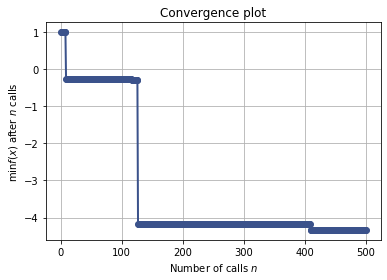

In [74]:
from skopt.plots import plot_convergence
print(run_sig_key)
plot_convergence(res_gp)
print("Best parameters: \
\n jet_time_cuts = [{}] \
\n jet_tmf_cuts = [{}] \
\n jet_delta_r_cuts = [{}]\
 \n jet_chef_cuts = [{}]".format(res_gp.x[0],
                                 res_gp.x[1],
                                 res_gp.x[2],
                                 res_gp.x[3]))

## larger time range in optimization

In [10]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

sig_bins = [0,1,2]



space = [Real(-5,5, name='jet_time'),
          Real(0.0,1.5, name='jet_tmf'),
          Real(0.0,1.5,name='jetMinDeltaRPVTracks'),
          Real(0.0,1.5,name = 'jet_chef')
          ]

def figure_of_merit(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50, chef_cut = -50):
    nTags = {}
    sig_count = [] 
    bkg_count = np.zeros((3,))
    
    for k,T in pf_jet_tmf_et.items():
#         start_t = time.time()
        nTags[k] = []
        tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
        tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
        tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)
#         nTags[k] = [len(x) for x in pf_jet_pt[k][tagged_jet]] #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.array(nTags[k])
        nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.sum(w[tagged_jet])
#         nJets[k] = np.sum(w[w<8000000])
#         print(k, nTags[k][:10])
        print(k, np.unique(nTags[k]))
        nTags[k] = np.array(nTags[k])
            
        occurCount = []
        for i in sig_bins:
            if i == 2:
#               #overflow bin
                tag_cut = nTags[k] >= i 
            else:
                tag_cut = nTags[k] == i
            w_sum = sum(weight[k][tag_cut])
            occurCount.append(w_sum)
            print(k,'sig bin ', i, ',  len ', len(weight[k][tag_cut]) )
        print(occurCount)
        occurCount = np.array(occurCount)
        
        if run_sig in k :
            sig_count = list(occurCount[:2])
            sig_count.append(sum(occurCount[2:]))
            sig_count = np.array(sig_count)
        elif 'background' in k:
            bkg_count = bkg_count + occurCount

#     cond = np.logical_not(np.logical_or(sig_count < 5,bkg_count < 5))
    sig_count = sig_count
    bkg_count = bkg_count
    print("sig count", sig_count)
    print("bkg count", bkg_count)
    cond = sig_count > 5
    if not np.count_nonzero(cond) == len(sig_bins):
        return 1

#     return -1.0*np.sum(2*((s+b)*math.log(s/b+1)-s))**0.5

    # loss function: - significance  = - (sqrt(S/(S+B)))
    return -1.0 * np.sum(sig_count**2/(sig_count+bkg_count))**0.5

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
#     begt = time.time()
    fom = figure_of_merit(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'],chef_cut = X['jet_chef'])
#     fom = train(model, learning_rate=X['learning_rate'])
    return fom


# res_gp = gp_minimize(objective, space, n_calls=5, n_random_starts=1, random_state=123, verbose=True)
res_gp = gp_minimize(objective, space, n_calls=500, n_random_starts=100, random_state=123, verbose=True)


/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 1 started. Evaluating function at random point.
New configuration: {'jet_time': 2.1295532052322734, 'jet_tmf': 0.6427063892802387, 'jetMinDeltaRPVTracks': 1.0363272825402927, 'jet_chef': 1.0787254652321598}
W(lv)Jets, background [0]
W(lv)Jets, background sig bin  0 ,  len  8650
W(lv)Jets, background sig bin  1 ,  len  0
W(lv)Jets, background sig bin  2 ,  len  0
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m sig bin  0 ,  len  835
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m sig bin  1 ,  len  6
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m sig bin  2 ,  len  0
[1117.56025112325, 8.030373061963473, 0]
sig count [1117.56025112    8.03037306    0.        ]
bkg count [89359774.36974645        0.                0.        ]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0343
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
New config

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 2.2782
Function value obtained: -3.4757
Current minimum: -3.4757
Iteration No: 102 started. Searching for the next optimal point.
New configuration: {'jet_time': -4.249169553362426, 'jet_tmf': 0.46850801655217356, 'jetMinDeltaRPVTracks': 0.24413634275622337, 'jet_chef': 0.1440981511897779}
W(lv)Jets, background [0 1]
W(lv)Jets, background sig bin  0 ,  len  8533
W(lv)Jets, background sig bin  1 ,  len  117
W(lv)Jets, background sig bin  2 ,  len  0
[88151093.02856028, 1208681.3411861658, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m sig bin  0 ,  len  682
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m sig bin  1 ,  len  154
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m sig bin  2 ,  len  5
[912.7857380431815, 206.11290859039582, 6.691977551636228]
sig count [912.78573804 206.11290859   6.69197755]
bkg count [88151093.02856028  1208681.34118617        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: 

In [13]:
from skopt.plots import plot_convergence
print(run_sig_key)
# plot_convergence(res_gp)
# print("Best parameters: \
# \n jet_time_cuts = [{}] \
# \n jet_tmf_cuts = [{}] \
# \n jet_delta_r_cuts = [{}]\
#  \n jet_chef_cuts = [{}]".format(res_gp.x[0],
#                                  res_gp.x[1],
#                                  res_gp.x[2],
#                                  res_gp.x[3]))

print('New configuration:', 'jet_time', -0.8315185599520039, 'jet_tmf', 1.3685861846568979, 'jetMinDeltaRPVTracks', 0.2319849993941241, 'jet_chef', 0.8828288332002512)

W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m
New configuration: jet_time -0.8315185599520039 jet_tmf 1.3685861846568979 jetMinDeltaRPVTracks 0.2319849993941241 jet_chef 0.8828288332002512


## C1N2 200_150 tagger plot

W(lv)Jets, background 8650
W(lv)Jets, background bin 0  8217
W(lv)Jets, background bin 1  433
W(lv)Jets, background bin 2  0
unique nTags element:  [0 1]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 841
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m bin 0  575
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m bin 1  247
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m bin 2  19
unique nTags element:  [0 1 2]
W(lv)Jets, background 0 0.0
W(lv)Jets, background weight [10330.60975373 10330.60975373 10330.60975373 10330.60975373
 10330.60975373 10330.60975373 10330.60975373 10330.60975373
 10330.60975373 10330.60975373]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 19 25.429514696217666
total 84886620.34638226 936445.6994995348
0 769.5774184381662 84886620.34638226
1 330.58369105082966 4473154.023364186
2 25.429514696217666 0.0
1.3685861846568979 -0.8315185599520039 0.2319849993941241 0.8828288332002512 5.045881608804815 1
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


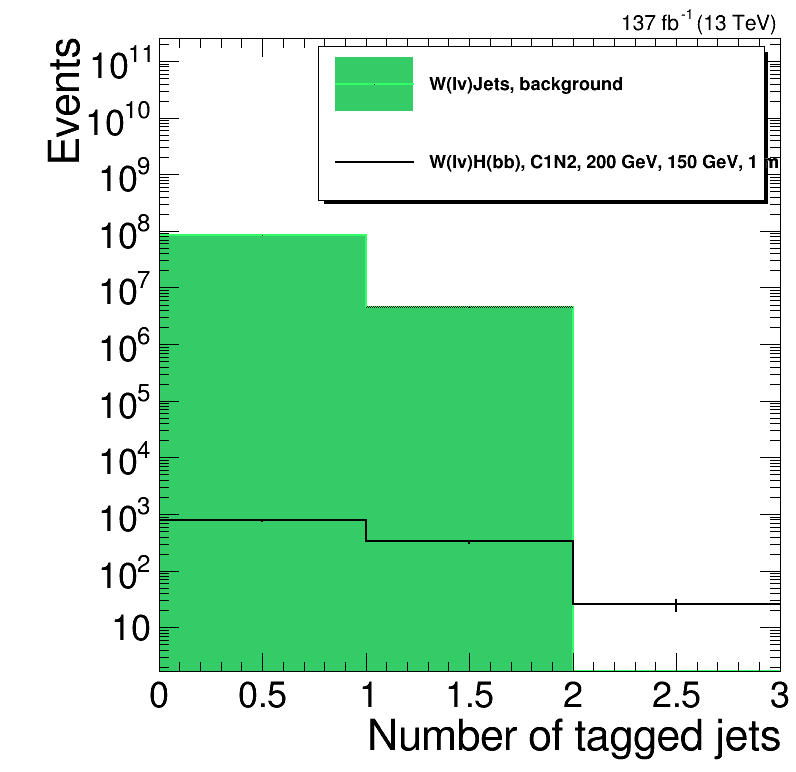

In [15]:
# loop over all the cuts and save the efficiency for each cut and a list for cuts
plotting = True

#signal>5
# time_cuts = [0] 
# tmf_et_cuts = [1.5] 
# delta_r_cuts = [0.2275379049004003]
# chef_cuts = [1.2981535804105477]

# larger time optimization cut
time_cuts = [-0.8315185599520039] 
tmf_et_cuts = [1.3685861846568979] 
delta_r_cuts = [0.2319849993941241]
chef_cuts = [0.8828288332002512]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in pf_jet_tmf_et.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)

                    nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
                    print(k, 'bin 0 ', len(weight[k][nTags[k]==0]))
                    print(k, 'bin 1 ', len(weight[k][nTags[k]==1]))
                    print(k, 'bin 2 ', len(weight[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.74,0.96,0.94)

                    leg.SetTextSize(0.025)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['W(lv)Jets, background']
                    sig_keys = [run_sig_key]
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = weight[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'weight', w[:10])

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*1000)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = weight[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
    #                     print(k,1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h[run_sig_key].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print(tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
    #                 c.SaveAs("../plots/ntags_optimization/mindeltaRcut"+str(mindeltaR_cut)+"_timecut"+str(time_cut)+"gammacut"+str(gamma_cut)+".pdf")

## C1N2 200_150 validation

W(lv)Jets, background 0 0.0
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 14 18.737537144581438
total 86818444.37032938 947041.4289857871
0 808.3908882376563 86818444.37032938
1 298.46219880297576 2541329.9994170666
2 18.737537144581438 0.0
1.5 0.0 0.2275379049004003 1.2981535804105477 4.807672536292086 1
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 6 8.030373061963473
total 88182084.85782146 954449.9494138506
0 890.0330143676183 88182084.85782146
1 227.52723675563175 1177689.511924982
2 8.030373061963473 0.0
1.5 0.5 0.2275379049004003 1.2981535804105477 3.590400818316517 1
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 1 1.3383955103272456
total 88915558.15033615 958411.1499173258
0 979.7055135595438 88915558.15033615
1 144.54671511534252 444216.21941030025
2 1.3383955103272456 0.0
1.5 1.0 0.2275379049004003 1.2981535804105477 2.2330720487999165 0
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replac

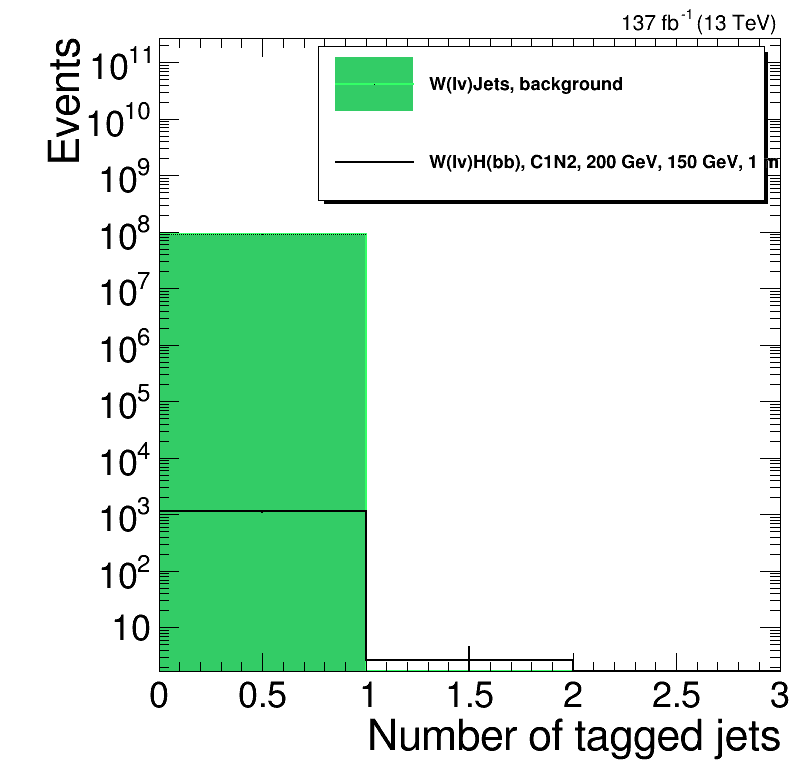

In [12]:
# for validation
plotting = True

time_cuts = [0] 
tmf_et_cuts = [1.5] 
delta_r_cuts = [0.2275379049004003]
chef_cuts = [1.2981535804105477]

cut_variable = 1
# 1 = time,   2= tmf, 3=deltaR, 4 = chef 
if cut_variable == 1:#time
    time_cuts = list(np.array(range(10))/2.0)
    time_cuts.sort() 
elif cut_variable == 2:#gamma
    tmf_et_cuts = list(np.array(range(16))/10.0)
elif cut_variable == 3:#deltaR
    delta_r_cuts = list(np.array(range(16))/10.0)+ [0.22,0.24]
    delta_r_cuts.sort()
else:
    chef_cuts = list(np.array(range(16))/10.0)
    chef_cuts.sort()


# time_cuts = np.array(time_cuts)
# tmf_et_cuts = np.array(tmf_et_cuts)
# delta_r_cuts = np.array(delta_r_cuts)
# chef_cuts = np.array(chef_cuts)

validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in pf_jet_tmf_et.items():
            
                    tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)

                    nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
                    for i,ele in enumerate(nTags[k]):
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.74,0.96,0.94)

                    leg.SetTextSize(0.025)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['W(lv)Jets, background']
                    sig_keys = [run_sig_key]
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = weight[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*1000)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = weight[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
    #                     print(k,1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h[run_sig_key].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print(tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
    #                 c.SaveAs("../plots/ntags_optimization/mindeltaRcut"+str(mindeltaR_cut)+"_timecut"+str(time_cut)+"gammacut"+str(gamma_cut)+".pdf")

137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


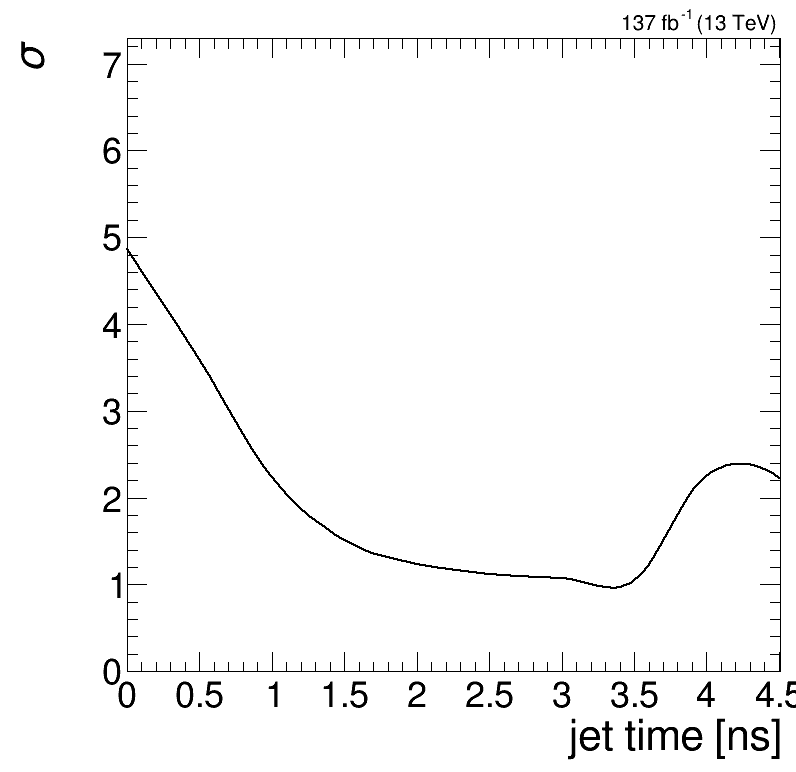

In [83]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

gr = {}


time_cuts = np.array(time_cuts)
tmf_et_cuts = np.array(tmf_et_cuts)
delta_r_cuts = np.array(delta_r_cuts)
chef_cuts = np.array(chef_cuts)
significance = np.array(significance)

# 1 = time,   2= tmf, 3=deltaR, 4 = chef 
 

if cut_variable == 1:
    gr['good'] = create_TGraph(time_cuts[validity],significance[validity],axis_title = ['jet time [ns]','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(time_cuts,significance,axis_title = ['jet time [ns]','\sigma'])
    x_max = np.max(time_cuts)
elif cut_variable == 2:
    gr['good'] = create_TGraph(tmf_et_cuts[validity],significance[validity],axis_title = ['TMF_{ET MAX}','\sigma'])
    gr['all'] = create_TGraph(tmf_et_cuts,significance,axis_title = ['TMF_{ET MAX}','\sigma'])
    x_max = np.max(tmf_et_cuts)
elif cut_variable == 3:
    gr['good'] = create_TGraph(delta_r_cuts[validity],significance[validity],axis_title = ['#Delta R_{min}','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(delta_r_cuts,significance,axis_title = ['#Delta R_{min}','\sigma'])
    x_max = np.max(delta_r_cuts)    
else:
    gr['good'] = create_TGraph(chef_cuts[validity],significance[validity],axis_title = ['CHEF','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(chef_cuts,significance,axis_title = ['#sigma_{ET}','\sigma'])
    x_max = np.max(chef_cuts)
    

    
gr['all'].SetLineWidth(2)
gr['all'].SetLineColor(1)
gr['all'].GetXaxis().SetRangeUser(0,x_max)
gr['all'].GetYaxis().SetRangeUser(0,1.5*np.max(significance))
# leg.AddEntry(gr['all'],"Has > 5 signal events")
gr['all'].Draw('ac')

    
 
leg.Draw()
    
 

CMS_lumi.lumi_13TeV = "137 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


 
c.Draw()


## optimization of twin higgs

In [21]:
import time

In [20]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

sig_bins = [0,1,2]



space = [Real(0,5, name='jet_time'),
          Real(0.0,1.5, name='jet_tmf'),
          Real(0.0,1.5,name='jetMinDeltaRPVTracks'),
          Real(0.0,1.5,name = 'jet_chef')
          ]

def figure_of_merit(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50, chef_cut = -50):
    nTags = {}
    sig_count = [] 
    bkg_count = np.zeros((3,))
    
    for k,T in pf_jet_tmf_et.items():
#         start_t = time.time()
        nTags[k] = []
        tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
        tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
        tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)
#         nTags[k] = [len(x) for x in pf_jet_pt[k][tagged_jet]] #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.array(nTags[k])
        nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.sum(w[tagged_jet])
#         nJets[k] = np.sum(w[w<8000000])
#         print(k, nTags[k][:10])
        print(k, np.unique(nTags[k]))
        nTags[k] = np.array(nTags[k])
            
        occurCount = []
        for i in sig_bins:
            if i == 2:
#               #overflow bin
                tag_cut = nTags[k] >= i 
            else:
                tag_cut = nTags[k] == i
            w_sum = sum(weight[k][tag_cut])
            occurCount.append(w_sum)
        print(occurCount)
        occurCount = np.array(occurCount)
        
        if run_sig in k :
            sig_count = list(occurCount[:2])
            sig_count.append(sum(occurCount[2:]))
            sig_count = np.array(sig_count)
        elif 'background' in k:
            bkg_count = bkg_count + occurCount

#     cond = np.logical_not(np.logical_or(sig_count < 5,bkg_count < 5))
    sig_count = sig_count
    bkg_count = bkg_count
    print("sig count", sig_count)
    print("bkg count", bkg_count)
    cond = sig_count > 5
    if not np.count_nonzero(cond) == len(sig_bins):
        return 1

#     return -1.0*np.sum(2*((s+b)*math.log(s/b+1)-s))**0.5

    # loss function: - significance  = - (sqrt(S/(S+B)))
    return -1.0 * np.sum(sig_count**2/(sig_count+bkg_count))**0.5

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
#     begt = time.time()
    fom = figure_of_merit(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'],chef_cut = X['jet_chef'])
#     fom = train(model, learning_rate=X['learning_rate'])
    return fom


# res_gp = gp_minimize(objective, space, n_calls=5, n_random_starts=1, random_state=123, verbose=True)
res_gp = gp_minimize(objective, space, n_calls=500, n_random_starts=100, random_state=123, verbose=True)


Iteration No: 1 started. Evaluating function at random point.
New configuration: {'jet_time': 3.5647766026161367, 'jet_tmf': 0.6427063892802387, 'jetMinDeltaRPVTracks': 1.0363272825402927, 'jet_chef': 1.0787254652321598}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1121.5754376542318, 4.015186530981737, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3539.8650751513196, 18.49183248213376, 1.3208451772952685]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1]
[416.8852933689777, 0.5676663368831214, 0]
sig count [416.88529337   0.56766634   0.        ]
bkg count [89359774.36974645        0.                0.        ]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0549
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
New configuration: {'jet_time': 2.4555946671629867, 'jet_tmf': 1.170041642868119, 'jetMinDeltaRPVTracks': 0.6163865590635286, 'je

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


[409.1271867649084, 8.325772940952447, 0]
sig count [409.12718676   8.32577294   0.        ]
bkg count [89359774.36974645        0.                0.        ]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0486
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 5 started. Evaluating function at random point.
New configuration: {'jet_time': 2.201285890320382, 'jet_tmf': 0.12558972684537653, 'jetMinDeltaRPVTracks': 1.068495272083144, 'jet_chef': 0.6417952362567294}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1117.56025112325, 8.030373061963473, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3494.9563391232805, 63.40056851017289, 1.3208451772952685]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1]
[414.42540590915087, 3.027553796709981, 0]
sig count [414.42540591   3.0275538    0.        ]
bkg count [89359774.36974645        0.                0.        ]
Iteration No: 5 ended. Evaluation d

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 2.3875
Function value obtained: -4.7862
Current minimum: -4.7862
Iteration No: 102 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.2126030824796588, 'jet_tmf': 0.6659691336174953, 'jetMinDeltaRPVTracks': 0.3134837278183411, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89256468.27220917, 103306.09753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1060.0092441791785, 65.58138000603503, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[3118.515463594129, 408.14115978423797, 33.02112943238171]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2]
[391.34030820923726, 25.734207272034837, 0.3784442245887476]
sig count [3.91340308e+02 2.57342073e+01 3.78444225e-01]
bkg count [89256468.27220917   103306.09753728        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 2.1447
Function value obtained: 1.0000
Current minimum: -4.7862
Iteration No: 103 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4946088478797965, 'jetMinDeltaRPVTracks': 0.2379507767573159, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1953.5300172197021, 1343.299545309288, 262.84819028175843]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[237.58285197782243, 155.4604552420642, 24.40965248597422]
sig count [237.58285198 155.46045524  24.40965249]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.1410
Function value obtained: -4.9417
Current minimum: -4.9417
Iteration No: 104 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.2647190963349635, 'jetMinDeltaRPVTracks': 0.23788988067423122, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1949.5674816878163, 1347.2620808411739, 262.84819028175843]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[238.33974042699992, 154.7035667928867, 24.40965248597422]
sig count [238.33974043 154.70356679  24.40965249]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.0964
Function value obtained: -4.9417
Current minimum: -4.9417
Iteration No: 105 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.264591151515667, 'jetMinDeltaRPVTracks': 0.24058713125264766, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87087040.2239263, 2272734.145820141, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 282.4014526790488, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1968.05931416995, 1339.3370097774023, 252.2814288633963]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[238.90740676388305, 154.51434468059233, 24.031208261385473]
sig count [238.90740676 154.51434468  24.03120826]
bkg count [87087040.2239263   2272734.14582014        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.6828
Function value obtained: -4.9033
Current minimum: -4.9417
Iteration No: 106 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.24475382792971564, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.7141
Function value obtained: 1.0000
Current minimum: -4.9417
Iteration No: 107 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3733339484387135, 'jetMinDeltaRPVTracks': 0.17865644096037545, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[85155216.19997919, 4152905.120998621, 51653.048768639565]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[734.7791351696578, 364.0435788090108, 26.76791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1485.950824457177, 1632.5646391369519, 441.1622892166197]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[199.73842951894767, 181.3838846263934, 36.33064556051977]
sig count [199.73842952 181.38388463  36.33064556]
bkg count [8.51552162e+07 4.15290512e+06 5.16530488e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.5657
Function value obtained: -0.1842
Current minimum: -4.9417
Iteration No: 108 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.25286727440286, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87386627.90678442, 1973146.4629620314, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[847.2043580371464, 269.01749757577636, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2073.7269283535716, 1265.3696798488672, 220.58114460830984]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[247.2331797048355, 149.21612553634986, 21.003654464675492]
sig count [247.2331797  149.21612554  21.00365446]
bkg count [87386627.90678442  1973146.46296203        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.5284
Function value obtained: -4.5843
Current minimum: -4.9417
Iteration No: 109 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4828806721171202, 'jetMinDeltaRPVTracks': 0.25780805846075383, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87448611.56530678, 1911162.804439664, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[855.2347310991099, 260.9871245138129, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2115.99397402702, 1231.0277052391903, 212.65607354453823]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[249.12540082777923, 148.08079286258362, 20.246766015497997]
sig count [249.12540083 148.08079286  20.24676602]
bkg count [87448611.56530678  1911162.80443966        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.7338
Function value obtained: -4.5010
Current minimum: -4.9417
Iteration No: 110 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.33590762991400847, 'jetMinDeltaRPVTracks': 1.3140741067311636, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3306.075478770057, 243.0355126223294, 10.566761418362148]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2]
[382.06842470681295, 33.68153598839854, 1.7029990106493642]
sig count [382.06842471  33.68153599   1.70299901]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.6797
Function value obtained: 1.0000
Current minimum: -4.9417
Iteration No: 111 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4449548878042688, 'jetMinDeltaRPVTracks': 0.25942090439780496, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87510595.22382915, 1849179.1459172964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[859.2499176300917, 256.97193798283115, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2127.8815806226776, 1220.460943820828, 211.33522836724296]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.44995561383985, 146.94546018881738, 20.057543903203623]
sig count [250.44995561 146.94546019  20.0575439 ]
bkg count [87510595.22382915  1849179.1459173         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.8302
Function value obtained: -4.4799
Current minimum: -4.9417
Iteration No: 112 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.21618804121788962, 'jet_tmf': 0.36590675265383904, 'jetMinDeltaRPVTracks': 0.22956023372223683, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87562248.27259779, 1797526.0971486568, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 275.7094751274126, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2011.647205020694, 1319.5243321179732, 228.50621567208145]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[261.99250446379665, 138.24124302327618, 17.219212218788016]
sig count [261.99250446 138.24124302  17.21921222]
bkg count [87562248.27259779  1797526.09714866        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.8467
Function value obtained: -4.1510
Current minimum: -4.9417
Iteration No: 113 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3438338882551624, 'jetMinDeltaRPVTracks': 0.25738081715212274, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87448611.56530678, 1911162.804439664, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[853.8963355887827, 262.32552002414013, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2112.0314384951344, 1232.3485504164855, 215.29776389912877]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[248.93617871548486, 148.270014974878, 20.246766015497997]
sig count [248.93617872 148.27001497  20.24676602]
bkg count [87448611.56530678  1911162.80443966        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.9292
Function value obtained: -4.5010
Current minimum: -4.9417
Iteration No: 114 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2907986658379134, 'jetMinDeltaRPVTracks': 0.2576810937781265, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87448611.56530678, 1911162.804439664, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[855.2347310991099, 260.9871245138129, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2114.673128849725, 1232.3485504164855, 212.65607354453823]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[249.12540082777923, 148.08079286258362, 20.246766015497997]
sig count [249.12540083 148.08079286  20.24676602]
bkg count [87448611.56530678  1911162.80443966        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.9013
Function value obtained: -4.5010
Current minimum: -4.9417
Iteration No: 115 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2513037534193745, 'jetMinDeltaRPVTracks': 0.2577257809930841, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87448611.56530678, 1911162.804439664, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[855.2347310991099, 260.9871245138129, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2114.673128849725, 1232.3485504164855, 212.65607354453823]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[249.12540082777923, 148.08079286258362, 20.246766015497997]
sig count [249.12540083 148.08079286  20.24676602]
bkg count [87448611.56530678  1911162.80443966        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 3.0979
Function value obtained: -4.5010
Current minimum: -4.9417
Iteration No: 116 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.1944390409446478, 'jet_tmf': 1.404638961911022, 'jetMinDeltaRPVTracks': 0.2381467596946401, 'jet_chef': 0.31745673436585453}
W(lv)Jets, background [0 1]
[88595309.24797058, 764465.1217758656, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[900.7401784502363, 219.49686369366827, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2352.425260762873, 1063.2803677226912, 143.97212432518427]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[291.51115398171896, 113.64236842500759, 12.299437299134297]
sig count [291.51115398 113.64236843  12.2994373 ]
bkg count [88595309.24797058   764465.12177587        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 3.1314
Function value obtained: -3.5096
Current minimum: -4.9417
Iteration No: 117 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.32900614222038205, 'jetMinDeltaRPVTracks': 0.24177885189203246, 'jet_chef': 0.910806248840379}
W(lv)Jets, background [0 1]
[87169685.10195613, 2190089.2677903175, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 282.4014526790488, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1979.9469207656075, 1332.732783890926, 246.9980481542152]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.66429521306054, 153.9466783437092, 23.8419861490911]
sig count [239.66429521 153.94667834  23.84198615]
bkg count [87169685.10195613  2190089.26779032        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 3.0461
Function value obtained: -4.8840
Current minimum: -4.9417
Iteration No: 118 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3201252416097998, 'jetMinDeltaRPVTracks': 0.25359115034325874, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87396958.51653814, 1962815.8532083035, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[849.8811490578009, 266.34070655512187, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2080.331154240048, 1258.765453962391, 220.58114460830984]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[247.42240181712987, 149.0269034240555, 21.003654464675492]
sig count [247.42240182 149.02690342  21.00365446]
bkg count [87396958.51653814  1962815.8532083         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 3.0147
Function value obtained: -4.5843
Current minimum: -4.9417
Iteration No: 119 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3372192024975488, 'jetMinDeltaRPVTracks': 0.22749760557740278, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1861.0708548090333, 1414.6251848832326, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.68941269998686, 163.02933973383915, 25.734207272034837]
sig count [228.6894127  163.02933973  25.73420727]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.9300
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 120 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3946931982433166, 'jetMinDeltaRPVTracks': 0.23570417386337333, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86983734.12638903, 2376040.24335742, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 290.4318257410123, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1933.717339560273, 1352.545461550355, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.2582971917618, 156.40656580353607, 24.788096710562968]
sig count [236.25829719 156.4065658   24.78809671]
bkg count [86983734.12638903  2376040.24335742        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.9742
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 121 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3119385885610298, 'jetMinDeltaRPVTracks': 0.2369372228483465, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87035387.17515767, 2324387.1945887804, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1941.6424106240447, 1351.2246163730597, 266.81072581364424]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[237.58285197782243, 155.27123312976983, 24.598874598268594]
sig count [237.58285198 155.27123313  24.5988746 ]
bkg count [87035387.17515767  2324387.19458878        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 3.0884
Function value obtained: -4.9608
Current minimum: -5.0740
Iteration No: 122 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7332081246837139, 'jetMinDeltaRPVTracks': 0.31142744060007055, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88316382.78461993, 1043391.5851265192, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[911.4473425328542, 210.12809512137756, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2485.8306236696953, 947.0459921207075, 126.80113702034578]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[284.9974810997992, 118.83148652086675, 13.623992085194914]
sig count [284.9974811  118.83148652  13.62399209]
bkg count [88316382.78461993  1043391.58512652        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 3.1824
Function value obtained: -3.6930
Current minimum: -5.0740
Iteration No: 123 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3182290064936577, 'jetMinDeltaRPVTracks': 0.2235561524723344, 'jet_chef': 1.0224013276234993}
W(lv)Jets, background [0 1 2]
[86725468.88254583, 2623974.87744689, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[804.3757017066746, 301.13898982363025, 20.075932654908684]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1816.1621187809942, 1447.6463143156143, 295.86931971414015]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[225.66185890327688, 165.11078296907726, 26.680317833506706]
sig count [225.6618589  165.11078297  26.68031783]
bkg count [8.67254689e+07 2.62397488e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 3.2314
Function value obtained: -0.2823
Current minimum: -5.0740
Iteration No: 124 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2596146367461323, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87520925.83358288, 1838848.5361635685, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[859.2499176300917, 256.97193798283115, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2127.8815806226776, 1220.460943820828, 211.33522836724296]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.63917772613422, 146.756238076523, 20.057543903203623]
sig count [250.63917773 146.75623808  20.0575439 ]
bkg count [87520925.83358288  1838848.53616357        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.9607
Function value obtained: -4.4800
Current minimum: -5.0740
Iteration No: 125 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2595863191187173, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87520925.83358288, 1838848.5361635685, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[859.2499176300917, 256.97193798283115, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2127.8815806226776, 1220.460943820828, 211.33522836724296]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.63917772613422, 146.756238076523, 20.057543903203623]
sig count [250.63917773 146.75623808  20.0575439 ]
bkg count [87520925.83358288  1838848.53616357        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 3.0013
Function value obtained: -4.4800
Current minimum: -5.0740
Iteration No: 126 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.25953792377677415, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87520925.83358288, 1838848.5361635685, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[859.2499176300917, 256.97193798283115, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2127.8815806226776, 1220.460943820828, 211.33522836724296]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.63917772613422, 146.756238076523, 20.057543903203623]
sig count [250.63917773 146.75623808  20.0575439 ]
bkg count [87520925.83358288  1838848.53616357        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.8585
Function value obtained: -4.4800
Current minimum: -5.0740
Iteration No: 127 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2594773628369183, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87510595.22382915, 1849179.1459172964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[859.2499176300917, 256.97193798283115, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2127.8815806226776, 1220.460943820828, 211.33522836724296]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.44995561383985, 146.94546018881738, 20.057543903203623]
sig count [250.44995561 146.94546019  20.0575439 ]
bkg count [87510595.22382915  1849179.1459173         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 3.0901
Function value obtained: -4.4799
Current minimum: -5.0740
Iteration No: 128 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.25818028681341754, 'jet_chef': 0.3690544423211224}
W(lv)Jets, background [0 1]
[88182084.85782146, 1177689.511924982, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[899.401782939909, 220.83525920399552, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2362.9920221812354, 1048.7510707724432, 147.93465985707007]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[274.85960809981407, 127.64480473479125, 14.94854687125553]
sig count [274.8596081  127.64480473  14.94854687]
bkg count [88182084.85782146  1177689.51192498        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.8830
Function value obtained: -3.8682
Current minimum: -5.0740
Iteration No: 129 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2593135199553591, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87510595.22382915, 1849179.1459172964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[859.2499176300917, 256.97193798283115, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2127.8815806226776, 1220.460943820828, 211.33522836724296]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.44995561383985, 146.94546018881738, 20.057543903203623]
sig count [250.44995561 146.94546019  20.0575439 ]
bkg count [87510595.22382915  1849179.1459173         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 3.2399
Function value obtained: -4.4799
Current minimum: -5.0740
Iteration No: 130 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.006064768343372294, 'jet_tmf': 0.3707186652040005, 'jetMinDeltaRPVTracks': 0.2586779738928059, 'jet_chef': 0.8332970807294259}
W(lv)Jets, background [0 1]
[87489934.0043217, 1869840.3654247522, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[857.9115221197644, 259.64872900348564, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2139.769187218335, 1209.894182402466, 210.0143831899477]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[251.39606617531172, 146.18857173963988, 19.86832179090925]
sig count [251.39606618 146.18857174  19.86832179]
bkg count [87489934.0043217   1869840.36542475        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 3.1157
Function value obtained: -4.4588
Current minimum: -5.0740
Iteration No: 131 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0175757094904556, 'jet_tmf': 0.23715973481377486, 'jetMinDeltaRPVTracks': 0.24005873990235532, 'jet_chef': 0.8492589364320697}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 283.73984818937606, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1981.2677659429028, 1328.7702483590401, 249.63973850880575]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 151.67601299617672, 23.46354192450235]
sig count [242.31340479 151.676013    23.46354192]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 3.1868
Function value obtained: -4.8451
Current minimum: -5.0740
Iteration No: 132 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.20933818458971487, 'jet_tmf': 0.26523594824978464, 'jetMinDeltaRPVTracks': 0.26060827492799055, 'jet_chef': 0.8947238682562402}
W(lv)Jets, background [0 1]
[88089109.37003791, 1270664.9997085333, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[882.0026413056548, 238.2344008382497, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2252.041027288433, 1133.2851621193404, 174.35156340297544]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[278.8332724579959, 125.56336149955314, 13.056325748311792]
sig count [278.83327246 125.5633615   13.05632575]
bkg count [88089109.37003791  1270664.99970853        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 3.1910
Function value obtained: -3.6152
Current minimum: -5.0740
Iteration No: 133 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.39931297007977806, 'jetMinDeltaRPVTracks': 0.2277918530203395, 'jet_chef': 0.8395054561413946}
W(lv)Jets, background [0 1]
[86849436.19959056, 2510338.170155883, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 299.800594313303, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1878.2418421138718, 1398.7750427556894, 282.66086794118746]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.44630114916436, 162.46167339695603, 25.544985159740463]
sig count [229.44630115 162.4616734   25.54498516]
bkg count [86849436.19959056  2510338.17015588        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 3.2605
Function value obtained: -5.0553
Current minimum: -5.0740
Iteration No: 134 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7450587304271887, 'jetMinDeltaRPVTracks': 0.2609670726286575, 'jet_chef': 1.437787040409321}
W(lv)Jets, background [0 1]
[87531256.4433366, 1828517.9264098406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[860.5883131404189, 255.6335424725039, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2137.1274968637445, 1212.5358727570565, 210.0143831899477]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[251.5852882876061, 145.9993496273455, 19.86832179090925]
sig count [251.58528829 145.99934963  19.86832179]
bkg count [87531256.4433366   1828517.92640984        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 3.2376
Function value obtained: -4.4588
Current minimum: -5.0740
Iteration No: 135 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3589565339756882, 'jetMinDeltaRPVTracks': 0.2414276816755496, 'jet_chef': 1.3997181824054237}
W(lv)Jets, background [0 1]
[87149023.88244867, 2210750.4872977734, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 282.4014526790488, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1975.9843852337217, 1332.732783890926, 250.96058368610102]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.47507310076617, 154.13590045600358, 23.8419861490911]
sig count [239.4750731  154.13590046  23.84198615]
bkg count [87149023.88244867  2210750.48729777        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 3.3626
Function value obtained: -4.8840
Current minimum: -5.0740
Iteration No: 136 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.25769788421129464, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87448611.56530678, 1911162.804439664, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[855.2347310991099, 260.9871245138129, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2114.673128849725, 1232.3485504164855, 212.65607354453823]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[249.12540082777923, 148.08079286258362, 20.246766015497997]
sig count [249.12540083 148.08079286  20.24676602]
bkg count [87448611.56530678  1911162.80443966        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 3.3336
Function value obtained: -4.5010
Current minimum: -5.0740
Iteration No: 137 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.922606707959172, 'jetMinDeltaRPVTracks': 0.29574099441191437, 'jet_chef': 1.3426705767432392}
W(lv)Jets, background [0 1]
[88068448.15053046, 1291326.219215989, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[904.755364981218, 216.82007267301378, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2390.729770904436, 1019.6924768719473, 149.25550503436534]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[274.4811638752253, 128.21247107167437, 14.759324758961156]
sig count [274.48116388 128.21247107  14.75932476]
bkg count [88068448.15053046  1291326.21921599        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 3.5806
Function value obtained: -3.8436
Current minimum: -5.0740
Iteration No: 138 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5504730906956095, 'jet_tmf': 1.4358881773263446, 'jetMinDeltaRPVTracks': 0.2399059834179614, 'jet_chef': 1.452308472916041}
W(lv)Jets, background [0 1]
[88388697.05289602, 971077.3168504238, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[914.1241335535087, 206.11290859039582, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2385.446390195255, 1022.3341672265378, 151.89719538895588]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2]
[318.0022497029313, 92.82793607262647, 6.622773930303083]
sig count [318.0022497   92.82793607   6.62277393]
bkg count [88388697.05289602   971077.31685042        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 3.5867
Function value obtained: -2.5754
Current minimum: -5.0740
Iteration No: 139 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0974661553411285, 'jetMinDeltaRPVTracks': 0.24192588155453112, 'jet_chef': 1.3933021313926244}
W(lv)Jets, background [0 1]
[87149023.88244867, 2210750.4872977734, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 283.73984818937606, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1978.6260755883122, 1334.0536290682212, 246.9980481542152]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.66429521306054, 154.13590045600358, 23.652764036796725]
sig count [239.66429521 154.13590046  23.65276404]
bkg count [87149023.88244867  2210750.48729777        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 3.6731
Function value obtained: -4.8646
Current minimum: -5.0740
Iteration No: 140 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9117837694920814, 'jetMinDeltaRPVTracks': 0.2354799797949017, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[86963072.90688157, 2396701.462864876, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 291.77022125133954, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1931.0756492056826, 1355.1871519049455, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.06907507946744, 156.59578791583044, 24.788096710562968]
sig count [236.06907508 156.59578792  24.78809671]
bkg count [86963072.90688157  2396701.46286488        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 3.5209
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 141 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6628574522935944, 'jetMinDeltaRPVTracks': 0.21734123849440845, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[86580840.34599364, 2768603.4139990807, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[793.6685376240566, 311.8461539062482, 20.075932654908684]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1768.6116923983645, 1478.0257533934055, 313.04030701897864]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[221.8774166573894, 167.38144831660975, 28.194094731861696]
sig count [221.87741666 167.38144832  28.19409473]
bkg count [8.65808403e+07 2.76860341e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 3.4120
Function value obtained: -0.2957
Current minimum: -5.0740
Iteration No: 142 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.264273844247486, 'jet_chef': 0.29435255844917896}
W(lv)Jets, background [0 1]
[88492003.1504333, 867771.2193131447, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[918.1393200844905, 203.43611756974133, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2454.130339414609, 980.0671215530892, 125.48029184305051]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[286.0237127251821, 117.99447700777819, 13.43476997290054]
sig count [286.02371273 117.99447701  13.43476997]
bkg count [88492003.1504333    867771.21931314        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 3.6067
Function value obtained: -3.6677
Current minimum: -5.0740
Iteration No: 143 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.26398699342221144, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87593240.10185897, 1766534.267887473, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[864.6034996714006, 251.61835594152217, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2155.619329345878, 1198.0065758068085, 206.0518476580619]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[253.85595363513858, 144.10712850440177, 19.4898775663205]
sig count [253.85595364 144.1071285   19.48987757]
bkg count [87593240.10185897  1766534.26788747        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.9079
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 144 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.24512095173392096, 'jetMinDeltaRPVTracks': 0.20741946814286322, 'jet_chef': 1.5}
W(lv)Jets, background [0 1 2]
[86446542.41919518, 2892570.7310438156, 20661.219507455826]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[785.6381645620932, 321.21492247853894, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1713.1361949519633, 1512.3677280030824, 334.17382985570293]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[218.66064074838505, 169.0844473272591, 29.707871630216687]
sig count [218.66064075 169.08444733  29.70787163]
bkg count [8.64465424e+07 2.89257073e+06 2.06612195e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.5588
Function value obtained: -0.2304
Current minimum: -5.0740
Iteration No: 145 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2633964981079935, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 4.0621
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 146 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.44449037306182315, 'jetMinDeltaRPVTracks': 0.2385895142189443, 'jet_chef': 0.730154124964156}
W(lv)Jets, background [0 1]
[87200676.93121731, 2159097.438529134, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[827.1284253822378, 290.4318257410123, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1985.2303014747886, 1324.8077128271543, 249.63973850880575]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.66429521306054, 154.13590045600358, 23.652764036796725]
sig count [239.66429521 154.13590046  23.65276404]
bkg count [87200676.93121731  2159097.43852913        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.9916
Function value obtained: -4.8646
Current minimum: -5.0740
Iteration No: 147 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.32802697854731067, 'jet_tmf': 0.3931826979881654, 'jetMinDeltaRPVTracks': 0.2398787470630917, 'jet_chef': 0.8214003983338456}
W(lv)Jets, background [0 1]
[88068448.15053046, 1291326.219215989, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[879.3258502850003, 239.57279634857696, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2199.207220196622, 1176.8730529700842, 183.59747964404232]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[286.0237127251821, 118.37292123236693, 13.056325748311792]
sig count [286.02371273 118.37292123  13.05632575]
bkg count [88068448.15053046  1291326.21921599        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 3.9343
Function value obtained: -3.6150
Current minimum: -5.0740
Iteration No: 148 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.946168553653751, 'jetMinDeltaRPVTracks': 0.2496975848609275, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87324644.24826205, 2035130.1214843988, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[840.5123804855102, 275.7094751274126, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2043.3474892757804, 1290.4657382174773, 225.86452531749092]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[245.15173646959738, 150.16223609782173, 22.138987138441735]
sig count [245.15173647 150.1622361   22.13898714]
bkg count [87324644.24826205  2035130.1214844         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 3.9093
Function value obtained: -4.7065
Current minimum: -5.0740
Iteration No: 149 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.4894648525808105, 'jetMinDeltaRPVTracks': 0.26575746178206816, 'jet_chef': 1.3448084137040266}
W(lv)Jets, background [0 1]
[87613901.32136643, 1745873.0483800173, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[867.2802906920551, 248.94156492086768, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2174.111161828012, 1183.4772788565606, 202.08931212617608]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[255.7481747580823, 142.21490738145803, 19.4898775663205]
sig count [255.74817476 142.21490738  19.48987757]
bkg count [87613901.32136643  1745873.04838002        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 4.1039
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 150 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.31645133721757, 'jetMinDeltaRPVTracks': 0.2247620573102347, 'jet_chef': 0.7068817289831322}
W(lv)Jets, background [0 1 2]
[86952742.29712784, 2396701.462864876, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[807.0524927273291, 303.81578084428475, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1866.3542355182144, 1415.9460300605278, 277.3774872320064]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.68941269998686, 163.78622818301665, 24.97731882285734]
sig count [228.6894127  163.78622818  24.97731882]
bkg count [8.69527423e+07 2.39670146e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.6935
Function value obtained: -0.2684
Current minimum: -5.0740
Iteration No: 151 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2664221693795299, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87613901.32136643, 1745873.0483800173, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[868.6186862023824, 248.94156492086768, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2175.4320070053072, 1186.1189692111511, 198.12677659429028]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[256.31584109496544, 141.83646315686929, 19.300655454026128]
sig count [256.31584109 141.83646316  19.30065545]
bkg count [87613901.32136643  1745873.04838002        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 3.8942
Function value obtained: -4.3946
Current minimum: -5.0740
Iteration No: 152 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.26624611339859383, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87613901.32136643, 1745873.0483800173, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[868.6186862023824, 248.94156492086768, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2175.4320070053072, 1184.7981240338559, 199.44762177158555]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[256.31584109496544, 141.6472410445749, 19.4898775663205]
sig count [256.31584109 141.64724104  19.48987757]
bkg count [87613901.32136643  1745873.04838002        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 3.8994
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 153 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2661044006455726, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87613901.32136643, 1745873.0483800173, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[868.6186862023824, 248.94156492086768, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2175.4320070053072, 1183.4772788565606, 200.7684669488808]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[256.12661898267106, 141.83646315686929, 19.4898775663205]
sig count [256.12661898 141.83646316  19.48987757]
bkg count [87613901.32136643  1745873.04838002        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 4.0660
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 154 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5336224894564484, 'jetMinDeltaRPVTracks': 0.2738091286730877, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87737868.63841116, 1621905.7313352823, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[879.3258502850003, 240.9111918589042, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2237.511730338185, 1133.2851621193404, 188.8808603532234]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[260.2895054531473, 139.37657569704243, 17.786878555671137]
sig count [260.28950545 139.3765757   17.78687856]
bkg count [87737868.63841116  1621905.73133528        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 4.0513
Function value obtained: -4.2190
Current minimum: -5.0740
Iteration No: 155 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.278928455537372, 'jetMinDeltaRPVTracks': 0.26943147828360203, 'jet_chef': 1.3367015304668814}
W(lv)Jets, background [0 1]
[87675884.9798888, 1683889.3898576498, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[876.6490592643459, 240.9111918589042, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2195.2446846647363, 1166.306291551722, 198.12677659429028]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[258.0188401056148, 140.89035259539742, 18.543767004848632]
sig count [258.01884011 140.8903526   18.543767  ]
bkg count [87675884.9798888   1683889.38985765        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 3.9790
Function value obtained: -4.3077
Current minimum: -5.0740
Iteration No: 156 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.265492220527354, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87613901.32136643, 1745873.0483800173, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[867.2802906920551, 248.94156492086768, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2171.4694714734214, 1186.1189692111511, 202.08931212617608]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[255.55895264578794, 142.4041294937524, 19.4898775663205]
sig count [255.55895265 142.40412949  19.48987757]
bkg count [87613901.32136643  1745873.04838002        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 4.1665
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 157 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6187136221382812, 'jetMinDeltaRPVTracks': 0.2387892741312211, 'jet_chef': 0.8195607949375395}
W(lv)Jets, background [0 1]
[87097370.83368003, 2262403.536066413, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[827.1284253822378, 287.7550347203578, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1973.3426948791312, 1327.4494031817449, 258.88565474987263]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[238.71818465158867, 154.7035667928867, 24.031208261385473]
sig count [238.71818465 154.70356679  24.03120826]
bkg count [87097370.83368003  2262403.53606641        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 4.3195
Function value obtained: -4.9033
Current minimum: -5.0740
Iteration No: 158 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3310173637301456, 'jet_tmf': 0.9963076865436807, 'jetMinDeltaRPVTracks': 0.23939425546241458, 'jet_chef': 1.4790843841297576}
W(lv)Jets, background [0 1]
[88016795.10176182, 1342979.2679846287, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[879.3258502850003, 239.57279634857696, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2191.2821491328505, 1183.4772788565606, 184.9183248213376]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[285.2668242760046, 119.12980968154443, 13.056325748311792]
sig count [285.26682428 119.12980968  13.05632575]
bkg count [88016795.10176182  1342979.26798463        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 4.2344
Function value obtained: -3.6149
Current minimum: -5.0740
Iteration No: 159 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1285045419064317, 'jetMinDeltaRPVTracks': 0.2283192518187601, 'jet_chef': 1.4739711275375773}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1862.3916999863286, 1413.3043397059373, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.87863481228123, 162.84011762154478, 25.734207272034837]
sig count [228.87863481 162.84011762  25.73420727]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 4.3798
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 160 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5896235962776152, 'jetMinDeltaRPVTracks': 0.2524373345700106, 'jet_chef': 0.7079122981231567}
W(lv)Jets, background [0 1]
[87551917.66284406, 1807856.7069023848, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[849.8811490578009, 269.01749757577636, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2098.8229867221817, 1250.8403828986193, 210.0143831899477]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[249.3146229400736, 148.08079286258362, 20.057543903203623]
sig count [249.31462294 148.08079286  20.0575439 ]
bkg count [87551917.66284406  1807856.70690238        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 4.3277
Function value obtained: -4.4800
Current minimum: -5.0740
Iteration No: 161 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1487051056301671, 'jetMinDeltaRPVTracks': 0.2920836150238553, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88037456.32126927, 1322318.0484771729, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[899.401782939909, 222.17365471432277, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2362.9920221812354, 1040.8259997086716, 155.85973092084168]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[272.3997206399872, 130.1046921946181, 14.94854687125553]
sig count [272.39972064 130.10469219  14.94854687]
bkg count [88037456.32126927  1322318.04847717        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 4.5126
Function value obtained: -3.8681
Current minimum: -5.0740
Iteration No: 162 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22442592628431177, 'jet_chef': 1.3797264440156973}
W(lv)Jets, background [0 1 2]
[86725468.88254583, 2623974.87744689, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[804.3757017066746, 302.4773853339575, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1826.7288801993564, 1438.4003980745474, 294.5484745368449]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[226.04030312786563, 165.11078296907726, 26.30187360891796]
sig count [226.04030313 165.11078297  26.30187361]
bkg count [8.67254689e+07 2.62397488e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 4.3331
Function value obtained: -0.2789
Current minimum: -5.0740
Iteration No: 163 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8786370809663782, 'jetMinDeltaRPVTracks': 0.2670687058174458, 'jet_chef': 1.27560130866449}
W(lv)Jets, background [0 1]
[87644893.15062761, 1714881.2191188335, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[869.9570817127096, 247.60316941054043, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2176.7528521826025, 1184.7981240338559, 198.12677659429028]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[256.6942853195542, 141.6472410445749, 19.111433341731754]
sig count [256.69428532 141.64724104  19.11143334]
bkg count [87644893.15062761  1714881.21911883        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 4.5449
Function value obtained: -4.3731
Current minimum: -5.0740
Iteration No: 164 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6088822419777193, 'jetMinDeltaRPVTracks': 0.2867142294614897, 'jet_chef': 1.32348085805541}
W(lv)Jets, background [0 1]
[87944480.83348572, 1415293.536260724, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[888.6946188572911, 232.88081879694073, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2329.9708927488537, 1064.6012128999864, 165.10564716190856]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[269.5613889555716, 131.99691331756185, 15.8946574327274]
sig count [269.56138896 131.99691332  15.89465743]
bkg count [87944480.83348572  1415293.53626072        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.5581
Function value obtained: -3.9885
Current minimum: -5.0740
Iteration No: 165 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1546498519024073, 'jetMinDeltaRPVTracks': 0.25846750683609254, 'jet_chef': 0.3865815253752156}
W(lv)Jets, background [0 1]
[88109770.58954537, 1250003.7802010775, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[898.0633874295818, 222.17365471432277, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2337.8959638126253, 1071.2054387864628, 150.5763502116606]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[273.53505331375345, 128.59091529626312, 15.326991095844278]
sig count [273.53505331 128.5909153   15.3269911 ]
bkg count [88109770.58954537  1250003.78020108        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 4.5458
Function value obtained: -3.9168
Current minimum: -5.0740
Iteration No: 166 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.524632359946586, 'jetMinDeltaRPVTracks': 0.2660909310251425, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87613901.32136643, 1745873.0483800173, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[868.6186862023824, 248.94156492086768, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2175.4320070053072, 1183.4772788565606, 200.7684669488808]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[256.12661898267106, 141.83646315686929, 19.4898775663205]
sig count [256.12661898 141.83646316  19.48987757]
bkg count [87613901.32136643  1745873.04838002        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 4.5249
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 167 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4772446052649213, 'jetMinDeltaRPVTracks': 0.2660051676228282, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87613901.32136643, 1745873.0483800173, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[868.6186862023824, 248.94156492086768, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2175.4320070053072, 1183.4772788565606, 200.7684669488808]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[256.12661898267106, 141.83646315686929, 19.4898775663205]
sig count [256.12661898 141.83646316  19.48987757]
bkg count [87613901.32136643  1745873.04838002        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 4.6730
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 168 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6904535891569873, 'jet_tmf': 1.3328953766975093, 'jetMinDeltaRPVTracks': 0.2612834305172787, 'jet_chef': 0.38203947173325664}
W(lv)Jets, background [0 1]
[89101509.12590325, 258265.24384319782, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[982.3823045801983, 140.53152858436079, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2732.8286718239106, 743.6358348172362, 83.21324616960192]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2]
[353.9544510388623, 60.092510645699804, 3.4059980212987284]
sig count [353.95445104  60.09251065   3.40599802]
bkg count [89101509.12590325   258265.2438432         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 4.7479
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 169 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.30530292295418127, 'jetMinDeltaRPVTracks': 0.23382586128830418, 'jet_chef': 1.4113848772180178}
W(lv)Jets, background [0 1]
[86921750.46786666, 2438023.9018797874, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1911.2629715462535, 1374.9998295643745, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[234.9337424057012, 157.5418984773023, 24.97731882285734]
sig count [234.93374241 157.54189848  24.97731882]
bkg count [86921750.46786666  2438023.90187979        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 4.7870
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 170 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.32979825376432226, 'jet_tmf': 0.4539069989853519, 'jetMinDeltaRPVTracks': 0.25587144487790076, 'jet_chef': 1.4136376478877604}
W(lv)Jets, background [0 1]
[88264729.73585129, 1095044.6338951588, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[895.3865964089273, 224.85044573497726, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2315.4415957986057, 1088.3764260913013, 155.85973092084168]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[292.8357087677796, 114.77770109877383, 9.839549839307438]
sig count [292.83570877 114.7777011    9.83954984]
bkg count [88264729.73585129  1095044.63389516        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 4.7017
Function value obtained: -3.1389
Current minimum: -5.0740
Iteration No: 171 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.4312183734619601, 'jetMinDeltaRPVTracks': 0.24114781389528844, 'jet_chef': 0.8240162171405481}
W(lv)Jets, background [0 1]
[87159354.4922024, 2200419.8775440454, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 283.73984818937606, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1989.1928370066744, 1320.8451772952685, 249.63973850880575]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.85351732535491, 154.13590045600358, 23.46354192450235]
sig count [239.85351733 154.13590046  23.46354192]
bkg count [87159354.4922024   2200419.87754405        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 4.9343
Function value obtained: -4.8451
Current minimum: -5.0740
Iteration No: 172 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7723385671313916, 'jetMinDeltaRPVTracks': 0.232288530797489, 'jet_chef': 0.7101013714112261}
W(lv)Jets, background [0 1]
[87087040.2239263, 2272734.145820141, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 291.77022125133954, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1933.717339560273, 1363.112222968717, 262.84819028175843]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.50140874258432, 157.92034270189106, 24.031208261385473]
sig count [235.50140874 157.9203427   24.03120826]
bkg count [87087040.2239263   2272734.14582014        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 5.0274
Function value obtained: -4.9033
Current minimum: -5.0740
Iteration No: 173 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0599474405245055, 'jetMinDeltaRPVTracks': 0.2348482732452601, 'jet_chef': 0.5130999491405333}
W(lv)Jets, background [0 1]
[87469272.78481424, 1890501.584932208, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[843.1891715061647, 273.0326841067581, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2053.9142506941425, 1286.5032026855915, 219.26029943101457]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[251.77451039990046, 144.29635061669615, 21.38209868926424]
sig count [251.7745104  144.29635062  21.38209869]
bkg count [87469272.78481424  1890501.58493221        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 4.9859
Function value obtained: -4.6253
Current minimum: -5.0740
Iteration No: 174 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9822062029248204, 'jetMinDeltaRPVTracks': 0.23309265181851793, 'jet_chef': 0.3548584955845351}
W(lv)Jets, background [0 1]
[87965142.05299318, 1394632.3167532682, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[872.6338727333641, 243.5879828795587, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2203.169755728508, 1180.83558850197, 175.6724085802707]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[262.9386150252685, 136.91668823721557, 17.597656443376763]
sig count [262.93861503 136.91668824  17.59765644]
bkg count [87965142.05299318  1394632.31675327        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 5.3247
Function value obtained: -4.1967
Current minimum: -5.0740
Iteration No: 175 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2734028370404749, 'jetMinDeltaRPVTracks': 0.21764082020629072, 'jet_chef': 0.44794461695904075}
W(lv)Jets, background [0 1]
[87345305.4677695, 2014468.901976943, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[828.466820892565, 285.0782436997033, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1982.588611120198, 1340.6578549546975, 236.43128673585306]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.3948480204199, 149.5945697609386, 23.46354192450235]
sig count [244.39484802 149.59456976  23.46354192]
bkg count [87345305.4677695   2014468.90197694        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 5.1081
Function value obtained: -4.8451
Current minimum: -5.0740
Iteration No: 176 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5249107080596029, 'jetMinDeltaRPVTracks': 0.23942598385697958, 'jet_chef': 0.744805796580449}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 285.0782436997033, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1987.871991829379, 1324.8077128271543, 246.9980481542152]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.85351732535491, 153.75745623141484, 23.8419861490911]
sig count [239.85351733 153.75745623  23.84198615]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 5.2330
Function value obtained: -4.8840
Current minimum: -5.0740
Iteration No: 177 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.4124010980092513, 'jetMinDeltaRPVTracks': 0.22918147808331485, 'jet_chef': 0.8432659659184611}
W(lv)Jets, background [0 1]
[86870097.41909802, 2489676.950648427, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 298.46219880297576, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1884.8460680003482, 1394.8125072238036, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.01396748604748, 162.27245128466166, 25.166540935151716]
sig count [230.01396749 162.27245128  25.16654094]
bkg count [86870097.41909802  2489676.95064843        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 5.0873
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 178 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7509957894628838, 'jetMinDeltaRPVTracks': 0.2345477902110087, 'jet_chef': 0.7801809520965062}
W(lv)Jets, background [0 1]
[86983734.12638903, 2376040.24335742, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 291.77022125133954, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1944.2841009786353, 1344.6203904865833, 270.77326134553005]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.4475193040562, 156.40656580353607, 24.598874598268594]
sig count [236.4475193 156.4065658  24.5988746]
bkg count [86983734.12638903  2376040.24335742        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 5.0633
Function value obtained: -4.9608
Current minimum: -5.0740
Iteration No: 179 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3210287399650675, 'jetMinDeltaRPVTracks': 0.24458000189405088, 'jet_chef': 1.418116574802078}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[832.4820074235467, 282.4014526790488, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1997.117908070446, 1324.8077128271543, 237.75213191314833]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[240.98884999912116, 153.1897898945317, 23.274319812207978]
sig count [240.98885    153.18978989  23.27431981]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 5.2845
Function value obtained: -4.8255
Current minimum: -5.0740
Iteration No: 180 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8541213237085857, 'jetMinDeltaRPVTracks': 0.2356970878955409, 'jet_chef': 0.7133397194395144}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[825.7900298719105, 291.77022125133954, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1968.05931416995, 1330.0910935363354, 261.52734510446317]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[238.15051831470555, 155.4604552420642, 23.8419861490911]
sig count [238.15051831 155.46045524  23.84198615]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 5.2148
Function value obtained: -4.8840
Current minimum: -5.0740
Iteration No: 181 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2142914169415098, 'jetMinDeltaRPVTracks': 0.22652219437854265, 'jet_chef': 0.4368397653867677}
W(lv)Jets, background [0 1]
[87520925.83358288, 1838848.5361635685, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[843.1891715061647, 271.69428859643085, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2061.839321757914, 1287.8240478628868, 210.0143831899477]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[249.88228927695673, 146.37779385193426, 21.192876576969866]
sig count [249.88228928 146.37779385  21.19287658]
bkg count [87520925.83358288  1838848.53616357        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 5.3446
Function value obtained: -4.6049
Current minimum: -5.0740
Iteration No: 182 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.656481067457953, 'jetMinDeltaRPVTracks': 0.2305959406116474, 'jet_chef': 0.8093848358304883}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 291.77022125133954, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1900.6962101278914, 1381.6040554508509, 277.3774872320064]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.0954107212856, 160.5694522740123, 24.788096710562968]
sig count [232.09541072 160.56945227  24.78809671]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 5.1275
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 183 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.179014396896759, 'jetMinDeltaRPVTracks': 0.2172537511242427, 'jet_chef': 0.5199896624142466}
W(lv)Jets, background [0 1 2]
[87149023.88244867, 2200419.8775440454, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[813.7444702789653, 297.1238032926485, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1908.621281191663, 1394.8125072238036, 256.2439643952821]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.2858509884718, 153.56823411912046, 24.598874598268594]
sig count [239.28585099 153.56823412  24.5988746 ]
bkg count [8.71490239e+07 2.20041988e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 5.5179
Function value obtained: -0.2642
Current minimum: -5.0740
Iteration No: 184 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.4364334659310685, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 5.2774
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 185 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.850705230413333, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1]
[3558.3569076334534, 1.3208451772952685, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 5.3489
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 186 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.26459796194394136, 'jet_chef': 1.2777155647738545}
W(lv)Jets, background [0 1]
[87593240.10185897, 1766534.267887473, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[865.9418951817279, 250.27996043119492, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2163.54440040965, 1192.7231950976275, 203.41015730347135]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[254.4236199720217, 143.53946216751865, 19.4898775663205]
sig count [254.42361997 143.53946217  19.48987757]
bkg count [87593240.10185897  1766534.26788747        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 5.6653
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 187 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.26449094959653446, 'jet_chef': 1.2691765035142883}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 5.6130
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 188 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4458331206696, 'jetMinDeltaRPVTracks': 0.209807049761315, 'jet_chef': 0.35304565532496895}
W(lv)Jets, background [0 1]
[87696546.19939625, 1663228.170350194, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[845.8659625268192, 267.6791020654491, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2045.989179630371, 1302.3533448131348, 211.33522836724296]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.26073350154547, 146.37779385193426, 20.814432352381118]
sig count [250.2607335  146.37779385  20.81443235]
bkg count [87696546.19939625  1663228.17035019        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 5.5053
Function value obtained: -4.5638
Current minimum: -5.0740
Iteration No: 189 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8302436379997746, 'jetMinDeltaRPVTracks': 0.25034682764898075, 'jet_chef': 0.528766831654558}
W(lv)Jets, background [0 1]
[87737868.63841116, 1621905.7313352823, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[859.2499176300917, 259.64872900348564, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2163.54440040965, 1207.2524920478754, 188.8808603532234]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[260.47872756544166, 137.29513246180431, 19.679099678614875]
sig count [260.47872757 137.29513246  19.67909968]
bkg count [87737868.63841116  1621905.73133528        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 5.5984
Function value obtained: -4.4375
Current minimum: -5.0740
Iteration No: 190 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.22276752195852312, 'jet_chef': 0.4268277580611045}
W(lv)Jets, background [0 1]
[87510595.22382915, 1849179.1459172964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 274.37107961708534, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2043.3474892757804, 1298.390809281249, 217.9394542537193]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[248.36851237860174, 147.13468230111175, 21.94976502614736]
sig count [248.36851238 147.1346823   21.94976503]
bkg count [87510595.22382915  1849179.1459173         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 5.4210
Function value obtained: -4.6864
Current minimum: -5.0740
Iteration No: 191 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1494366910451663, 'jetMinDeltaRPVTracks': 0.2515831833235098, 'jet_chef': 0.564066456412462}
W(lv)Jets, background [0 1]
[87717207.41890371, 1642566.9508427382, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[859.2499176300917, 259.64872900348564, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2156.9401745231735, 1207.2524920478754, 195.48508623969974]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[257.64039588102605, 140.51190837080867, 19.300655454026128]
sig count [257.64039588 140.51190837  19.30065545]
bkg count [87717207.41890371  1642566.95084274        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 5.5792
Function value obtained: -4.3947
Current minimum: -5.0740
Iteration No: 192 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1871913784545014, 'jetMinDeltaRPVTracks': 0.2131857678517608, 'jet_chef': 0.35794224694387944}
W(lv)Jets, background [0 1]
[87696546.19939625, 1663228.170350194, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[844.527567016492, 269.01749757577636, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2056.555941048733, 1295.7491189266584, 207.37269283535716]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.0715113892511, 146.56701596422863, 20.814432352381118]
sig count [250.07151139 146.56701596  20.81443235]
bkg count [87696546.19939625  1663228.17035019        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 5.6439
Function value obtained: -4.5638
Current minimum: -5.0740
Iteration No: 193 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.307177650537129, 'jetMinDeltaRPVTracks': 0.2172824015435139, 'jet_chef': 0.4269855324476265}
W(lv)Jets, background [0 1]
[87417619.7360456, 1942154.6337008476, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[832.4820074235467, 281.06305716872157, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2003.7221339569223, 1326.1285580044496, 229.82706084937672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[245.53018069418613, 149.0269034240555, 22.89587558761923]
sig count [245.53018069 149.02690342  22.89587559]
bkg count [87417619.7360456   1942154.63370085        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 5.5678
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 194 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0354806323045764, 'jetMinDeltaRPVTracks': 0.24149732368858412, 'jet_chef': 0.5047271056799554}
W(lv)Jets, background [0 1]
[87634562.54087389, 1725211.8288725615, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[852.5579400784554, 265.0023110447946, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2118.6356643816107, 1244.236157012143, 196.805931416995]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[254.99128630890482, 141.6472410445749, 20.814432352381118]
sig count [254.99128631 141.64724104  20.81443235]
bkg count [87634562.54087389  1725211.82887256        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 5.5666
Function value obtained: -4.5636
Current minimum: -5.0740
Iteration No: 195 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9676899588198165, 'jetMinDeltaRPVTracks': 0.2570740584911003, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87448611.56530678, 1911162.804439664, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[852.5579400784554, 263.6639155344674, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2112.0314384951344, 1231.0277052391903, 216.61860907642404]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[248.74695660319048, 148.45923708717237, 20.246766015497997]
sig count [248.7469566  148.45923709  20.24676602]
bkg count [87448611.56530678  1911162.80443966        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 5.8587
Function value obtained: -4.5010
Current minimum: -5.0740
Iteration No: 196 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3120702746483897, 'jetMinDeltaRPVTracks': 0.24672546397376044, 'jet_chef': 1.3738947697125636}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[836.4971939545285, 279.7246616583943, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2018.2514309071703, 1310.2784158769064, 231.147906026672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 5.7845
Function value obtained: -4.7861
Current minimum: -5.0740
Iteration No: 197 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7241261003351592, 'jetMinDeltaRPVTracks': 0.23901970176768406, 'jet_chef': 0.695961929229979}
W(lv)Jets, background [0 1]
[87272991.19949341, 2086783.1702530384, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 286.41663921003055, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1995.7970628931507, 1314.2409514087922, 249.63973850880575]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[240.98884999912116, 153.3790120068261, 23.085097699913604]
sig count [240.98885    153.37901201  23.0850977 ]
bkg count [87272991.19949341  2086783.17025304        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 5.8346
Function value obtained: -4.8059
Current minimum: -5.0740
Iteration No: 198 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.4302657799206707, 'jetMinDeltaRPVTracks': 0.2440943525530754, 'jet_chef': 0.731627450189899}
W(lv)Jets, background [0 1]
[87303983.02875459, 2055791.3409918547, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[832.4820074235467, 286.41663921003055, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2023.5348116163514, 1307.6367255223158, 228.50621567208145]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.1241826728874, 152.81134566994297, 22.517431363030482]
sig count [242.12418267 152.81134567  22.51743136]
bkg count [87303983.02875459  2055791.34099185        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 5.7954
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 199 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7637019970593033, 'jetMinDeltaRPVTracks': 0.2328245012763121, 'jet_chef': 0.7427243761425781}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 291.77022125133954, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1936.3590299148636, 1359.1496874368313, 264.1690354590537]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.50140874258432, 157.5418984773023, 24.40965248597422]
sig count [235.50140874 157.54189848  24.40965249]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 5.8166
Function value obtained: -4.9418
Current minimum: -5.0740
Iteration No: 200 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9030537631866571, 'jetMinDeltaRPVTracks': 0.24595808955298315, 'jet_chef': 0.5926182267337786}
W(lv)Jets, background [0 1]
[87582909.49210525, 1776864.877641201, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[847.2043580371464, 271.69428859643085, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2088.2562253038195, 1264.048834671572, 207.37269283535716]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.63917772613422, 146.18857173963988, 20.625210240086744]
sig count [250.63917773 146.18857174  20.62521024]
bkg count [87582909.49210525  1776864.8776412         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 5.8546
Function value obtained: -4.5429
Current minimum: -5.0740
Iteration No: 201 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.327421882131167, 'jetMinDeltaRPVTracks': 0.2434108111982862, 'jet_chef': 0.8811802549126228}
W(lv)Jets, background [0 1]
[87200676.93121731, 2159097.438529134, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 283.73984818937606, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1998.4387532477413, 1319.5243321179732, 241.71466744503414]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[240.42118366223804, 153.75745623141484, 23.274319812207978]
sig count [240.42118366 153.75745623  23.27431981]
bkg count [87200676.93121731  2159097.43852913        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 6.0992
Function value obtained: -4.8255
Current minimum: -5.0740
Iteration No: 202 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7109243978049629, 'jetMinDeltaRPVTracks': 0.26802909843825135, 'jet_chef': 1.350441861375839}
W(lv)Jets, background [0 1]
[87644893.15062761, 1714881.2191188335, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[873.9722682436914, 243.5879828795587, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2183.357078069079, 1178.1938981473795, 198.12677659429028]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[257.4511737687317, 141.26879681998616, 18.732989117143006]
sig count [257.45117377 141.26879682  18.73298912]
bkg count [87644893.15062761  1714881.21911883        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 6.0091
Function value obtained: -4.3296
Current minimum: -5.0740
Iteration No: 203 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7790280180919069, 'jetMinDeltaRPVTracks': 0.23381128053919997, 'jet_chef': 0.8178234169600063}
W(lv)Jets, background [0 1]
[86932081.07762039, 2427693.2921260595, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 290.4318257410123, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1927.1131136737968, 1360.4705326141266, 272.0941065228253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.12296451799557, 157.73112058959669, 24.598874598268594]
sig count [235.12296452 157.73112059  24.5988746 ]
bkg count [86932081.07762039  2427693.29212606        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 6.2645
Function value obtained: -4.9608
Current minimum: -5.0740
Iteration No: 204 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3406852663964808, 'jetMinDeltaRPVTracks': 0.22901931659877883, 'jet_chef': 0.8407493275754163}
W(lv)Jets, background [0 1]
[86870097.41909802, 2489676.950648427, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1883.525222823053, 1396.1333524010988, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.01396748604748, 162.27245128466166, 25.166540935151716]
sig count [230.01396749 162.27245128  25.16654094]
bkg count [86870097.41909802  2489676.95064843        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 6.0192
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 205 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3444918357080533, 'jetMinDeltaRPVTracks': 0.22785017980779776, 'jet_chef': 0.8586261008015411}
W(lv)Jets, background [0 1]
[86859766.80934429, 2500007.560402155, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 298.46219880297576, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1875.6001517592813, 1402.7375782875752, 281.3400227638922]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.44630114916436, 162.27245128466166, 25.734207272034837]
sig count [229.44630115 162.27245128  25.73420727]
bkg count [86859766.80934429  2500007.56040215        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 6.2641
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 206 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7977401185770409, 'jetMinDeltaRPVTracks': 0.24555917103911362, 'jet_chef': 0.8389481245420003}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 283.73984818937606, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2020.8931212617608, 1304.9950351677253, 233.78959638126253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.69184900977052, 152.05445722076547, 22.706653475324856]
sig count [242.69184901 152.05445722  22.70665348]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 6.4963
Function value obtained: -4.7664
Current minimum: -5.0740
Iteration No: 207 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1000864032142113, 'jetMinDeltaRPVTracks': 0.22981773823378027, 'jet_chef': 1.4743162448546636}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[813.7444702789653, 294.447012271994, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1872.9584614046908, 1406.700113819461, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.51556283548416, 25.35576304744609]
sig count [230.58163382 161.51556284  25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 6.5361
Function value obtained: -5.0365
Current minimum: -5.0740
Iteration No: 208 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2643410160266497, 'jetMinDeltaRPVTracks': 0.20021081601549323, 'jet_chef': 0.3231674414631276}
W(lv)Jets, background [0 1]
[87706876.80914998, 1652897.560596466, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 274.37107961708534, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2003.7221339569223, 1324.8077128271543, 231.147906026672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[249.88228927695673, 147.5131265257005, 20.057543903203623]
sig count [249.88228928 147.51312653  20.0575439 ]
bkg count [87706876.80914998  1652897.56059647        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 6.2636
Function value obtained: -4.4801
Current minimum: -5.0740
Iteration No: 209 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.30124337192033235, 'jetMinDeltaRPVTracks': 0.23172187671414707, 'jet_chef': 1.4506843610311775}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1895.4128294187103, 1389.5291265146225, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[233.23074339505183, 159.24489748795168, 24.97731882285734]
sig count [233.2307434  159.24489749  24.97731882]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 6.4860
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 210 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.38385064220455645, 'jetMinDeltaRPVTracks': 0.23462337420969798, 'jet_chef': 1.3969561047506107}
W(lv)Jets, background [0 1]
[86952742.29712784, 2407032.0726186037, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 289.09343023068504, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1921.8297329646157, 1364.4330681460124, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.6906308548787, 156.78501002812482, 24.97731882285734]
sig count [235.69063085 156.78501003  24.97731882]
bkg count [86952742.29712784  2407032.0726186         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 6.3371
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 211 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.36108613573910686, 'jetMinDeltaRPVTracks': 0.23762775119186103, 'jet_chef': 1.4056043289908735}
W(lv)Jets, background [0 1]
[87045717.7849114, 2314056.5848350525, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1946.9257913332258, 1347.2620808411739, 265.48988063634897]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[237.58285197782243, 155.27123312976983, 24.598874598268594]
sig count [237.58285198 155.27123313  24.5988746 ]
bkg count [87045717.7849114   2314056.58483505        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 6.7244
Function value obtained: -4.9608
Current minimum: -5.0740
Iteration No: 212 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.861440997442362, 'jetMinDeltaRPVTracks': 0.23131728517440692, 'jet_chef': 0.7798442011786543}
W(lv)Jets, background [0 1]
[86932081.07762039, 2427693.2921260595, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 293.1086167616668, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1913.904661900844, 1371.0372940324887, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[233.60918761964058, 159.0556753756573, 24.788096710562968]
sig count [233.60918762 159.05567538  24.78809671]
bkg count [86932081.07762039  2427693.29212606        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 6.3757
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 213 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6814441959876633, 'jetMinDeltaRPVTracks': 0.24741941205706847, 'jet_chef': 1.3450600438259683}
W(lv)Jets, background [0 1]
[87241999.37023222, 2117774.999514222, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2024.8556567936466, 1307.6367255223158, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 151.1083466592936, 22.706653475324856]
sig count [243.63795957 151.10834666  22.70665348]
bkg count [87241999.37023222  2117774.99951422        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 6.9112
Function value obtained: -4.7664
Current minimum: -5.0740
Iteration No: 214 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9121330632179026, 'jetMinDeltaRPVTracks': 0.23763595851654995, 'jet_chef': 0.7915582302831411}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 291.77022125133954, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1966.7384689926548, 1328.7702483590401, 264.1690354590537]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[238.15051831470555, 155.08201101747545, 24.220430373679847]
sig count [238.15051831 155.08201102  24.22043037]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 6.5819
Function value obtained: -4.9226
Current minimum: -5.0740
Iteration No: 215 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9937007457667677, 'jetMinDeltaRPVTracks': 0.24761834432870977, 'jet_chef': 1.3250196592324128}
W(lv)Jets, background [0 1]
[87272991.19949341, 2086783.1702530384, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2026.176501970942, 1306.3158803450206, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 151.29756877158798, 22.517431363030482]
sig count [243.63795957 151.29756877  22.51743136]
bkg count [87272991.19949341  2086783.17025304        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 6.9910
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 216 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4345766885956674, 'jetMinDeltaRPVTracks': 0.27620620068363033, 'jet_chef': 1.3020383291485886}
W(lv)Jets, background [0 1]
[87779191.07742608, 1580583.2923203707, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[882.0026413056548, 238.2344008382497, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2254.6827176430234, 1125.3600910555688, 179.63494411215652]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[261.99250446379665, 137.67357668639306, 17.786878555671137]
sig count [261.99250446 137.67357669  17.78687856]
bkg count [87779191.07742608  1580583.29232037        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 6.7865
Function value obtained: -4.2190
Current minimum: -5.0740
Iteration No: 217 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6189583246797208, 'jetMinDeltaRPVTracks': 0.25587949175116353, 'jet_chef': 0.61303669775816}
W(lv)Jets, background [0 1]
[87686215.58964252, 1673558.780103922, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[863.2651041610734, 255.6335424725039, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2171.4694714734214, 1188.7606595657417, 199.44762177158555]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[255.55895264578794, 143.35024005522428, 18.543767004848632]
sig count [255.55895265 143.35024006  18.543767  ]
bkg count [87686215.58964252  1673558.78010392        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 6.7874
Function value obtained: -4.3078
Current minimum: -5.0740
Iteration No: 218 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.328425322310514, 'jetMinDeltaRPVTracks': 0.21180720704311434, 'jet_chef': 0.27232347260154904}
W(lv)Jets, background [0 1]
[88109770.58954537, 1250003.7802010775, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[869.9570817127096, 244.92637838988594, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2151.6567938139924, 1221.7817889981234, 186.23916999863286]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[260.8571717900304, 138.99813147245368, 17.597656443376763]
sig count [260.85717179 138.99813147  17.59765644]
bkg count [88109770.58954537  1250003.78020108        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 6.8982
Function value obtained: -4.1969
Current minimum: -5.0740
Iteration No: 219 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2068416999868519, 'jetMinDeltaRPVTracks': 0.26089670139995313, 'jet_chef': 1.25738351661032}
W(lv)Jets, background [0 1]
[87531256.4433366, 1828517.9264098406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[860.5883131404189, 255.6335424725039, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2134.485806509154, 1215.177563111647, 210.0143831899477]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[251.5852882876061, 145.9993496273455, 19.86832179090925]
sig count [251.58528829 145.99934963  19.86832179]
bkg count [87531256.4433366   1828517.92640984        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 7.0589
Function value obtained: -4.4588
Current minimum: -5.0740
Iteration No: 220 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9267601088753439, 'jetMinDeltaRPVTracks': 0.2108154497652721, 'jet_chef': 0.34019044501537177}
W(lv)Jets, background [0 1]
[87779191.07742608, 1580583.2923203707, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[851.2195445681282, 262.32552002414013, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2056.555941048733, 1294.4282737493631, 208.69353801265243]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[251.39606617531172, 145.62090540275676, 20.43598812779237]
sig count [251.39606618 145.6209054   20.43598813]
bkg count [87779191.07742608  1580583.29232037        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 7.2350
Function value obtained: -4.5222
Current minimum: -5.0740
Iteration No: 221 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8771631808657555, 'jetMinDeltaRPVTracks': 0.23304856124691953, 'jet_chef': 0.4568321833095092}
W(lv)Jets, background [0 1]
[87551917.66284406, 1807856.7069023848, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[849.8811490578009, 266.34070655512187, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2096.181296367591, 1253.4820732532098, 210.0143831899477]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[254.4236199720217, 142.59335160604678, 20.43598812779237]
sig count [254.42361997 142.59335161  20.43598813]
bkg count [87551917.66284406  1807856.70690238        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 7.1029
Function value obtained: -4.5219
Current minimum: -5.0740
Iteration No: 222 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0803388256720778, 'jetMinDeltaRPVTracks': 0.2572742489620102, 'jet_chef': 0.7214002868884564}
W(lv)Jets, background [0 1]
[87582909.49210525, 1776864.877641201, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[856.5731266094372, 262.32552002414013, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2141.0900323956303, 1211.2150275797612, 207.37269283535716]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[251.20684406301734, 146.56701596422863, 19.679099678614875]
sig count [251.20684406 146.56701596  19.67909968]
bkg count [87582909.49210525  1776864.8776412         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 7.1674
Function value obtained: -4.4376
Current minimum: -5.0740
Iteration No: 223 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8029820111005481, 'jetMinDeltaRPVTracks': 0.26567995714080944, 'jet_chef': 0.8157049155648766}
W(lv)Jets, background [0 1]
[87634562.54087389, 1725211.8288725615, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[867.2802906920551, 250.27996043119492, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2189.961303955555, 1168.9479819063126, 200.7684669488808]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[256.6942853195542, 141.26879681998616, 19.4898775663205]
sig count [256.69428532 141.26879682  19.48987757]
bkg count [87634562.54087389  1725211.82887256        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 7.1083
Function value obtained: -4.4161
Current minimum: -5.0740
Iteration No: 224 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1112657030518693, 'jetMinDeltaRPVTracks': 0.2506627023853952, 'jet_chef': 0.8237926671781506}
W(lv)Jets, background [0 1]
[87355636.07752323, 2004138.292223215, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[843.1891715061647, 274.37107961708534, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2068.4435476443905, 1268.0113702034578, 223.22283496290038]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[246.85473548024675, 148.64845919946674, 21.94976502614736]
sig count [246.85473548 148.6484592   21.94976503]
bkg count [87355636.07752323  2004138.29222322        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 7.2473
Function value obtained: -4.6863
Current minimum: -5.0740
Iteration No: 225 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2076839884967583, 'jetMinDeltaRPVTracks': 0.2678806125451619, 'jet_chef': 0.8220728383681846}
W(lv)Jets, background [0 1]
[87665554.37013507, 1694219.9996113777, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[871.2954772230369, 247.60316941054043, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2197.886375019327, 1164.9854463744268, 196.805931416995]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[258.39728433020355, 140.3226862585143, 18.732989117143006]
sig count [258.39728433 140.32268626  18.73298912]
bkg count [87665554.37013507  1694219.99961138        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 7.1587
Function value obtained: -4.3296
Current minimum: -5.0740
Iteration No: 226 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2013721233277853, 'jet_chef': 0.3940321714854309}
W(lv)Jets, background [0 1]
[87376297.29703069, 1983477.0727157593, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[827.1284253822378, 283.73984818937606, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1927.1131136737968, 1380.2832102735556, 252.2814288633963]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.25951534665364, 150.54068032241048, 23.652764036796725]
sig count [243.25951535 150.54068032  23.65276404]
bkg count [87376297.29703069  1983477.07271576        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 7.3331
Function value obtained: -4.8647
Current minimum: -5.0740
Iteration No: 227 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.32443113971926224, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.19888588679139896, 'jet_chef': 0.3679930681947502}
W(lv)Jets, background [0 1]
[88388697.05289602, 971077.3168504238, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[868.6186862023824, 248.94156492086768, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2163.54440040965, 1199.3274209841038, 196.805931416995]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[284.32071371453276, 120.0759202430163, 13.056325748311792]
sig count [284.32071371 120.07592024  13.05632575]
bkg count [88388697.05289602   971077.31685042        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 7.6409
Function value obtained: -3.6155
Current minimum: -5.0740
Iteration No: 228 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3361602891268878, 'jetMinDeltaRPVTracks': 0.25045378590267153, 'jet_chef': 0.7708961173968143}
W(lv)Jets, background [0 1]
[87386627.90678442, 1973146.4629620314, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[844.527567016492, 274.37107961708534, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2076.368618708162, 1264.048834671572, 219.26029943101457]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[247.04395759254112, 148.45923708717237, 21.94976502614736]
sig count [247.04395759 148.45923709  21.94976503]
bkg count [87386627.90678442  1973146.46296203        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 7.5289
Function value obtained: -4.6863
Current minimum: -5.0740
Iteration No: 229 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.195076137328178, 'jetMinDeltaRPVTracks': 0.23079346517322702, 'jet_chef': 1.4889847561228136}
W(lv)Jets, background [0 1]
[86870097.41909802, 2489676.950648427, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1883.525222823053, 1397.454197578394, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[231.90618860899122, 160.38023016171792, 25.166540935151716]
sig count [231.90618861 160.38023016  25.16654094]
bkg count [86870097.41909802  2489676.95064843        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 7.4376
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 230 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1324077192947009, 'jetMinDeltaRPVTracks': 0.23940163824965804, 'jet_chef': 0.7772409675450898}
W(lv)Jets, background [0 1]
[87118032.05318749, 2241742.316558957, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 285.0782436997033, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1985.2303014747886, 1320.8451772952685, 253.60227404069155]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.47507310076617, 153.9466783437092, 24.031208261385473]
sig count [239.4750731  153.94667834  24.03120826]
bkg count [87118032.05318749  2241742.31655896        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 7.6275
Function value obtained: -4.9033
Current minimum: -5.0740
Iteration No: 231 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4170929488505655, 'jetMinDeltaRPVTracks': 0.25683037700027744, 'jet_chef': 0.6709399928920436}
W(lv)Jets, background [0 1]
[87624231.93112016, 1735542.4386262894, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[857.9115221197644, 260.9871245138129, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2156.9401745231735, 1195.364885452218, 207.37269283535716]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[253.28828729825545, 145.242461178168, 18.92221122943738]
sig count [253.2882873  145.24246118  18.92221123]
bkg count [87624231.93112016  1735542.43862629        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 7.6004
Function value obtained: -4.3514
Current minimum: -5.0740
Iteration No: 232 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0778462067898986, 'jetMinDeltaRPVTracks': 0.2347271146066385, 'jet_chef': 0.817527407473901}
W(lv)Jets, background [0 1]
[86963072.90688157, 2396701.462864876, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 291.77022125133954, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1937.679875092159, 1349.9037711957644, 272.0941065228253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.2582971917618, 156.59578791583044, 24.598874598268594]
sig count [236.25829719 156.59578792  24.5988746 ]
bkg count [86963072.90688157  2396701.46286488        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 7.5136
Function value obtained: -4.9608
Current minimum: -5.0740
Iteration No: 233 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.256229112929039, 'jetMinDeltaRPVTracks': 0.23883367405487196, 'jet_chef': 0.8220964558524889}
W(lv)Jets, background [0 1]
[87097370.83368003, 2262403.536066413, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[827.1284253822378, 287.7550347203578, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1973.3426948791312, 1327.4494031817449, 258.88565474987263]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[238.90740676388305, 154.51434468059233, 24.031208261385473]
sig count [238.90740676 154.51434468  24.03120826]
bkg count [87097370.83368003  2262403.53606641        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 7.7501
Function value obtained: -4.9033
Current minimum: -5.0740
Iteration No: 234 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6345760547867862, 'jetMinDeltaRPVTracks': 0.25205534767426485, 'jet_chef': 0.37794807082482706}
W(lv)Jets, background [0 1]
[88089109.37003791, 1270664.9997085333, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[888.6946188572911, 231.54242328661348, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2304.8748343802436, 1100.2640326869587, 154.53888574354642]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[272.02127641539846, 129.15858163314624, 16.273101657316147]
sig count [272.02127642 129.15858163  16.27310166]
bkg count [88089109.37003791  1270664.99970853        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 7.8364
Function value obtained: -4.0357
Current minimum: -5.0740
Iteration No: 235 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.443096305297996, 'jetMinDeltaRPVTracks': 0.24913611746007316, 'jet_chef': 0.8636017185237119}
W(lv)Jets, background [0 1]
[87303983.02875459, 2055791.3409918547, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 278.3862661480671, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2052.5934055168473, 1281.2198219764105, 225.86452531749092]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.77329224500863, 150.3514582101161, 22.32820925073611]
sig count [244.77329225 150.35145821  22.32820925]
bkg count [87303983.02875459  2055791.34099185        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 7.7343
Function value obtained: -4.7265
Current minimum: -5.0740
Iteration No: 236 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1962874146038485, 'jetMinDeltaRPVTracks': 0.23983095262390913, 'jet_chef': 0.8722041305159282}
W(lv)Jets, background [0 1]
[87076709.61417258, 2283064.7555738688, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 283.73984818937606, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1972.021849701836, 1334.0536290682212, 253.60227404069155]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[238.90740676388305, 154.32512256829796, 24.220430373679847]
sig count [238.90740676 154.32512257  24.22043037]
bkg count [87076709.61417258  2283064.75557387        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 7.9640
Function value obtained: -4.9226
Current minimum: -5.0740
Iteration No: 237 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2445508618431116, 'jetMinDeltaRPVTracks': 0.25109759642700613, 'jet_chef': 0.9078663307757866}
W(lv)Jets, background [0 1]
[87334974.85801578, 2024799.511730671, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[845.8659625268192, 270.3558930861036, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2059.1976314033236, 1275.9364412672294, 224.54368014019565]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[245.90862491877488, 149.78379187323299, 21.760542913852987]
sig count [245.90862492 149.78379187  21.76054291]
bkg count [87334974.85801578  2024799.51173067        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 8.1937
Function value obtained: -4.6661
Current minimum: -5.0740
Iteration No: 238 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.30156509921128755, 'jet_tmf': 1.3024724266163532, 'jetMinDeltaRPVTracks': 0.2439638771199929, 'jet_chef': 0.8558782690801525}
W(lv)Jets, background [0 1]
[88016795.10176182, 1342979.2679846287, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[872.6338727333641, 246.26477390021319, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2204.490600905803, 1175.552207792789, 179.63494411215652]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[283.1853810407665, 121.02203080448817, 13.245547860606166]
sig count [283.18538104 121.0220308   13.24554786]
bkg count [88016795.10176182  1342979.26798463        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 7.8910
Function value obtained: -3.6411
Current minimum: -5.0740
Iteration No: 239 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9169530007480027, 'jetMinDeltaRPVTracks': 0.23535706540407778, 'jet_chef': 1.449624302972579}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 291.77022125133954, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1931.0756492056826, 1355.1871519049455, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.87985296717306, 156.78501002812482, 24.788096710562968]
sig count [235.87985297 156.78501003  24.78809671]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 7.9925
Function value obtained: -4.9798
Current minimum: -5.0740
Iteration No: 240 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1360552919542328, 'jetMinDeltaRPVTracks': 0.23338192044680106, 'jet_chef': 1.470369840996769}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 289.09343023068504, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1909.9421263689583, 1376.3206747416698, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[233.98763184422933, 158.48800903877418, 24.97731882285734]
sig count [233.98763184 158.48800904  24.97731882]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 8.0957
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 241 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.123720053926013, 'jetMinDeltaRPVTracks': 0.22644394471846893, 'jet_chef': 1.4750133459272434}
W(lv)Jets, background [0 1 2]
[86756460.71180701, 2592983.048185706, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[807.0524927273291, 299.800594313303, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1846.5415578587854, 1427.8336366561853, 285.302558295778]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[227.743302138515, 163.78622818301665, 25.92342938432921]
sig count [227.74330214 163.78622818  25.92342938]
bkg count [8.67564607e+07 2.59298305e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 8.1888
Function value obtained: -0.2754
Current minimum: -5.0740
Iteration No: 242 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9415970105952242, 'jetMinDeltaRPVTracks': 0.24876973501277283, 'jet_chef': 1.0709126076613227}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2038.0641085665993, 1294.4282737493631, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.3948480204199, 150.72990243470485, 22.32820925073611]
sig count [244.39484802 150.72990243  22.32820925]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 7.9958
Function value obtained: -4.7265
Current minimum: -5.0740
Iteration No: 243 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5407474483478597, 'jetMinDeltaRPVTracks': 0.1910154794993016, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 7.9919
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 244 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9551463046284606, 'jetMinDeltaRPVTracks': 0.2485158645112429, 'jet_chef': 1.0408565550928104}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2034.1015730347135, 1298.390809281249, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 8.3596
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 245 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9555479707538974, 'jetMinDeltaRPVTracks': 0.24851631978988847, 'jet_chef': 1.0408514650364515}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2034.1015730347135, 1298.390809281249, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 8.6324
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 246 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.955820261787259, 'jetMinDeltaRPVTracks': 0.24851754074312235, 'jet_chef': 1.040854055819465}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2034.1015730347135, 1298.390809281249, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 8.3250
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 247 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9559717035672439, 'jetMinDeltaRPVTracks': 0.2485194710398564, 'jet_chef': 1.0408643762118863}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2034.1015730347135, 1298.390809281249, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 8.6873
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 248 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9560188093279864, 'jetMinDeltaRPVTracks': 0.24852196995773956, 'jet_chef': 1.0408794854429588}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2034.1015730347135, 1298.390809281249, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 8.4751
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 249 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3306.075478770057, 243.0355126223294, 10.566761418362148]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2]
[382.06842470681295, 33.68153598839854, 1.7029990106493642]
sig count [382.06842471  33.68153599   1.70299901]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 8.6049
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 250 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9617210807222463, 'jetMinDeltaRPVTracks': 0.24843989868524663, 'jet_chef': 1.0397836824290805}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2031.459882680123, 1301.0324996358395, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 8.6842
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 251 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9615638898172101, 'jetMinDeltaRPVTracks': 0.24844433587065506, 'jet_chef': 1.0398184968433064}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2031.459882680123, 1301.0324996358395, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 8.8994
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 252 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9613080142925052, 'jetMinDeltaRPVTracks': 0.24844978249017485, 'jet_chef': 1.0398665528770867}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2031.459882680123, 1301.0324996358395, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 9.0006
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 253 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9609550511975475, 'jetMinDeltaRPVTracks': 0.24845608404366865, 'jet_chef': 1.0399242371705428}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2031.459882680123, 1301.0324996358395, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 8.6502
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 254 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9605210431812966, 'jetMinDeltaRPVTracks': 0.2484632374102519, 'jet_chef': 1.0399934174686578}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2031.459882680123, 1301.0324996358395, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 8.7546
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 255 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9599960444427528, 'jetMinDeltaRPVTracks': 0.24847109043677668, 'jet_chef': 1.040069039272141}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2031.459882680123, 1301.0324996358395, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 9.1246
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 256 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9594006761013548, 'jetMinDeltaRPVTracks': 0.24847978841440682, 'jet_chef': 1.0401554852662533}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2031.459882680123, 1301.0324996358395, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 9.5809
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 257 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9586941125721806, 'jetMinDeltaRPVTracks': 0.24848965664800104, 'jet_chef': 1.0402575898148354}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2032.7807278574182, 1299.7116544585442, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 9.2029
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 258 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9579158401189716, 'jetMinDeltaRPVTracks': 0.2485002775086369, 'jet_chef': 1.0403670017019013}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2032.7807278574182, 1299.7116544585442, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 9.1383
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 259 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9570453342127546, 'jetMinDeltaRPVTracks': 0.2485123045357262, 'jet_chef': 1.0404976372093677}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2032.7807278574182, 1299.7116544585442, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 9.3049
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 260 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9560897971436753, 'jetMinDeltaRPVTracks': 0.24852513736063675, 'jet_chef': 1.0406326870520055}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2034.1015730347135, 1298.390809281249, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 9.4545
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 261 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9550364707541651, 'jetMinDeltaRPVTracks': 0.24853946183197798, 'jet_chef': 1.0407913891539966}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2034.1015730347135, 1298.390809281249, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 9.6362
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 262 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9538925560050627, 'jetMinDeltaRPVTracks': 0.24855480424777462, 'jet_chef': 1.040961512725762}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2035.4224182120088, 1297.0699641039537, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 9.7830
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 263 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.952645745918866, 'jetMinDeltaRPVTracks': 0.24857209436063657, 'jet_chef': 1.0411569642287104}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2035.4224182120088, 1297.0699641039537, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 9.6263
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 264 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9513024239250587, 'jetMinDeltaRPVTracks': 0.24859055901792726, 'jet_chef': 1.041366029525042}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2035.4224182120088, 1297.0699641039537, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 9.8033
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 265 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9498436650680923, 'jetMinDeltaRPVTracks': 0.2486106716727002, 'jet_chef': 1.041596569776416}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2036.743263389304, 1295.7491189266584, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 10.2244
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 266 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9482664560346652, 'jetMinDeltaRPVTracks': 0.2486336675672257, 'jet_chef': 1.0418672972774854}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2036.743263389304, 1295.7491189266584, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 10.3320
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 267 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9465831680238745, 'jetMinDeltaRPVTracks': 0.24865737214686096, 'jet_chef': 1.0421422384353478}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2036.743263389304, 1295.7491189266584, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.01640379583114, 150.91912454699923, 22.517431363030482]
sig count [244.0164038  150.91912455  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 10.4430
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 268 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9447885590991039, 'jetMinDeltaRPVTracks': 0.248683336909001, 'jet_chef': 1.0424465122526896}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2038.0641085665993, 1294.4282737493631, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.2056259081255, 150.72990243470485, 22.517431363030482]
sig count [244.20562591 150.72990243  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 9.7307
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 269 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9427857894529585, 'jetMinDeltaRPVTracks': 0.24871403141651077, 'jet_chef': 1.0428198133379893}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2038.0641085665993, 1294.4282737493631, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.2056259081255, 150.72990243470485, 22.517431363030482]
sig count [244.20562591 150.72990243  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 9.8657
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 270 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9406700681120759, 'jetMinDeltaRPVTracks': 0.24874616061781174, 'jet_chef': 1.0432068445074572}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2038.0641085665993, 1294.4282737493631, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.3948480204199, 150.54068032241048, 22.517431363030482]
sig count [244.39484802 150.54068032  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 9.9219
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 271 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9383897667156704, 'jetMinDeltaRPVTracks': 0.24878145672756719, 'jet_chef': 1.0436340498134067}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2038.0641085665993, 1294.4282737493631, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.3948480204199, 150.72990243470485, 22.32820925073611]
sig count [244.39484802 150.72990243  22.32820925]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 10.2392
Function value obtained: -4.7265
Current minimum: -5.0740
Iteration No: 272 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9362146002098812, 'jetMinDeltaRPVTracks': 0.2488145960429763, 'jet_chef': 1.0440246516349019}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2038.0641085665993, 1294.4282737493631, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.3948480204199, 150.72990243470485, 22.32820925073611]
sig count [244.39484802 150.72990243  22.32820925]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 10.7251
Function value obtained: -4.7265
Current minimum: -5.0740
Iteration No: 273 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6140367269234709, 'jetMinDeltaRPVTracks': 0.2461033920065283, 'jet_chef': 1.1486905212924103}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2010.3263598433987, 1316.8826417633827, 232.46875120396726]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.50262689747615, 152.05445722076547, 22.89587558761923]
sig count [242.5026269  152.05445722  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 10.4936
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 274 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6157758212952567, 'jetMinDeltaRPVTracks': 0.24615324895750063, 'jet_chef': 1.1487308967680852}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2012.9680501979892, 1314.2409514087922, 232.46875120396726]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.69184900977052, 151.8652351084711, 22.89587558761923]
sig count [242.69184901 151.86523511  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 11.7347
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 275 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9119631786881321, 'jetMinDeltaRPVTracks': 0.24931040617677114, 'jet_chef': 1.0517038009037447}
W(lv)Jets, background [0 1]
[87314313.63850832, 2045460.7312381268, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[840.5123804855102, 275.7094751274126, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2040.7057989211899, 1291.7865833947726, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.58407013271426, 150.54068032241048, 22.32820925073611]
sig count [244.58407013 150.54068032  22.32820925]
bkg count [87314313.63850832  2045460.73123813        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 10.5849
Function value obtained: -4.7265
Current minimum: -5.0740
Iteration No: 276 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9088738981865562, 'jetMinDeltaRPVTracks': 0.24934850343721174, 'jet_chef': 1.052232688866834}
W(lv)Jets, background [0 1]
[87314313.63850832, 2045460.7312381268, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[840.5123804855102, 275.7094751274126, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2040.7057989211899, 1291.7865833947726, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.58407013271426, 150.72990243470485, 22.138987138441735]
sig count [244.58407013 150.72990243  22.13898714]
bkg count [87314313.63850832  2045460.73123813        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 11.3605
Function value obtained: -4.7065
Current minimum: -5.0740
Iteration No: 277 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6066943079934691, 'jetMinDeltaRPVTracks': 0.24603597902274932, 'jet_chef': 1.150086769020604}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2009.0055146661034, 1316.8826417633827, 233.78959638126253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 152.24367933305984, 22.89587558761923]
sig count [242.31340479 152.24367933  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 11.0288
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 278 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6071816340775045, 'jetMinDeltaRPVTracks': 0.24606178742960239, 'jet_chef': 1.150109335569753}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2009.0055146661034, 1316.8826417633827, 233.78959638126253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 152.24367933305984, 22.89587558761923]
sig count [242.31340479 152.24367933  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 11.1109
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 279 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6071048199457195, 'jetMinDeltaRPVTracks': 0.2460785897419593, 'jet_chef': 1.1501149733763134}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2009.0055146661034, 1316.8826417633827, 233.78959638126253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 152.24367933305984, 22.89587558761923]
sig count [242.31340479 152.24367933  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 11.3995
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 280 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6066197427382516, 'jetMinDeltaRPVTracks': 0.24609596493008495, 'jet_chef': 1.1515810070096686}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2009.0055146661034, 1316.8826417633827, 233.78959638126253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 152.24367933305984, 22.89587558761923]
sig count [242.31340479 152.24367933  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 12.0816
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 281 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.5108184512366045, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 11.1955
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 282 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8823668651857222, 'jetMinDeltaRPVTracks': 0.24971278334863217, 'jet_chef': 1.057690497418939}
W(lv)Jets, background [0 1]
[87324644.24826205, 2035130.1214843988, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[840.5123804855102, 275.7094751274126, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2043.3474892757804, 1290.4657382174773, 225.86452531749092]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[245.15173646959738, 150.16223609782173, 22.138987138441735]
sig count [245.15173647 150.1622361   22.13898714]
bkg count [87324644.24826205  2035130.1214844         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 11.2193
Function value obtained: -4.7065
Current minimum: -5.0740
Iteration No: 283 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8809721214423721, 'jetMinDeltaRPVTracks': 0.24875007034778163, 'jet_chef': 1.056825571233682}
W(lv)Jets, background [0 1]
[87293652.41900086, 2066121.9507455826, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 277.04787063773983, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2038.0641085665993, 1294.4282737493631, 227.18537049478618]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[244.3948480204199, 150.54068032241048, 22.517431363030482]
sig count [244.39484802 150.54068032  22.51743136]
bkg count [87293652.41900086  2066121.95074558        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 11.0042
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 284 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8701584292870852, 'jetMinDeltaRPVTracks': 0.2498615018293761, 'jet_chef': 1.0594823591228208}
W(lv)Jets, background [0 1]
[87324644.24826205, 2035130.1214843988, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[840.5123804855102, 275.7094751274126, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2044.6683344530757, 1289.144893040182, 225.86452531749092]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[245.15173646959738, 150.16223609782173, 22.138987138441735]
sig count [245.15173647 150.1622361   22.13898714]
bkg count [87324644.24826205  2035130.1214844         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 12.2859
Function value obtained: -4.7065
Current minimum: -5.0740
Iteration No: 285 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5972210728701153, 'jetMinDeltaRPVTracks': 0.2459380660836953, 'jet_chef': 1.1532207586054612}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2009.0055146661034, 1316.8826417633827, 233.78959638126253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 152.24367933305984, 22.89587558761923]
sig count [242.31340479 152.24367933  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 12.2768
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 286 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6129623179347214, 'jetMinDeltaRPVTracks': 0.24721938836947444, 'jet_chef': 1.471500304688912}
W(lv)Jets, background [0 1]
[87241999.37023222, 2117774.999514222, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2023.5348116163514, 1306.3158803450206, 229.82706084937672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87241999.37023222  2117774.99951422        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 12.0122
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 287 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5932250243750408, 'jetMinDeltaRPVTracks': 0.2458946949805475, 'jet_chef': 1.1424433547805508}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2009.0055146661034, 1316.8826417633827, 233.78959638126253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 152.24367933305984, 22.89587558761923]
sig count [242.31340479 152.24367933  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 12.7773
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 288 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5915004207664201, 'jetMinDeltaRPVTracks': 0.24588393029934025, 'jet_chef': 1.1425242761606371}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2009.0055146661034, 1316.8826417633827, 233.78959638126253]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 152.24367933305984, 22.89587558761923]
sig count [242.31340479 152.24367933  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 11.4367
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 289 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5894415754728757, 'jetMinDeltaRPVTracks': 0.2458694429424601, 'jet_chef': 1.1426086270412594}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2009.0055146661034, 1315.5617965860874, 235.1104415585578]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[242.31340478518177, 152.24367933305984, 22.89587558761923]
sig count [242.31340479 152.24367933  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 11.5253
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 290 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 11.8457
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 291 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6661913176284646, 'jetMinDeltaRPVTracks': 0.25030962692483816, 'jet_chef': 1.4310201465448036}
W(lv)Jets, background [0 1]
[87324644.24826205, 2035130.1214843988, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[840.5123804855102, 275.7094751274126, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2048.6308699849615, 1286.5032026855915, 224.54368014019565]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[245.53018069418613, 149.78379187323299, 22.138987138441735]
sig count [245.53018069 149.78379187  22.13898714]
bkg count [87324644.24826205  2035130.1214844         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 12.9384
Function value obtained: -4.7065
Current minimum: -5.0740
Iteration No: 292 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5891478262064855, 'jetMinDeltaRPVTracks': 0.2457169726025176, 'jet_chef': 1.1324876834272968}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2007.6846694888081, 1316.8826417633827, 235.1104415585578]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[241.93496056059303, 152.6221235576486, 22.89587558761923]
sig count [241.93496056 152.62212356  22.89587559]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 12.7998
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 293 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.202000841799719, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 11.8762
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 294 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0457425493073187, 'jetMinDeltaRPVTracks': 0.22934173114180764, 'jet_chef': 0.789553354415049}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1890.1294487095292, 1390.8499716919177, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 11.7624
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 295 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0435818689944136, 'jetMinDeltaRPVTracks': 0.2292856148165523, 'jet_chef': 0.7882474264847588}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1389.5291265146225, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 11.8361
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 296 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0413730880468888, 'jetMinDeltaRPVTracks': 0.22923537676403666, 'jet_chef': 0.7869802972897024}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1389.5291265146225, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 12.0861
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 297 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0390834077673783, 'jetMinDeltaRPVTracks': 0.22919167142119995, 'jet_chef': 0.785770813423708}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1388.2082813373272, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 12.3188
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 298 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.036807507189152, 'jetMinDeltaRPVTracks': 0.22915207973506, 'jet_chef': 0.7845796748661458}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1388.2082813373272, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 11.9184
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 299 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0345016066894703, 'jetMinDeltaRPVTracks': 0.22911758829585588, 'jet_chef': 0.7834247906385253}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1388.2082813373272, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 11.7230
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 300 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0321646961565119, 'jetMinDeltaRPVTracks': 0.2290885364141214, 'jet_chef': 0.7823086679507792}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1892.7711390641198, 1386.887436160032, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.39241171063622, 162.08322917236728, 24.97731882285734]
sig count [230.39241171 162.08322917  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 11.8288
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 301 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89163492.78442562, 196281.58532083035, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1118.8986466335773, 6.691977551636228, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3484.3895777049183, 68.68394921935396, 6.604225886476343]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1]
[416.69607125668335, 0.7568884491774952, 0]
sig count [416.69607126   0.75688845   0.        ]
bkg count [89163492.78442562   196281.58532083        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 301 ended. Search finished for the next optimal point.
Time taken: 12.7762
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 302 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.034360945743666, 'jetMinDeltaRPVTracks': 0.229170769118495, 'jet_chef': 0.7855456335210715}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1388.2082813373272, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 302 ended. Search finished for the next optimal point.
Time taken: 12.3993
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 303 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0320673436183736, 'jetMinDeltaRPVTracks': 0.2291385328771467, 'jet_chef': 0.7843645017360109}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1388.2082813373272, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 303 ended. Search finished for the next optimal point.
Time taken: 12.2316
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 304 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0296308711494255, 'jetMinDeltaRPVTracks': 0.22911305763054501, 'jet_chef': 0.7832221227653297}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1388.2082813373272, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 304 ended. Search finished for the next optimal point.
Time taken: 12.2750
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 305 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0272308704781012, 'jetMinDeltaRPVTracks': 0.2290917322905611, 'jet_chef': 0.782116769600496}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1892.7711390641198, 1386.887436160032, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.39241171063622, 162.08322917236728, 24.97731882285734]
sig count [230.39241171 162.08322917  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 305 ended. Search finished for the next optimal point.
Time taken: 12.5950
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 306 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0248088826675381, 'jetMinDeltaRPVTracks': 0.22907556257677653, 'jet_chef': 0.7810608615702999}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 299.800594313303, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1894.091984241415, 1386.887436160032, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 306 ended. Search finished for the next optimal point.
Time taken: 12.5568
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 307 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0223398758062558, 'jetMinDeltaRPVTracks': 0.22906457790771018, 'jet_chef': 0.7800354665082414}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 298.46219880297576, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1894.091984241415, 1386.887436160032, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 307 ended. Search finished for the next optimal point.
Time taken: 13.0838
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 308 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0198392098669091, 'jetMinDeltaRPVTracks': 0.2290588823812139, 'jet_chef': 0.7790487555735396}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 298.46219880297576, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1894.091984241415, 1386.887436160032, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.5816338229306, 161.8940070600729, 24.97731882285734]
sig count [230.58163382 161.89400706  24.97731882]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 12.7942
Function value obtained: -4.9989
Current minimum: -5.0740
Iteration No: 309 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2897972146928418, 'jetMinDeltaRPVTracks': 0.21878244989042944, 'jet_chef': 0.3686730606794915}
W(lv)Jets, background [0 1]
[87779191.07742608, 1580583.2923203707, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[845.8659625268192, 267.6791020654491, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2075.047773530867, 1275.9364412672294, 208.69353801265243]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[251.77451039990046, 144.48557272899052, 21.192876576969866]
sig count [251.7745104  144.48557273  21.19287658]
bkg count [87779191.07742608  1580583.29232037        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 13.1362
Function value obtained: -4.6051
Current minimum: -5.0740
Iteration No: 310 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0209153435072258, 'jetMinDeltaRPVTracks': 0.22839509003135725, 'jet_chef': 0.7675894354889956}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 298.46219880297576, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1390.8499716919177, 277.3774872320064]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.01396748604748, 162.08322917236728, 25.35576304744609]
sig count [230.01396749 162.08322917  25.35576305]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 310 ended. Search finished for the next optimal point.
Time taken: 12.7023
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 311 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0185765302562588, 'jetMinDeltaRPVTracks': 0.2283973053371003, 'jet_chef': 0.7667418349735167}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 298.46219880297576, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1390.8499716919177, 277.3774872320064]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.20318959834185, 161.8940070600729, 25.35576304744609]
sig count [230.2031896  161.89400706  25.35576305]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 13.2348
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 312 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0161890704571255, 'jetMinDeltaRPVTracks': 0.2284051686746049, 'jet_chef': 0.7659444635505308}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 298.46219880297576, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1891.4502938868245, 1390.8499716919177, 277.3774872320064]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.20318959834185, 161.8940070600729, 25.35576304744609]
sig count [230.2031896  161.89400706  25.35576305]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 12.9986
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 313 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.23656369812907085, 'jet_chef': 1.2926713544094746}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1937.679875092159, 1355.1871519049455, 266.81072581364424]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.63674141635056, 156.02812157894732, 24.788096710562968]
sig count [236.63674142 156.02812158  24.78809671]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 13.6232
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 314 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.44292468524586237, 'jetMinDeltaRPVTracks': 0.23665209685288732, 'jet_chef': 1.4933788335268936}
W(lv)Jets, background [0 1]
[87014725.95565021, 2345048.414096236, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1940.3215654467494, 1352.545461550355, 266.81072581364424]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.63674141635056, 156.02812157894732, 24.788096710562968]
sig count [236.63674142 156.02812158  24.78809671]
bkg count [87014725.95565021  2345048.41409624        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 13.2124
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 315 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2309562625896855, 'jetMinDeltaRPVTracks': 0.27906650686198375, 'jet_chef': 1.0038623565619915}
W(lv)Jets, background [0 1]
[87820513.51644099, 1539260.853305459, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[882.0026413056548, 238.2344008382497, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2274.4953953024524, 1109.5099489280256, 175.6724085802707]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[264.26316981132913, 136.15979978803807, 17.029990106493642]
sig count [264.26316981 136.15979979  17.02999011]
bkg count [87820513.51644099  1539260.85330546        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 13.5196
Function value obtained: -4.1283
Current minimum: -5.0740
Iteration No: 316 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0030144994198032923, 'jetMinDeltaRPVTracks': 0.23375998201705617, 'jet_chef': 0.9003845265425867}
W(lv)Jets, background [0 1]
[88977541.80885851, 382232.5608879328, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[1002.4582372351069, 121.79399143977935, 1.3383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[2915.1053062906576, 590.417794250985, 54.15465226910601]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[327.5724563660333, 82.87928518493572, 7.001218154891831]
sig count [327.57245637  82.87928518   7.00121815]
bkg count [88977541.80885851   382232.56088793        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 13.1799
Function value obtained: -2.6496
Current minimum: -5.0740
Iteration No: 317 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9972476503439527, 'jetMinDeltaRPVTracks': 0.22813652912056734, 'jet_chef': 0.7725628356889389}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 298.46219880297576, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1888.808603532234, 1392.170816869213, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.01396748604748, 162.08322917236728, 25.35576304744609]
sig count [230.01396749 162.08322917  25.35576305]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 13.6668
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 318 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.994735359891634, 'jetMinDeltaRPVTracks': 0.22814898039413595, 'jet_chef': 0.7719614127063594}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 298.46219880297576, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1888.808603532234, 1392.170816869213, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.01396748604748, 162.08322917236728, 25.35576304744609]
sig count [230.01396749 162.08322917  25.35576305]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 13.0945
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 319 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1220977560008782, 'jetMinDeltaRPVTracks': 0.2319135073803294, 'jet_chef': 1.4737997798618911}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1894.091984241415, 1390.8499716919177, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.47385494587434, 160.00178593712917, 24.97731882285734]
sig count [232.47385495 160.00178594  24.97731882]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 13.7220
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 320 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7987035972374801, 'jetMinDeltaRPVTracks': 0.24174953139297425, 'jet_chef': 1.278180045891233}
W(lv)Jets, background [0 1]
[87149023.88244867, 2210750.4872977734, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 282.4014526790488, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1977.305230411017, 1335.3744742455165, 246.9980481542152]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.47507310076617, 154.13590045600358, 23.8419861490911]
sig count [239.4750731  154.13590046  23.84198615]
bkg count [87149023.88244867  2210750.48729777        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 320 ended. Search finished for the next optimal point.
Time taken: 13.6066
Function value obtained: -4.8840
Current minimum: -5.0740
Iteration No: 321 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0356568118852465, 'jetMinDeltaRPVTracks': 0.2309639939239332, 'jet_chef': 0.7484593055190003}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 293.1086167616668, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1911.2629715462535, 1378.9623650962603, 269.4524161682348]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[233.60918761964058, 159.24489748795168, 24.598874598268594]
sig count [233.60918762 159.24489749  24.5988746 ]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 321 ended. Search finished for the next optimal point.
Time taken: 13.6493
Function value obtained: -4.9609
Current minimum: -5.0740
Iteration No: 322 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2591391174577608, 'jet_chef': 0.9249549609682369}
W(lv)Jets, background [0 1]
[87500264.61407542, 1859509.7556710243, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[857.9115221197644, 258.3103334931584, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2129.202425799973, 1219.1400986435328, 211.33522836724296]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[250.44995561383985, 146.94546018881738, 20.057543903203623]
sig count [250.44995561 146.94546019  20.0575439 ]
bkg count [87500264.61407542  1859509.75567102        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 322 ended. Search finished for the next optimal point.
Time taken: 13.5022
Function value obtained: -4.4799
Current minimum: -5.0740
Iteration No: 323 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7358173151301559, 'jetMinDeltaRPVTracks': 0.24197850669542792, 'jet_chef': 1.0391969855690175}
W(lv)Jets, background [0 1]
[87149023.88244867, 2210750.4872977734, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 283.73984818937606, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1978.6260755883122, 1334.0536290682212, 246.9980481542152]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.85351732535491, 154.13590045600358, 23.46354192450235]
sig count [239.85351733 154.13590046  23.46354192]
bkg count [87149023.88244867  2210750.48729777        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 323 ended. Search finished for the next optimal point.
Time taken: 14.0013
Function value obtained: -4.8451
Current minimum: -5.0740
Iteration No: 324 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.10049053804398472, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 324 ended. Search finished for the next optimal point.
Time taken: 13.4339
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 325 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.999272125362382, 'jetMinDeltaRPVTracks': 0.22775059519873175, 'jet_chef': 0.7721026857486486}
W(lv)Jets, background [0 1]
[86890758.63860548, 2469015.731140971, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 299.800594313303, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1887.4877583549387, 1393.4916620465083, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86890758.63860548  2469015.73114097        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 325 ended. Search finished for the next optimal point.
Time taken: 14.1088
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 326 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.2515868667501693, 'jet_chef': 0.6403240799908043}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 326 ended. Search finished for the next optimal point.
Time taken: 13.8816
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 327 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4946057982006313, 'jetMinDeltaRPVTracks': 0.2413993896905427, 'jet_chef': 1.1851399504244564}
W(lv)Jets, background [0 1]
[87149023.88244867, 2210750.4872977734, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 282.4014526790488, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1975.9843852337217, 1332.732783890926, 250.96058368610102]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.47507310076617, 154.13590045600358, 23.8419861490911]
sig count [239.4750731  154.13590046  23.84198615]
bkg count [87149023.88244867  2210750.48729777        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 14.5698
Function value obtained: -4.8840
Current minimum: -5.0740
Iteration No: 328 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4999980818308265, 'jetMinDeltaRPVTracks': 0.23911913569476573, 'jet_chef': 1.0246004153850798}
W(lv)Jets, background [0 1]
[87066379.00441885, 2293395.3653275967, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[828.466820892565, 285.0782436997033, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1957.492552751588, 1343.299545309288, 258.88565474987263]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[238.33974042699992, 154.7035667928867, 24.40965248597422]
sig count [238.33974043 154.70356679  24.40965249]
bkg count [87066379.00441885  2293395.3653276         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 14.2540
Function value obtained: -4.9417
Current minimum: -5.0740
Iteration No: 329 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6951551571285608, 'jetMinDeltaRPVTracks': 0.2352515508519542, 'jet_chef': 0.9103098657862232}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 290.4318257410123, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1931.0756492056826, 1355.1871519049455, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.87985296717306, 156.78501002812482, 24.788096710562968]
sig count [235.87985297 156.78501003  24.78809671]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 329 ended. Search finished for the next optimal point.
Time taken: 14.4843
Function value obtained: -4.9798
Current minimum: -5.0740
Iteration No: 330 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.4332269045637887, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 330 ended. Search finished for the next optimal point.
Time taken: 13.9628
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 331 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6981540256547705, 'jetMinDeltaRPVTracks': 0.23497336528041357, 'jet_chef': 0.9089719929638199}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 290.4318257410123, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1927.1131136737968, 1359.1496874368313, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.87985296717306, 156.59578791583044, 24.97731882285734]
sig count [235.87985297 156.59578792  24.97731882]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 331 ended. Search finished for the next optimal point.
Time taken: 14.5489
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 332 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2770485896769723, 'jet_chef': 0.6544026156035838}
W(lv)Jets, background [0 1]
[87985803.27250063, 1373971.0972458124, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[888.6946188572911, 232.88081879694073, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2307.516524734834, 1083.0930453821202, 169.06818269379437]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[267.66916783262786, 132.94302387903372, 16.84076799419927]
sig count [267.66916783 132.94302388  16.84076799]
bkg count [87985803.27250063  1373971.09724581        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 332 ended. Search finished for the next optimal point.
Time taken: 14.2240
Function value obtained: -4.1054
Current minimum: -5.0740
Iteration No: 333 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.696001303027565, 'jetMinDeltaRPVTracks': 0.23490713866643553, 'jet_chef': 0.9080620557546085}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 290.4318257410123, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1924.4714233192062, 1361.7913777914218, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.6906308548787, 156.78501002812482, 24.97731882285734]
sig count [235.69063085 156.78501003  24.97731882]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 333 ended. Search finished for the next optimal point.
Time taken: 14.8783
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 334 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.45676159714993625, 'jetMinDeltaRPVTracks': 0.2297542491057305, 'jet_chef': 0.8520431628761517}
W(lv)Jets, background [0 1]
[86870097.41909802, 2489676.950648427, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[813.7444702789653, 295.7854077823213, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1887.4877583549387, 1393.4916620465083, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.96007804751935, 161.1371186108954, 25.35576304744609]
sig count [230.96007805 161.13711861  25.35576305]
bkg count [86870097.41909802  2489676.95064843        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 334 ended. Search finished for the next optimal point.
Time taken: 14.8943
Function value obtained: -5.0365
Current minimum: -5.0740
Iteration No: 335 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4336097639299845, 'jetMinDeltaRPVTracks': 0.29115468593813587, 'jet_chef': 0.8856981450240684}
W(lv)Jets, background [0 1]
[88027125.71151555, 1332648.6582309008, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[892.7098053882728, 228.865632265959, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2364.3128673585306, 1039.5051545313763, 155.85973092084168]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[271.6428321908097, 130.67235853150123, 15.137768983549904]
sig count [271.64283219 130.67235853  15.13776898]
bkg count [88027125.71151555  1332648.6582309         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 335 ended. Search finished for the next optimal point.
Time taken: 14.8275
Function value obtained: -3.8925
Current minimum: -5.0740
Iteration No: 336 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6844209092662842, 'jetMinDeltaRPVTracks': 0.23514960695572235, 'jet_chef': 0.9103684134407648}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 290.4318257410123, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1929.7548040283873, 1356.5079970822408, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.87985296717306, 156.78501002812482, 24.788096710562968]
sig count [235.87985297 156.78501003  24.78809671]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 336 ended. Search finished for the next optimal point.
Time taken: 14.6410
Function value obtained: -4.9798
Current minimum: -5.0740
Iteration No: 337 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8024392314757272, 'jetMinDeltaRPVTracks': 0.2818704619844187, 'jet_chef': 0.7504040647537246}
W(lv)Jets, background [0 1]
[87975472.6627469, 1384301.7069995403, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[884.6794323263093, 238.2344008382497, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2322.045821685082, 1068.5637484318722, 169.06818269379437]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[268.42605628180536, 132.56457965444497, 16.46232376961052]
sig count [268.42605628 132.56457965  16.46232377]
bkg count [87975472.6627469   1384301.70699954        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 15.5129
Function value obtained: -4.0590
Current minimum: -5.0740
Iteration No: 338 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6833588794047054, 'jetMinDeltaRPVTracks': 0.23472296925052116, 'jet_chef': 0.9107838857246009}
W(lv)Jets, background [0 1]
[86932081.07762039, 2427693.2921260595, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 290.4318257410123, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1923.150578141911, 1363.112222968717, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.50140874258432, 156.9742321404192, 24.97731882285734]
sig count [235.50140874 156.97423214  24.97731882]
bkg count [86932081.07762039  2427693.29212606        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 338 ended. Search finished for the next optimal point.
Time taken: 14.8296
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 339 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4369167148510793, 'jetMinDeltaRPVTracks': 0.21754928435997287, 'jet_chef': 0.4009181791520342}
W(lv)Jets, background [0 1]
[87582909.49210525, 1776864.877641201, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[840.5123804855102, 273.0326841067581, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2024.8556567936466, 1312.920106231497, 221.9019897856051]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[248.5577344908961, 146.756238076523, 22.138987138441735]
sig count [248.55773449 146.75623808  22.13898714]
bkg count [87582909.49210525  1776864.8776412         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 339 ended. Search finished for the next optimal point.
Time taken: 15.5890
Function value obtained: -4.7066
Current minimum: -5.0740
Iteration No: 340 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1216221361719794, 'jetMinDeltaRPVTracks': 0.2317941180812907, 'jet_chef': 1.4735857506880974}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1894.091984241415, 1390.8499716919177, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.47385494587434, 160.00178593712917, 24.97731882285734]
sig count [232.47385495 160.00178594  24.97731882]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 340 ended. Search finished for the next optimal point.
Time taken: 15.1686
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 341 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.2745357455806963, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1]
[3558.3569076334534, 1.3208451772952685, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 341 ended. Search finished for the next optimal point.
Time taken: 15.5500
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 342 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2104901660655716, 'jetMinDeltaRPVTracks': 0.20556461415092692, 'jet_chef': 0.3362073278214551}
W(lv)Jets, background [0 1]
[87717207.41890371, 1642566.9508427382, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[847.2043580371464, 266.34070655512187, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2031.459882680123, 1307.6367255223158, 220.58114460830984]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[251.01762195072297, 146.56701596422863, 19.86832179090925]
sig count [251.01762195 146.56701596  19.86832179]
bkg count [87717207.41890371  1642566.95084274        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 342 ended. Search finished for the next optimal point.
Time taken: 15.2046
Function value obtained: -4.4589
Current minimum: -5.0740
Iteration No: 343 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6692652055839952, 'jetMinDeltaRPVTracks': 0.2544214645684244, 'jet_chef': 0.8438775086681737}
W(lv)Jets, background [0 1]
[87417619.7360456, 1942154.6337008476, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[849.8811490578009, 267.6791020654491, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2104.1063674313627, 1238.9527763029619, 216.61860907642404]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[248.17929026630736, 148.45923708717237, 20.814432352381118]
sig count [248.17929027 148.45923709  20.81443235]
bkg count [87417619.7360456   1942154.63370085        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 343 ended. Search finished for the next optimal point.
Time taken: 15.4106
Function value obtained: -4.5636
Current minimum: -5.0740
Iteration No: 344 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.011030254751364, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 344 ended. Search finished for the next optimal point.
Time taken: 15.3614
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 345 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6885825126569958, 'jetMinDeltaRPVTracks': 0.23260849014342289, 'jet_chef': 0.9067491886921352}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1903.337900482482, 1381.6040554508509, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[233.98763184422933, 158.48800903877418, 24.97731882285734]
sig count [233.98763184 158.48800904  24.97731882]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 15.6598
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 346 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.24513177446976886, 'jet_chef': 1.0599842689507717}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[833.820402933874, 282.4014526790488, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2001.0804436023318, 1323.486867649859, 235.1104415585578]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[241.55651633600428, 153.00056778223734, 22.89587558761923]
sig count [241.55651634 153.00056778  22.89587559]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 15.6665
Function value obtained: -4.7862
Current minimum: -5.0740
Iteration No: 347 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1510807132584326, 'jetMinDeltaRPVTracks': 0.2794505752996568, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87841174.73594844, 1518599.6337980032, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[883.3410368159821, 236.89600532792247, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2274.4953953024524, 1109.5099489280256, 175.6724085802707]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[264.26316981132913, 136.34902190033245, 16.84076799419927]
sig count [264.26316981 136.3490219   16.84076799]
bkg count [87841174.73594844  1518599.633798          0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 16.2581
Function value obtained: -4.1053
Current minimum: -5.0740
Iteration No: 348 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.9373895593877217, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 15.8348
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 349 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.3197409356394698, 'jetMinDeltaRPVTracks': 0.21770209927145334, 'jet_chef': 0.7465041745778787}
W(lv)Jets, background [0 1 2]
[86715138.2727921, 2634305.487200618, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[795.0069331343839, 313.18454941657546, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1796.3494411215652, 1463.4964564431575, 299.83185524602595]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[223.58041566803877, 166.43533775513788, 27.4372062826842]
sig count [223.58041567 166.43533776  27.43720628]
bkg count [8.67151383e+07 2.63430549e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 349 ended. Search finished for the next optimal point.
Time taken: 16.3203
Function value obtained: -0.2894
Current minimum: -5.0740
Iteration No: 350 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1213926968603158, 'jetMinDeltaRPVTracks': 0.2318777889856025, 'jet_chef': 1.4739893495125225}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1894.091984241415, 1390.8499716919177, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.47385494587434, 160.00178593712917, 24.97731882285734]
sig count [232.47385495 160.00178594  24.97731882]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 350 ended. Search finished for the next optimal point.
Time taken: 16.0107
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 351 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0971817121448078, 'jetMinDeltaRPVTracks': 0.23134358266679228, 'jet_chef': 1.475963884517784}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 291.77022125133954, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1890.1294487095292, 1392.170816869213, 277.3774872320064]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.47385494587434, 159.8125638248348, 25.166540935151716]
sig count [232.47385495 159.81256382  25.16654094]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 351 ended. Search finished for the next optimal point.
Time taken: 16.5865
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 352 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2898567978151304, 'jet_chef': 0.5347227113346871}
W(lv)Jets, background [0 1]
[88316382.78461993, 1043391.5851265192, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[904.755364981218, 218.15846818334103, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2447.5261135281326, 980.0671215530892, 132.08451772952685]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[283.1853810407665, 120.26514235531067, 14.002436309783661]
sig count [283.18538104 120.26514236  14.00243631]
bkg count [88316382.78461993  1043391.58512652        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 352 ended. Search finished for the next optimal point.
Time taken: 16.0368
Function value obtained: -3.7440
Current minimum: -5.0740
Iteration No: 353 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.12869165557196427, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 353 ended. Search finished for the next optimal point.
Time taken: 16.4902
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 354 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3386434305236561, 'jetMinDeltaRPVTracks': 0.29363839958099297, 'jet_chef': 0.9484560837510949}
W(lv)Jets, background [0 1]
[88058117.54077673, 1301656.828969717, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[902.0785739605635, 219.49686369366827, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2372.2379384223022, 1035.5426189994905, 151.89719538895588]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[273.3458312014591, 129.15858163314624, 14.94854687125553]
sig count [273.3458312  129.15858163  14.94854687]
bkg count [88058117.54077673  1301656.82896972        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 16.0237
Function value obtained: -3.8681
Current minimum: -5.0740
Iteration No: 355 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5407909584683239, 'jetMinDeltaRPVTracks': 0.29644125386442743, 'jet_chef': 0.6537727648933819}
W(lv)Jets, background [0 1]
[88244068.51634383, 1115705.8534026146, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[911.4473425328542, 211.4664906317048, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2435.638506932475, 982.7088119076798, 141.33043397059373]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[279.5901609071734, 124.04958460119815, 13.813214197489287]
sig count [279.59016091 124.0495846   13.8132142 ]
bkg count [88244068.51634383  1115705.85340261        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 16.5311
Function value obtained: -3.7186
Current minimum: -5.0740
Iteration No: 356 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.469797178696209, 'jetMinDeltaRPVTracks': 0.23565360306695754, 'jet_chef': 0.9245936617595236}
W(lv)Jets, background [0 1]
[86983734.12638903, 2376040.24335742, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 291.77022125133954, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1933.717339560273, 1352.545461550355, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.2582971917618, 156.40656580353607, 24.788096710562968]
sig count [236.25829719 156.4065658   24.78809671]
bkg count [86983734.12638903  2376040.24335742        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 16.7617
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 357 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.4616917727797889, 'jetMinDeltaRPVTracks': 0.22867673882343187, 'jet_chef': 0.8490445784228213}
W(lv)Jets, background [0 1]
[86859766.80934429, 2500007.560402155, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1879.562687291167, 1397.454197578394, 282.66086794118746]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.25707903686998, 162.6508955092504, 25.544985159740463]
sig count [229.25707904 162.65089551  25.54498516]
bkg count [86859766.80934429  2500007.56040215        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 16.8957
Function value obtained: -5.0553
Current minimum: -5.0740
Iteration No: 358 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.4319082970856696, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1]
[3558.3569076334534, 1.3208451772952685, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 17.4633
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 359 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4317322712814757, 'jetMinDeltaRPVTracks': 0.20121878692425815, 'jet_chef': 0.5317457899478566}
W(lv)Jets, background [0 1 2]
[86766791.32156074, 2582652.438431978, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[793.6685376240566, 314.5229449269027, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1784.4618345259078, 1475.384063038815, 299.83185524602595]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.77085593522497, 159.43411960024605, 27.247984170389827]
sig count [230.77085594 159.4341196   27.24798417]
bkg count [8.67667913e+07 2.58265244e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 359 ended. Search finished for the next optimal point.
Time taken: 16.9184
Function value obtained: -0.2866
Current minimum: -5.0740
Iteration No: 360 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.2732233992137396, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2777641573913191, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89184154.00393307, 175620.36581337452, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1047.9636845862333, 77.62693959898024, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[3040.585598133708, 479.46679935818247, 39.625355318858055]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1]
[387.74508807564416, 29.707871630216687, 0]
sig count [387.74508808  29.70787163   0.        ]
bkg count [89184154.00393307   175620.36581337        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 360 ended. Search finished for the next optimal point.
Time taken: 16.9891
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 361 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.33771713696656447, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88615970.46747804, 743803.9022684097, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[950.2608123323444, 172.65302083221468, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[2621.877676931108, 836.094997227905, 101.70507865173568]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[299.3783616341716, 106.72127133402682, 11.353326737662428]
sig count [299.37836163 106.72127133  11.35332674]
bkg count [88615970.46747804   743803.90226841        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 361 ended. Search finished for the next optimal point.
Time taken: 16.7397
Function value obtained: -3.3719
Current minimum: -5.0740
Iteration No: 362 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2535888813463156, 'jetMinDeltaRPVTracks': 0.2361555832229923, 'jet_chef': 0.939256836928302}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 290.4318257410123, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1936.3590299148636, 1355.1871519049455, 268.1315709909395]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.4475193040562, 156.2173436912417, 24.788096710562968]
sig count [236.4475193  156.21734369  24.78809671]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 362 ended. Search finished for the next optimal point.
Time taken: 16.6486
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 363 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1180361117231667, 'jetMinDeltaRPVTracks': 0.23154753679146642, 'jet_chef': 1.4743098410796616}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1892.7711390641198, 1392.170816869213, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.47385494587434, 159.8125638248348, 25.166540935151716]
sig count [232.47385495 159.81256382  25.16654094]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 363 ended. Search finished for the next optimal point.
Time taken: 17.3274
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 364 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7758974028432921, 'jetMinDeltaRPVTracks': 0.2810844235408126, 'jet_chef': 0.4854621495036325}
W(lv)Jets, background [0 1]
[88223407.29683638, 1136367.0729100704, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[899.401782939909, 222.17365471432277, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2425.071745514113, 995.9172636806325, 138.6887436160032]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[280.5362714686453, 122.53580770284316, 14.380880534372409]
sig count [280.53627147 122.5358077   14.38088053]
bkg count [88223407.29683638  1136367.07291007        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 364 ended. Search finished for the next optimal point.
Time taken: 17.0820
Function value obtained: -3.7941
Current minimum: -5.0740
Iteration No: 365 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1219157155027757, 'jetMinDeltaRPVTracks': 0.23184726926332916, 'jet_chef': 1.4731355804314452}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1894.091984241415, 1390.8499716919177, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.47385494587434, 160.00178593712917, 24.97731882285734]
sig count [232.47385495 160.00178594  24.97731882]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 365 ended. Search finished for the next optimal point.
Time taken: 17.3801
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 366 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5870971498818436, 'jetMinDeltaRPVTracks': 0.2424489319311392, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[87149023.88244867, 2210750.4872977734, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 283.73984818937606, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1981.2677659429028, 1332.732783890926, 245.67720297691994]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[240.0427394376493, 153.9466783437092, 23.46354192450235]
sig count [240.04273944 153.94667834  23.46354192]
bkg count [87149023.88244867  2210750.48729777        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 17.1308
Function value obtained: -4.8451
Current minimum: -5.0740
Iteration No: 367 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9048274031778105, 'jetMinDeltaRPVTracks': 0.30439427735359315, 'jet_chef': 0.9898930347858041}
W(lv)Jets, background [0 1]
[88223407.29683638, 1136367.0729100704, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[907.4321560018725, 214.1432816523593, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2446.2052683508373, 976.1045860212034, 137.36789843870793]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[281.8608262547059, 121.77891925366566, 13.813214197489287]
sig count [281.86082625 121.77891925  13.8132142 ]
bkg count [88223407.29683638  1136367.07291007        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 367 ended. Search finished for the next optimal point.
Time taken: 17.9215
Function value obtained: -3.7185
Current minimum: -5.0740
Iteration No: 368 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 368 ended. Search finished for the next optimal point.
Time taken: 18.2362
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 369 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.9408065650455435, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 369 ended. Search finished for the next optimal point.
Time taken: 17.7553
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 370 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.47745415380943423, 'jetMinDeltaRPVTracks': 0.22953246383024697, 'jet_chef': 0.8511396916675396}
W(lv)Jets, background [0 1]
[86870097.41909802, 2489676.950648427, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 297.1238032926485, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1887.4877583549387, 1393.4916620465083, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.20318959834185, 161.8940070600729, 25.35576304744609]
sig count [230.2031896  161.89400706  25.35576305]
bkg count [86870097.41909802  2489676.95064843        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 370 ended. Search finished for the next optimal point.
Time taken: 17.2228
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 371 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.3656309071558618, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 371 ended. Search finished for the next optimal point.
Time taken: 17.4526
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 372 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9027150787425775, 'jetMinDeltaRPVTracks': 0.24452566990277855, 'jet_chef': 1.1789727118624753}
W(lv)Jets, background [0 1]
[87180015.71170986, 2179758.6580365896, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[832.4820074235467, 282.4014526790488, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1997.117908070446, 1324.8077128271543, 237.75213191314833]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[240.6104057745324, 153.56823411912046, 23.274319812207978]
sig count [240.61040577 153.56823412  23.27431981]
bkg count [87180015.71170986  2179758.65803659        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 372 ended. Search finished for the next optimal point.
Time taken: 17.5142
Function value obtained: -4.8255
Current minimum: -5.0740
Iteration No: 373 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.2025351737054266, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 373 ended. Search finished for the next optimal point.
Time taken: 17.9556
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 374 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.3078243562370951, 'jet_chef': 0.8955596278995717}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 374 ended. Search finished for the next optimal point.
Time taken: 17.8168
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 375 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2361021591395408, 'jet_chef': 1.0895610565149174}
W(lv)Jets, background [0 1]
[87004395.34589648, 2355379.023849964, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[823.113238851256, 290.4318257410123, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1935.0381847375684, 1355.1871519049455, 269.4524161682348]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[236.2582971917618, 156.40656580353607, 24.788096710562968]
sig count [236.25829719 156.4065658   24.78809671]
bkg count [87004395.34589648  2355379.02384996        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 375 ended. Search finished for the next optimal point.
Time taken: 18.4520
Function value obtained: -4.9799
Current minimum: -5.0740
Iteration No: 376 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8719627350016386, 'jetMinDeltaRPVTracks': 0.29195117209557364, 'jet_chef': 1.019728167418886}
W(lv)Jets, background [0 1]
[88037456.32126927, 1322318.0484771729, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[898.0633874295818, 223.51205022465, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2362.9920221812354, 1040.8259997086716, 155.85973092084168]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[272.3997206399872, 130.1046921946181, 14.94854687125553]
sig count [272.39972064 130.10469219  14.94854687]
bkg count [88037456.32126927  1322318.04847717        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 17.6350
Function value obtained: -3.8681
Current minimum: -5.0740
Iteration No: 377 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.3052503248882359, 'jet_chef': 1.1799588879110225}
W(lv)Jets, background [0 1]
[88244068.51634383, 1115705.8534026146, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[907.4321560018725, 214.1432816523593, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2455.451184591904, 968.1795149574318, 136.04705326141266]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[282.23927047929465, 121.40047502907692, 13.813214197489287]
sig count [282.23927048 121.40047503  13.8132142 ]
bkg count [88244068.51634383  1115705.85340261        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 377 ended. Search finished for the next optimal point.
Time taken: 18.1441
Function value obtained: -3.7185
Current minimum: -5.0740
Iteration No: 378 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.3385533262098064, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1]
[3558.3569076334534, 1.3208451772952685, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 378 ended. Search finished for the next optimal point.
Time taken: 17.7426
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 379 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.4350909088395825, 'jetMinDeltaRPVTracks': 1.4247960232560422, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 18.6679
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 380 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4821455779635548, 'jetMinDeltaRPVTracks': 0.30372232969277674, 'jet_chef': 0.8535270581046142}
W(lv)Jets, background [0 1]
[88213076.68708265, 1146697.6826637983, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[907.4321560018725, 214.1432816523593, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2451.4886490600184, 972.1420504893176, 136.04705326141266]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[281.8608262547059, 121.77891925366566, 13.813214197489287]
sig count [281.86082625 121.77891925  13.8132142 ]
bkg count [88213076.68708265  1146697.6826638         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 18.8817
Function value obtained: -3.7185
Current minimum: -5.0740
Iteration No: 381 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8802421292504305, 'jetMinDeltaRPVTracks': 0.29237737685388254, 'jet_chef': 0.7866680650899625}
W(lv)Jets, background [0 1]
[88058117.54077673, 1301656.828969717, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[900.7401784502363, 222.17365471432277, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2382.8046998406644, 1023.6550124038331, 153.21804056625115]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[273.53505331375345, 128.96935952085187, 14.94854687125553]
sig count [273.53505331 128.96935952  14.94854687]
bkg count [88058117.54077673  1301656.82896972        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 18.8391
Function value obtained: -3.8681
Current minimum: -5.0740
Iteration No: 382 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0865594410863781, 'jetMinDeltaRPVTracks': 0.2319758844510416, 'jet_chef': 1.468449508204569}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1894.091984241415, 1390.8499716919177, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.47385494587434, 160.00178593712917, 24.97731882285734]
sig count [232.47385495 160.00178594  24.97731882]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 18.5881
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 383 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2690059709572911, 'jet_chef': 1.0602733112548666}
W(lv)Jets, background [0 1]
[87675884.9798888, 1683889.3898576498, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[876.6490592643459, 240.9111918589042, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2193.923839487441, 1167.6271367290174, 198.12677659429028]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[258.0188401056148, 140.70113048310304, 18.732989117143006]
sig count [258.01884011 140.70113048  18.73298912]
bkg count [87675884.9798888   1683889.38985765        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 383 ended. Search finished for the next optimal point.
Time taken: 19.2776
Function value obtained: -4.3296
Current minimum: -5.0740
Iteration No: 384 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9554265523375063, 'jetMinDeltaRPVTracks': 0.2456820740136625, 'jet_chef': 0.359520868840314}
W(lv)Jets, background [0 1]
[88078778.76028419, 1280995.6094622612, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[883.3410368159821, 236.89600532792247, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2278.457930834338, 1124.0392458782735, 157.18057609813695]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[269.3721668432772, 131.42924698067873, 16.651545881904894]
sig count [269.37216684 131.42924698  16.65154588]
bkg count [88078778.76028419  1280995.60946226        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 384 ended. Search finished for the next optimal point.
Time taken: 19.0371
Function value obtained: -4.0824
Current minimum: -5.0740
Iteration No: 385 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5817507584853667, 'jetMinDeltaRPVTracks': 0.23131627665347998, 'jet_chef': 0.8639246196455963}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 293.1086167616668, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1900.6962101278914, 1382.9249006281461, 276.0566420547111]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.85229917046308, 159.43411960024605, 25.166540935151716]
sig count [232.85229917 159.4341196   25.16654094]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 385 ended. Search finished for the next optimal point.
Time taken: 19.4887
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 386 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7413022708458068, 'jetMinDeltaRPVTracks': 0.2956319148823139, 'jet_chef': 0.3237581941803895}
W(lv)Jets, background [0 1]
[88595309.24797058, 764465.1217758656, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[947.5840213116899, 175.32981185286917, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2620.5568317538127, 841.378377937086, 97.74254311984987]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[300.0261490349658, 107.20881660699888, 10.217994063896185]
sig count [300.02614903 107.20881661  10.21799406]
bkg count [88595309.24797058   764465.12177587        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 18.9560
Function value obtained: -3.1991
Current minimum: -5.0740
Iteration No: 387 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.0375198265717527, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 387 ended. Search finished for the next optimal point.
Time taken: 19.7100
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 388 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.25091666351474684, 'jet_chef': 1.2023451461841383}
W(lv)Jets, background [0 1]
[87334974.85801578, 2024799.511730671, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[844.527567016492, 271.69428859643085, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2053.9142506941425, 1281.2198219764105, 224.54368014019565]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[245.90862491877488, 149.5945697609386, 21.94976502614736]
sig count [245.90862492 149.59456976  21.94976503]
bkg count [87334974.85801578  2024799.51173067        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 388 ended. Search finished for the next optimal point.
Time taken: 19.0120
Function value obtained: -4.6863
Current minimum: -5.0740
Iteration No: 389 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.47307610713243253, 'jetMinDeltaRPVTracks': 0.22955159034526293, 'jet_chef': 0.8515738308606746}
W(lv)Jets, background [0 1]
[86870097.41909802, 2489676.950648427, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 297.1238032926485, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1887.4877583549387, 1393.4916620465083, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[230.20318959834185, 161.8940070600729, 25.35576304744609]
sig count [230.2031896  161.89400706  25.35576305]
bkg count [86870097.41909802  2489676.95064843        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 389 ended. Search finished for the next optimal point.
Time taken: 19.8940
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 390 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.05491473062403285, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 390 ended. Search finished for the next optimal point.
Time taken: 18.9669
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 391 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.6530652770109696, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 391 ended. Search finished for the next optimal point.
Time taken: 19.8162
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 392 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.11375306314138153, 'jetMinDeltaRPVTracks': 0.28462444574934453, 'jet_chef': 0.7126957818695608}
W(lv)Jets, background [0 1]
[88213076.68708265, 1146697.6826637983, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[900.7401784502363, 222.17365471432277, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2361.67117700394, 1043.4676900632621, 154.53888574354642]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[273.9134975383422, 128.02324895938, 15.516213208138652]
sig count [273.91349754 128.02324896  15.51621321]
bkg count [88213076.68708265  1146697.6826638         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 392 ended. Search finished for the next optimal point.
Time taken: 19.5661
Function value obtained: -3.9410
Current minimum: -5.0740
Iteration No: 393 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.491834485797076, 'jetMinDeltaRPVTracks': 0.2316287244034141, 'jet_chef': 0.7596533258905619}
W(lv)Jets, background [0 1]
[86973403.5166353, 2386370.853111148, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[820.4364478306015, 291.77022125133954, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1920.5088877873204, 1371.0372940324887, 268.1315709909395]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[233.79840973193495, 159.24489748795168, 24.40965248597422]
sig count [233.79840973 159.24489749  24.40965249]
bkg count [86973403.5166353   2386370.85311115        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 20.1425
Function value obtained: -4.9418
Current minimum: -5.0740
Iteration No: 394 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.4829579582605952, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 19.8403
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 395 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.4438566544219089, 'jetMinDeltaRPVTracks': 0.23694694209542083, 'jet_chef': 1.4977722326505107}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1941.6424106240447, 1351.2246163730597, 266.81072581364424]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[237.20440775323368, 155.64967735435857, 24.598874598268594]
sig count [237.20440775 155.64967735  24.5988746 ]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 20.6322
Function value obtained: -4.9608
Current minimum: -5.0740
Iteration No: 396 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.23133221220622058, 'jet_chef': 0.8706565939879698}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 293.1086167616668, 14.722350613599701]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1900.6962101278914, 1382.9249006281461, 276.0566420547111]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.6630770581687, 159.62334171254042, 25.166540935151716]
sig count [232.66307706 159.62334171  25.16654094]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 20.2306
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 397 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9077734058829037, 'jetMinDeltaRPVTracks': 0.2325389985547322, 'jet_chef': 1.4941395984522077}
W(lv)Jets, background [0 1]
[86901089.2483592, 2458685.1213872433, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[819.0980523202743, 290.4318257410123, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1900.6962101278914, 1384.2457458054414, 274.73579687741585]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[233.79840973193495, 158.67723115106855, 24.97731882285734]
sig count [233.79840973 158.67723115  24.97731882]
bkg count [86901089.2483592   2458685.12138724        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 20.5626
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 398 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.4389786809126677, 'jet_chef': 0.45652819719483395}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3306.075478770057, 243.0355126223294, 10.566761418362148]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2]
[382.06842470681295, 33.87075810069291, 1.5137768983549904]
sig count [382.06842471  33.8707581    1.5137769 ]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 398 ended. Search finished for the next optimal point.
Time taken: 19.9964
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 399 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.36652891882930805, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 399 ended. Search finished for the next optimal point.
Time taken: 20.9840
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 400 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.9803664359782357, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 400 ended. Search finished for the next optimal point.
Time taken: 20.5620
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 401 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8323001046819352, 'jetMinDeltaRPVTracks': 0.2120997706399599, 'jet_chef': 0.2630144016750941}
W(lv)Jets, background [0 1]
[88130431.80905282, 1229342.5606936216, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[875.3106637540186, 239.57279634857696, 10.707164082617965]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2167.5069359415356, 1207.2524920478754, 184.9183248213376]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[262.181726576091, 138.24124302327618, 17.029990106493642]
sig count [262.18172658 138.24124302  17.02999011]
bkg count [88130431.80905282  1229342.56069362        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 401 ended. Search finished for the next optimal point.
Time taken: 21.1268
Function value obtained: -4.1287
Current minimum: -5.0740
Iteration No: 402 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.1512138525661327, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 402 ended. Search finished for the next optimal point.
Time taken: 20.5645
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 403 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2657168026280887, 'jetMinDeltaRPVTracks': 0.237647884244656, 'jet_chef': 1.0531618086636123}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1946.9257913332258, 1347.2620808411739, 265.48988063634897]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[237.20440775323368, 155.64967735435857, 24.598874598268594]
sig count [237.20440775 155.64967735  24.5988746 ]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 403 ended. Search finished for the next optimal point.
Time taken: 21.3330
Function value obtained: -4.9608
Current minimum: -5.0740
Iteration No: 404 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.07476651047045269, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 404 ended. Search finished for the next optimal point.
Time taken: 20.2893
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 405 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.42228626764886207, 'jetMinDeltaRPVTracks': 0.3468774583231825, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88667623.51624668, 692150.8534997702, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[956.9527898839806, 167.2994387909057, 1.3383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[2665.465567781852, 800.4321774409327, 93.78000758796406]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[303.1628038800591, 103.69371753731684, 10.596438288484933]
sig count [303.16280388 103.69371754  10.59643829]
bkg count [88667623.51624668   692150.85349977        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 405 ended. Search finished for the next optimal point.
Time taken: 21.0532
Function value obtained: -3.2578
Current minimum: -5.0740
Iteration No: 406 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.5197354859638932, 'jetMinDeltaRPVTracks': 0.23747130561534036, 'jet_chef': 1.4083455337541206}
W(lv)Jets, background [0 1]
[87025056.56540394, 2334717.8043425083, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 289.09343023068504, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1944.2841009786353, 1349.9037711957644, 265.48988063634897]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[237.20440775323368, 155.64967735435857, 24.598874598268594]
sig count [237.20440775 155.64967735  24.5988746 ]
bkg count [87025056.56540394  2334717.80434251        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 21.0424
Function value obtained: -4.9608
Current minimum: -5.0740
Iteration No: 407 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.1018647629498028, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 407 ended. Search finished for the next optimal point.
Time taken: 21.4712
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 408 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.2595782415789847, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 408 ended. Search finished for the next optimal point.
Time taken: 20.8067
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 409 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.23221790544128929, 'jet_chef': 0.6339802165677726}
W(lv)Jets, background [0 1]
[87169685.10195613, 2190089.2677903175, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[828.466820892565, 285.0782436997033, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1958.8133979288832, 1344.6203904865833, 256.2439643952821]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.2858509884718, 155.64967735435857, 22.517431363030482]
sig count [239.28585099 155.64967735  22.51743136]
bkg count [87169685.10195613  2190089.26779032        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 409 ended. Search finished for the next optimal point.
Time taken: 22.4126
Function value obtained: -4.7465
Current minimum: -5.0740
Iteration No: 410 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.17113212584618298, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3517.4107071373, 40.946200496153324, 1.3208451772952685]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1]
[417.2637375935665, 0.1892221122943738, 0]
sig count [4.17263738e+02 1.89222112e-01 0.00000000e+00]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 410 ended. Search finished for the next optimal point.
Time taken: 21.3242
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 411 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.20224006772026082, 'jet_chef': 0.3438055514971669}
W(lv)Jets, background [0 1]
[87675884.9798888, 1683889.3898576498, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[839.173984975183, 273.0326841067581, 13.383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1994.4762177158555, 1336.6953194228117, 228.50621567208145]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[248.36851237860174, 148.08079286258362, 21.003654464675492]
sig count [248.36851238 148.08079286  21.00365446]
bkg count [87675884.9798888   1683889.38985765        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 411 ended. Search finished for the next optimal point.
Time taken: 22.4617
Function value obtained: -4.5845
Current minimum: -5.0740
Iteration No: 412 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.6636715232067519, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 412 ended. Search finished for the next optimal point.
Time taken: 22.7264
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 413 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.7785483754316224, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 413 ended. Search finished for the next optimal point.
Time taken: 23.5997
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 414 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4440128065855935, 'jetMinDeltaRPVTracks': 0.23665152107542003, 'jet_chef': 0.7915788426384425}
W(lv)Jets, background [0 1]
[87056048.39466512, 2303725.9750813246, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[824.4516343615833, 291.77022125133954, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1960.1342431061785, 1334.0536290682212, 265.48988063634897]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[237.58285197782243, 155.4604552420642, 24.40965248597422]
sig count [237.58285198 155.46045524  24.40965249]
bkg count [87056048.39466512  2303725.97508132        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 414 ended. Search finished for the next optimal point.
Time taken: 21.9298
Function value obtained: -4.9417
Current minimum: -5.0740
Iteration No: 415 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4141564976828764, 'jetMinDeltaRPVTracks': 0.24137020612087812, 'jet_chef': 1.288961347609872}
W(lv)Jets, background [0 1]
[87149023.88244867, 2210750.4872977734, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[831.1436119132195, 282.4014526790488, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1975.9843852337217, 1332.732783890926, 250.96058368610102]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.47507310076617, 154.13590045600358, 23.8419861490911]
sig count [239.4750731  154.13590046  23.84198615]
bkg count [87149023.88244867  2210750.48729777        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 22.7726
Function value obtained: -4.8840
Current minimum: -5.0740
Iteration No: 416 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.125296560885288, 'jetMinDeltaRPVTracks': 0.23535066086813985, 'jet_chef': 1.4793694847307384}
W(lv)Jets, background [0 1]
[86942411.68737411, 2417362.6823723316, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 291.77022125133954, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1931.0756492056826, 1355.1871519049455, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.87985296717306, 156.78501002812482, 24.788096710562968]
sig count [235.87985297 156.78501003  24.78809671]
bkg count [86942411.68737411  2417362.68237233        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 22.1330
Function value obtained: -4.9798
Current minimum: -5.0740
Iteration No: 417 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.4922408015848237, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 417 ended. Search finished for the next optimal point.
Time taken: 23.6109
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 418 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.3300976093092075, 'jet_chef': 1.1794176183364615}
W(lv)Jets, background [0 1]
[88553986.80895567, 805787.5607907772, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[934.2000662084174, 188.71376695614163, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[2588.8565474987263, 866.4744363056961, 104.34676900632621]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[295.40469727598975, 109.93804724303118, 12.110215186839923]
sig count [295.40469728 109.93804724  12.11021519]
bkg count [88553986.80895567   805787.56079078        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 418 ended. Search finished for the next optimal point.
Time taken: 22.6052
Function value obtained: -3.4823
Current minimum: -5.0740
Iteration No: 419 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.318206930989209, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 419 ended. Search finished for the next optimal point.
Time taken: 22.7843
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 420 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 2.0816681711721685e-17}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 420 ended. Search finished for the next optimal point.
Time taken: 22.3976
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 421 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.8834179672994413, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1]
[3558.3569076334534, 1.3208451772952685, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 421 ended. Search finished for the next optimal point.
Time taken: 23.7093
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 422 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.3044230841698216, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 422 ended. Search finished for the next optimal point.
Time taken: 23.5351
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 423 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.3770741942339577, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89287460.10147035, 72314.26827609539, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1066.7012217308147, 58.889402454398805, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3306.075478770057, 243.0355126223294, 10.566761418362148]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2]
[382.06842470681295, 33.68153598839854, 1.7029990106493642]
sig count [382.06842471  33.68153599   1.70299901]
bkg count [8.92874601e+07 7.23142683e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 423 ended. Search finished for the next optimal point.
Time taken: 23.7414
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 424 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.8159437897991895}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 424 ended. Search finished for the next optimal point.
Time taken: 23.2583
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 425 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.9296193131087183, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 425 ended. Search finished for the next optimal point.
Time taken: 24.3544
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 426 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2452192749716997, 'jetMinDeltaRPVTracks': 0.23435400567199177, 'jet_chef': 1.4501334796001726}
W(lv)Jets, background [0 1]
[86932081.07762039, 2427693.2921260595, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1916.5463522554346, 1369.7164488551934, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.31218663028994, 157.16345425271356, 24.97731882285734]
sig count [235.31218663 157.16345425  24.97731882]
bkg count [86932081.07762039  2427693.29212606        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 426 ended. Search finished for the next optimal point.
Time taken: 24.1577
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 427 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.2915527346826345, 'jet_chef': 0.908104253432092}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 427 ended. Search finished for the next optimal point.
Time taken: 24.8120
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 428 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2375724391561977, 'jet_chef': 0.7146518740673757}
W(lv)Jets, background [0 1]
[87211007.54097104, 2148766.828775406, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[827.1284253822378, 290.4318257410123, 8.030373061963473]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1977.305230411017, 1327.4494031817449, 254.92311921798682]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[239.09662887617742, 154.7035667928867, 23.652764036796725]
sig count [239.09662888 154.70356679  23.65276404]
bkg count [87211007.54097104  2148766.82877541        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 428 ended. Search finished for the next optimal point.
Time taken: 24.1918
Function value obtained: -4.8646
Current minimum: -5.0740
Iteration No: 429 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.2193774321366948, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 429 ended. Search finished for the next optimal point.
Time taken: 25.8703
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 430 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.4217433095026442, 'jetMinDeltaRPVTracks': 0.2791783863026815, 'jet_chef': 0.8703845571216318}
W(lv)Jets, background [0 1]
[87830844.12619472, 1528930.243551731, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[882.0026413056548, 238.2344008382497, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2286.38300189811, 1098.9431875096634, 174.35156340297544]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[264.4523919236235, 135.9705776757437, 17.029990106493642]
sig count [264.45239192 135.97057768  17.02999011]
bkg count [87830844.12619472  1528930.24355173        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 430 ended. Search finished for the next optimal point.
Time taken: 24.3323
Function value obtained: -4.1283
Current minimum: -5.0740
Iteration No: 431 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.1030642970137183, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1]
[3558.3569076334534, 1.3208451772952685, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 431 ended. Search finished for the next optimal point.
Time taken: 25.1022
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 432 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.7535422716652613, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 432 ended. Search finished for the next optimal point.
Time taken: 24.4012
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 433 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 433 ended. Search finished for the next optimal point.
Time taken: 24.6341
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 434 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.4667215239164878, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 23.8326
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 435 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.5901064465139029, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1]
[3558.3569076334534, 1.3208451772952685, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 24.6804
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 436 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.9869501080098684, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1124.2522286748863, 1.3383955103272456, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1]
[3558.3569076334534, 1.3208451772952685, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 436 ended. Search finished for the next optimal point.
Time taken: 24.9952
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 437 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.0896968233724973, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 437 ended. Search finished for the next optimal point.
Time taken: 25.3160
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 438 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.8013621045262496, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 438 ended. Search finished for the next optimal point.
Time taken: 24.5502
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 439 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.23585230471365104, 'jet_chef': 0.4900372436071111}
W(lv)Jets, background [0 1]
[87541587.05309033, 1818187.3166561127, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[845.8659625268192, 273.0326841067581, 6.691977551636228]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2086.9353801265243, 1258.765453962391, 213.9769187218335]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[253.28828729825545, 142.97179583063553, 21.192876576969866]
sig count [253.2882873  142.97179583  21.19287658]
bkg count [87541587.05309033  1818187.31665611        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 439 ended. Search finished for the next optimal point.
Time taken: 25.9107
Function value obtained: -4.6049
Current minimum: -5.0740
Iteration No: 440 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.6995965587115057, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 440 ended. Search finished for the next optimal point.
Time taken: 24.6581
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 441 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.1986150840201173, 'jet_chef': 0.7617731557423664}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 441 ended. Search finished for the next optimal point.
Time taken: 26.0701
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 442 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7065588865799273, 'jetMinDeltaRPVTracks': 0.22962573230742947, 'jet_chef': 1.0124455331717257}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[813.7444702789653, 294.447012271994, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1872.9584614046908, 1406.700113819461, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.8247453737531, 162.27245128466166, 25.35576304744609]
sig count [229.82474537 162.27245128  25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 442 ended. Search finished for the next optimal point.
Time taken: 25.3139
Function value obtained: -5.0365
Current minimum: -5.0740
Iteration No: 443 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7059853165849925, 'jetMinDeltaRPVTracks': 0.2296028295296096, 'jet_chef': 1.0120849915837868}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[813.7444702789653, 294.447012271994, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1872.9584614046908, 1406.700113819461, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.8247453737531, 162.27245128466166, 25.35576304744609]
sig count [229.82474537 162.27245128  25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 443 ended. Search finished for the next optimal point.
Time taken: 26.7534
Function value obtained: -5.0365
Current minimum: -5.0740
Iteration No: 444 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.705398925709246, 'jetMinDeltaRPVTracks': 0.22958055353444606, 'jet_chef': 1.0117237907310226}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[813.7444702789653, 294.447012271994, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1872.9584614046908, 1406.700113819461, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.8247453737531, 162.27245128466166, 25.35576304744609]
sig count [229.82474537 162.27245128  25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 444 ended. Search finished for the next optimal point.
Time taken: 25.8708
Function value obtained: -5.0365
Current minimum: -5.0740
Iteration No: 445 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7048076977950662, 'jetMinDeltaRPVTracks': 0.2295592283180588, 'jet_chef': 1.0113612408659547}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 295.7854077823213, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1872.9584614046908, 1406.700113819461, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.8247453737531, 162.27245128466166, 25.35576304744609]
sig count [229.82474537 162.27245128  25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 445 ended. Search finished for the next optimal point.
Time taken: 27.3364
Function value obtained: -5.0365
Current minimum: -5.0740
Iteration No: 446 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7042113433993746, 'jetMinDeltaRPVTracks': 0.22953798845169698, 'jet_chef': 1.0110039950475112}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 295.7854077823213, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1872.9584614046908, 1406.700113819461, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.8247453737531, 162.27245128466166, 25.35576304744609]
sig count [229.82474537 162.27245128  25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 446 ended. Search finished for the next optimal point.
Time taken: 26.3292
Function value obtained: -5.0365
Current minimum: -5.0740
Iteration No: 447 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7036089705209627, 'jetMinDeltaRPVTracks': 0.22951732890899829, 'jet_chef': 1.0106351544445151}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[812.4060747686381, 295.7854077823213, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1872.9584614046908, 1406.700113819461, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.8247453737531, 162.27245128466166, 25.35576304744609]
sig count [229.82474537 162.27245128  25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 447 ended. Search finished for the next optimal point.
Time taken: 26.5715
Function value obtained: -5.0365
Current minimum: -5.0740
Iteration No: 448 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.6378319833155203, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89246137.66245544, 113636.70729100704, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1057.332453158524, 68.25817102668952, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3232.108148841522, 314.3611521962739, 13.208451772952685]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2]
[371.6612085306224, 43.71030794000035, 2.081443235238112]
sig count [371.66120853  43.71030794   2.08144324]
bkg count [89246137.66245544   113636.70729101        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 448 ended. Search finished for the next optimal point.
Time taken: 26.2555
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 449 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7049008203948509, 'jetMinDeltaRPVTracks': 0.22942076166529823, 'jet_chef': 1.0113360979842998}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1870.3167710501002, 1409.3418041740515, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 449 ended. Search finished for the next optimal point.
Time taken: 26.1996
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 450 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7042885840647377, 'jetMinDeltaRPVTracks': 0.22939975295991238, 'jet_chef': 1.0109712632694337}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1870.3167710501002, 1409.3418041740515, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 450 ended. Search finished for the next optimal point.
Time taken: 25.0318
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 451 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7036726958005799, 'jetMinDeltaRPVTracks': 0.22937926860780228, 'jet_chef': 1.0106035765712356}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1870.3167710501002, 1409.3418041740515, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 451 ended. Search finished for the next optimal point.
Time taken: 26.2398
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 452 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7030524934463379, 'jetMinDeltaRPVTracks': 0.229359310551646, 'jet_chef': 1.0102338093557595}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1870.3167710501002, 1409.3418041740515, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 452 ended. Search finished for the next optimal point.
Time taken: 25.2244
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 453 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7024296689538274, 'jetMinDeltaRPVTracks': 0.22933991377348348, 'jet_chef': 1.0098612764189363}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1870.3167710501002, 1409.3418041740515, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 453 ended. Search finished for the next optimal point.
Time taken: 26.1674
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 454 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7018017177265019, 'jetMinDeltaRPVTracks': 0.22932097074354896, 'jet_chef': 1.0094858121967296}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1870.3167710501002, 1409.3418041740515, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 454 ended. Search finished for the next optimal point.
Time taken: 25.5722
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 455 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7011712422495394, 'jetMinDeltaRPVTracks': 0.22930259974438424, 'jet_chef': 1.0091075077606917}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1868.995925872805, 1410.6626493513468, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 455 ended. Search finished for the next optimal point.
Time taken: 26.6732
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 456 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7005371877197899, 'jetMinDeltaRPVTracks': 0.22928472220173585, 'jet_chef': 1.0087263035736824}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1868.995925872805, 1410.6626493513468, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 456 ended. Search finished for the next optimal point.
Time taken: 25.8236
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 457 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.30926706946912086, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88275060.34560502, 1084714.0241414309, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[910.108947022527, 211.4664906317048, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2483.188933315105, 945.7251469434123, 130.76367255223158]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[284.61903687521044, 119.2099307454555, 13.623992085194914]
sig count [284.61903688 119.20993075  13.62399209]
bkg count [88275060.34560502  1084714.02414143        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 457 ended. Search finished for the next optimal point.
Time taken: 26.7406
Function value obtained: -3.6930
Current minimum: -5.0740
Iteration No: 458 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7000694726840728, 'jetMinDeltaRPVTracks': 0.229355117316619, 'jet_chef': 1.0088836770827867}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1870.3167710501002, 1409.3418041740515, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 458 ended. Search finished for the next optimal point.
Time taken: 26.0522
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 459 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3781793714214565, 'jetMinDeltaRPVTracks': 0.29146833950103224, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88027125.71151555, 1332648.6582309008, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[895.3865964089273, 226.1888412453045, 4.015186530981737]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2359.0294866493496, 1044.7885352405574, 155.85973092084168]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[272.21049852769283, 130.29391430691248, 14.94854687125553]
sig count [272.21049853 130.29391431  14.94854687]
bkg count [88027125.71151555  1332648.6582309         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 459 ended. Search finished for the next optimal point.
Time taken: 27.0718
Function value obtained: -3.8681
Current minimum: -5.0740
Iteration No: 460 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6970431487136568, 'jetMinDeltaRPVTracks': 0.22939510586207423, 'jet_chef': 1.0088000587650274}
W(lv)Jets, background [0 1]
[86839105.58983684, 2520668.7799096107, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[811.0676792583108, 297.1238032926485, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1870.3167710501002, 1409.3418041740515, 280.0191775865969]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[229.63552326145873, 162.46167339695603, 25.35576304744609]
sig count [229.63552326 162.4616734   25.35576305]
bkg count [86839105.58983684  2520668.77990961        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 460 ended. Search finished for the next optimal point.
Time taken: 25.8919
Function value obtained: -5.0366
Current minimum: -5.0740
Iteration No: 461 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7854920803118306, 'jetMinDeltaRPVTracks': 0.23086276489335916, 'jet_chef': 0.9798569641284358}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 290.4318257410123, 17.399141634254192]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1883.525222823053, 1397.454197578394, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.0954107212856, 160.19100804942354, 25.166540935151716]
sig count [232.09541072 160.19100805  25.16654094]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 461 ended. Search finished for the next optimal point.
Time taken: 26.7388
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 462 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7755962098349214, 'jetMinDeltaRPVTracks': 0.23095575256704767, 'jet_chef': 1.0091002951389152}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 291.77022125133954, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1883.525222823053, 1397.454197578394, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.0954107212856, 160.19100804942354, 25.166540935151716]
sig count [232.09541072 160.19100805  25.16654094]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 462 ended. Search finished for the next optimal point.
Time taken: 25.9997
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 463 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.3531382596629838, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[88760599.00403023, 599175.365716219, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[967.6599539665986, 156.59227470828773, 1.3383955103272456]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[2687.9199357958714, 783.2611901360942, 88.49662687878299]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[306.0011355644747, 100.85538585290124, 10.596438288484933]
sig count [306.00113556 100.85538585  10.59643829]
bkg count [88760599.00403023   599175.36571622        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 463 ended. Search finished for the next optimal point.
Time taken: 27.7245
Function value obtained: -3.2580
Current minimum: -5.0740
Iteration No: 464 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.2743805510902658, 'jet_chef': 0.8653084875421491}
W(lv)Jets, background [0 1]
[87768860.46767235, 1590913.9020740986, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[879.3258502850003, 240.9111918589042, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2252.041027288433, 1122.7184007009782, 184.9183248213376]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[261.4248381269135, 138.24124302327618, 17.786878555671137]
sig count [261.42483813 138.24124302  17.78687856]
bkg count [87768860.46767235  1590913.9020741         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 26.6421
Function value obtained: -4.2190
Current minimum: -5.0740
Iteration No: 465 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.9765469646717257, 'jetMinDeltaRPVTracks': 0.34295537496474704, 'jet_chef': 1.2473222487503661}
W(lv)Jets, background [0 1]
[88626301.07723176, 733473.2925146818, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[952.9376033529988, 169.9762298115602, 2.676791020654491]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[2646.973735299718, 817.6031647457712, 95.10085276525933]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[301.83824909399846, 104.82905021108309, 10.785660400779307]
sig count [301.83824909 104.82905021  10.7856604 ]
bkg count [88626301.07723176   733473.29251468        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 465 ended. Search finished for the next optimal point.
Time taken: 27.8340
Function value obtained: -3.2866
Current minimum: -5.0740
Iteration No: 466 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6963491338388551, 'jetMinDeltaRPVTracks': 0.22833589183192138, 'jet_chef': 1.0036852898545092}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1862.3916999863286, 1413.3043397059373, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.87863481228123, 162.84011762154478, 25.734207272034837]
sig count [228.87863481 162.84011762  25.73420727]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 466 ended. Search finished for the next optimal point.
Time taken: 26.8370
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 467 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.5322365671776763, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 467 ended. Search finished for the next optimal point.
Time taken: 27.2577
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 468 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6956295693044101, 'jetMinDeltaRPVTracks': 0.2282951221371496, 'jet_chef': 1.0030646483809293}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1862.3916999863286, 1413.3043397059373, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.87863481228123, 162.84011762154478, 25.734207272034837]
sig count [228.87863481 162.84011762  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 468 ended. Search finished for the next optimal point.
Time taken: 26.4205
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 469 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0739596159854969, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.976976984935708, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 469 ended. Search finished for the next optimal point.
Time taken: 27.5744
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 470 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6948717985414, 'jetMinDeltaRPVTracks': 0.22813029307701788, 'jet_chef': 1.002118413100436}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1862.3916999863286, 1413.3043397059373, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.87863481228123, 162.84011762154478, 25.734207272034837]
sig count [228.87863481 162.84011762  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 470 ended. Search finished for the next optimal point.
Time taken: 27.0790
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 471 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4709926019512187, 'jetMinDeltaRPVTracks': 0.2285135791869582, 'jet_chef': 0.9297057748166664}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1865.0333903409191, 1410.6626493513468, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.87863481228123, 162.84011762154478, 25.734207272034837]
sig count [228.87863481 162.84011762  25.73420727]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 471 ended. Search finished for the next optimal point.
Time taken: 27.8887
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 472 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7293919184723823, 'jetMinDeltaRPVTracks': 0.2284428594867825, 'jet_chef': 0.9298212852431937}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1865.0333903409191, 1410.6626493513468, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.87863481228123, 162.84011762154478, 25.734207272034837]
sig count [228.87863481 162.84011762  25.73420727]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 472 ended. Search finished for the next optimal point.
Time taken: 26.9648
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 473 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0533942295719996, 'jetMinDeltaRPVTracks': 0.23102456927592405, 'jet_chef': 1.4547078019006627}
W(lv)Jets, background [0 1]
[86880428.02885175, 2479346.340894699, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[817.759656809947, 291.77022125133954, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1884.8460680003482, 1396.1333524010988, 278.69833240930166]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[232.0954107212856, 160.19100804942354, 25.166540935151716]
sig count [232.09541072 160.19100805  25.16654094]
bkg count [86880428.02885175  2479346.3408947         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 473 ended. Search finished for the next optimal point.
Time taken: 28.7881
Function value obtained: -5.0177
Current minimum: -5.0740
Iteration No: 474 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1298365776187236, 'jetMinDeltaRPVTracks': 0.22830893791684526, 'jet_chef': 0.9642676370130394}
W(lv)Jets, background [0 1]
[86828774.98008311, 2530999.3896633387, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1862.3916999863286, 1413.3043397059373, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.87863481228123, 162.84011762154478, 25.734207272034837]
sig count [228.87863481 162.84011762  25.73420727]
bkg count [86828774.98008311  2530999.38966334        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 28.0133
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 475 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.2161328795988613, 'jetMinDeltaRPVTracks': 0.1999890411819642, 'jet_chef': 0.26431368684837764}
W(lv)Jets, background [0 1]
[88006464.49200809, 1353309.8777383566, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[857.9115221197644, 255.6335424725039, 12.04555959294521]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2093.5396060130006, 1257.4446087850956, 208.69353801265243]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[258.0188401056148, 142.02568526916366, 17.40843433108239]
sig count [258.01884011 142.02568527  17.40843433]
bkg count [88006464.49200809  1353309.87773836        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 475 ended. Search finished for the next optimal point.
Time taken: 28.0778
Function value obtained: -4.1742
Current minimum: -5.0740
Iteration No: 476 started. Searching for the next optimal point.
New configuration: {'jet_time': 2.0260638760900838, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.34868112967475773, 'jet_chef': 1.5}
W(lv)Jets, background [0 1]
[89318451.93073153, 41322.43901491165, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1]
[1108.1914825509593, 17.399141634254192, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3365.513511748344, 180.9557892894518, 13.208451772952685]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1]
[409.50563098949715, 7.9473287163637, 0]
sig count [409.50563099   7.94732872   0.        ]
bkg count [8.93184519e+07 4.13224390e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 476 ended. Search finished for the next optimal point.
Time taken: 27.5810
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 477 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.247309337268108, 'jetMinDeltaRPVTracks': 0.23407860874762554, 'jet_chef': 1.2473980669880431}
W(lv)Jets, background [0 1]
[86911419.85811293, 2448354.5116335154, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[821.7748433409288, 287.7550347203578, 16.060746123926947]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1912.5838167235488, 1373.6789843870793, 273.4149517001206]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[235.12296451799557, 157.35267636500794, 24.97731882285734]
sig count [235.12296452 157.35267637  24.97731882]
bkg count [86911419.85811293  2448354.51163352        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 477 ended. Search finished for the next optimal point.
Time taken: 28.4891
Function value obtained: -4.9988
Current minimum: -5.0740
Iteration No: 478 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.8354508987682078, 'jet_chef': 1.5}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 478 ended. Search finished for the next optimal point.
Time taken: 28.1285
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 479 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.47830145652923484, 'jetMinDeltaRPVTracks': 0.2681119688901997, 'jet_chef': 0.7134478389805478}
W(lv)Jets, background [0 1]
[87799852.29693353, 1559922.0728129148, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[876.6490592643459, 243.5879828795587, 5.353582041308982]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2215.0573623241653, 1155.73953013336, 188.8808603532234]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[259.91106122855854, 139.18735358474805, 18.35454489255426]
sig count [259.91106123 139.18735358  18.35454489]
bkg count [87799852.29693353  1559922.07281291        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 479 ended. Search finished for the next optimal point.
Time taken: 28.8302
Function value obtained: -4.2858
Current minimum: -5.0740
Iteration No: 480 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.41473946574738996, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0]
[1125.5906241852135, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0]
[417.45295970586085, 0, 0]
sig count [417.45295971   0.           0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 480 ended. Search finished for the next optimal point.
Time taken: 28.0994
Function value obtained: 1.0000
Current minimum: -5.0740
Iteration No: 481 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6912419442070148, 'jetMinDeltaRPVTracks': 0.22652068427030908, 'jet_chef': 1.0032729693107334}
W(lv)Jets, background [0 1 2]
[86766791.32156074, 2582652.438431978, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[807.0524927273291, 299.800594313303, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1846.5415578587854, 1427.8336366561853, 285.302558295778]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[227.743302138515, 163.78622818301665, 25.92342938432921]
sig count [227.74330214 163.78622818  25.92342938]
bkg count [8.67667913e+07 2.58265244e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 481 ended. Search finished for the next optimal point.
Time taken: 29.1129
Function value obtained: -0.2755
Current minimum: -5.0740
Iteration No: 482 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7222719899677711, 'jetMinDeltaRPVTracks': 0.22788839732019872, 'jet_chef': 1.0215771841278198}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1861.0708548090333, 1414.6251848832326, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.68941269998686, 163.02933973383915, 25.734207272034837]
sig count [228.6894127  163.02933973  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 482 ended. Search finished for the next optimal point.
Time taken: 28.3475
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 483 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7218896219891069, 'jetMinDeltaRPVTracks': 0.22781838907115814, 'jet_chef': 1.021049764613564}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[809.7292837479836, 297.1238032926485, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1861.0708548090333, 1414.6251848832326, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.5001905876925, 163.21856184613353, 25.734207272034837]
sig count [228.50019059 163.21856185  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 483 ended. Search finished for the next optimal point.
Time taken: 29.4153
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 484 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7214749866205359, 'jetMinDeltaRPVTracks': 0.22774904448842154, 'jet_chef': 1.020530557760018}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1861.0708548090333, 1414.6251848832326, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.5001905876925, 163.21856184613353, 25.734207272034837]
sig count [228.50019059 163.21856185  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 28.2555
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 485 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7210434007430944, 'jetMinDeltaRPVTracks': 0.22768135525813374, 'jet_chef': 1.0200153964821204}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1861.0708548090333, 1414.6251848832326, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.3109684753981, 163.4077839584279, 25.734207272034837]
sig count [228.31096848 163.40778396  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 485 ended. Search finished for the next optimal point.
Time taken: 29.6030
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 486 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7205951359739381, 'jetMinDeltaRPVTracks': 0.2276151492096539, 'jet_chef': 1.0195078318997937}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1859.750009631738, 1415.9460300605278, 283.98171311848273]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.3109684753981, 163.4077839584279, 25.734207272034837]
sig count [228.31096848 163.40778396  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 486 ended. Search finished for the next optimal point.
Time taken: 29.0356
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 487 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.720137219381082, 'jetMinDeltaRPVTracks': 0.22754936602159914, 'jet_chef': 1.019001881266827}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1859.750009631738, 1414.6251848832326, 285.302558295778]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.3109684753981, 163.4077839584279, 25.734207272034837]
sig count [228.31096848 163.40778396  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 487 ended. Search finished for the next optimal point.
Time taken: 29.8736
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 488 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7196390271360906, 'jetMinDeltaRPVTracks': 0.2274859250061346, 'jet_chef': 1.018501442070783}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1859.750009631738, 1414.6251848832326, 285.302558295778]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.3109684753981, 163.4077839584279, 25.734207272034837]
sig count [228.31096848 163.40778396  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 488 ended. Search finished for the next optimal point.
Time taken: 29.4573
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 489 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7191343882762822, 'jetMinDeltaRPVTracks': 0.22742528287178843, 'jet_chef': 1.0180175594438967}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1859.750009631738, 1414.6251848832326, 285.302558295778]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.3109684753981, 163.4077839584279, 25.734207272034837]
sig count [228.31096848 163.40778396  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 489 ended. Search finished for the next optimal point.
Time taken: 30.6357
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 490 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.718606465801773, 'jetMinDeltaRPVTracks': 0.2273627860000505, 'jet_chef': 1.0175249029772284}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1858.4291644544428, 1415.9460300605278, 285.302558295778]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.12174636310374, 163.59700607072227, 25.734207272034837]
sig count [228.12174636 163.59700607  25.73420727]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 490 ended. Search finished for the next optimal point.
Time taken: 29.5046
Function value obtained: -5.0740
Current minimum: -5.0740
Iteration No: 491 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7180584537987124, 'jetMinDeltaRPVTracks': 0.22730596046930718, 'jet_chef': 1.0170677508267003}
W(lv)Jets, background [0 1]
[86818444.37032938, 2541329.9994170666, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[808.3908882376563, 298.46219880297576, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1857.1083192771475, 1417.2668752378231, 285.302558295778]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[228.12174636310374, 163.4077839584279, 25.92342938432921]
sig count [228.12174636 163.40778396  25.92342938]
bkg count [86818444.37032938  2541329.99941707        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 491 ended. Search finished for the next optimal point.
Time taken: 30.4638
Function value obtained: -5.0926
Current minimum: -5.0926
Iteration No: 492 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.7277634735457111, 'jetMinDeltaRPVTracks': 0.22509493795263552, 'jet_chef': 1.012477203821367}
W(lv)Jets, background [0 1 2]
[86725468.88254583, 2623974.87744689, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[804.3757017066746, 302.4773853339575, 18.737537144581438]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1835.9747964404232, 1433.1170173653663, 290.5859390049591]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[226.60796946474875, 164.73233874448852, 26.112651496623585]
sig count [226.60796946 164.73233874  26.1126515 ]
bkg count [8.67254689e+07 2.62397488e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 492 ended. Search finished for the next optimal point.
Time taken: 29.4164
Function value obtained: -0.2771
Current minimum: -5.0926
Iteration No: 493 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.8954536815194593, 'jetMinDeltaRPVTracks': 0.22245562535157928, 'jet_chef': 0.9849484650323959}
W(lv)Jets, background [0 1 2]
[86684146.44353092, 2665297.3164618015, 10330.609753727913]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[800.3605151756929, 305.154176354612, 20.075932654908684]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[1808.2370477172226, 1454.2505402020906, 297.1901648914354]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[224.1480820049219, 166.2461156428435, 27.058762058095454]
sig count [224.148082   166.24611564  27.05876206]
bkg count [8.66841464e+07 2.66529732e+06 1.03306098e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 493 ended. Search finished for the next optimal point.
Time taken: 30.6811
Function value obtained: -0.2857
Current minimum: -5.0926
Iteration No: 494 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6754367712782854, 'jetMinDeltaRPVTracks': 0.24687751906526384, 'jet_chef': 1.0974732784763734}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2019.5722760844656, 1308.957570699611, 231.147906026672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 30.0763
Function value obtained: -4.7861
Current minimum: -5.0926
Iteration No: 495 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6732513612591075, 'jetMinDeltaRPVTracks': 0.24691678792708815, 'jet_chef': 1.0972865521998931}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2019.5722760844656, 1308.957570699611, 231.147906026672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 495 ended. Search finished for the next optimal point.
Time taken: 30.8411
Function value obtained: -4.7861
Current minimum: -5.0926
Iteration No: 496 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.671064115471998, 'jetMinDeltaRPVTracks': 0.24695861838080663, 'jet_chef': 1.0971055421814118}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2019.5722760844656, 1308.957570699611, 231.147906026672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 496 ended. Search finished for the next optimal point.
Time taken: 30.0071
Function value obtained: -4.7861
Current minimum: -5.0926
Iteration No: 497 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6688956197749768, 'jetMinDeltaRPVTracks': 0.2469993450988966, 'jet_chef': 1.0969125065998464}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2019.5722760844656, 1308.957570699611, 231.147906026672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 497 ended. Search finished for the next optimal point.
Time taken: 30.9712
Function value obtained: -4.7861
Current minimum: -5.0926
Iteration No: 498 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6667283519592223, 'jetMinDeltaRPVTracks': 0.24704360319595872, 'jet_chef': 1.0967081019242713}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2022.213966439056, 1307.6367255223158, 229.82706084937672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 498 ended. Search finished for the next optimal point.
Time taken: 30.4474
Function value obtained: -4.7861
Current minimum: -5.0926
Iteration No: 499 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6645670407224374, 'jetMinDeltaRPVTracks': 0.24708902925444542, 'jet_chef': 1.096486992547256}
W(lv)Jets, background [0 1]
[87221338.15072477, 2138436.219021678, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2022.213966439056, 1307.6367255223158, 229.82706084937672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87221338.15072477  2138436.21902168        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 499 ended. Search finished for the next optimal point.
Time taken: 31.1422
Function value obtained: -4.7861
Current minimum: -5.0926
Iteration No: 500 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.6624165961871826, 'jetMinDeltaRPVTracks': 0.24713764161923563, 'jet_chef': 1.096263954125679}
W(lv)Jets, background [0 1]
[87231668.7604785, 2128105.60926795, 0]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [0 1 2]
[837.8355894648557, 278.3862661480671, 9.368768572290719]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2023.5348116163514, 1306.3158803450206, 229.82706084937672]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m [0 1 2 3]
[243.6379595712424, 150.91912454699923, 22.89587558761923]
sig count [243.63795957 150.91912455  22.89587559]
bkg count [87231668.7604785   2128105.60926795        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 500 ended. Search finished for the next optimal point.
Time taken: 30.0646
Function value obtained: -4.7862
Current minimum: -5.0926


Best parameters: 
 jet_time_cuts = [0.0] 
 jet_tmf_cuts = [0.7180584537987124] 
 jet_delta_r_cuts = [0.22730596046930718] 
 jet_chef_cuts = [1.0170677508267003]


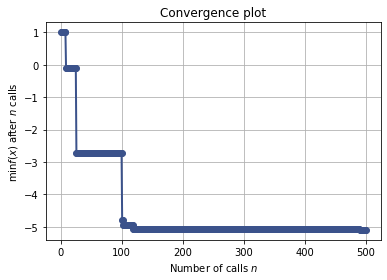

In [21]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)
print("Best parameters: \
\n jet_time_cuts = [{}] \
\n jet_tmf_cuts = [{}] \
\n jet_delta_r_cuts = [{}]\
 \n jet_chef_cuts = [{}]".format(res_gp.x[0],
                                 res_gp.x[1],
                                 res_gp.x[2],
                                 res_gp.x[3]))

## twin higgs tagger plot

W(lv)Jets, background 0 0.0
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 137 25.92342938432921
total 86818444.37032938 947041.4289857871
0 228.12174636310374 86818444.37032938
1 163.4077839584279 2541329.9994170666
2 25.92342938432921 0.0
0.7180584537987124 0 0.22730596046930718 1.0170677508267003 5.589811871383239 1
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


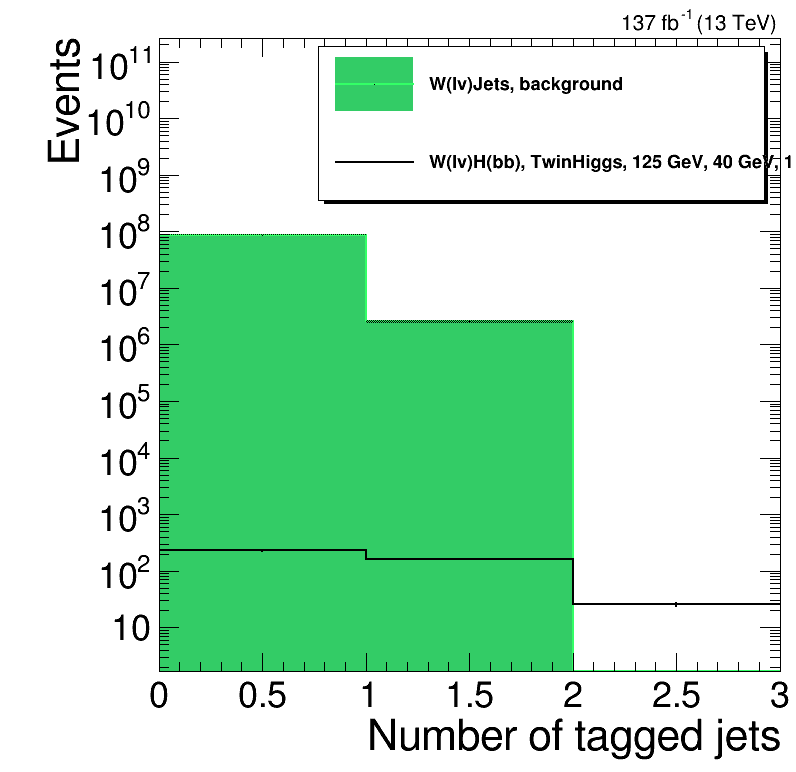

In [36]:
# loop over all the cuts and save the efficiency for each cut and a list for cuts
plotting = True

#signal>5
time_cuts = [0] 
tmf_et_cuts = [0.7180584537987124] 
delta_r_cuts = [0.22730596046930718]
chef_cuts = [1.0170677508267003]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in pf_jet_tmf_et.items():
            
                    tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)

                    nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
                    for i,ele in enumerate(nTags[k]):
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.74,0.96,0.94)

                    leg.SetTextSize(0.025)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['W(lv)Jets, background']
                    sig_keys = [run_sig_key]
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = weight[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*1000)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = weight[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
    #                     print(k,1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h[run_sig_key].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print(tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
    #                 c.SaveAs("../plots/ntags_optimization/mindeltaRcut"+str(mindeltaR_cut)+"_timecut"+str(time_cut)+"gammacut"+str(gamma_cut)+".pdf")

## twin higgs validation

W(lv)Jets, background 0 0.0
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 0.0
total 89359774.36974645 960802.246403938
0 417.45295970586085 89359774.36974645
1 0.0 0.0
2 0.0 0.0
0.7180584537987124 0 0.22730596046930718 0.0 1.3804494912475833 0
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 43 8.136550828658073
total 88998203.02836597 958856.4565506774
0 308.27180091200717 88998203.02836597
1 101.04460796519561 361571.34138047695
2 8.136550828658073 0.0
0.7180584537987124 0 0.22730596046930718 0.1 3.0897084184721066 1
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 65 12.299437299134297
total 88543656.19920194 956404.7042764033
0 281.48238203011715 88543656.19920194
1 123.6711403766094 816118.1705445051
2 12.299437299134297 0.0
0.7180584537987124 0 0.22730596046930718 0.2 3.925401676616708 1
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 90 17.02999010

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replac

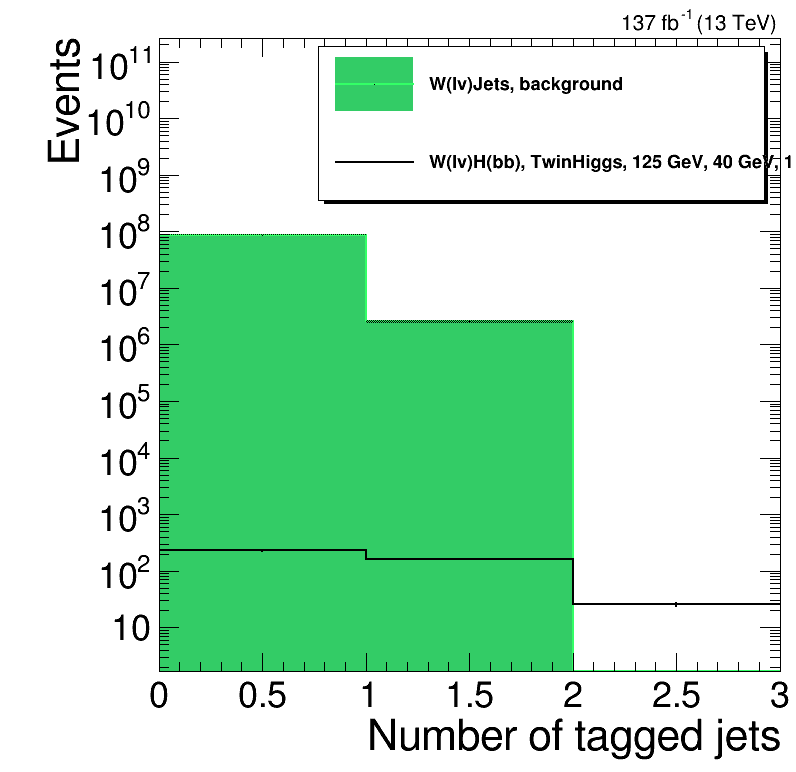

In [48]:
# for validation
plotting = True

time_cuts = [0] 
tmf_et_cuts = [0.7180584537987124] 
delta_r_cuts = [0.22730596046930718]
chef_cuts = [1.0170677508267003]

cut_variable = 4
# 1 = time,   2= tmf, 3=deltaR, 4 = chef 
if cut_variable == 1:#time
    time_cuts = list(np.array(range(10))/2.0)
    time_cuts.sort() 
elif cut_variable == 2:#gamma
    tmf_et_cuts = list(np.array(range(16))/10.0)
elif cut_variable == 3:#deltaR
    delta_r_cuts = list(np.array(range(16))/10.0)+ [0.22,0.24]
    delta_r_cuts.sort()
else:
    chef_cuts = list(np.array(range(16))/10.0)
    chef_cuts.sort()


# time_cuts = np.array(time_cuts)
# tmf_et_cuts = np.array(tmf_et_cuts)
# delta_r_cuts = np.array(delta_r_cuts)
# chef_cuts = np.array(chef_cuts)

validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in pf_jet_tmf_et.items():
            
                    tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)

                    nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
                    for i,ele in enumerate(nTags[k]):
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.74,0.96,0.94)

                    leg.SetTextSize(0.025)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['W(lv)Jets, background']
                    sig_keys = [run_sig_key]
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = weight[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*1000)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = weight[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
    #                     print(k,1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h[run_sig_key].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print(tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
    #                 c.SaveAs("../plots/ntags_optimization/mindeltaRcut"+str(mindeltaR_cut)+"_timecut"+str(time_cut)+"gammacut"+str(gamma_cut)+".pdf")

137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


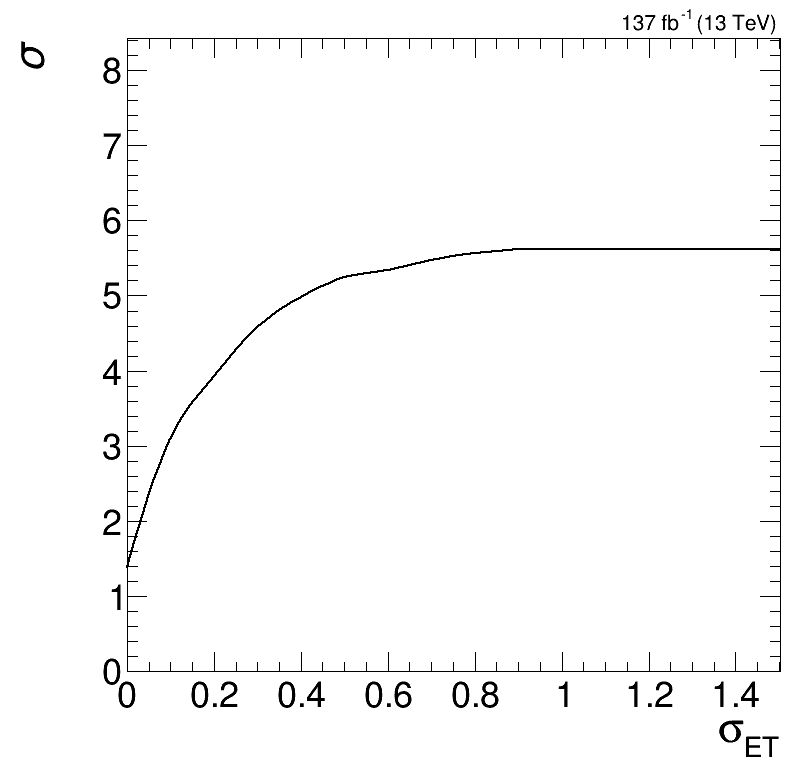

In [49]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

gr = {}


time_cuts = np.array(time_cuts)
tmf_et_cuts = np.array(tmf_et_cuts)
delta_r_cuts = np.array(delta_r_cuts)
chef_cuts = np.array(chef_cuts)
significance = np.array(significance)

# 1 = time,   2= tmf, 3=deltaR, 4 = chef 
# time_cuts = [0] 
# tmf_et_cuts = [0.7180584537987124] 
# delta_r_cuts = [0.22730596046930718]
# chef_cuts = [1.0170677508267003]

if cut_variable == 1:
    gr['good'] = create_TGraph(time_cuts[validity],significance[validity],axis_title = ['jet time [ns]','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(time_cuts,significance,axis_title = ['jet time [ns]','\sigma'])
    x_max = np.max(time_cuts)
elif cut_variable == 2:
    gr['good'] = create_TGraph(tmf_et_cuts[validity],significance[validity],axis_title = ['TMF_{ET MAX}','\sigma'])
    gr['all'] = create_TGraph(tmf_et_cuts,significance,axis_title = ['TMF_{ET MAX}','\sigma'])
    x_max = np.max(tmf_et_cuts)
elif cut_variable == 3:
    gr['good'] = create_TGraph(delta_r_cuts[validity],significance[validity],axis_title = ['#Delta R_{min}','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(delta_r_cuts,significance,axis_title = ['#Delta R_{min}','\sigma'])
    x_max = np.max(delta_r_cuts)    
else:
    gr['good'] = create_TGraph(chef_cuts[validity],significance[validity],axis_title = ['CHEF','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(chef_cuts,significance,axis_title = ['#sigma_{ET}','\sigma'])
    x_max = np.max(chef_cuts)
    

    
gr['all'].SetLineWidth(2)
gr['all'].SetLineColor(1)
gr['all'].GetXaxis().SetRangeUser(0,x_max)
gr['all'].GetYaxis().SetRangeUser(0,1.5*np.max(significance))
# leg.AddEntry(gr['all'],"Has > 5 signal events")
gr['all'].Draw('ac')

    
 
leg.Draw()
    
 

CMS_lumi.lumi_13TeV = "137 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


 
c.Draw()


## optimization of C1N2 200_1

In [21]:
import time

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

sig_bins = [0,1,2]



space = [Real(0,5, name='jet_time'),
          Real(0.0,1.5, name='jet_tmf'),
          Real(0.0,1.5,name='jetMinDeltaRPVTracks'),
          Real(0.0,1.5,name = 'jet_chef')
          ]

def figure_of_merit(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50, chef_cut = -50):
    nTags = {}
    sig_count = [] 
    bkg_count = np.zeros((3,))
    
    for k,T in pf_jet_tmf_et.items():
#         start_t = time.time()
        nTags[k] = []
        tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
        tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
        tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)
#         nTags[k] = [len(x) for x in pf_jet_pt[k][tagged_jet]] #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.array(nTags[k])
        nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.sum(w[tagged_jet])
#         nJets[k] = np.sum(w[w<8000000])
#         print(k, nTags[k][:10])
        print(k, np.unique(nTags[k]))
        nTags[k] = np.array(nTags[k])
            
        occurCount = []
        for i in sig_bins:
            if i == 2:
#               #overflow bin
                tag_cut = nTags[k] >= i 
            else:
                tag_cut = nTags[k] == i
            w_sum = sum(weight[k][tag_cut])
            occurCount.append(w_sum)
        print(occurCount)
        occurCount = np.array(occurCount)
        
        if run_sig in k :
            sig_count = list(occurCount[:2])
            sig_count.append(sum(occurCount[2:]))
            sig_count = np.array(sig_count)
        elif 'background' in k:
            bkg_count = bkg_count + occurCount

#     cond = np.logical_not(np.logical_or(sig_count < 5,bkg_count < 5))
    sig_count = sig_count
    bkg_count = bkg_count
    print("sig count", sig_count)
    print("bkg count", bkg_count)
    cond = sig_count > 5
    if not np.count_nonzero(cond) == len(sig_bins):
        return 1

#     return -1.0*np.sum(2*((s+b)*math.log(s/b+1)-s))**0.5

    # loss function: - significance  = - (sqrt(S/(S+B)))
    return -1.0 * np.sum(sig_count**2/(sig_count+bkg_count))**0.5

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
#     begt = time.time()
    fom = figure_of_merit(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'],chef_cut = X['jet_chef'])
#     fom = train(model, learning_rate=X['learning_rate'])
    return fom


# res_gp = gp_minimize(objective, space, n_calls=5, n_random_starts=1, random_state=123, verbose=True)
res_gp = gp_minimize(objective, space, n_calls=500, n_random_starts=100, random_state=123, verbose=True)


Iteration No: 1 started. Evaluating function at random point.
New configuration: {'jet_time': 3.5647766026161367, 'jet_tmf': 0.6427063892802387, 'jetMinDeltaRPVTracks': 1.0363272825402927, 'jet_chef': 1.0787254652321598}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3539.8650751513196, 18.49183248213376, 1.3208451772952685]
sig count [3.53986508e+03 1.84918325e+01 1.32084518e+00]
bkg count [89359774.36974645        0.                0.        ]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0343
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
New configuration: {'jet_time': 2.4555946671629867, 'jet_tmf': 1.170041642868119, 'jetMinDeltaRPVTracks': 0.6163865590635286, 'jet_chef': 0.8695414455339153}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3502.881410187052, 54.15465226910601, 2.64169035

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 3.0291
Function value obtained: -13.8914
Current minimum: -15.2076
Iteration No: 102 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.4813584887085605, 'jet_tmf': 0.47825418238195383, 'jetMinDeltaRPVTracks': 0.7356609317207501, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
sig count [3559.67775281    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 2.9393
Function value obtained: 1.0000
Current minimum: -15.2076
Iteration No: 103 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5766313478856095, 'jet_tmf': 0.5492137393560261, 'jetMinDeltaRPVTracks': 0.6735270857943898, 'jet_chef': 0.38768281832037166}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 215.29776389912877, 10.566761418362148]
sig count [3333.81322749  215.2977639    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.8729
Function value obtained: -15.0329
Current minimum: -15.2076
Iteration No: 104 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34819091121513157, 'jet_tmf': 0.13615744377396727, 'jetMinDeltaRPVTracks': 1.2561807673396461, 'jet_chef': 0.4269470011457135}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 3.1375
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 105 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34349870922022413, 'jet_tmf': 0.7823554084148208, 'jetMinDeltaRPVTracks': 1.2559207485239854, 'jet_chef': 0.2923021678522506}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 3.2140
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 106 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34703934410719056, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.2593788816947584, 'jet_chef': 0.3353189168367041}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 3.1391
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 107 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7784984608361455, 'jet_tmf': 0.772193870362728, 'jetMinDeltaRPVTracks': 0.6941623249440014, 'jet_chef': 0.8436400751782813}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3350.984214798096, 202.08931212617608, 6.604225886476343]
sig count [3350.9842148   202.08931213    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.8473
Function value obtained: -14.4506
Current minimum: -15.2076
Iteration No: 108 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.549376124829438, 'jet_tmf': 1.3337381646626698, 'jetMinDeltaRPVTracks': 0.6642116501515932, 'jet_chef': 0.5994226179394422}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3316.6422401884192, 232.46875120396726, 10.566761418362148]
sig count [3316.64224019  232.4687512    10.56676142]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.7957
Function value obtained: -3.9757
Current minimum: -15.2076
Iteration No: 109 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6329697923424509, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.6940390700067454, 'jet_chef': 0.19602023195469126}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
sig count [3559.67775281    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.6795
Function value obtained: 1.0000
Current minimum: -15.2076
Iteration No: 110 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5123681616563085, 'jet_tmf': 0.41273403268537145, 'jetMinDeltaRPVTracks': 1.2616457317008267, 'jet_chef': 0.3478779129264033}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3343.0591437343246, 207.37269283535716, 9.24591624106688]
sig count [3343.05914373  207.37269284    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.8807
Function value obtained: -14.7222
Current minimum: -15.2076
Iteration No: 111 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5987273159716232, 'jet_tmf': 0.6195866852651218, 'jetMinDeltaRPVTracks': 0.6717216491769724, 'jet_chef': 0.38299381053573656}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 215.29776389912877, 10.566761418362148]
sig count [3333.81322749  215.2977639    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.6712
Function value obtained: -15.0329
Current minimum: -15.2076
Iteration No: 112 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6186635904345374, 'jet_tmf': 0.689472848230664, 'jetMinDeltaRPVTracks': 0.6694240910403526, 'jet_chef': 0.3536206504126052}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 3.1322
Function value obtained: -14.9889
Current minimum: -15.2076
Iteration No: 113 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35805746694707496, 'jet_tmf': 1.4786300642385126, 'jetMinDeltaRPVTracks': 1.253981670809969, 'jet_chef': 0.3378454265578559}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.9346
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 114 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3573360489408131, 'jet_tmf': 0.7730935590982595, 'jetMinDeltaRPVTracks': 1.252229101834743, 'jet_chef': 0.30320879408030965}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.8084
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 115 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5747202047562127, 'jet_tmf': 0.7812121849897784, 'jetMinDeltaRPVTracks': 0.6659909447534336, 'jet_chef': 0.22688606495844188}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.7517
Function value obtained: -15.0768
Current minimum: -15.2076
Iteration No: 116 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3559061100837706, 'jet_tmf': 0.19311541810484423, 'jetMinDeltaRPVTracks': 1.2563215675644799, 'jet_chef': 0.4215450925663623}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.7303
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 117 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8197983302318373, 'jet_tmf': 0.6061163297406209, 'jetMinDeltaRPVTracks': 0.6844991696985891, 'jet_chef': 0.8834109459769062}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3353.6259051526868, 199.44762177158555, 6.604225886476343]
sig count [3353.62590515  199.44762177    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.7657
Function value obtained: -14.3589
Current minimum: -15.2076
Iteration No: 118 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.604713034846973, 'jet_tmf': 1.0793000019585177, 'jetMinDeltaRPVTracks': 0.6584434933198404, 'jet_chef': 0.07522251090366577}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3350.984214798096, 200.7684669488808, 7.925071063771611]
sig count [3350.9842148   200.76846695    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.8852
Function value obtained: -14.4506
Current minimum: -15.2076
Iteration No: 119 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3425446880932062, 'jet_tmf': 0.17189349588369118, 'jetMinDeltaRPVTracks': 1.2589247955230198, 'jet_chef': 0.41370424638893233}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.8607
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 120 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3560396373901797, 'jet_tmf': 0.7480519152433067, 'jetMinDeltaRPVTracks': 1.2573379125110289, 'jet_chef': 0.29089210174129504}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.7965
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 121 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34252361958909405, 'jet_tmf': 0.17055630440288957, 'jetMinDeltaRPVTracks': 1.25503714526563, 'jet_chef': 0.43721071429945435}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 3.0462
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 122 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3516897651296156, 'jet_tmf': 1.4684854467634527, 'jetMinDeltaRPVTracks': 1.257133546021401, 'jet_chef': 0.3305979778221939}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 3.1210
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 123 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5839683248616587, 'jet_tmf': 0.504862323632024, 'jetMinDeltaRPVTracks': 1.188929238776205, 'jet_chef': 0.8726638461559733}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3348.3425244435057, 203.41015730347135, 7.925071063771611]
sig count [3348.34252444  203.4101573     7.92507106]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.8978
Function value obtained: -3.4610
Current minimum: -15.2076
Iteration No: 124 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5479559361227215, 'jet_tmf': 0.6195942837246677, 'jetMinDeltaRPVTracks': 0.6638725563551158, 'jet_chef': 0.23544567457643661}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.8981
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 125 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8560584717737809, 'jet_tmf': 0.7458450780685679, 'jetMinDeltaRPVTracks': 0.9387826048303805, 'jet_chef': 0.44191886110133916}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3368.1552021029347, 186.23916999863286, 5.283380709181074]
sig count [3368.1552021   186.23917       5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 3.4233
Function value obtained: -13.8438
Current minimum: -15.2076
Iteration No: 126 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5969808698189426, 'jet_tmf': 0.5680710949728991, 'jetMinDeltaRPVTracks': 1.1517375069267604, 'jet_chef': 1.1800223692469043}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3348.3425244435057, 203.41015730347135, 7.925071063771611]
sig count [3348.34252444  203.4101573     7.92507106]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.9163
Function value obtained: -3.4610
Current minimum: -15.2076
Iteration No: 127 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6638997606476682, 'jet_tmf': 0.6180894606417989, 'jetMinDeltaRPVTracks': 1.1644976300421646, 'jet_chef': 1.0885155340684918}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3357.5884406845726, 194.16424106240447, 7.925071063771611]
sig count [3357.58844068  194.16424106    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 3.0910
Function value obtained: -14.2202
Current minimum: -15.2076
Iteration No: 128 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8364689583674024, 'jet_tmf': 0.028822886989388, 'jetMinDeltaRPVTracks': 0.6625436473202232, 'jet_chef': 1.0814946894782873}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3347.0216792662104, 206.0518476580619, 6.604225886476343]
sig count [3347.02167927  206.05184766    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 3.1337
Function value obtained: -14.5870
Current minimum: -15.2076
Iteration No: 129 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35042923907238066, 'jet_tmf': 0.7872241680762233, 'jetMinDeltaRPVTracks': 1.2540171974421181, 'jet_chef': 0.40861546379886304}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 3.1436
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 130 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5422166795386548, 'jet_tmf': 1.3248295694403522, 'jetMinDeltaRPVTracks': 0.6621874500823002, 'jet_chef': 0.21227825174682924}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 3.2057
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 131 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6073727009947074, 'jet_tmf': 1.0072558399601153, 'jetMinDeltaRPVTracks': 0.6715357441977182, 'jet_chef': 0.3448458785446663}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3336.4549178478483, 213.9769187218335, 9.24591624106688]
sig count [3336.45491785  213.97691872    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 3.6432
Function value obtained: -14.9448
Current minimum: -15.2076
Iteration No: 132 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6384826490326133, 'jet_tmf': 1.070690330413247, 'jetMinDeltaRPVTracks': 1.3241018246684568, 'jet_chef': 0.31791315038887297}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3352.3050599753915, 199.44762177158555, 7.925071063771611]
sig count [3352.30505998  199.44762177    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 3.3368
Function value obtained: -14.4048
Current minimum: -15.2076
Iteration No: 133 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36843447251868855, 'jet_tmf': 0.015532288898237231, 'jetMinDeltaRPVTracks': 1.2529636814820109, 'jet_chef': 0.31782050689579305}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 3.5380
Function value obtained: -15.1641
Current minimum: -15.2076
Iteration No: 134 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35157763466518616, 'jet_tmf': 1.1939318027382226, 'jetMinDeltaRPVTracks': 1.2520666851940232, 'jet_chef': 0.2990231793805498}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 3.4100
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 135 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3458463393412189, 'jet_tmf': 1.4126250368239588, 'jetMinDeltaRPVTracks': 1.2569719762504301, 'jet_chef': 0.29031371319321086}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 3.4287
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 136 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.31679589824406335, 'jet_tmf': 0.31724947823555416, 'jetMinDeltaRPVTracks': 1.255465238146495, 'jet_chef': 0.3965080771753289}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3325.888156429486, 223.22283496290038, 10.566761418362148]
sig count [3325.88815643  223.22283496   10.56676142]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 3.5264
Function value obtained: -3.9258
Current minimum: -15.2076
Iteration No: 137 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6169362497550501, 'jet_tmf': 0.6051459464599778, 'jetMinDeltaRPVTracks': 0.6655951225697514, 'jet_chef': 0.37308466123805273}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 217.9394542537193, 9.24591624106688]
sig count [3332.49238232  217.93945425    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 3.3648
Function value obtained: -15.0768
Current minimum: -15.2076
Iteration No: 138 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5480220395876276, 'jet_tmf': 0.32451992190158485, 'jetMinDeltaRPVTracks': 0.6639716519859915, 'jet_chef': 0.21636968145124297}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 3.5281
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 139 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7956792439709598, 'jet_tmf': 0.35044315009667976, 'jetMinDeltaRPVTracks': 0.6724193862470274, 'jet_chef': 0.9775521749921479}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3348.3425244435057, 204.73100248076662, 6.604225886476343]
sig count [3348.34252444  204.73100248    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 3.5873
Function value obtained: -14.5417
Current minimum: -15.2076
Iteration No: 140 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5969527795788241, 'jet_tmf': 1.1555124739235878, 'jetMinDeltaRPVTracks': 0.6550963657604193, 'jet_chef': 0.05817973215542538}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3368.1552021029347, 183.59747964404232, 7.925071063771611]
sig count [3368.1552021   183.59747964    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 3.2932
Function value obtained: -13.8438
Current minimum: -15.2076
Iteration No: 141 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36182772743417635, 'jet_tmf': 1.4283471644907715, 'jetMinDeltaRPVTracks': 1.255402315619769, 'jet_chef': 0.37906451094789406}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 3.7317
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 142 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6108262538956652, 'jet_tmf': 1.372385646735207, 'jetMinDeltaRPVTracks': 0.6604570260539337, 'jet_chef': 0.21737178576011917}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 216.61860907642404, 9.24591624106688]
sig count [3333.81322749  216.61860908    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 3.5970
Function value obtained: -15.0329
Current minimum: -15.2076
Iteration No: 143 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5786948167590432, 'jet_tmf': 1.4692874418853104, 'jetMinDeltaRPVTracks': 0.6517146208396594, 'jet_chef': 0.18300659468903674}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.5703
Function value obtained: -14.9889
Current minimum: -15.2076
Iteration No: 144 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5457061538958463, 'jet_tmf': 1.4707496265869495, 'jetMinDeltaRPVTracks': 0.663197112549648, 'jet_chef': 0.21612937668739224}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.4562
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 145 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3442786921127988, 'jet_tmf': 0.3336431460512631, 'jetMinDeltaRPVTracks': 1.2567194056151838, 'jet_chef': 0.35599457972867177}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 3.5848
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 146 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34664614537818556, 'jet_tmf': 0.040543419321011666, 'jetMinDeltaRPVTracks': 1.255243959536934, 'jet_chef': 0.2948673622638699}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.6291
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 147 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5782952045044145, 'jet_tmf': 0.5254957735129044, 'jetMinDeltaRPVTracks': 0.672508149273991, 'jet_chef': 0.332144024740858}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 3.6969
Function value obtained: -14.9889
Current minimum: -15.2076
Iteration No: 148 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34381969356834474, 'jet_tmf': 1.2901314648039581, 'jetMinDeltaRPVTracks': 1.256565978282468, 'jet_chef': 0.4302540926251129}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 3.6731
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 149 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35564637571538704, 'jet_tmf': 0.8187443867899475, 'jetMinDeltaRPVTracks': 1.2575685469636335, 'jet_chef': 0.3272661246243314}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.8883
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 150 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3443433146967759, 'jet_tmf': 1.1721861463701302, 'jetMinDeltaRPVTracks': 1.2585424472923195, 'jet_chef': 0.31786827315458804}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.7697
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 151 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8201661680587491, 'jet_tmf': 1.3856519360780424, 'jetMinDeltaRPVTracks': 0.6586520484419882, 'jet_chef': 0.9436841862653325}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3344.37998891162, 208.69353801265243, 6.604225886476343]
sig count [3344.37998891  208.69353801    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 3.9253
Function value obtained: -14.6773
Current minimum: -15.2076
Iteration No: 152 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3504791778109878, 'jet_tmf': 0.38207067688078833, 'jetMinDeltaRPVTracks': 1.2542231582193328, 'jet_chef': 0.44592358859237957}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 3.8919
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 153 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.350887611602657, 'jet_tmf': 0.9038452963326751, 'jetMinDeltaRPVTracks': 1.261007948268133, 'jet_chef': 0.31604287940130754}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 3.9641
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 154 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6064757544110516, 'jet_tmf': 0.9868129563922053, 'jetMinDeltaRPVTracks': 0.6591871184519945, 'jet_chef': 0.20456340480436547}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 3.8913
Function value obtained: -14.9889
Current minimum: -15.2076
Iteration No: 155 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5013871909207022, 'jet_tmf': 0.35303890004129157, 'jetMinDeltaRPVTracks': 1.2696868976734377, 'jet_chef': 0.3039877998327801}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3340.417453379734, 210.0143831899477, 9.24591624106688]
sig count [3340.41745338  210.01438319    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 4.3405
Function value obtained: -14.8117
Current minimum: -15.2076
Iteration No: 156 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35141475549016093, 'jet_tmf': 1.1891946592543265, 'jetMinDeltaRPVTracks': 1.2509401144249706, 'jet_chef': 0.25209059722607396}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 4.3293
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 157 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3618916473597608, 'jet_tmf': 1.4471283685824983, 'jetMinDeltaRPVTracks': 1.2561260985578941, 'jet_chef': 0.31157174801150855}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 4.1113
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 158 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7775840864948637, 'jet_tmf': 1.018782089223453, 'jetMinDeltaRPVTracks': 0.6688534601257844, 'jet_chef': 0.8567948851027114}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3345.700834088915, 207.37269283535716, 6.604225886476343]
sig count [3345.70083409  207.37269284    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 4.0652
Function value obtained: -14.6322
Current minimum: -15.2076
Iteration No: 159 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8366743952925547, 'jet_tmf': 1.0244606692463747, 'jetMinDeltaRPVTracks': 1.3259556333504698, 'jet_chef': 0.29829669023823335}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3368.1552021029347, 186.23916999863286, 5.283380709181074]
sig count [3368.1552021   186.23917       5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 4.2691
Function value obtained: -13.8438
Current minimum: -15.2076
Iteration No: 160 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3582708305903007, 'jet_tmf': 0.03975899727685012, 'jetMinDeltaRPVTracks': 1.2530463613096923, 'jet_chef': 0.2429646138980998}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 4.1641
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 161 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36006326465596905, 'jet_tmf': 0.9423657475411533, 'jetMinDeltaRPVTracks': 1.2581824260937484, 'jet_chef': 0.23731430044175866}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 4.4174
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 162 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3529853996694594, 'jet_tmf': 0.5459361226117053, 'jetMinDeltaRPVTracks': 1.2579146634530471, 'jet_chef': 0.39850394184381466}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 4.4547
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 163 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6336564097392182, 'jet_tmf': 1.3588108402889192, 'jetMinDeltaRPVTracks': 1.3762790341573719, 'jet_chef': 0.38623580364487864}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3352.3050599753915, 199.44762177158555, 7.925071063771611]
sig count [3352.30505998  199.44762177    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 4.4752
Function value obtained: -14.4048
Current minimum: -15.2076
Iteration No: 164 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6131854505657068, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.6784406201409862, 'jet_chef': 0.31653219245388897}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3337.7757630251435, 212.65607354453823, 9.24591624106688]
sig count [3337.77576303  212.65607354    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.5011
Function value obtained: -14.9006
Current minimum: -15.2076
Iteration No: 165 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6111084914141872, 'jet_tmf': 1.2789666863426, 'jetMinDeltaRPVTracks': 0.6225224655150462, 'jet_chef': 0.25029794440796266}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 220.58114460830984, 9.24591624106688]
sig count [3329.85069196  220.58114461    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 4.4212
Function value obtained: -15.1641
Current minimum: -15.2076
Iteration No: 166 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7045143587366164, 'jet_tmf': 1.1388560792164295, 'jetMinDeltaRPVTracks': 0.9998957920386387, 'jet_chef': 0.5775735055888663}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3357.5884406845726, 196.805931416995, 5.283380709181074]
sig count [3357.58844068  196.80593142    5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 4.4116
Function value obtained: -14.2202
Current minimum: -15.2076
Iteration No: 167 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5614230282819014, 'jet_tmf': 0.6123614373695024, 'jetMinDeltaRPVTracks': 0.6762360687460294, 'jet_chef': 0.24986153974562036}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 4.5860
Function value obtained: -15.0768
Current minimum: -15.2076
Iteration No: 168 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.653710452451316, 'jet_tmf': 0.5013723814014532, 'jetMinDeltaRPVTracks': 1.0716440322100784, 'jet_chef': 0.8528141315027447}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3357.5884406845726, 194.16424106240447, 7.925071063771611]
sig count [3357.58844068  194.16424106    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 4.8209
Function value obtained: -14.2202
Current minimum: -15.2076
Iteration No: 169 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5527403102908847, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.650065007929533, 'jet_chef': 0.24980274036858757}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
sig count [3559.67775281    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 4.7340
Function value obtained: 1.0000
Current minimum: -15.2076
Iteration No: 170 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3623042216173577, 'jet_tmf': 1.0430111242285502, 'jetMinDeltaRPVTracks': 1.2539012350112553, 'jet_chef': 0.3394952073974611}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 4.6626
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 171 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5378147832070387, 'jet_tmf': 0.7170351256239265, 'jetMinDeltaRPVTracks': 0.6630758535847072, 'jet_chef': 0.20764827727671484}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 4.8491
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 172 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6146608213501018, 'jet_tmf': 0.725922775590048, 'jetMinDeltaRPVTracks': 0.6224514869826953, 'jet_chef': 0.2589976629097261}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 220.58114460830984, 9.24591624106688]
sig count [3329.85069196  220.58114461    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 4.6892
Function value obtained: -15.1641
Current minimum: -15.2076
Iteration No: 173 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6125027682330925, 'jet_tmf': 0.6758647045040891, 'jetMinDeltaRPVTracks': 0.6209787036016192, 'jet_chef': 0.23757563673088292}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 221.9019897856051, 9.24591624106688]
sig count [3328.52984678  221.90198979    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 4.9946
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 174 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6007005930094785, 'jet_tmf': 0.40946768134873585, 'jetMinDeltaRPVTracks': 0.6763462863733511, 'jet_chef': 0.38791776633605074}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 215.29776389912877, 10.566761418362148]
sig count [3333.81322749  215.2977639    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 4.8333
Function value obtained: -15.0329
Current minimum: -15.2076
Iteration No: 175 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5818565418025528, 'jet_tmf': 0.8838344681857039, 'jetMinDeltaRPVTracks': 0.6526506523356953, 'jet_chef': 0.1840220190438496}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 5.1531
Function value obtained: -14.9889
Current minimum: -15.2076
Iteration No: 176 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5455172319607331, 'jet_tmf': 1.385138720098911, 'jetMinDeltaRPVTracks': 0.6630289038713053, 'jet_chef': 0.10729715688948177}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3339.096608202439, 210.0143831899477, 10.566761418362148]
sig count [3339.0966082   210.01438319   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 5.0216
Function value obtained: -14.8562
Current minimum: -15.2076
Iteration No: 177 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3516703196121673, 'jet_tmf': 0.9835698916208913, 'jetMinDeltaRPVTracks': 1.2596300349157488, 'jet_chef': 0.29196786387897683}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 5.3343
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 178 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3447050499463433, 'jet_tmf': 0.5231277767565095, 'jetMinDeltaRPVTracks': 1.2552096627478004, 'jet_chef': 0.4398494117121356}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 5.2967
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 179 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3534394127866054, 'jet_tmf': 0.24767224889871264, 'jetMinDeltaRPVTracks': 1.251408077305555, 'jet_chef': 0.2453341822546435}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 5.3338
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 180 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35852334398464103, 'jet_tmf': 0.16895934470189175, 'jetMinDeltaRPVTracks': 1.2559481794321465, 'jet_chef': 0.19675456892533116}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 5.2328
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 181 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5575171153838748, 'jet_tmf': 1.0723866820392765, 'jetMinDeltaRPVTracks': 0.6656925428070546, 'jet_chef': 0.24323554032928957}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 5.4890
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 182 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6130028963746195, 'jet_tmf': 0.4309054115305192, 'jetMinDeltaRPVTracks': 0.6212404829931344, 'jet_chef': 0.21074469951058888}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 220.58114460830984, 9.24591624106688]
sig count [3329.85069196  220.58114461    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 5.4708
Function value obtained: -15.1641
Current minimum: -15.2076
Iteration No: 183 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35088866758054016, 'jet_tmf': 0.06110297324228137, 'jetMinDeltaRPVTracks': 1.2519397766997378, 'jet_chef': 0.38123390227293946}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 5.3105
Function value obtained: -15.2076
Current minimum: -15.2076
Iteration No: 184 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3666195190957553, 'jet_tmf': 0.21750770827240934, 'jetMinDeltaRPVTracks': 1.2561868650097356, 'jet_chef': 0.18630976260954432}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3331.171537138667, 217.9394542537193, 10.566761418362148]
sig count [3331.17153714  217.93945425   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 5.3156
Function value obtained: -15.1205
Current minimum: -15.2076
Iteration No: 185 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5811617373463195, 'jet_tmf': 0.8828690994451567, 'jetMinDeltaRPVTracks': 0.6507638834420085, 'jet_chef': 0.12750499604758064}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3340.417453379734, 208.69353801265243, 10.566761418362148]
sig count [3340.41745338  208.69353801   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 5.5075
Function value obtained: -14.8117
Current minimum: -15.2076
Iteration No: 186 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5953964738785155, 'jet_tmf': 0.34317998159839536, 'jetMinDeltaRPVTracks': 0.6479128062046381, 'jet_chef': 0.2193822547983471}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 221.9019897856051, 10.566761418362148]
sig count [3327.20900161  221.90198979   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 5.4559
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 187 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8111525617836242, 'jet_tmf': 0.21018944834328168, 'jetMinDeltaRPVTracks': 0.6646969463904937, 'jet_chef': 0.9473425943035889}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3345.700834088915, 207.37269283535716, 6.604225886476343]
sig count [3345.70083409  207.37269284    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 5.7951
Function value obtained: -14.6322
Current minimum: -15.2510
Iteration No: 188 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6134808951355439, 'jet_tmf': 0.40526421143949837, 'jetMinDeltaRPVTracks': 0.675697973943298, 'jet_chef': 0.41718459272816966}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 5.7795
Function value obtained: -14.9889
Current minimum: -15.2510
Iteration No: 189 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5952339116988635, 'jet_tmf': 0.8948619505686268, 'jetMinDeltaRPVTracks': 0.6474507787652968, 'jet_chef': 0.22781895920848616}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 221.9019897856051, 10.566761418362148]
sig count [3327.20900161  221.90198979   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 5.9014
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 190 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.49617048445346007, 'jet_tmf': 0.7219858571772537, 'jetMinDeltaRPVTracks': 1.2639307484294804, 'jet_chef': 0.33490072281177086}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3339.096608202439, 211.33522836724296, 9.24591624106688]
sig count [3339.0966082   211.33522837    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 5.7970
Function value obtained: -14.8562
Current minimum: -15.2510
Iteration No: 191 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5955306415261524, 'jet_tmf': 1.4917759184158268, 'jetMinDeltaRPVTracks': 0.6479097086475097, 'jet_chef': 0.2187643655391196}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 221.9019897856051, 10.566761418362148]
sig count [3327.20900161  221.90198979   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 5.8834
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 192 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7909198044786981, 'jet_tmf': 1.4773459947606893, 'jetMinDeltaRPVTracks': 0.686418946606974, 'jet_chef': 0.8395568940308177}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3350.984214798096, 202.08931212617608, 6.604225886476343]
sig count [3350.9842148   202.08931213    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 5.7826
Function value obtained: -14.4506
Current minimum: -15.2510
Iteration No: 193 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8137190137977648, 'jet_tmf': 1.1599587091838783, 'jetMinDeltaRPVTracks': 0.6601113990426033, 'jet_chef': 1.2071310660566021}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3343.0591437343246, 210.0143831899477, 6.604225886476343]
sig count [3343.05914373  210.01438319    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 6.1638
Function value obtained: -14.7222
Current minimum: -15.2510
Iteration No: 194 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3627817927709457, 'jet_tmf': 0.5123733523762408, 'jetMinDeltaRPVTracks': 1.247398671335286, 'jet_chef': 0.34853485697479936}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 5.8681
Function value obtained: -15.2076
Current minimum: -15.2510
Iteration No: 195 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5932257527802784, 'jet_tmf': 0.82448924285713, 'jetMinDeltaRPVTracks': 0.6482064680665564, 'jet_chef': 0.2219976569074416}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 221.9019897856051, 10.566761418362148]
sig count [3327.20900161  221.90198979   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 6.1606
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 196 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.567854416714273, 'jet_tmf': 0.2623759566635189, 'jetMinDeltaRPVTracks': 0.6760258401729183, 'jet_chef': 0.3197427955200468}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 215.29776389912877, 10.566761418362148]
sig count [3333.81322749  215.2977639    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 5.9010
Function value obtained: -15.0329
Current minimum: -15.2510
Iteration No: 197 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35397764515348706, 'jet_tmf': 0.31155578663236233, 'jetMinDeltaRPVTracks': 1.2613332924526481, 'jet_chef': 0.14182157642508306}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 6.1289
Function value obtained: -15.1641
Current minimum: -15.2510
Iteration No: 198 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5994958894665057, 'jet_tmf': 0.4768012996971157, 'jetMinDeltaRPVTracks': 0.6473704021984463, 'jet_chef': 0.26831869692486005}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 221.9019897856051, 10.566761418362148]
sig count [3327.20900161  221.90198979   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 5.8067
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 199 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6352898150368942, 'jet_tmf': 1.4080720511469125, 'jetMinDeltaRPVTracks': 1.3650039497195736, 'jet_chef': 0.37153238947743816}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3352.3050599753915, 199.44762177158555, 7.925071063771611]
sig count [3352.30505998  199.44762177    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 6.0438
Function value obtained: -14.4048
Current minimum: -15.2510
Iteration No: 200 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36087559032141403, 'jet_tmf': 1.3239645574575223, 'jetMinDeltaRPVTracks': 1.2481605311805324, 'jet_chef': 0.24757979524878432}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 6.2194
Function value obtained: -15.2076
Current minimum: -15.2510
Iteration No: 201 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6160341174185329, 'jet_tmf': 1.3578649207660933, 'jetMinDeltaRPVTracks': 0.6537407196838361, 'jet_chef': 0.3154798722446128}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 217.9394542537193, 9.24591624106688]
sig count [3332.49238232  217.93945425    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 6.6019
Function value obtained: -15.0768
Current minimum: -15.2510
Iteration No: 202 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.612491045670547, 'jet_tmf': 0.5721697030270321, 'jetMinDeltaRPVTracks': 0.6191246804097321, 'jet_chef': 0.2936079976189592}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 223.22283496290038, 9.24591624106688]
sig count [3327.20900161  223.22283496    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 6.2518
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 203 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36480987192734615, 'jet_tmf': 1.0742977034509134, 'jetMinDeltaRPVTracks': 1.2502074564554015, 'jet_chef': 0.4718143956673923}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 6.5311
Function value obtained: -15.1641
Current minimum: -15.2510
Iteration No: 204 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6389759870222934, 'jet_tmf': 1.2243158573144373, 'jetMinDeltaRPVTracks': 1.3364811448655616, 'jet_chef': 0.3346202881465724}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3353.6259051526868, 198.12677659429028, 7.925071063771611]
sig count [3353.62590515  198.12677659    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 6.5021
Function value obtained: -14.3589
Current minimum: -15.2510
Iteration No: 205 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7961433575512784, 'jet_tmf': 1.0429255293914785, 'jetMinDeltaRPVTracks': 0.6931502313608436, 'jet_chef': 1.1331392720531468}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3353.6259051526868, 199.44762177158555, 6.604225886476343]
sig count [3353.62590515  199.44762177    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 6.6536
Function value obtained: -14.3589
Current minimum: -15.2510
Iteration No: 206 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7739361528002321, 'jet_tmf': 1.4389076800563254, 'jetMinDeltaRPVTracks': 0.6698679225046247, 'jet_chef': 1.1829746687657023}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3345.700834088915, 207.37269283535716, 6.604225886476343]
sig count [3345.70083409  207.37269284    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 6.5720
Function value obtained: -14.6322
Current minimum: -15.2510
Iteration No: 207 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7053881245796024, 'jet_tmf': 0.390482261566646, 'jetMinDeltaRPVTracks': 0.9534479078988869, 'jet_chef': 0.5043539815313806}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3356.2675955072773, 198.12677659429028, 5.283380709181074]
sig count [3356.26759551  198.12677659    5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 6.7733
Function value obtained: -14.2666
Current minimum: -15.2510
Iteration No: 208 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6601313518570666, 'jet_tmf': 0.7698186675932968, 'jetMinDeltaRPVTracks': 1.156166517126989, 'jet_chef': 1.1486072885291985}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3357.5884406845726, 194.16424106240447, 7.925071063771611]
sig count [3357.58844068  194.16424106    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 6.7784
Function value obtained: -14.2202
Current minimum: -15.2510
Iteration No: 209 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6017320909854663, 'jet_tmf': 0.18901312784744068, 'jetMinDeltaRPVTracks': 0.6467676484199043, 'jet_chef': 0.26155902447885}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 221.9019897856051, 10.566761418362148]
sig count [3327.20900161  221.90198979   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 6.7915
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 210 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7042968550110955, 'jet_tmf': 0.45264680609626945, 'jetMinDeltaRPVTracks': 0.9852376036461099, 'jet_chef': 0.555721010453528}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3356.2675955072773, 198.12677659429028, 5.283380709181074]
sig count [3356.26759551  198.12677659    5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 6.7050
Function value obtained: -14.2666
Current minimum: -15.2510
Iteration No: 211 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5035429748827968, 'jet_tmf': 0.28041396519515016, 'jetMinDeltaRPVTracks': 1.2645042380083273, 'jet_chef': 0.1253148154370919}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3343.0591437343246, 207.37269283535716, 9.24591624106688]
sig count [3343.05914373  207.37269284    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 7.6166
Function value obtained: -14.7222
Current minimum: -15.2510
Iteration No: 212 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.408153149044905, 'jet_tmf': 1.391150907595461, 'jetMinDeltaRPVTracks': 0.012018753419086809, 'jet_chef': 0.2415497950966387}
W(lv)Jets, background [0 1]
[89173823.39417934, 185950.97556710243, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2640.3695094132418, 756.8442865901889, 162.46395680731803]
sig count [2640.36950941  756.84428659  162.46395681]
bkg count [89173823.39417934   185950.9755671         0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 7.4590
Function value obtained: -12.8690
Current minimum: -15.2510
Iteration No: 213 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.4181743933713302, 'jet_tmf': 1.3647141155990976, 'jetMinDeltaRPVTracks': 0.01691218633672937, 'jet_chef': 0.7457752240119664}
W(lv)Jets, background [0 1 2]
[86642824.004516, 2654966.7067080736, 61983.65852236748]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2390.729770904436, 917.9873982202116, 250.96058368610102]
sig count [2390.7297709   917.98739822  250.96058369]
bkg count [8.66428240e+07 2.65496671e+06 6.19836585e+04]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 7.0334
Function value obtained: -1.1812
Current minimum: -15.2510
Iteration No: 214 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6128846038805741, 'jet_tmf': 0.48468772115981085, 'jetMinDeltaRPVTracks': 0.6183298370295874, 'jet_chef': 0.2755591594585001}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 221.9019897856051, 9.24591624106688]
sig count [3328.52984678  221.90198979    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 6.8811
Function value obtained: -15.2076
Current minimum: -15.2510
Iteration No: 215 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36025886600651935, 'jet_tmf': 0.9323972638241571, 'jetMinDeltaRPVTracks': 1.2651435656017576, 'jet_chef': 0.22184620344171563}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 7.8918
Function value obtained: -15.2076
Current minimum: -15.2510
Iteration No: 216 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3502817020426419, 'jet_tmf': 0.2691929166687918, 'jetMinDeltaRPVTracks': 1.254897957505934, 'jet_chef': 0.1617575310295812}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 7.7210
Function value obtained: -15.1641
Current minimum: -15.2510
Iteration No: 217 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6124782763538043, 'jet_tmf': 0.4727401152359889, 'jetMinDeltaRPVTracks': 0.6198003268783395, 'jet_chef': 0.3078694289348587}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 223.22283496290038, 9.24591624106688]
sig count [3327.20900161  223.22283496    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 7.3644
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 218 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36910126813557814, 'jet_tmf': 1.304992626753922, 'jetMinDeltaRPVTracks': 1.2643812959830802, 'jet_chef': 0.29772679197171276}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 7.9609
Function value obtained: -15.1641
Current minimum: -15.2510
Iteration No: 219 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5681980903216032, 'jet_tmf': 0.32326532779426853, 'jetMinDeltaRPVTracks': 0.6731470105656604, 'jet_chef': 0.32225923712295684}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 215.29776389912877, 10.566761418362148]
sig count [3333.81322749  215.2977639    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 8.4547
Function value obtained: -15.0329
Current minimum: -15.2510
Iteration No: 220 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5480990329199876, 'jet_tmf': 0.3495347229103466, 'jetMinDeltaRPVTracks': 0.6654555432422407, 'jet_chef': 0.21681875759885694}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 8.4389
Function value obtained: -15.2076
Current minimum: -15.2510
Iteration No: 221 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34614109919003105, 'jet_tmf': 0.2707599412081275, 'jetMinDeltaRPVTracks': 1.2533572249254292, 'jet_chef': 0.4532420656580527}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 8.1313
Function value obtained: -15.2076
Current minimum: -15.2510
Iteration No: 222 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5984068033789193, 'jet_tmf': 0.2661872680258038, 'jetMinDeltaRPVTracks': 0.6439698273226766, 'jet_chef': 0.25520561321822416}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 221.9019897856051, 10.566761418362148]
sig count [3327.20900161  221.90198979   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 8.0572
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 223 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.548313818888916, 'jet_tmf': 0.37266554133314483, 'jetMinDeltaRPVTracks': 0.6677599166271176, 'jet_chef': 0.21695749774818057}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3331.171537138667, 217.9394542537193, 10.566761418362148]
sig count [3331.17153714  217.93945425   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 8.6050
Function value obtained: -15.1205
Current minimum: -15.2510
Iteration No: 224 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5578434522624562, 'jet_tmf': 1.0723391121937522, 'jetMinDeltaRPVTracks': 0.6578261354101229, 'jet_chef': 0.21040106680600243}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 8.3833
Function value obtained: -15.2076
Current minimum: -15.2510
Iteration No: 225 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6104183335822195, 'jet_tmf': 0.5609564148176805, 'jetMinDeltaRPVTracks': 0.6059419808428881, 'jet_chef': 0.32028924878906456}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 223.22283496290038, 9.24591624106688]
sig count [3327.20900161  223.22283496    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 8.6357
Function value obtained: -15.2510
Current minimum: -15.2510
Iteration No: 226 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5041710065242268, 'jet_tmf': 0.4569290501731549, 'jetMinDeltaRPVTracks': 1.2510230801026485, 'jet_chef': 0.16970324656886365}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3341.7382985570293, 208.69353801265243, 9.24591624106688]
sig count [3341.73829856  208.69353801    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 8.0229
Function value obtained: -14.7670
Current minimum: -15.2510
Iteration No: 227 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6097072423444665, 'jet_tmf': 0.275983390465578, 'jetMinDeltaRPVTracks': 0.6061179465094024, 'jet_chef': 0.34626816010790806}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3325.888156429486, 224.54368014019565, 9.24591624106688]
sig count [3325.88815643  224.54368014    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 8.7492
Function value obtained: -15.2942
Current minimum: -15.2942
Iteration No: 228 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34934498593987845, 'jet_tmf': 0.5104000258565471, 'jetMinDeltaRPVTracks': 1.2887715328707166, 'jet_chef': 0.42293382267324586}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 8.7857
Function value obtained: -15.2076
Current minimum: -15.2942
Iteration No: 229 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.40582114393346, 'jet_tmf': 0.6251716470926161, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.32932608436021205}
W(lv)Jets, background [0 1]
[89018864.24787343, 340910.1218730211, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2566.4021794847067, 808.3572485047043, 184.9183248213376]
sig count [2566.40217948  808.3572485   184.91832482]
bkg count [89018864.24787343   340910.12187302        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 8.6339
Function value obtained: -13.6713
Current minimum: -15.2942
Iteration No: 230 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6011849353395378, 'jet_tmf': 0.4002525561429786, 'jetMinDeltaRPVTracks': 0.6412980807180988, 'jet_chef': 0.18026691705132847}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 215.29776389912877, 10.566761418362148]
sig count [3333.81322749  215.2977639    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 8.4820
Function value obtained: -15.0329
Current minimum: -15.2942
Iteration No: 231 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5765721490029855, 'jet_tmf': 0.6434709321284326, 'jetMinDeltaRPVTracks': 0.5985215287034488, 'jet_chef': 0.3743518502103351}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3321.9256208976003, 227.18537049478618, 10.566761418362148]
sig count [3321.9256209   227.18537049   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 9.1013
Function value obtained: -15.4232
Current minimum: -15.4232
Iteration No: 232 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5789026730004553, 'jet_tmf': 1.0899247200319215, 'jetMinDeltaRPVTracks': 0.5984045222771925, 'jet_chef': 0.37193349228522077}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3321.9256208976003, 227.18537049478618, 10.566761418362148]
sig count [3321.9256209   227.18537049   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 8.7874
Function value obtained: -15.4232
Current minimum: -15.4232
Iteration No: 233 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5795036211435771, 'jet_tmf': 1.089149848392419, 'jetMinDeltaRPVTracks': 0.5993958551767116, 'jet_chef': 0.3541126412879533}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3323.2464660748956, 225.86452531749092, 10.566761418362148]
sig count [3323.24646607  225.86452532   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 9.4228
Function value obtained: -15.3803
Current minimum: -15.4232
Iteration No: 234 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5799657100700072, 'jet_tmf': 1.0478074193470697, 'jetMinDeltaRPVTracks': 0.5937778501550336, 'jet_chef': 0.4265821892700103}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 229.82706084937672, 11.887606595657417]
sig count [3317.96308537  229.82706085   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 9.0662
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 235 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5361842975503914, 'jet_tmf': 1.4974221079591519, 'jetMinDeltaRPVTracks': 0.6775602502159572, 'jet_chef': 0.15396799953079385}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3337.7757630251435, 210.0143831899477, 11.887606595657417]
sig count [3337.77576303  210.01438319   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 9.2922
Function value obtained: -14.9006
Current minimum: -15.5511
Iteration No: 236 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5818569767023206, 'jet_tmf': 0.926687282407819, 'jetMinDeltaRPVTracks': 0.49647191109190664, 'jet_chef': 0.4805772728974237}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3277.016884869561, 266.81072581364424, 15.850142127543222]
sig count [3277.01688487  266.81072581   15.85014213]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 9.4022
Function value obtained: -4.7632
Current minimum: -15.5511
Iteration No: 237 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5804509938696971, 'jet_tmf': 1.0489640175882398, 'jetMinDeltaRPVTracks': 0.6019916093968836, 'jet_chef': 0.4119581654180621}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3319.28393054301, 229.82706084937672, 10.566761418362148]
sig count [3319.28393054  229.82706085   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 8.9440
Function value obtained: -15.5086
Current minimum: -15.5511
Iteration No: 238 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5770277262875718, 'jet_tmf': 0.669513665015624, 'jetMinDeltaRPVTracks': 0.621364083361962, 'jet_chef': 0.3762713847125591}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3323.2464660748956, 225.86452531749092, 10.566761418362148]
sig count [3323.24646607  225.86452532   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 9.0970
Function value obtained: -15.3803
Current minimum: -15.5511
Iteration No: 239 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5805062145345391, 'jet_tmf': 0.4965983432417743, 'jetMinDeltaRPVTracks': 0.6197609539277492, 'jet_chef': 0.3779912645783268}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3321.9256208976003, 227.18537049478618, 10.566761418362148]
sig count [3321.9256209   227.18537049   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 9.1526
Function value obtained: -15.4232
Current minimum: -15.5511
Iteration No: 240 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.585275147832129, 'jet_tmf': 1.1244089940350719, 'jetMinDeltaRPVTracks': 0.6144044185212963, 'jet_chef': 0.33689126590828344}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3324.567311252191, 224.54368014019565, 10.566761418362148]
sig count [3324.56731125  224.54368014   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 9.7684
Function value obtained: -15.3373
Current minimum: -15.5511
Iteration No: 241 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5867248211441094, 'jet_tmf': 0.5705030681156096, 'jetMinDeltaRPVTracks': 0.6141441797391418, 'jet_chef': 0.3615466827856558}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3323.2464660748956, 225.86452531749092, 10.566761418362148]
sig count [3323.24646607  225.86452532   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 9.8964
Function value obtained: -15.3803
Current minimum: -15.5511
Iteration No: 242 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3889084101574644, 'jet_tmf': 0.3041981058860096, 'jetMinDeltaRPVTracks': 1.2597323760026837, 'jet_chef': 0.4068804149201649}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 10.0107
Function value obtained: -15.1641
Current minimum: -15.5511
Iteration No: 243 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5062033231093372, 'jet_tmf': 0.5481544663330361, 'jetMinDeltaRPVTracks': 1.3262102486090972, 'jet_chef': 0.23514921521879656}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3341.7382985570293, 208.69353801265243, 9.24591624106688]
sig count [3341.73829856  208.69353801    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 9.7261
Function value obtained: -14.7670
Current minimum: -15.5511
Iteration No: 244 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5663901694936098, 'jet_tmf': 0.6063215871618297, 'jetMinDeltaRPVTracks': 0.6100034402283689, 'jet_chef': 0.3094909644973879}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3323.2464660748956, 225.86452531749092, 10.566761418362148]
sig count [3323.24646607  225.86452532   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 9.2017
Function value obtained: -15.3803
Current minimum: -15.5511
Iteration No: 245 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3924998540550298, 'jet_tmf': 0.48628217386889616, 'jetMinDeltaRPVTracks': 1.245244822838239, 'jet_chef': 0.1562117756207515}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 9.6642
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 246 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.34581095769361003, 'jet_tmf': 0.1941259596941185, 'jetMinDeltaRPVTracks': 1.2835899443711605, 'jet_chef': 0.3592548150684996}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 9.6448
Function value obtained: -15.2076
Current minimum: -15.5511
Iteration No: 247 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6120960411022011, 'jet_tmf': 0.44034104834351623, 'jetMinDeltaRPVTracks': 0.6353623561485788, 'jet_chef': 0.5622613964180159}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 232.46875120396726, 9.24591624106688]
sig count [3317.96308537  232.4687512     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 10.3365
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 248 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.4028866003808085, 'jet_tmf': 1.3583666199667603, 'jetMinDeltaRPVTracks': 0.007488272136210172, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
sig count [3559.67775281    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 9.5365
Function value obtained: 1.0000
Current minimum: -15.5511
Iteration No: 249 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4010044090970078, 'jet_tmf': 0.14728930846236515, 'jetMinDeltaRPVTracks': 1.2448188324781146, 'jet_chef': 0.2949004874901445}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 10.6533
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 250 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7140707245226884, 'jet_tmf': 0.7624021705437589, 'jetMinDeltaRPVTracks': 0.8406330177412389, 'jet_chef': 0.7931392784054754}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3353.6259051526868, 199.44762177158555, 6.604225886476343]
sig count [3353.62590515  199.44762177    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 10.9258
Function value obtained: -14.3589
Current minimum: -15.5511
Iteration No: 251 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3633889534836908, 'jet_tmf': 0.5532308082751551, 'jetMinDeltaRPVTracks': 1.2102264584602427, 'jet_chef': 0.12014292233103074}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 10.6617
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 252 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4136928229540314, 'jet_tmf': 0.49128262519162497, 'jetMinDeltaRPVTracks': 1.2929206282132684, 'jet_chef': 0.34091976927396406}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 10.5522
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 253 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5805135129077689, 'jet_tmf': 1.0340908523765326, 'jetMinDeltaRPVTracks': 0.6083668946343721, 'jet_chef': 0.4136478602395306}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3319.28393054301, 229.82706084937672, 10.566761418362148]
sig count [3319.28393054  229.82706085   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 11.2986
Function value obtained: -15.5086
Current minimum: -15.5511
Iteration No: 254 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6115884056374381, 'jet_tmf': 0.4546134906498952, 'jetMinDeltaRPVTracks': 0.6380289563602157, 'jet_chef': 0.5421075106324891}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 232.46875120396726, 9.24591624106688]
sig count [3317.96308537  232.4687512     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 10.6423
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 255 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5814917467411855, 'jet_tmf': 0.2823048306952441, 'jetMinDeltaRPVTracks': 0.6850425803118616, 'jet_chef': 0.245325253792682}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 11.4034
Function value obtained: -14.9889
Current minimum: -15.5511
Iteration No: 256 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7435654686019598, 'jet_tmf': 0.5380284359197235, 'jetMinDeltaRPVTracks': 0.9294683105168366, 'jet_chef': 0.5062159296803268}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3357.5884406845726, 195.48508623969974, 6.604225886476343]
sig count [3357.58844068  195.48508624    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 11.6655
Function value obtained: -14.2202
Current minimum: -15.5511
Iteration No: 257 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7950347070544068, 'jet_tmf': 1.2779434154489935, 'jetMinDeltaRPVTracks': 0.589576636479539, 'jet_chef': 1.0649224098306287}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 217.9394542537193, 7.925071063771611]
sig count [3333.81322749  217.93945425    7.92507106]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 11.4515
Function value obtained: -3.5429
Current minimum: -15.5511
Iteration No: 258 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8225100301025888, 'jet_tmf': 1.2196194573525354, 'jetMinDeltaRPVTracks': 0.6955830674915329, 'jet_chef': 1.1871545222837625}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3354.946750329982, 198.12677659429028, 6.604225886476343]
sig count [3354.94675033  198.12677659    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 11.4157
Function value obtained: -14.3128
Current minimum: -15.5511
Iteration No: 259 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7698285460866443, 'jet_tmf': 1.4478652881773018, 'jetMinDeltaRPVTracks': 0.7052311435093648, 'jet_chef': 1.1948280144484533}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3349.663369620801, 203.41015730347135, 6.604225886476343]
sig count [3349.66336962  203.4101573     6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 12.2968
Function value obtained: -14.4962
Current minimum: -15.5511
Iteration No: 260 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8251663325544772, 'jet_tmf': 1.3968867817226918, 'jetMinDeltaRPVTracks': 0.690494396020056, 'jet_chef': 0.861173851405169}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3354.946750329982, 198.12677659429028, 6.604225886476343]
sig count [3354.94675033  198.12677659    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 10.8029
Function value obtained: -14.3128
Current minimum: -15.5511
Iteration No: 261 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5796101481224845, 'jet_tmf': 0.9554858632854888, 'jetMinDeltaRPVTracks': 0.6001282549896535, 'jet_chef': 0.4490963799968531}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 231.147906026672, 10.566761418362148]
sig count [3317.96308537  231.14790603   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 10.9810
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 262 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6070940175232449, 'jet_tmf': 0.2840272582954749, 'jetMinDeltaRPVTracks': 0.6428574148359778, 'jet_chef': 0.46855618413321853}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3323.2464660748956, 225.86452531749092, 10.566761418362148]
sig count [3323.24646607  225.86452532   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 10.6952
Function value obtained: -15.3803
Current minimum: -15.5511
Iteration No: 263 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6136230612242054, 'jet_tmf': 0.46798435273201433, 'jetMinDeltaRPVTracks': 0.6393922653609725, 'jet_chef': 0.5618041747082979}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 232.46875120396726, 9.24591624106688]
sig count [3317.96308537  232.4687512     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 11.4714
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 264 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7656214896435352, 'jet_tmf': 1.0933490953877223, 'jetMinDeltaRPVTracks': 0.7042060679537058, 'jet_chef': 0.7971275454909599}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3349.663369620801, 203.41015730347135, 6.604225886476343]
sig count [3349.66336962  203.4101573     6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 11.8805
Function value obtained: -14.4962
Current minimum: -15.5511
Iteration No: 265 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8187025260430001, 'jet_tmf': 0.42301402771964913, 'jetMinDeltaRPVTracks': 0.6594175260865837, 'jet_chef': 1.2465858825032365}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3344.37998891162, 208.69353801265243, 6.604225886476343]
sig count [3344.37998891  208.69353801    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 14.0759
Function value obtained: -14.6773
Current minimum: -15.5511
Iteration No: 266 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.42252248550688876, 'jet_tmf': 0.8529061705267558, 'jetMinDeltaRPVTracks': 1.267822880704147, 'jet_chef': 0.30405790522930365}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 11.6414
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 267 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4530017111332424, 'jet_tmf': 0.6616100096739582, 'jetMinDeltaRPVTracks': 1.290324388830252, 'jet_chef': 0.30043423465924657}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 12.4179
Function value obtained: -14.9889
Current minimum: -15.5511
Iteration No: 268 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3828744468416193, 'jet_tmf': 0.4908734496619348, 'jetMinDeltaRPVTracks': 1.2120956878895344, 'jet_chef': 0.32100200547183955}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 12.0819
Function value obtained: -15.1641
Current minimum: -15.5511
Iteration No: 269 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6886091733256171, 'jet_tmf': 0.6360299034010485, 'jetMinDeltaRPVTracks': 0.9388992699161348, 'jet_chef': 0.9239438565720511}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3353.6259051526868, 199.44762177158555, 6.604225886476343]
sig count [3353.62590515  199.44762177    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 12.2568
Function value obtained: -14.3589
Current minimum: -15.5511
Iteration No: 270 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3983857622303716, 'jet_tmf': 1.1707642947242478, 'jetMinDeltaRPVTracks': 1.2398984199250869, 'jet_chef': 0.19984989448152912}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 12.5448
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 271 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8381858264294749, 'jet_tmf': 0.5851403425376401, 'jetMinDeltaRPVTracks': 1.2271306710950407, 'jet_chef': 0.2861212811995517}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3368.1552021029347, 186.23916999863286, 5.283380709181074]
sig count [3368.1552021   186.23917       5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 12.1820
Function value obtained: -13.8438
Current minimum: -15.5511
Iteration No: 272 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.41098742981470376, 'jet_tmf': 0.976341232991943, 'jetMinDeltaRPVTracks': 1.311902881832128, 'jet_chef': 0.12144070906142916}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 12.4485
Function value obtained: -14.9889
Current minimum: -15.5511
Iteration No: 273 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.416362058377053, 'jet_tmf': 0.3872608864647358, 'jetMinDeltaRPVTracks': 0.014089034048702478, 'jet_chef': 0.5081794198144141}
W(lv)Jets, background [0 1]
[88522994.97969449, 836779.390051961, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2488.472314024286, 861.1910555965151, 210.0143831899477]
sig count [2488.47231402  861.1910556   210.01438319]
bkg count [88522994.97969449   836779.39005196        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 12.6041
Function value obtained: -14.5248
Current minimum: -15.5511
Iteration No: 274 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4504566945774893, 'jet_tmf': 1.055955827669085, 'jetMinDeltaRPVTracks': 1.3098635318023069, 'jet_chef': 0.28445598904876807}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 12.1813
Function value obtained: -14.9889
Current minimum: -15.5511
Iteration No: 275 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4112841604390034, 'jet_tmf': 1.1668216088567656, 'jetMinDeltaRPVTracks': 1.3037935505007225, 'jet_chef': 0.4057985851868663}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 12.7718
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 276 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.355009137652494, 'jet_tmf': 1.3381902920257702, 'jetMinDeltaRPVTracks': 1.3184266972170566, 'jet_chef': 0.5754534290023764}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 12.4356
Function value obtained: -15.2076
Current minimum: -15.5511
Iteration No: 277 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4343635001903748, 'jet_tmf': 0.8513108640342557, 'jetMinDeltaRPVTracks': 1.3441889725530718, 'jet_chef': 0.41794907880557364}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 12.7169
Function value obtained: -14.9889
Current minimum: -15.5511
Iteration No: 278 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5424612777522122, 'jet_tmf': 0.5131953689646508, 'jetMinDeltaRPVTracks': 0.6259134694151716, 'jet_chef': 0.1731435561782234}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 12.5342
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 279 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3420424118286236, 'jet_tmf': 1.468627331673088, 'jetMinDeltaRPVTracks': 1.3313232115172153, 'jet_chef': 0.36552260391661057}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 13.1399
Function value obtained: -15.2076
Current minimum: -15.5511
Iteration No: 280 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8670683750128589, 'jet_tmf': 0.24830414627926747, 'jetMinDeltaRPVTracks': 0.7145515067160026, 'jet_chef': 0.7398023185178859}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3358.909285861868, 194.16424106240447, 6.604225886476343]
sig count [3358.90928586  194.16424106    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 13.1549
Function value obtained: -14.1737
Current minimum: -15.5511
Iteration No: 281 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.575977416480291, 'jet_tmf': 1.212450712789918, 'jetMinDeltaRPVTracks': 0.653839971657675, 'jet_chef': 0.21717039772615446}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3331.171537138667, 217.9394542537193, 10.566761418362148]
sig count [3331.17153714  217.93945425   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 12.8398
Function value obtained: -15.1205
Current minimum: -15.5511
Iteration No: 282 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35646028411339337, 'jet_tmf': 1.3386340692695013, 'jetMinDeltaRPVTracks': 1.294920647162305, 'jet_chef': 0.0}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
sig count [3559.67775281    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 13.4165
Function value obtained: 1.0000
Current minimum: -15.5511
Iteration No: 283 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3393416440980584, 'jet_tmf': 1.4478600643384392, 'jetMinDeltaRPVTracks': 1.3276777193696128, 'jet_chef': 0.4322114803015609}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 12.9239
Function value obtained: -15.2076
Current minimum: -15.5511
Iteration No: 284 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4154177009997787, 'jet_tmf': 0.8972108549493382, 'jetMinDeltaRPVTracks': 1.3069605180587893, 'jet_chef': 0.19910034801215976}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 13.0568
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 285 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36586310976719416, 'jet_tmf': 1.2261271285654547, 'jetMinDeltaRPVTracks': 1.3451491145448595, 'jet_chef': 0.5245618000328649}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 11.9809
Function value obtained: -15.1641
Current minimum: -15.5511
Iteration No: 286 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36152882247567075, 'jet_tmf': 1.2918678951795732, 'jetMinDeltaRPVTracks': 1.2274862115508975, 'jet_chef': 0.28096149663501013}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 12.8817
Function value obtained: -15.2076
Current minimum: -15.5511
Iteration No: 287 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6141280913921376, 'jet_tmf': 0.5011147493955651, 'jetMinDeltaRPVTracks': 0.6407651962379286, 'jet_chef': 0.569127545825979}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 232.46875120396726, 9.24591624106688]
sig count [3317.96308537  232.4687512     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 14.2600
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 288 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.60962025141005, 'jet_tmf': 0.44424471576897395, 'jetMinDeltaRPVTracks': 0.6412127252658049, 'jet_chef': 0.5663174515939767}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 232.46875120396726, 9.24591624106688]
sig count [3317.96308537  232.4687512     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 12.9022
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 289 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.40216577147120214, 'jet_tmf': 1.0254832849364932, 'jetMinDeltaRPVTracks': 1.2587824643456007, 'jet_chef': 0.24120188775751797}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 14.0574
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 290 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7926835531463707, 'jet_tmf': 1.4497847743775298, 'jetMinDeltaRPVTracks': 0.6826122885549186, 'jet_chef': 1.2653048359259778}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3350.984214798096, 202.08931212617608, 6.604225886476343]
sig count [3350.9842148   202.08931213    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 12.8860
Function value obtained: -14.4506
Current minimum: -15.5511
Iteration No: 291 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3625481297224923, 'jet_tmf': 1.0598087572322346, 'jetMinDeltaRPVTracks': 1.2859737149456782, 'jet_chef': 0.5930719759944523}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 12.3421
Function value obtained: -15.2076
Current minimum: -15.5511
Iteration No: 292 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6122357840705405, 'jet_tmf': 0.4869783811564963, 'jetMinDeltaRPVTracks': 0.6447497362312625, 'jet_chef': 0.5469873871228446}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 232.46875120396726, 9.24591624106688]
sig count [3317.96308537  232.4687512     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 14.3882
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 293 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4330411495607361, 'jet_tmf': 1.0351294703348943, 'jetMinDeltaRPVTracks': 1.2412583741976424, 'jet_chef': 0.16415350016184538}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 14.2648
Function value obtained: -14.9889
Current minimum: -15.5511
Iteration No: 294 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3622776664066589, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.3188893488125528, 'jet_chef': 0.4597132951532122}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 13.9759
Function value obtained: -15.2076
Current minimum: -15.5511
Iteration No: 295 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5787844961159441, 'jet_tmf': 0.9465605026010752, 'jetMinDeltaRPVTracks': 0.6066850293173272, 'jet_chef': 0.45315430874403506}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3317.9630853657145, 231.147906026672, 10.566761418362148]
sig count [3317.96308537  231.14790603   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 14.4050
Function value obtained: -15.5511
Current minimum: -15.5511
Iteration No: 296 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.769431900880545, 'jet_tmf': 0.4460574131884991, 'jetMinDeltaRPVTracks': 0.6859022972457658, 'jet_chef': 1.252126456250713}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3347.0216792662104, 206.0518476580619, 6.604225886476343]
sig count [3347.02167927  206.05184766    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 14.1834
Function value obtained: -14.5870
Current minimum: -15.5511
Iteration No: 297 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5854579078555918, 'jet_tmf': 1.3278037449525915, 'jetMinDeltaRPVTracks': 0.6067137390114201, 'jet_chef': 0.25975779827361206}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3325.888156429486, 223.22283496290038, 10.566761418362148]
sig count [3325.88815643  223.22283496   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 15.2217
Function value obtained: -15.2942
Current minimum: -15.5511
Iteration No: 298 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35456105915810937, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.2142580227169497, 'jet_chef': 0.34240824518268165}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
sig count [3559.67775281    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 12.8420
Function value obtained: 1.0000
Current minimum: -15.5511
Iteration No: 299 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36597114335385084, 'jet_tmf': 0.3365683949691406, 'jetMinDeltaRPVTracks': 1.209999217885445, 'jet_chef': 0.08701499349931216}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3339.096608202439, 211.33522836724296, 9.24591624106688]
sig count [3339.0966082   211.33522837    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 13.1283
Function value obtained: -14.8562
Current minimum: -15.5511
Iteration No: 300 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.38754048716161815, 'jet_tmf': 0.5547930773094799, 'jetMinDeltaRPVTracks': 1.2159961431301278, 'jet_chef': 0.2877162742768765}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 12.7112
Function value obtained: -15.1641
Current minimum: -15.5511
Iteration No: 301 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.405811241393199, 'jet_tmf': 0.1684451334607952, 'jetMinDeltaRPVTracks': 1.2668705316598827, 'jet_chef': 0.349522953273027}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 301 ended. Search finished for the next optimal point.
Time taken: 12.8304
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 302 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4181858106966482, 'jet_tmf': 0.8122023399499327, 'jetMinDeltaRPVTracks': 1.315983339893536, 'jet_chef': 0.2097408546040186}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 302 ended. Search finished for the next optimal point.
Time taken: 12.5983
Function value obtained: -15.0768
Current minimum: -15.5511
Iteration No: 303 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3854765520539982, 'jet_tmf': 1.246711777310996, 'jetMinDeltaRPVTracks': 1.2564415114315406, 'jet_chef': 0.34382542418914946}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 303 ended. Search finished for the next optimal point.
Time taken: 12.8116
Function value obtained: -15.1641
Current minimum: -15.5511
Iteration No: 304 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5839759357398561, 'jet_tmf': 0.6257766161196805, 'jetMinDeltaRPVTracks': 0.606834788158213, 'jet_chef': 0.471425125417198}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3315.321395011124, 233.78959638126253, 10.566761418362148]
sig count [3315.32139501  233.78959638   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 304 ended. Search finished for the next optimal point.
Time taken: 12.8935
Function value obtained: -15.6358
Current minimum: -15.6358
Iteration No: 305 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.42888055384831175, 'jet_tmf': 1.0006181412397537, 'jetMinDeltaRPVTracks': 1.3405239240479325, 'jet_chef': 0.17005401862560993}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 216.61860907642404, 9.24591624106688]
sig count [3333.81322749  216.61860908    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 305 ended. Search finished for the next optimal point.
Time taken: 12.8705
Function value obtained: -15.0329
Current minimum: -15.6358
Iteration No: 306 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6627603883636861, 'jet_tmf': 0.4034794284497734, 'jetMinDeltaRPVTracks': 1.1309198123336226, 'jet_chef': 1.1257887936449573}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3357.5884406845726, 194.16424106240447, 7.925071063771611]
sig count [3357.58844068  194.16424106    7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 306 ended. Search finished for the next optimal point.
Time taken: 14.7600
Function value obtained: -14.2202
Current minimum: -15.6358
Iteration No: 307 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3708837210774094, 'jet_tmf': 0.39743404550159067, 'jetMinDeltaRPVTracks': 1.2176697054147905, 'jet_chef': 0.047231462560382825}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3377.4011183440016, 174.35156340297544, 7.925071063771611]
sig count [3377.40111834  174.3515634     7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 307 ended. Search finished for the next optimal point.
Time taken: 13.9123
Function value obtained: -13.5057
Current minimum: -15.6358
Iteration No: 308 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5432075290899223, 'jet_tmf': 0.5718624697164691, 'jetMinDeltaRPVTracks': 0.6233250853174588, 'jet_chef': 0.15868083464443203}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 13.6822
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 309 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36382884258510045, 'jet_tmf': 0.6866882507939074, 'jetMinDeltaRPVTracks': 1.331677265749379, 'jet_chef': 0.4961406587343776}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 13.7433
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 310 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.39955721296595365, 'jet_tmf': 0.37570401474567766, 'jetMinDeltaRPVTracks': 1.249394618072289, 'jet_chef': 0.2611207989855259}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 310 ended. Search finished for the next optimal point.
Time taken: 13.6397
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 311 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35195618352764774, 'jet_tmf': 0.055746770559622634, 'jetMinDeltaRPVTracks': 1.2617865552591634, 'jet_chef': 0.33794438043868297}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 14.9902
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 312 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36540981842884296, 'jet_tmf': 0.5391625584839429, 'jetMinDeltaRPVTracks': 1.1900627551061387, 'jet_chef': 0.10875511771549606}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 14.9943
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 313 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3472108347764149, 'jet_tmf': 1.4832764679987775, 'jetMinDeltaRPVTracks': 1.3411115654286332, 'jet_chef': 0.4095827026059612}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 14.5492
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 314 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3604654210398694, 'jet_tmf': 0.216046847524399, 'jetMinDeltaRPVTracks': 1.3033970108406319, 'jet_chef': 0.2978152850362378}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 14.7648
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 315 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.370339496688499, 'jet_tmf': 1.2016101965197858, 'jetMinDeltaRPVTracks': 1.3202686082339217, 'jet_chef': 0.4838432150117903}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 14.5717
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 316 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5708826505815268, 'jet_tmf': 0.3372646068699199, 'jetMinDeltaRPVTracks': 0.6906015376259222, 'jet_chef': 0.35420945233119305}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 215.29776389912877, 10.566761418362148]
sig count [3333.81322749  215.2977639    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 14.4715
Function value obtained: -15.0329
Current minimum: -15.6358
Iteration No: 317 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4009444266714728, 'jet_tmf': 0.5994630364306823, 'jetMinDeltaRPVTracks': 1.2721218719099172, 'jet_chef': 0.14726057663749254}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 215.29776389912877, 10.566761418362148]
sig count [3333.81322749  215.2977639    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 14.9137
Function value obtained: -15.0329
Current minimum: -15.6358
Iteration No: 318 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.39330436073695857, 'jet_tmf': 0.9268739379818667, 'jetMinDeltaRPVTracks': 1.3500549547569862, 'jet_chef': 0.4261359544454001}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 14.4006
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 319 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6153288126126849, 'jet_tmf': 0.5781017650036119, 'jetMinDeltaRPVTracks': 0.6748740008057292, 'jet_chef': 0.6372176309555142}
W(lv)Jets, background [0 1]
[89349443.75999272, 10330.609753727913, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 223.22283496290038, 9.24591624106688]
sig count [3327.20900161  223.22283496    9.24591624]
bkg count [8.93494438e+07 1.03306098e+04 0.00000000e+00]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 14.3893
Function value obtained: -3.7538
Current minimum: -15.6358
Iteration No: 320 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.363773144400765, 'jet_tmf': 0.8082720523933931, 'jetMinDeltaRPVTracks': 1.2293259275768813, 'jet_chef': 0.25636163243266036}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 320 ended. Search finished for the next optimal point.
Time taken: 14.1689
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 321 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3867364158506661, 'jet_tmf': 1.4132880877204377, 'jetMinDeltaRPVTracks': 1.2102643476033264, 'jet_chef': 0.2951323980743488}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 321 ended. Search finished for the next optimal point.
Time taken: 14.8246
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 322 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5610465476474487, 'jet_tmf': 0.04474357327963536, 'jetMinDeltaRPVTracks': 0.6592069548041769, 'jet_chef': 0.20159471272960217}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 322 ended. Search finished for the next optimal point.
Time taken: 14.6822
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 323 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36486149142513197, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.2270999316871385, 'jet_chef': 0.25474821428602723}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 323 ended. Search finished for the next optimal point.
Time taken: 16.6311
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 324 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5542482806694914, 'jet_tmf': 0.10006329785004767, 'jetMinDeltaRPVTracks': 0.6823545472812681, 'jet_chef': 0.238523260818031}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 324 ended. Search finished for the next optimal point.
Time taken: 14.4060
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 325 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3616426669060623, 'jet_tmf': 0.27422123720085767, 'jetMinDeltaRPVTracks': 1.3047315416838094, 'jet_chef': 0.35898349506134647}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 325 ended. Search finished for the next optimal point.
Time taken: 15.0700
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 326 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5856167893882205, 'jet_tmf': 0.5007929722212627, 'jetMinDeltaRPVTracks': 0.6065723247578962, 'jet_chef': 0.47977090458319416}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3315.321395011124, 233.78959638126253, 10.566761418362148]
sig count [3315.32139501  233.78959638   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 326 ended. Search finished for the next optimal point.
Time taken: 15.1836
Function value obtained: -15.6358
Current minimum: -15.6358
Iteration No: 327 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36069499465866767, 'jet_tmf': 1.3881198516180904, 'jetMinDeltaRPVTracks': 1.2311922569920035, 'jet_chef': 0.30350833015665435}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 16.0755
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 328 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.35185098915493507, 'jet_tmf': 0.8177005716313839, 'jetMinDeltaRPVTracks': 1.2810667577453307, 'jet_chef': 0.4414093206022475}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 15.3889
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 329 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3874948505267054, 'jet_tmf': 0.8445775557510492, 'jetMinDeltaRPVTracks': 1.3393383235945802, 'jet_chef': 0.30309163830558594}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 329 ended. Search finished for the next optimal point.
Time taken: 15.3935
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 330 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.584790211242651, 'jet_tmf': 0.5316115532336814, 'jetMinDeltaRPVTracks': 0.6078861791748783, 'jet_chef': 0.48881325668399517}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3315.321395011124, 233.78959638126253, 10.566761418362148]
sig count [3315.32139501  233.78959638   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 330 ended. Search finished for the next optimal point.
Time taken: 15.5831
Function value obtained: -15.6358
Current minimum: -15.6358
Iteration No: 331 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5657934603862171, 'jet_tmf': 1.2761173645891783, 'jetMinDeltaRPVTracks': 0.6183569773285582, 'jet_chef': 0.33317041404635844}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3323.2464660748956, 225.86452531749092, 10.566761418362148]
sig count [3323.24646607  225.86452532   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 331 ended. Search finished for the next optimal point.
Time taken: 16.0388
Function value obtained: -15.3803
Current minimum: -15.6358
Iteration No: 332 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5842318093003979, 'jet_tmf': 0.12387502362132438, 'jetMinDeltaRPVTracks': 0.6071979951263602, 'jet_chef': 0.4748836018355981}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3315.321395011124, 233.78959638126253, 10.566761418362148]
sig count [3315.32139501  233.78959638   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 332 ended. Search finished for the next optimal point.
Time taken: 16.8860
Function value obtained: -15.6358
Current minimum: -15.6358
Iteration No: 333 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.38073896898343673, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.2861731838146162, 'jet_chef': 0.5194934996187993}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0]
[3559.6777528107486, 0, 0]
sig count [3559.67775281    0.            0.        ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 333 ended. Search finished for the next optimal point.
Time taken: 14.7592
Function value obtained: 1.0000
Current minimum: -15.6358
Iteration No: 334 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8332522585701645, 'jet_tmf': 0.9810642369378685, 'jetMinDeltaRPVTracks': 0.9316733989745006, 'jet_chef': 1.0454830424476247}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3365.513511748344, 187.56001517592813, 6.604225886476343]
sig count [3365.51351175  187.56001518    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 334 ended. Search finished for the next optimal point.
Time taken: 14.7800
Function value obtained: -13.9388
Current minimum: -15.6358
Iteration No: 335 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3553983972472486, 'jet_tmf': 1.030819089968449, 'jetMinDeltaRPVTracks': 1.2860809648221392, 'jet_chef': 0.6209429552594674}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 335 ended. Search finished for the next optimal point.
Time taken: 15.2600
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 336 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.419804022805021, 'jet_tmf': 0.17548628869818755, 'jetMinDeltaRPVTracks': 1.2938587350936304, 'jet_chef': 0.2965410557271181}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 336 ended. Search finished for the next optimal point.
Time taken: 14.8886
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 337 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.41615910776119736, 'jet_tmf': 1.4307646354447379, 'jetMinDeltaRPVTracks': 1.2939398303149352, 'jet_chef': 0.3334817846351804}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 15.9403
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 338 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.4106527530783226, 'jet_tmf': 0.581158402770307, 'jetMinDeltaRPVTracks': 0.013568867818064188, 'jet_chef': 0.4259250736356466}
W(lv)Jets, background [0 1]
[88698615.34550786, 661159.0242385864, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2 3]
[2521.4934434566676, 836.094997227905, 202.08931212617608]
sig count [2521.49344346  836.09499723  202.08931213]
bkg count [88698615.34550786   661159.02423859        0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 338 ended. Search finished for the next optimal point.
Time taken: 15.3108
Function value obtained: -14.2554
Current minimum: -15.6358
Iteration No: 339 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.44252236023598146, 'jet_tmf': 1.196474309400282, 'jetMinDeltaRPVTracks': 1.2334220803026366, 'jet_chef': 0.36257174163912254}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 339 ended. Search finished for the next optimal point.
Time taken: 15.2185
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 340 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.41852391669337374, 'jet_tmf': 0.5250587943542863, 'jetMinDeltaRPVTracks': 1.2907739083483631, 'jet_chef': 0.2747219940331233}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 340 ended. Search finished for the next optimal point.
Time taken: 15.0151
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 341 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5887916242876178, 'jet_tmf': 0.7005071554348915, 'jetMinDeltaRPVTracks': 0.6704505985383895, 'jet_chef': 0.3133095172138193}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 341 ended. Search finished for the next optimal point.
Time taken: 15.5540
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 342 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8270193490447525, 'jet_tmf': 0.9183727101062304, 'jetMinDeltaRPVTracks': 0.9612008198587393, 'jet_chef': 1.0292727305279665}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3365.513511748344, 188.8808603532234, 5.283380709181074]
sig count [3365.51351175  188.88086035    5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 342 ended. Search finished for the next optimal point.
Time taken: 15.5061
Function value obtained: -13.9388
Current minimum: -15.6358
Iteration No: 343 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5881876200651601, 'jet_tmf': 0.6768435420285266, 'jetMinDeltaRPVTracks': 0.6767861120899403, 'jet_chef': 0.3169943265255817}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 343 ended. Search finished for the next optimal point.
Time taken: 15.9056
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 344 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.9549317081312132, 'jet_tmf': 1.1362474910428537, 'jetMinDeltaRPVTracks': 0.7511914708073739, 'jet_chef': 0.9451162105520448}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3376.0802731667063, 176.99325375756598, 6.604225886476343]
sig count [3376.08027317  176.99325376    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 344 ended. Search finished for the next optimal point.
Time taken: 15.3589
Function value obtained: -13.5545
Current minimum: -15.6358
Iteration No: 345 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.406689303224942, 'jet_tmf': 0.4233315971924201, 'jetMinDeltaRPVTracks': 1.3210701187815401, 'jet_chef': 0.26420993946567783}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 15.9805
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 346 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.45484078585397775, 'jet_tmf': 1.2352924529151155, 'jetMinDeltaRPVTracks': 1.1642521852226593, 'jet_chef': 0.3179047869233623}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 15.5688
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 347 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8769090656011775, 'jet_tmf': 1.4974105875912973, 'jetMinDeltaRPVTracks': 0.9704216551829505, 'jet_chef': 0.8754875346627922}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3369.47604728023, 184.9183248213376, 5.283380709181074]
sig count [3369.47604728  184.91832482    5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 16.0594
Function value obtained: -13.7960
Current minimum: -15.6358
Iteration No: 348 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5876811607820118, 'jet_tmf': 0.6649277290460823, 'jetMinDeltaRPVTracks': 0.6809661813869072, 'jet_chef': 0.3224831057753028}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 16.0617
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 349 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.40480467682381255, 'jet_tmf': 0.4210997165550774, 'jetMinDeltaRPVTracks': 1.3299912768437891, 'jet_chef': 0.2623067407662916}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 349 ended. Search finished for the next optimal point.
Time taken: 16.5098
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 350 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6363805533225392, 'jet_tmf': 0.46314731599543657, 'jetMinDeltaRPVTracks': 0.6430458930075987, 'jet_chef': 0.4378482424093459}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 223.22283496290038, 9.24591624106688]
sig count [3327.20900161  223.22283496    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 350 ended. Search finished for the next optimal point.
Time taken: 16.8239
Function value obtained: -15.2510
Current minimum: -15.6358
Iteration No: 351 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5601960754225705, 'jet_tmf': 1.1161824291549123, 'jetMinDeltaRPVTracks': 0.8293533203097618, 'jet_chef': 0.2858964669413288}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3344.37998891162, 206.0518476580619, 9.24591624106688]
sig count [3344.37998891  206.05184766    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 351 ended. Search finished for the next optimal point.
Time taken: 17.3954
Function value obtained: -14.6773
Current minimum: -15.6358
Iteration No: 352 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6367978849920701, 'jet_tmf': 0.4505789552607676, 'jetMinDeltaRPVTracks': 0.6367999002148403, 'jet_chef': 0.4430054785875772}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 223.22283496290038, 9.24591624106688]
sig count [3327.20900161  223.22283496    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 352 ended. Search finished for the next optimal point.
Time taken: 16.9617
Function value obtained: -15.2510
Current minimum: -15.6358
Iteration No: 353 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.40064450982211075, 'jet_tmf': 0.38765071182817745, 'jetMinDeltaRPVTracks': 1.3549750382055397, 'jet_chef': 0.260092598807966}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 353 ended. Search finished for the next optimal point.
Time taken: 17.7712
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 354 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8015317684002854, 'jet_tmf': 0.5345790309310616, 'jetMinDeltaRPVTracks': 0.9255168939803089, 'jet_chef': 1.0712333468842496}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3364.192666571049, 188.8808603532234, 6.604225886476343]
sig count [3364.19266657  188.88086035    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 16.4788
Function value obtained: -13.9861
Current minimum: -15.6358
Iteration No: 355 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6381782299127898, 'jet_tmf': 0.4659360948164616, 'jetMinDeltaRPVTracks': 0.6395434421513196, 'jet_chef': 0.4371506167901849}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 223.22283496290038, 9.24591624106688]
sig count [3327.20900161  223.22283496    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 16.9479
Function value obtained: -15.2510
Current minimum: -15.6358
Iteration No: 356 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5358980466179759, 'jet_tmf': 0.6262834302507505, 'jetMinDeltaRPVTracks': 0.7044201739018005, 'jet_chef': 0.2564064190080638}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 212.65607354453823, 11.887606595657417]
sig count [3335.13407267  212.65607354   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 16.2841
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 357 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6401785278510834, 'jet_tmf': 0.4459870821275881, 'jetMinDeltaRPVTracks': 0.6338074085757581, 'jet_chef': 0.4462497566526128}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 221.9019897856051, 9.24591624106688]
sig count [3328.52984678  221.90198979    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 16.8903
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 358 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6398996325034767, 'jet_tmf': 0.44159373373303545, 'jetMinDeltaRPVTracks': 0.6331705261829718, 'jet_chef': 0.4481405289518319}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 221.9019897856051, 9.24591624106688]
sig count [3328.52984678  221.90198979    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 16.3061
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 359 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.42332118894855053, 'jet_tmf': 1.268021490249731, 'jetMinDeltaRPVTracks': 1.3975389409392611, 'jet_chef': 0.502049796392118}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 359 ended. Search finished for the next optimal point.
Time taken: 16.7719
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 360 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6393872398632822, 'jet_tmf': 0.43415786591545696, 'jetMinDeltaRPVTracks': 0.6325683282049517, 'jet_chef': 0.45160849352970894}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 221.9019897856051, 9.24591624106688]
sig count [3328.52984678  221.90198979    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 360 ended. Search finished for the next optimal point.
Time taken: 16.4025
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 361 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4449823125210223, 'jet_tmf': 1.2691760297769794, 'jetMinDeltaRPVTracks': 1.1752837101070082, 'jet_chef': 0.31534815845980474}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 361 ended. Search finished for the next optimal point.
Time taken: 17.2108
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 362 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.39855959033943844, 'jet_tmf': 0.3575554238797167, 'jetMinDeltaRPVTracks': 1.3779402864128962, 'jet_chef': 0.25535810801570463}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 362 ended. Search finished for the next optimal point.
Time taken: 17.8142
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 363 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5247883856874822, 'jet_tmf': 0.5765186116175289, 'jetMinDeltaRPVTracks': 0.7003107718475421, 'jet_chef': 0.23959650719326833}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 213.9769187218335, 11.887606595657417]
sig count [3333.81322749  213.97691872   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 363 ended. Search finished for the next optimal point.
Time taken: 19.0378
Function value obtained: -15.0329
Current minimum: -15.6358
Iteration No: 364 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36089898096701384, 'jet_tmf': 1.3819220691119007, 'jetMinDeltaRPVTracks': 1.2858383866938121, 'jet_chef': 0.5887681563443636}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 364 ended. Search finished for the next optimal point.
Time taken: 18.9342
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 365 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5626912188112257, 'jet_tmf': 0.08468766541526887, 'jetMinDeltaRPVTracks': 0.6609020305253288, 'jet_chef': 0.1921391212933341}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 365 ended. Search finished for the next optimal point.
Time taken: 18.5432
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 366 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.42277746948738737, 'jet_tmf': 0.8646197040274474, 'jetMinDeltaRPVTracks': 1.2623755933181284, 'jet_chef': 0.32742980955501944}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 18.6827
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 367 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5896800065123269, 'jet_tmf': 0.7847293363623266, 'jetMinDeltaRPVTracks': 0.6439916736569463, 'jet_chef': 0.3020418896096119}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3325.888156429486, 223.22283496290038, 10.566761418362148]
sig count [3325.88815643  223.22283496   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 367 ended. Search finished for the next optimal point.
Time taken: 18.5623
Function value obtained: -15.2942
Current minimum: -15.6358
Iteration No: 368 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4210112659496982, 'jet_tmf': 0.7994749135143386, 'jetMinDeltaRPVTracks': 1.2644958485313371, 'jet_chef': 0.3149006772738875}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 368 ended. Search finished for the next optimal point.
Time taken: 17.8068
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 369 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8282564797449788, 'jet_tmf': 1.4932059223767515, 'jetMinDeltaRPVTracks': 0.9214686415879363, 'jet_chef': 1.2609984871540474}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3365.513511748344, 187.56001517592813, 6.604225886476343]
sig count [3365.51351175  187.56001518    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 369 ended. Search finished for the next optimal point.
Time taken: 17.9763
Function value obtained: -13.9388
Current minimum: -15.6358
Iteration No: 370 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4384371562122247, 'jet_tmf': 0.6655024579301538, 'jetMinDeltaRPVTracks': 1.142815376671322, 'jet_chef': 0.22548308400127545}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 215.29776389912877, 9.24591624106688]
sig count [3335.13407267  215.2977639     9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 370 ended. Search finished for the next optimal point.
Time taken: 17.2325
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 371 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6385771839979437, 'jet_tmf': 0.47884162591711327, 'jetMinDeltaRPVTracks': 0.6532398824139491, 'jet_chef': 0.4444967803487817}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3331.171537138667, 219.26029943101457, 9.24591624106688]
sig count [3331.17153714  219.26029943    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 371 ended. Search finished for the next optimal point.
Time taken: 17.7984
Function value obtained: -15.1205
Current minimum: -15.6358
Iteration No: 372 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5216818286722795, 'jet_tmf': 0.6105391554549793, 'jetMinDeltaRPVTracks': 0.6613578691264974, 'jet_chef': 0.2211883166816108}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 220.58114460830984, 11.887606595657417]
sig count [3327.20900161  220.58114461   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 372 ended. Search finished for the next optimal point.
Time taken: 17.6052
Function value obtained: -15.2510
Current minimum: -15.6358
Iteration No: 373 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.40052395778421035, 'jet_tmf': 0.3893919843733235, 'jetMinDeltaRPVTracks': 1.3871933961015344, 'jet_chef': 0.2556657240893852}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 373 ended. Search finished for the next optimal point.
Time taken: 18.2944
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 374 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8363715895343076, 'jet_tmf': 0.8996861655905486, 'jetMinDeltaRPVTracks': 0.9166464804121424, 'jet_chef': 0.8543787132991463}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3365.513511748344, 187.56001517592813, 6.604225886476343]
sig count [3365.51351175  187.56001518    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 374 ended. Search finished for the next optimal point.
Time taken: 18.0217
Function value obtained: -13.9388
Current minimum: -15.6358
Iteration No: 375 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.40606021559806105, 'jet_tmf': 1.328005109811582, 'jetMinDeltaRPVTracks': 1.4108495190033281, 'jet_chef': 0.5169227804762169}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 375 ended. Search finished for the next optimal point.
Time taken: 18.7013
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 376 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36336403420682784, 'jet_tmf': 0.10261467579562665, 'jetMinDeltaRPVTracks': 1.3047688905854464, 'jet_chef': 0.30035403417781226}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 18.8218
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 377 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5195857834075679, 'jet_tmf': 0.16896554502289032, 'jetMinDeltaRPVTracks': 0.6607990838302404, 'jet_chef': 0.18591091973205848}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 217.9394542537193, 11.887606595657417]
sig count [3329.85069196  217.93945425   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 377 ended. Search finished for the next optimal point.
Time taken: 20.1159
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 378 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5063989770151227, 'jet_tmf': 0.5161722629770573, 'jetMinDeltaRPVTracks': 0.6633328512511651, 'jet_chef': 0.19765993538781573}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 220.58114460830984, 11.887606595657417]
sig count [3327.20900161  220.58114461   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 378 ended. Search finished for the next optimal point.
Time taken: 18.3191
Function value obtained: -15.2510
Current minimum: -15.6358
Iteration No: 379 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5066930786181165, 'jet_tmf': 0.5150863855274017, 'jetMinDeltaRPVTracks': 0.6617438198616679, 'jet_chef': 0.19765523726925}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 220.58114460830984, 11.887606595657417]
sig count [3327.20900161  220.58114461   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 20.2195
Function value obtained: -15.2510
Current minimum: -15.6358
Iteration No: 380 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5152816489089782, 'jet_tmf': 0.17210472708903052, 'jetMinDeltaRPVTracks': 0.6655556461419015, 'jet_chef': 0.1873015848323268}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 217.9394542537193, 11.887606595657417]
sig count [3329.85069196  217.93945425   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 18.9006
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 381 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5010891456282911, 'jet_tmf': 0.4536259879409421, 'jetMinDeltaRPVTracks': 0.6662023069165581, 'jet_chef': 0.19001510707172514}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 219.26029943101457, 11.887606595657417]
sig count [3328.52984678  219.26029943   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 19.8213
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 382 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5014077946120521, 'jet_tmf': 0.4548417439863707, 'jetMinDeltaRPVTracks': 0.6648336246125358, 'jet_chef': 0.18998348809365825}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 220.58114460830984, 11.887606595657417]
sig count [3327.20900161  220.58114461   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 19.2411
Function value obtained: -15.2510
Current minimum: -15.6358
Iteration No: 383 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5019125011938421, 'jet_tmf': 0.4534123267182575, 'jetMinDeltaRPVTracks': 0.6633614741622633, 'jet_chef': 0.19007000242457028}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3327.2090016067814, 220.58114460830984, 11.887606595657417]
sig count [3327.20900161  220.58114461   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 383 ended. Search finished for the next optimal point.
Time taken: 19.3033
Function value obtained: -15.2510
Current minimum: -15.6358
Iteration No: 384 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.569743689753865, 'jet_tmf': 0.23067561135948228, 'jetMinDeltaRPVTracks': 0.6244638508434702, 'jet_chef': 0.4698582250451293}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3315.321395011124, 233.78959638126253, 10.566761418362148]
sig count [3315.32139501  233.78959638   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 384 ended. Search finished for the next optimal point.
Time taken: 19.1293
Function value obtained: -15.6358
Current minimum: -15.6358
Iteration No: 385 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6176331065010474, 'jet_tmf': 0.38854466226327944, 'jetMinDeltaRPVTracks': 0.6316444794147602, 'jet_chef': 0.4730184859955424}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3323.2464660748956, 227.18537049478618, 9.24591624106688]
sig count [3323.24646607  227.18537049    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 385 ended. Search finished for the next optimal point.
Time taken: 19.6971
Function value obtained: -15.3803
Current minimum: -15.6358
Iteration No: 386 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5763709614267436, 'jet_tmf': 0.945669862343367, 'jetMinDeltaRPVTracks': 0.7268238265129432, 'jet_chef': 0.432529457165917}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3337.7757630251435, 211.33522836724296, 10.566761418362148]
sig count [3337.77576303  211.33522837   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 19.8451
Function value obtained: -14.9006
Current minimum: -15.6358
Iteration No: 387 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36083907247722613, 'jet_tmf': 0.10559882384315265, 'jetMinDeltaRPVTracks': 1.2923383372318291, 'jet_chef': 0.26223160191394834}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 387 ended. Search finished for the next optimal point.
Time taken: 20.6073
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 388 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.39200062163588056, 'jet_tmf': 1.2194073006049297, 'jetMinDeltaRPVTracks': 1.2145797086436156, 'jet_chef': 0.3756340240509521}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3331.171537138667, 217.9394542537193, 10.566761418362148]
sig count [3331.17153714  217.93945425   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 388 ended. Search finished for the next optimal point.
Time taken: 19.8089
Function value obtained: -15.1205
Current minimum: -15.6358
Iteration No: 389 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.39031390085809636, 'jet_tmf': 0.6432999082233563, 'jetMinDeltaRPVTracks': 1.217231608857144, 'jet_chef': 0.33942853287093666}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 389 ended. Search finished for the next optimal point.
Time taken: 22.7836
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 390 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5719520596356582, 'jet_tmf': 1.030984957915928, 'jetMinDeltaRPVTracks': 0.6227176476342202, 'jet_chef': 0.4826949697701759}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3315.321395011124, 233.78959638126253, 10.566761418362148]
sig count [3315.32139501  233.78959638   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 390 ended. Search finished for the next optimal point.
Time taken: 19.9212
Function value obtained: -15.6358
Current minimum: -15.6358
Iteration No: 391 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6077266337457575, 'jet_tmf': 0.9924776998804381, 'jetMinDeltaRPVTracks': 0.7777352640322313, 'jet_chef': 0.38048853120386106}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3343.0591437343246, 207.37269283535716, 9.24591624106688]
sig count [3343.05914373  207.37269284    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 391 ended. Search finished for the next optimal point.
Time taken: 20.3105
Function value obtained: -14.7222
Current minimum: -15.6358
Iteration No: 392 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.9344205690103298, 'jet_tmf': 1.4621968077317957, 'jetMinDeltaRPVTracks': 0.7620635837761354, 'jet_chef': 0.9284569409910416}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3374.759427989411, 178.31409893486125, 6.604225886476343]
sig count [3374.75942799  178.31409893    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 392 ended. Search finished for the next optimal point.
Time taken: 20.0772
Function value obtained: -13.6032
Current minimum: -15.6358
Iteration No: 393 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8679094840659373, 'jet_tmf': 1.153488430419967, 'jetMinDeltaRPVTracks': 0.9084645511130309, 'jet_chef': 1.2941525981654465}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3369.47604728023, 183.59747964404232, 6.604225886476343]
sig count [3369.47604728  183.59747964    6.60422589]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 20.8316
Function value obtained: -13.7960
Current minimum: -15.6358
Iteration No: 394 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36160909400122965, 'jet_tmf': 0.10813066815986092, 'jetMinDeltaRPVTracks': 1.2897710519119323, 'jet_chef': 0.2621939334835059}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 20.0646
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 395 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3629410698411151, 'jet_tmf': 0.12458639283665307, 'jetMinDeltaRPVTracks': 1.2981109348227298, 'jet_chef': 0.26783231263088225}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 20.4853
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 396 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5632076323298335, 'jet_tmf': 0.22715798344045735, 'jetMinDeltaRPVTracks': 0.6491142810574615, 'jet_chef': 0.4627234339531945}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3316.6422401884192, 232.46875120396726, 10.566761418362148]
sig count [3316.64224019  232.4687512    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 21.2002
Function value obtained: -15.5935
Current minimum: -15.6358
Iteration No: 397 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7575910060552432, 'jet_tmf': 0.6853868213150291, 'jetMinDeltaRPVTracks': 1.0432021625887693, 'jet_chef': 0.9983546056559556}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3361.5509762164584, 192.8433958851092, 5.283380709181074]
sig count [3361.55097622  192.84339589    5.28338071]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 20.3703
Function value obtained: -14.0802
Current minimum: -15.6358
Iteration No: 398 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5587980257707058, 'jet_tmf': 0.11693533617308383, 'jetMinDeltaRPVTracks': 0.6686455568756167, 'jet_chef': 0.16334457367978336}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3336.4549178478483, 212.65607354453823, 10.566761418362148]
sig count [3336.45491785  212.65607354   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 398 ended. Search finished for the next optimal point.
Time taken: 20.7793
Function value obtained: -14.9448
Current minimum: -15.6358
Iteration No: 399 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5685425989591399, 'jet_tmf': 0.44281151372913896, 'jetMinDeltaRPVTracks': 0.6472435862993144, 'jet_chef': 0.4663417302721897}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3316.6422401884192, 232.46875120396726, 10.566761418362148]
sig count [3316.64224019  232.4687512    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 399 ended. Search finished for the next optimal point.
Time taken: 20.8608
Function value obtained: -15.5935
Current minimum: -15.6358
Iteration No: 400 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5162800388255189, 'jet_tmf': 0.16960865803138542, 'jetMinDeltaRPVTracks': 0.667495456655379, 'jet_chef': 0.18174610671008015}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3331.171537138667, 216.61860907642404, 11.887606595657417]
sig count [3331.17153714  216.61860908   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 400 ended. Search finished for the next optimal point.
Time taken: 20.6989
Function value obtained: -15.1205
Current minimum: -15.6358
Iteration No: 401 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5150930677250561, 'jet_tmf': 0.16457386147343103, 'jetMinDeltaRPVTracks': 0.6703853882190747, 'jet_chef': 0.1819281091510877}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3333.8132274932577, 213.9769187218335, 11.887606595657417]
sig count [3333.81322749  213.97691872   11.8876066 ]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 401 ended. Search finished for the next optimal point.
Time taken: 21.1668
Function value obtained: -15.0329
Current minimum: -15.6358
Iteration No: 402 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36161354622383657, 'jet_tmf': 0.12412161001363312, 'jetMinDeltaRPVTracks': 1.3211929198455583, 'jet_chef': 0.2744147701329871}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 402 ended. Search finished for the next optimal point.
Time taken: 22.6846
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 403 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4009437346113831, 'jet_tmf': 0.17747816055194454, 'jetMinDeltaRPVTracks': 1.289493349783394, 'jet_chef': 0.3751514862912382}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3332.4923823159625, 216.61860907642404, 10.566761418362148]
sig count [3332.49238232  216.61860908   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 403 ended. Search finished for the next optimal point.
Time taken: 21.4010
Function value obtained: -15.0768
Current minimum: -15.6358
Iteration No: 404 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6059509314616129, 'jet_tmf': 1.0310943802893733, 'jetMinDeltaRPVTracks': 0.9752050175514945, 'jet_chef': 0.4275449363482005}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3348.3425244435057, 203.41015730347135, 7.925071063771611]
sig count [3348.34252444  203.4101573     7.92507106]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 404 ended. Search finished for the next optimal point.
Time taken: 21.8482
Function value obtained: -14.5417
Current minimum: -15.6358
Iteration No: 405 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3528435011731513, 'jet_tmf': 0.12122387110138493, 'jetMinDeltaRPVTracks': 1.3397595829631852, 'jet_chef': 0.26255668540888577}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 405 ended. Search finished for the next optimal point.
Time taken: 22.9067
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 406 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.566591297667013, 'jet_tmf': 0.2324120319630653, 'jetMinDeltaRPVTracks': 0.62778294532836, 'jet_chef': 0.46883239971956125}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3316.6422401884192, 232.46875120396726, 10.566761418362148]
sig count [3316.64224019  232.4687512    10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 21.8736
Function value obtained: -15.5935
Current minimum: -15.6358
Iteration No: 407 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5708893296644034, 'jet_tmf': 0.2738044125138763, 'jetMinDeltaRPVTracks': 0.6924308400373218, 'jet_chef': 0.3145956565493531}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3335.134072670553, 213.9769187218335, 10.566761418362148]
sig count [3335.13407267  213.97691872   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 407 ended. Search finished for the next optimal point.
Time taken: 24.8957
Function value obtained: -14.9889
Current minimum: -15.6358
Iteration No: 408 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36343775318439764, 'jet_tmf': 0.08665665204513956, 'jetMinDeltaRPVTracks': 1.279887930778557, 'jet_chef': 0.2617306124062072}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3329.850691961372, 219.26029943101457, 10.566761418362148]
sig count [3329.85069196  219.26029943   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 408 ended. Search finished for the next optimal point.
Time taken: 22.3691
Function value obtained: -15.1641
Current minimum: -15.6358
Iteration No: 409 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.36205450983423515, 'jet_tmf': 0.08941969768893254, 'jetMinDeltaRPVTracks': 1.281879674983882, 'jet_chef': 0.2598142645427004}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3328.5298467840767, 220.58114460830984, 10.566761418362148]
sig count [3328.52984678  220.58114461   10.56676142]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 409 ended. Search finished for the next optimal point.
Time taken: 23.3187
Function value obtained: -15.2076
Current minimum: -15.6358
Iteration No: 410 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.45631577345697416, 'jet_tmf': 0.2125606289645025, 'jetMinDeltaRPVTracks': 1.2586891953339139, 'jet_chef': 0.4208916136394689}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3336.4549178478483, 213.9769187218335, 9.24591624106688]
sig count [3336.45491785  213.97691872    9.24591624]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 410 ended. Search finished for the next optimal point.
Time taken: 22.2152
Function value obtained: -14.9448
Current minimum: -15.6358
Iteration No: 411 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5776754268301261, 'jet_tmf': 0.23436845347878776, 'jetMinDeltaRPVTracks': 0.5487479836769016, 'jet_chef': 0.47700995998147977}
W(lv)Jets, background [0]
[89359774.36974645, 0, 0]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [0 1 2]
[3296.82956252899, 249.63973850880575, 13.208451772952685]
sig count [3296.82956253  249.63973851   13.20845177]
bkg count [89359774.36974645        0.                0.        ]


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from skopt.plots import plot_convergence
print(run_sig_key)
plot_convergence(res_gp)
print("Best parameters: \
\n jet_time_cuts = [{}] \
\n jet_tmf_cuts = [{}] \
\n jet_delta_r_cuts = [{}]\
 \n jet_chef_cuts = [{}]".format(res_gp.x[0],
                                 res_gp.x[1],
                                 res_gp.x[2],
                                 res_gp.x[3]))

## C1N2 200_1 tagger plot

W(lv)Jets, background 0 0.0
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 14 18.737537144581438
total 86818444.37032938 947041.4289857871
0 808.3908882376563 86818444.37032938
1 298.46219880297576 2541329.9994170666
2 18.737537144581438 0.0
1.5 0 0.2275379049004003 1.2981535804105477 4.939351697098873 1
137 fb^{-1} (13 TeV)


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


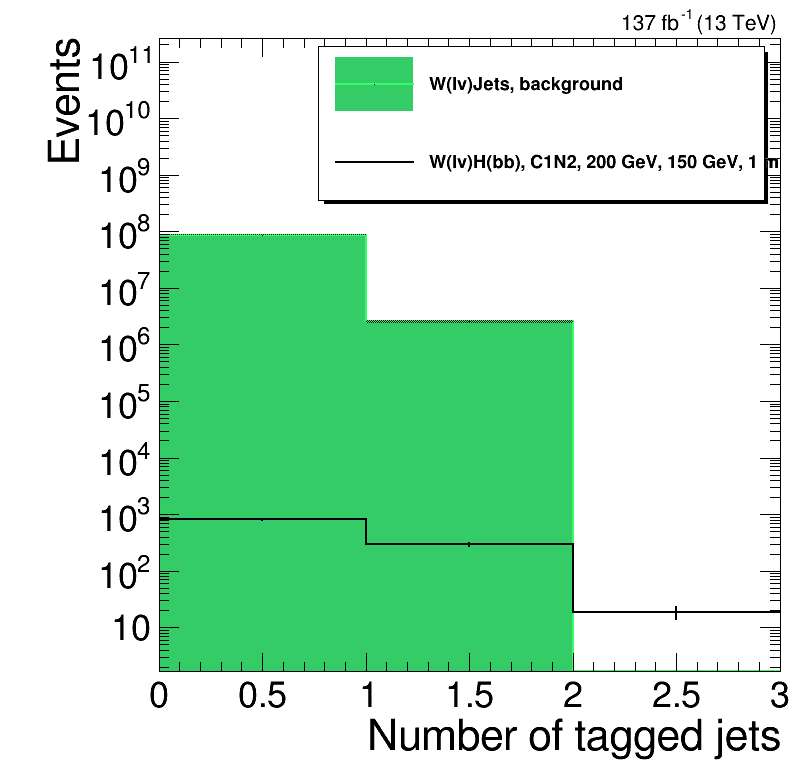

In [75]:
# loop over all the cuts and save the efficiency for each cut and a list for cuts
plotting = True

#signal>5
time_cuts = [0] 
tmf_et_cuts = [1.5] 
delta_r_cuts = [0.2275379049004003]
chef_cuts = [1.2981535804105477]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in pf_jet_tmf_et.items():
            
                    tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)

                    nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
                    for i,ele in enumerate(nTags[k]):
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.74,0.96,0.94)

                    leg.SetTextSize(0.025)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['W(lv)Jets, background']
                    sig_keys = [run_sig_key]
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = weight[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*1000)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = weight[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
    #                     print(k,1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h[run_sig_key].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print(tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
    #                 c.SaveAs("../plots/ntags_optimization/mindeltaRcut"+str(mindeltaR_cut)+"_timecut"+str(time_cut)+"gammacut"+str(gamma_cut)+".pdf")

## C1N2 200_150 validation

W(lv)Jets, background 0 0.0
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 14 18.737537144581438
total 86818444.37032938 947041.4289857871
0 808.3908882376563 86818444.37032938
1 298.46219880297576 2541329.9994170666
2 18.737537144581438 0.0
1.5 0.0 0.2275379049004003 1.2981535804105477 4.862351716701366 1
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 6 8.030373061963473
total 88182084.85782146 954449.9494138506
0 890.0330143676183 88182084.85782146
1 227.52723675563175 1177689.511924982
2 8.030373061963473 0.0
1.5 0.5 0.2275379049004003 1.2981535804105477 3.598007395292177 1
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 1 1.3383955103272456
total 88915558.15033615 958411.1499173258
0 979.7055135595438 88915558.15033615
1 144.54671511534252 444216.21941030025
2 1.3383955103272456 0.0
1.5 1.0 0.2275379049004003 1.2981535804105477 2.2347745640460284 0
137 fb^{-1} (13 TeV)
W(lv)Jets, background 0 0.0
W(lv)H(bb)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: W(lv)Jets, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replac

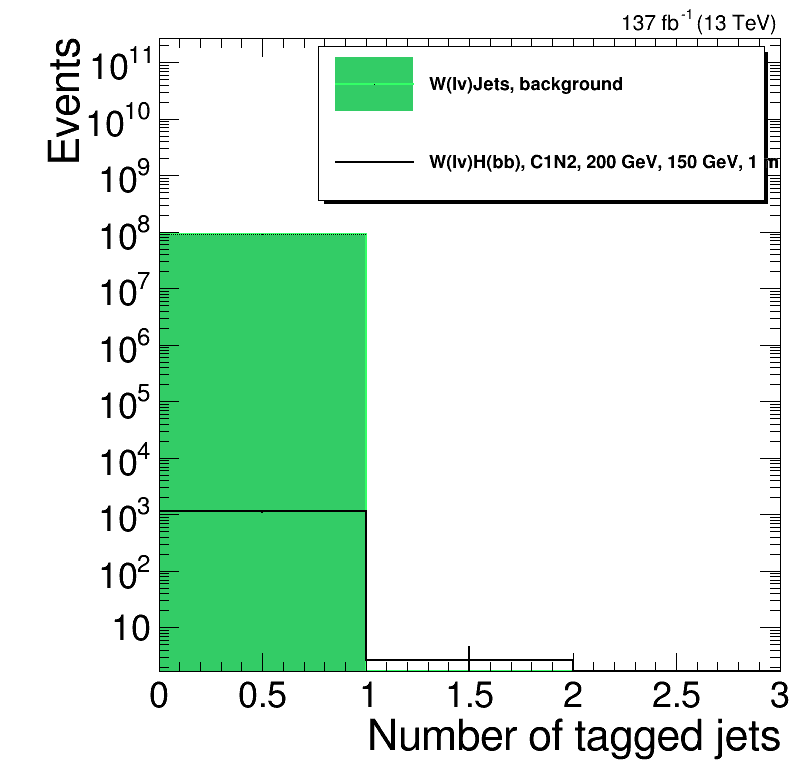

In [82]:
# for validation
plotting = True

time_cuts = [0] 
tmf_et_cuts = [1.5] 
delta_r_cuts = [0.2275379049004003]
chef_cuts = [1.2981535804105477]

cut_variable = 1
# 1 = time,   2= tmf, 3=deltaR, 4 = chef 
if cut_variable == 1:#time
    time_cuts = list(np.array(range(10))/2.0)
    time_cuts.sort() 
elif cut_variable == 2:#gamma
    tmf_et_cuts = list(np.array(range(16))/10.0)
elif cut_variable == 3:#deltaR
    delta_r_cuts = list(np.array(range(16))/10.0)+ [0.22,0.24]
    delta_r_cuts.sort()
else:
    chef_cuts = list(np.array(range(16))/10.0)
    chef_cuts.sort()


# time_cuts = np.array(time_cuts)
# tmf_et_cuts = np.array(tmf_et_cuts)
# delta_r_cuts = np.array(delta_r_cuts)
# chef_cuts = np.array(chef_cuts)

validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in pf_jet_tmf_et.items():
            
                    tagged_jet = np.logical_and(pf_jet_tmf_et[k]<tmf_et_cut, pf_jet_delta_r[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_time[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, pf_jet_chef[k]<chef_cut)

                    nTags[k] = pf_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
                    for i,ele in enumerate(nTags[k]):
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.74,0.96,0.94)

                    leg.SetTextSize(0.025)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['W(lv)Jets, background']
                    sig_keys = [run_sig_key]
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = weight[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*1000)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = weight[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
    #                     print(k,1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h[run_sig_key].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print(tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
    #                 c.SaveAs("../plots/ntags_optimization/mindeltaRcut"+str(mindeltaR_cut)+"_timecut"+str(time_cut)+"gammacut"+str(gamma_cut)+".pdf")

137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


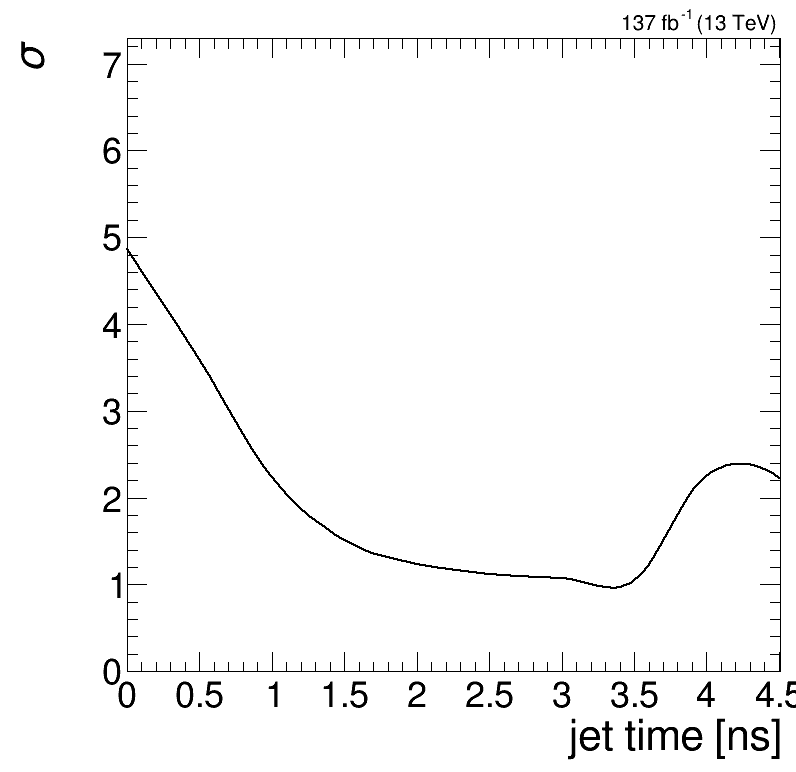

In [83]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

gr = {}


time_cuts = np.array(time_cuts)
tmf_et_cuts = np.array(tmf_et_cuts)
delta_r_cuts = np.array(delta_r_cuts)
chef_cuts = np.array(chef_cuts)
significance = np.array(significance)

# 1 = time,   2= tmf, 3=deltaR, 4 = chef 
 

if cut_variable == 1:
    gr['good'] = create_TGraph(time_cuts[validity],significance[validity],axis_title = ['jet time [ns]','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(time_cuts,significance,axis_title = ['jet time [ns]','\sigma'])
    x_max = np.max(time_cuts)
elif cut_variable == 2:
    gr['good'] = create_TGraph(tmf_et_cuts[validity],significance[validity],axis_title = ['TMF_{ET MAX}','\sigma'])
    gr['all'] = create_TGraph(tmf_et_cuts,significance,axis_title = ['TMF_{ET MAX}','\sigma'])
    x_max = np.max(tmf_et_cuts)
elif cut_variable == 3:
    gr['good'] = create_TGraph(delta_r_cuts[validity],significance[validity],axis_title = ['#Delta R_{min}','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(delta_r_cuts,significance,axis_title = ['#Delta R_{min}','\sigma'])
    x_max = np.max(delta_r_cuts)    
else:
    gr['good'] = create_TGraph(chef_cuts[validity],significance[validity],axis_title = ['CHEF','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(chef_cuts,significance,axis_title = ['#sigma_{ET}','\sigma'])
    x_max = np.max(chef_cuts)
    

    
gr['all'].SetLineWidth(2)
gr['all'].SetLineColor(1)
gr['all'].GetXaxis().SetRangeUser(0,x_max)
gr['all'].GetYaxis().SetRangeUser(0,1.5*np.max(significance))
# leg.AddEntry(gr['all'],"Has > 5 signal events")
gr['all'].Draw('ac')

    
 
leg.Draw()
    
 

CMS_lumi.lumi_13TeV = "137 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


 
c.Draw()


# pf jet 

## per jet percentage

In [15]:
# pf jet

acc = 1
acc_or = 1
acc_case = 'barrel'
# acc_case = 'endcap'
# acc_case = 'all'
match = 1
pt_cut = 0
pt_ranges = [[20,30],[30,40],[40,50],[0,2000]]

pf_jet_pt = {}

 
for k,v in tree.items(): 
    print(k,v)
    
    pf_jet_pt[k] = {}
 
 
    #branches

    pt = v['jetPt'].array()
    eta = v['jetEta'].array()

    basic0_str = np.logical_and(abs(eta)<1.48, pt>pt_cut)
    
    # matched requirement
    if 'background' not in k:
        if 'TwinHiggs' in k:
            matched0 = v['jet_matched_gLLP0_daughter'].array()
            matched1 = v['jet_matched_gLLP1_daughter'].array()
        elif 'C1N2' in k:
            matched0 = v['jet_matched_gLLP0_grandaughter'].array()
            matched1 = v['jet_matched_gLLP1_grandaughter'].array()

        matched_str = np.logical_or(matched0==1, matched1==1)

        acc0_eb = v['gLLP0_EB'].array()
        acc1_eb = v['gLLP1_EB'].array() 

        acc1_ee = v['gLLP0_EE'].array()
        acc0_ee = v['gLLP1_EE'].array()

        if acc_or:
            acc_eb_str = np.logical_or(acc0_eb==1, acc1_eb==1)
            acc_ee_str = np.logical_or(acc0_ee==1, acc1_ee==1)
        else:
            acc_eb_str = np.logical_and(acc0_eb==1, acc1_eb==1)
            acc_ee_str = np.logical_and(acc0_ee==1, acc1_ee==1)

        # accepantance requirement
        if acc_case=='barrel':
            acc_str = acc_eb_str
        elif acc_case=='endcap':
            acc_str = acc_ee_str
        elif acc_case=='all':
            acc_str = np.logical_or(acc_eb_str, acc_ee_str)    
    
    print('pt in pt_ranges')
    for pt_range in pt_ranges:
        pt_str = str(pt_range[0])+'_'+str(pt_range[1])
        
        pf_jet_pt[k][pt_str] = []
 
        pt_cut_str = np.logical_and(pt>pt_range[0], pt<pt_range[1])
        basic1_str = np.logical_and(pt_cut_str, basic0_str)
    
        if 'background' in k:
            basic_str = basic1_str
        elif not match and not acc:
            print('no match, no acceptance cut')
            basic_str = basic1_str
        elif match and not acc:
            print('matched, no acceptance cut')
            basic_str = np.logical_and(basic1_str, matched_str)
        elif not match and acc:
            print('no match, with acceptance cut')
            basic_str = np.logical_and(basic1_str, acc_str)
        elif match and acc:
            print('matched, with acceptance cut')
            basic2_str = np.logical_and(matched_str, acc_str)
            basic_str = np.logical_and(basic1_str, basic2_str)

        # variables        

        j_pt = pt[basic_str]
        j_pt_de = pt[basic1_str]
   

        #per jet

        j_pt_all = j_pt.flatten()
        j_pt_all_de = j_pt_de.flatten()

  
        # print checkout

#         print(j_pt_all[:10])

 
        # assign 

        pf_jet_pt[k][pt_str] = j_pt_all

        print('pt range: ',pt_str,' GeV, jet array leghth: ', len(j_pt_all), ', denominator: ', len(j_pt_all_de), ', percentage: ', 100*len(j_pt_all)/len(j_pt_all_de), ' %')
#         print('leghth', len(j_weight_all))
 




W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f48981fb1d0>
pt in pt_ranges
pt range:  20_30  GeV, jet array leghth:  237179 , denominator:  237179 , percentage:  100.0  %
pt range:  30_40  GeV, jet array leghth:  117354 , denominator:  117354 , percentage:  100.0  %
pt range:  40_50  GeV, jet array leghth:  56280 , denominator:  56280 , percentage:  100.0  %
pt range:  0_2000  GeV, jet array leghth:  503270 , denominator:  503270 , percentage:  100.0  %
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f4898189cc0>
pt in pt_ranges
matched, with acceptance cut
pt range:  20_30  GeV, jet array leghth:  2087 , denominator:  18671 , percentage:  11.177762305179154  %
matched, with acceptance cut
pt range:  30_40  GeV, jet array leghth:  1478 , denominator:  8952 , percentage:  16.510277033065236  %
matched, with acceptance cut
pt range:  40_50  GeV, jet array leghth:  970 , denominator:  4643 , percentage:  20.891664871850097  %
matched, with acceptance cut
pt range: 

## per event percentage

In [26]:
# pf jet

acc = 1
acc_or = 1
acc_case = 'barrel'
# acc_case = 'endcap'
# acc_case = 'all'
match = 1
pt_cut = 0
pt_ranges = [[20,30],[30,40],[40,50],[0,2000]]

pf_jet_pt = {}
pf_jet_weight = {}

 
for k,v in tree.items(): 
    print(k,v)
    
    pf_jet_pt[k] = {}
    pf_jet_weight[k] = {}
 
 
    #branches

    weight = v['weight'].array()
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()

    print(weight[:10])    
    print(pt[:10])
    
    weight_ex = []
    for evt,(x,y) in enumerate(zip(weight, pt)):
        weight_ex_evt = [x]*len(y)
        weight_ex.append(weight_ex_evt)
#         weight_ex.append(np.array(weight_ex_evt))
#     weight_ex = np.array(weight_ex)
    print(weight_ex[:10])    
            

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f48981fb1d0>
[0.07540591 0.07540591 0.07540591 0.07540591 0.07540591 0.07540591
 0.07540591 0.07540591 0.07540591 0.07540591]
[[] [47.155704] [61.834312 30.679577] ... [32.43986] [26.16801] [31.874367]]
[[], [0.07540591], [0.07540591, 0.07540591], [], [0.07540591], [0.07540591], [0.07540591], [0.07540591], [0.07540591], [0.07540591]]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f4898189cc0>
[3.0152192e-05 3.0152192e-05 3.0152192e-05 3.0152192e-05 3.0152192e-05
 3.0152192e-05 3.0152192e-05 3.0152192e-05 3.0152192e-05 3.0152192e-05]
[[] [38.483864 20.122217] [40.626217 29.277702 21.707123] ... [62.340057] [146.04501 38.049988] [31.505201]]
[[], [3.0152192e-05, 3.0152192e-05], [3.0152192e-05, 3.0152192e-05, 3.0152192e-05], [3.0152192e-05], [3.0152192e-05], [3.0152192e-05, 3.0152192e-05], [], [3.0152192e-05], [3.0152192e-05, 3.0152192e-05], [3.0152192e-05]]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' a

In [44]:
# pf jet

acc = 1
acc_or = 1
acc_case = 'barrel'
# acc_case = 'endcap'
# acc_case = 'all'
match = 1
pt_cut = 0
pt_ranges = [[0,2000]]
# pt_ranges = [[20,30],[30,40],[40,50],[0,2000]]

pf_jet_pt = {}
pf_jet_weight = {}

 
for k,v in tree.items(): 
    print(k,v)
    
    pf_jet_pt[k] = {}
    pf_jet_weight[k] = {}
 
 
    #branches

    weight = v['weight'].array()
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    
    basic0_str = np.logical_and(abs(eta)<1.48, pt>pt_cut)
    
    # matched requirement
    if 'background' not in k:
        if 'TwinHiggs' in k:
            matched0 = v['jet_matched_gLLP0_daughter'].array()
            matched1 = v['jet_matched_gLLP1_daughter'].array()
        elif 'C1N2' in k:
            matched0 = v['jet_matched_gLLP0_grandaughter'].array()
            matched1 = v['jet_matched_gLLP1_grandaughter'].array()

        matched_str = np.logical_or(matched0==1, matched1==1)

        acc0_eb = v['gLLP0_EB'].array()
        acc1_eb = v['gLLP1_EB'].array() 

        acc1_ee = v['gLLP0_EE'].array()
        acc0_ee = v['gLLP1_EE'].array()

        if acc_or:
            acc_eb_str = np.logical_or(acc0_eb==1, acc1_eb==1)
            acc_ee_str = np.logical_or(acc0_ee==1, acc1_ee==1)
        else:
            acc_eb_str = np.logical_and(acc0_eb==1, acc1_eb==1)
            acc_ee_str = np.logical_and(acc0_ee==1, acc1_ee==1)

        # accepantance requirement
        if acc_case=='barrel':
            acc_str = acc_eb_str
        elif acc_case=='endcap':
            acc_str = acc_ee_str
        elif acc_case=='all':
            acc_str = np.logical_or(acc_eb_str, acc_ee_str)    
    
    print('pt in pt_ranges')
    for pt_range in pt_ranges:
        pt_str = str(pt_range[0])+'_'+str(pt_range[1])
        
        pf_jet_pt[k][pt_str] = []
 
        pt_cut_str = np.logical_and(pt>pt_range[0], pt<pt_range[1])
        basic1_str = np.logical_and(pt_cut_str, basic0_str)
    
        if 'background' in k:
            basic_str = basic1_str
        elif not match and not acc:
            print('no match, no acceptance cut')
            basic_str = basic1_str
        elif match and not acc:
            print('matched, no acceptance cut')
            basic_str = np.logical_and(basic1_str, matched_str)
        elif not match and acc:
            print('no match, with acceptance cut')
            basic_str = np.logical_and(basic1_str, acc_str)
        elif match and acc:
            print('matched, with acceptance cut')
            basic2_str = np.logical_and(matched_str, acc_str)
            basic_str = np.logical_and(basic1_str, basic2_str)

        # variables        

        evt_flag = []
        for evt,(x) in enumerate(basic_str):
             evt_flag.append(np.any(x))
#         print(basic_str[:10])
#         print(evt_flag[:10])
    
        j_w = weight[evt_flag]
        j_pt = pt[basic_str]
        j_pt_de = pt[basic1_str]
   

        #per jet

        j_w_all = j_w
        j_pt_all = j_pt.flatten()
        j_pt_all_de = j_pt_de.flatten()

  
        # print checkout

#         print(j_pt_all[:10])
#         print(j_w_all[:10])

 
        # assign 

        pf_jet_pt[k][pt_str] = j_pt_all
        pf_jet_weight[k][pt_str] = j_w_all

#         print('pt range: ',pt_str,' GeV, event array leghth: ', len(j_w_all), ', denominator: ', len(weight), ', percentage: ', 100*len(j_w_all)/len(weight), ' %')
#         print('pt range: ',pt_str,' GeV, event array sum: ', sum(j_w_all), ', denominator: ', sum(weight), ', percentage: ', 100*sum(j_w_all)/sum(weight), ' %')
        print('pt range: ',pt_str,' GeV, event array sum: ', 137*sum(j_w_all), ', denominator: ', 137*sum(weight), ', percentage: ', 100*sum(j_w_all)/sum(weight), ' %')
 




W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f48981fb1d0>
pt in pt_ranges
pt range:  0_2000  GeV, event array sum:  3718420.3359763324 , denominator:  8429157.722456753 , percentage:  44.11378287619188  %
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f4898189cc0>
pt in pt_ranges
matched, with acceptance cut
pt range:  0_2000  GeV, event array sum:  26.482881533049294 , denominator:  162.89182147757492 , percentage:  16.257956533867574  %
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f48996a3b38>
pt in pt_ranges
matched, with acceptance cut
pt range:  0_2000  GeV, event array sum:  43.41259349696702 , denominator:  162.4843402205479 , percentage:  26.718016910454875  %
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f48996f20b8>
pt in pt_ranges
matched, with acceptance cut
pt range:  0_2000  GeV, event array sum:  14.471110800246606 , denominator:  40.69679326743835 , percentage:  35.55835641680641  %


In [46]:
s1 = 0.324*26.482881533049294
s2 = 14.471110800246606
b = 3718420.3359763324
a1 = s1/b
a2 = s2/b
print(a1,a2)

2.307553434368531e-06 3.8917361386598e-06
